In [1]:
import sys
sys.path.append('seminars/seminar6')

In [2]:
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD

import torchvision
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import visualize_2d_samples

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# <center>Deep Generative Models</center>
## <center>Seminar 6</center>

<center>21.10.2025</center>


## Plan

- Vanilla GAN
- NS GAN
- WGAN
- WGAN-GP


**Table 1: Generator and discriminator loss functions**
| GAN | Discriminator Loss | Generator Loss | Optimized Divergence |
|-----|-------------------|----------------|----------------------|
| GAN | $\mathcal{L}_D^{\text{GAN}} = -\mathbb{E}_{x \sim p_d}[\log(D(x))] - \mathbb{E}_{\hat{x} \sim p_g}[\log(1 - D(\hat{x}))]$ | $\mathcal{L}_G^{\text{GAN}} = \mathbb{E}_{\hat{x} \sim p_g}[\log(1 - D(\hat{x}))]$ | Jensen-Shannon Divergence:<br>$JSD(P_r \parallel P_g) = \frac{1}{2}KL(P_r \parallel \frac{P_r+P_g}{2}) + \frac{1}{2}KL(P_g \parallel \frac{P_r+P_g}{2})$ |
| NS GAN | $\mathcal{L}_D^{\text{NSGAN}} = -\mathbb{E}_{x \sim p_d}[\log(D(x))] - \mathbb{E}_{\hat{x} \sim p_g}[\log(1 - D(\hat{x}))]$ | $\mathcal{L}_G^{\text{NSGAN}} = -\mathbb{E}_{\hat{x} \sim p_g}[\log(D(\hat{x}))]$ | Jensen-Shannon Divergence:<br>$JSD(P_r \parallel P_g) = \frac{1}{2}KL(P_r \parallel \frac{P_r+P_g}{2}) + \frac{1}{2}KL(P_g \parallel \frac{P_r+P_g}{2})$ |
| WGAN | $\mathcal{L}_D^{\text{WGAN}} = -\mathbb{E}_{x \sim p_d}[D(x)] + \mathbb{E}_{\hat{x} \sim p_g}[D(\hat{x})]$ | $\mathcal{L}_G^{\text{WGAN}} = -\mathbb{E}_{\hat{x} \sim p_g}[D(\hat{x})]$ | Wasserstein Distance (Earth Mover's Distance):<br>$W(P_r, P_g) = \inf_{\gamma \in \Pi(P_r, P_g)} \mathbb{E}_{(x,y) \sim \gamma}[\|x-y\|]$ |
| WGAN GP | $\mathcal{L}_D^{\text{WGANGP}} = \mathcal{L}_D^{\text{WGAN}} + \lambda\mathbb{E}_{\hat{x} \sim p_g}[(\|\|\nabla D(\alpha x + (1 - \alpha)\hat{x})\|\|_2 - 1)^2]$ | $\mathcal{L}_G^{\text{WGANGP}} = -\mathbb{E}_{\hat{x} \sim p_g}[D(\hat{x})]$ | Wasserstein Distance with 1-Lipschitz enforcement:<br>$W(P_r, P_g) = \inf_{\gamma \in \Pi(P_r, P_g)} \mathbb{E}_{(x,y) \sim \gamma}[\|x-y\|]$ |

## Vanilla GAN

$$\min_G \max_D V(G, D) = \min_G \max_D [\mathbb{E}_{\pi(\mathbf{x})} \log D(\mathbf{x}) + \mathbb{E}_{p(\mathbf{z})} \log(1 - D(G(\mathbf{z})))]$$

▶ **Generator:** generative model $\mathbf{x} = G(\mathbf{z})$, which makes generated sample more realistic.

▶ **Discriminator:** a classifier $D(\mathbf{x}) \in [0, 1]$, which distinguishes real samples from generated samples.

$$C(G) = -\log(4) + KL \left( p_{data} \left\| \frac{p_{data} + p_g}{2} \right. \right) + KL \left( p_g \left\| \frac{p_{data} + p_g}{2} \right. \right)$$

is the Kullback-Leibler divergence. We recognize in the previous expression the Jensen-Shannon divergence between the model's distribution and the data generating process:

$$C(G) = -\log(4) + 2 \cdot JSD(p_{data}\|p_g)$$

### **Mode collapse**

The main cause is **gradient vanishing** — the generator stops receiving meaningful feedback from the discriminator outside its current modes. This happens due to two factors:

1. **Perfect discrimination** — when the discriminator $D$ becomes too accurate, gradients for the generator approach zero.

   *More formally:*
   The generator minimizes
   $$
   L_G = \mathbb{E}_{z \sim P_z}[\log(1 - D(G(z)))].
   $$
   When $D(G(z)) \to 0$, we have
   $$
   \frac{\partial L_G}{\partial D(G(z))} = -\frac{1}{1 - D(G(z))} \to 0,
   $$
   so the generator receives almost no gradient updates.


<center>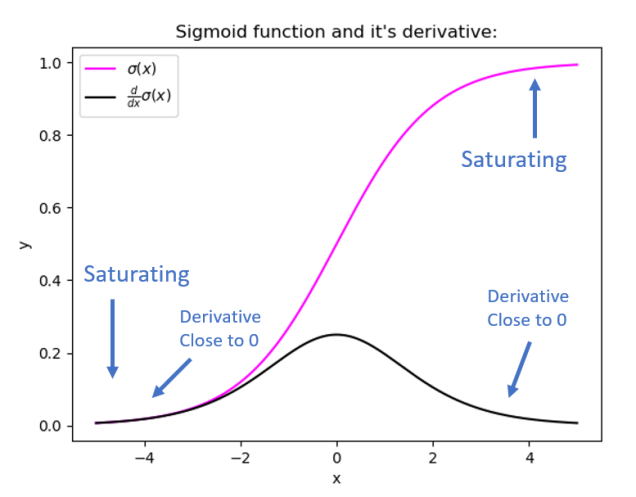</center>

2. **Disjoint supports** — when the supports of the generator’s distribution $p_g$ and the real data distribution $p_{data}$ do not overlap, causing the JS-divergence-based loss to yield no informative gradients.

   *More formally:*
   If $\text{supp}(p_g) \cap \text{supp}(p_{data}) = \emptyset$, then
   $$
   \mathrm{JSD}(p_{data} | p_g) = \log 2,
   $$
   a constant value, and therefore
   $$
   \nabla_{\theta_G} \mathrm{JSD}(p_{data} | p_g) = 0.
   $$
   As a result, the generator cannot move its distribution toward the real data — training stagnates within the current modes.

<center> 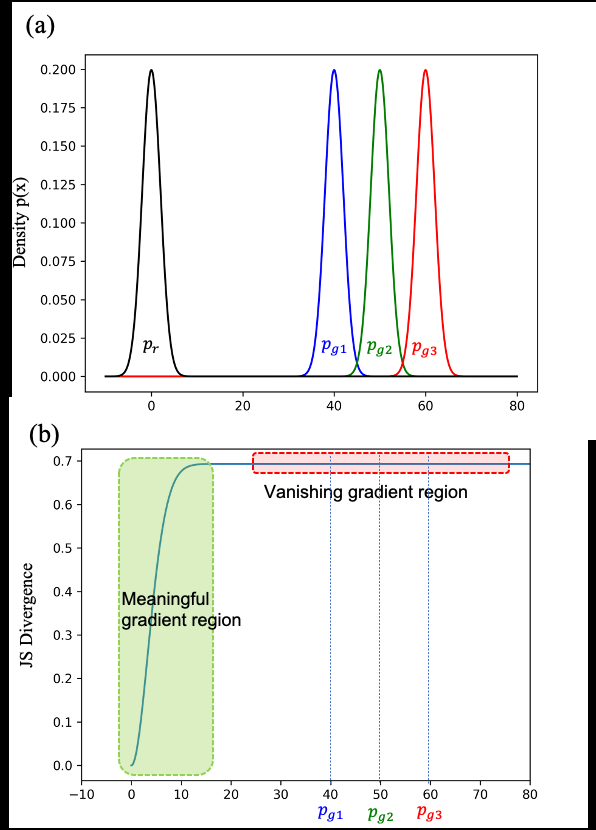 <center/>

#### **Practical Note**

* Use **RMSProp** or **Adam** with $\beta_1 = 0$ when training your GAN — high momentum can amplify oscillations between the generator and discriminator.
* Avoid **large learning rates**; unstable updates can cause one model to overpower the other, worsening mode collapse.
* Regularly **monitor the discriminator’s accuracy** — if it quickly reaches near 100%, temporarily slow down its learning rate or add noise to its inputs.
* Introduce **label smoothing** or **instance noise** to make the discriminator less confident, helping gradients propagate more evenly.
* Ensure **balanced updates** (e.g., one or two D-steps per G-step) to maintain stable adversarial dynamics.

#### 1D data

In [3]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()

    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

In [4]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0., 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0., 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        # your code here
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples
    
    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        # vanilla GAN: minimize log(1 - D(G(z))) → label = 0
        loss = -self.criterion(classifications, self.target_zeros)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    
    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.D.zero_grad()
        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # you code here
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)
        
        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # you code here

        fake_samples = self.G(latent_vec).detach()
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()
    
    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [6]:
noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

In [7]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')
loss_g, loss_d_real, loss_d_fake = [], [], []

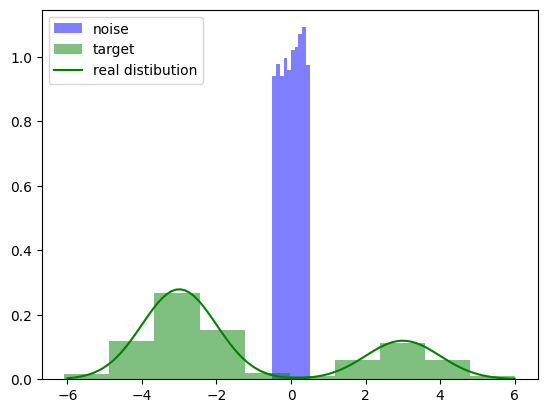

In [8]:
plot_gan_data(data_fn, noise_fn, data_pdf)

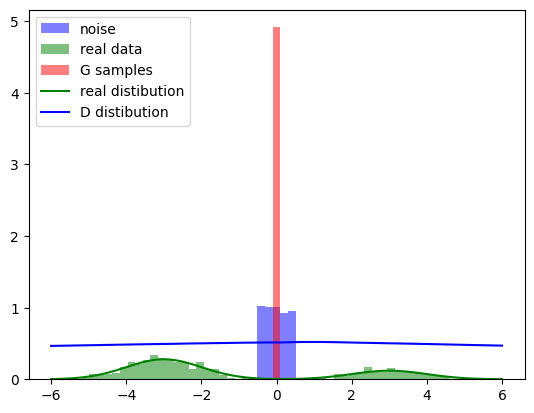

In [9]:
visualize_GAN(gan, data_pdf=data_pdf)

0
D train step 0


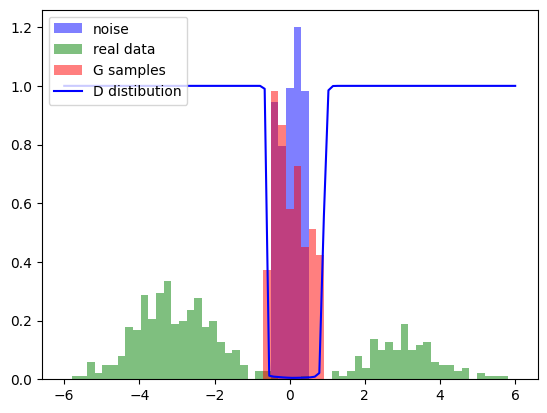

D train step 4


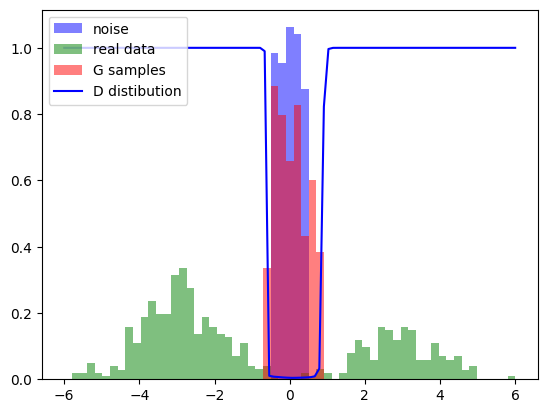

G train step


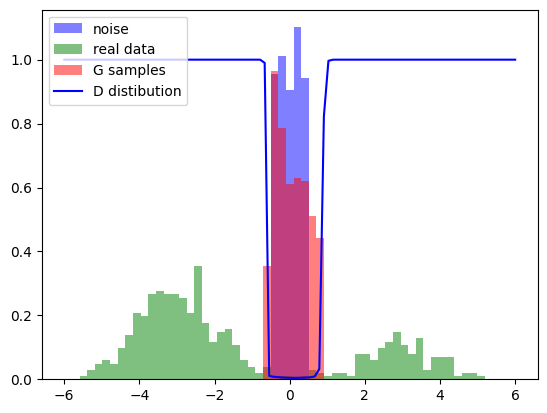

20
D train step 0


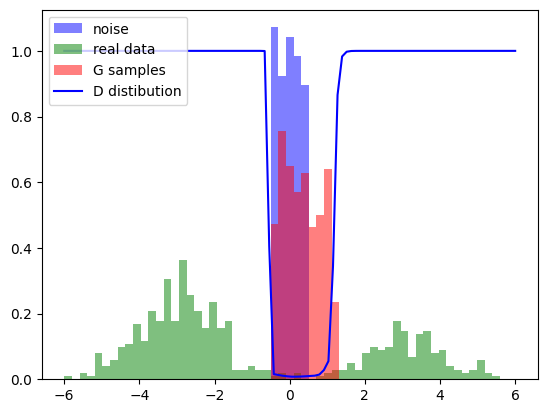

D train step 4


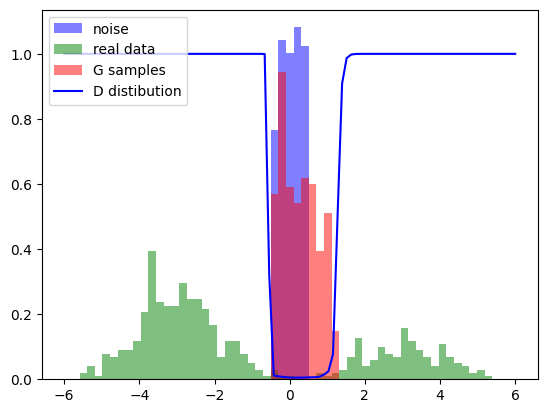

G train step


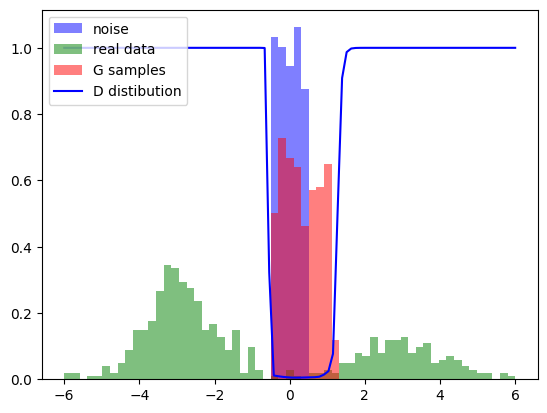

40
D train step 0


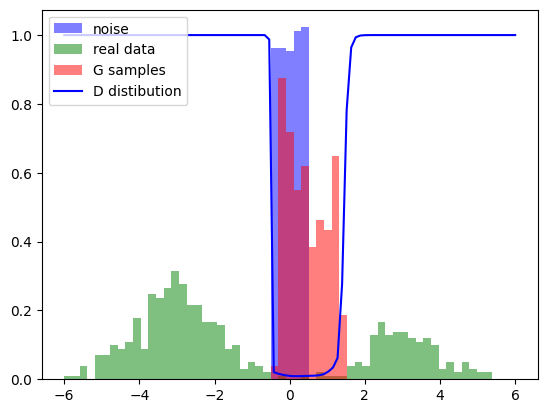

D train step 4


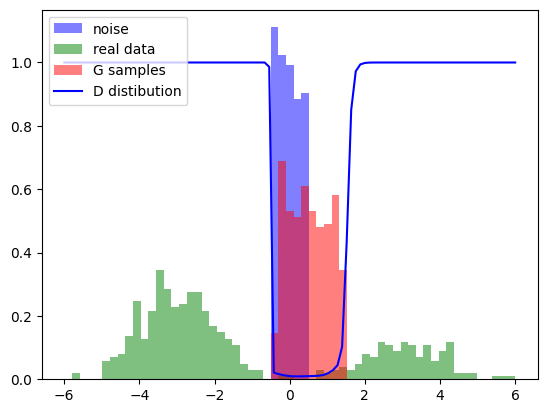

G train step


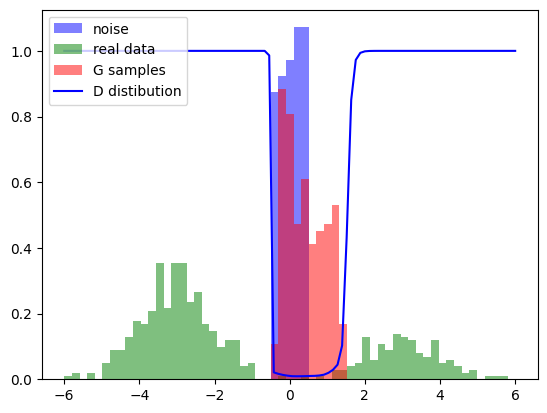

60
D train step 0


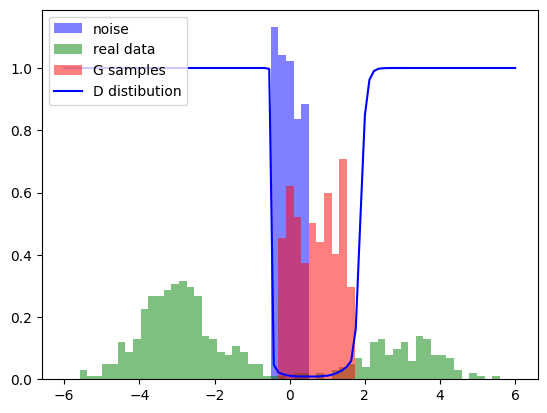

D train step 4


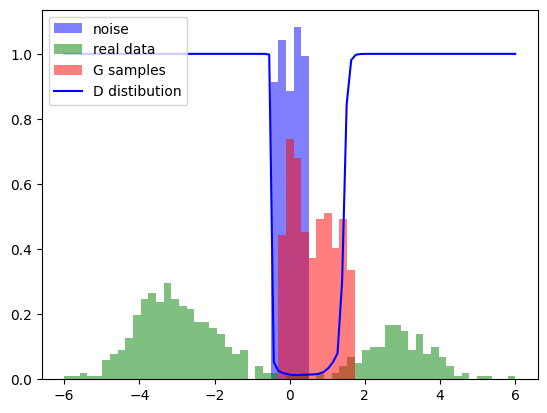

G train step


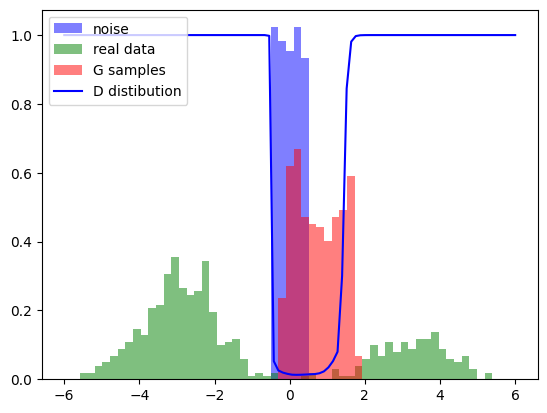

80
D train step 0


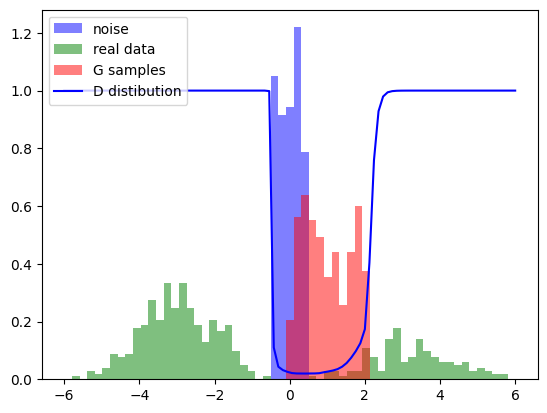

D train step 4


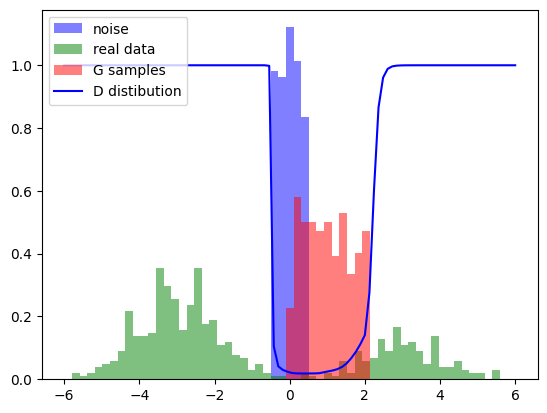

G train step


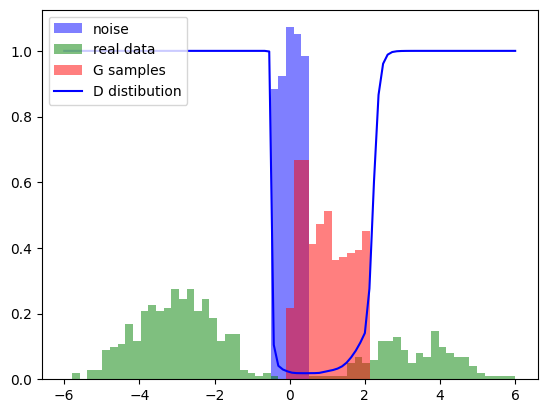

Epoch 1/20 (11s): G=-0.042, Dr=0.111, Df=0.046


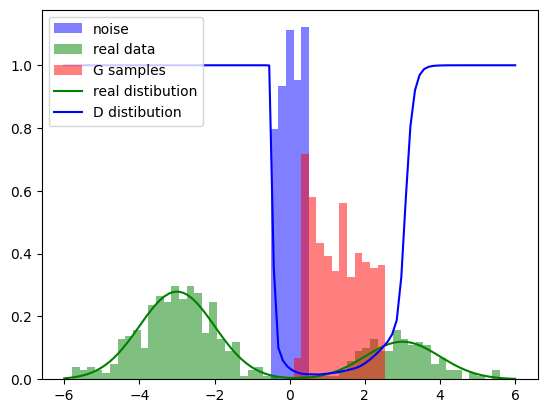

0
D train step 0


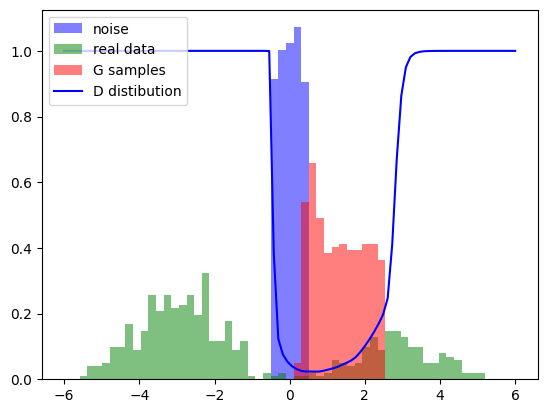

D train step 4


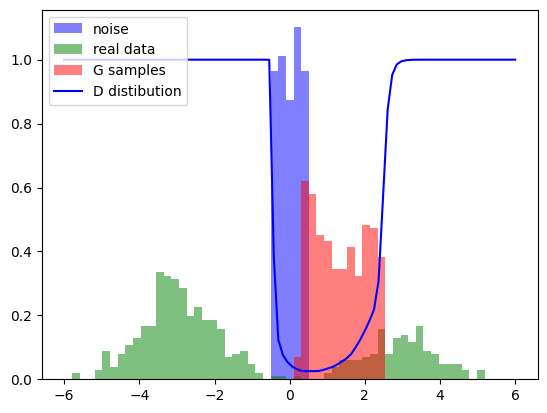

G train step


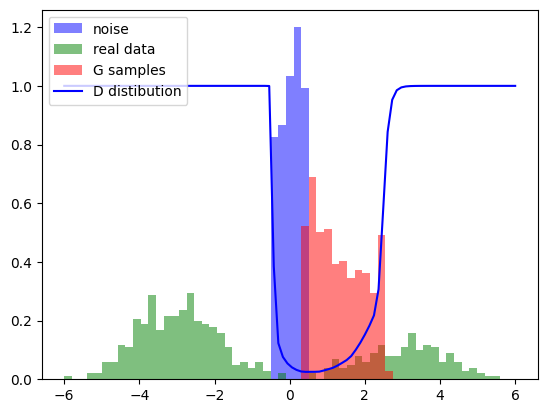

20
D train step 0


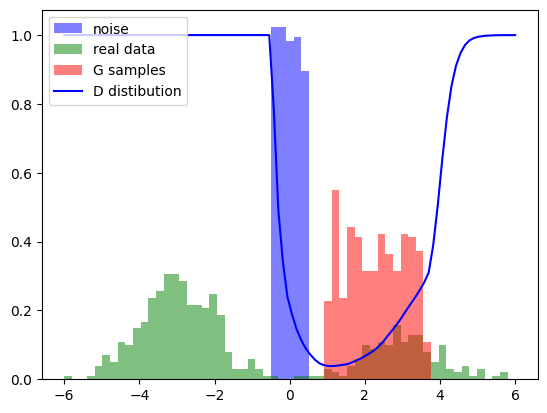

D train step 4


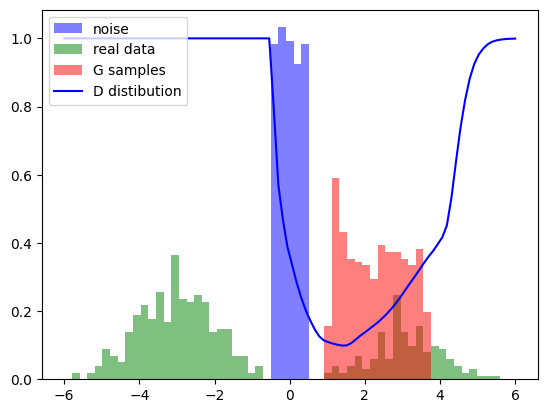

G train step


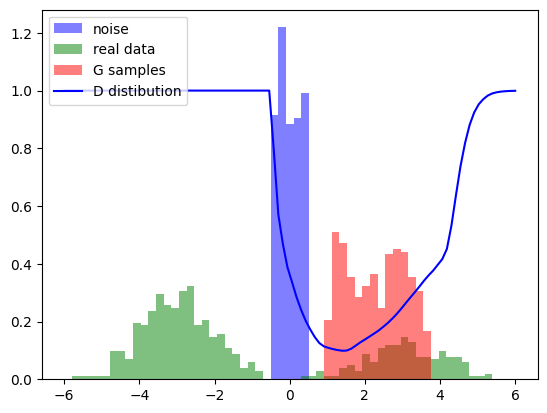

40
D train step 0


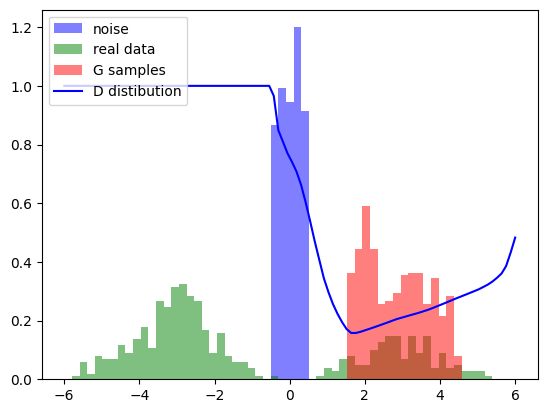

D train step 4


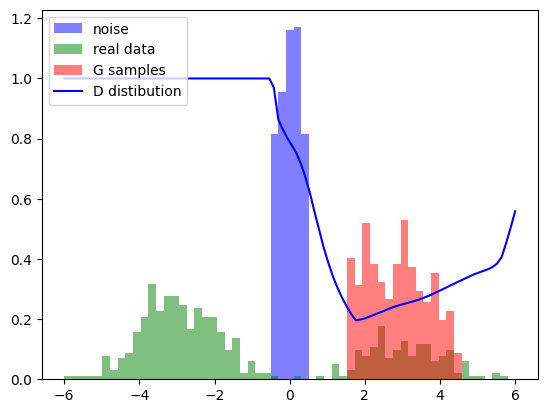

G train step


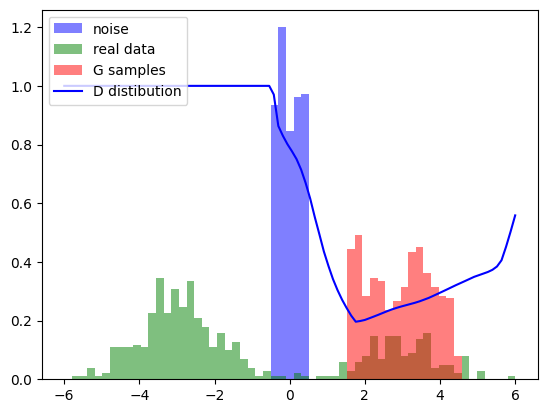

60
D train step 0


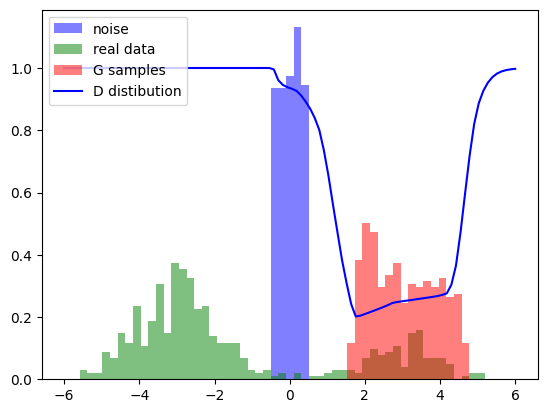

D train step 4


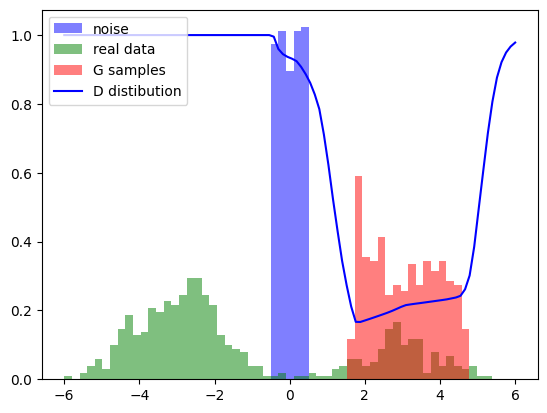

G train step


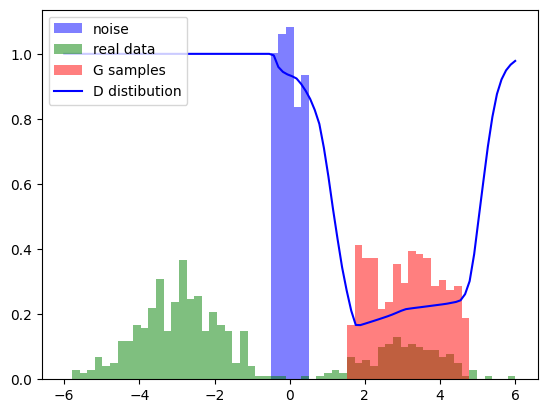

80
D train step 0


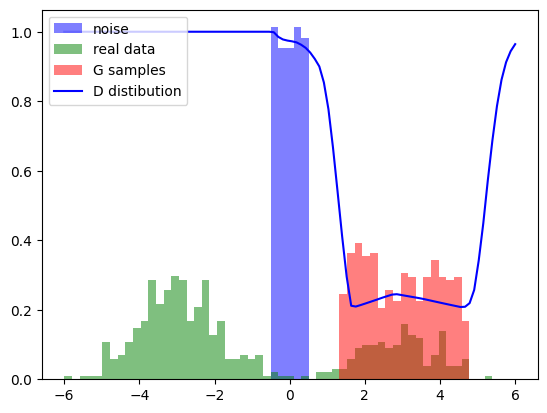

D train step 4


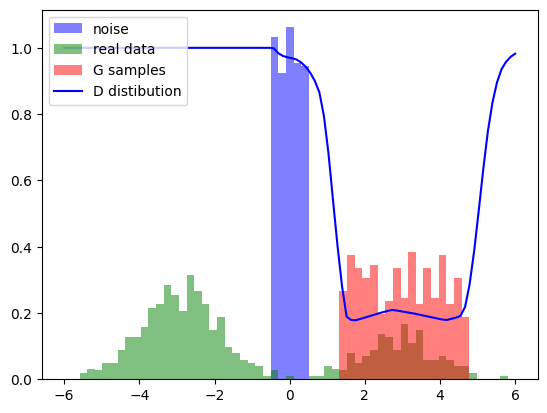

G train step


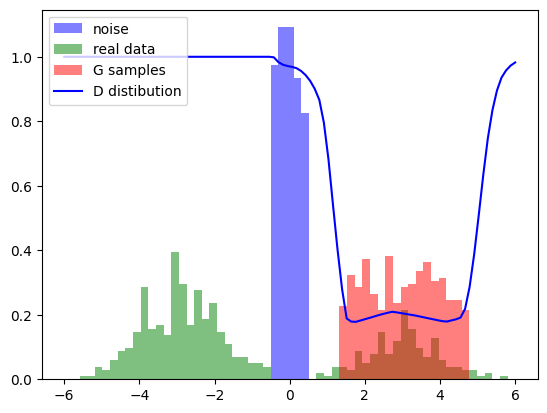

Epoch 2/20 (22s): G=-0.250, Dr=0.401, Df=0.240


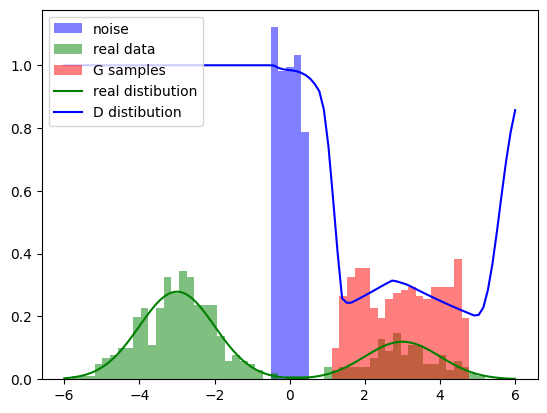

0
D train step 0


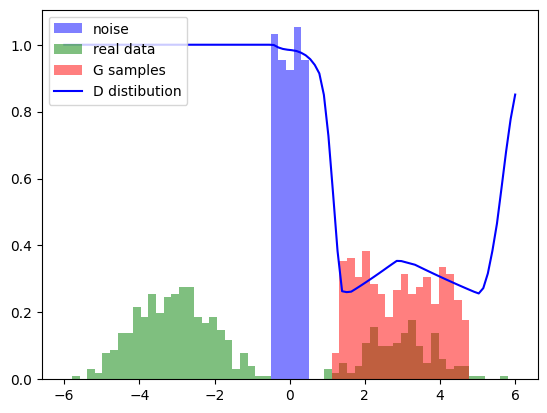

D train step 4


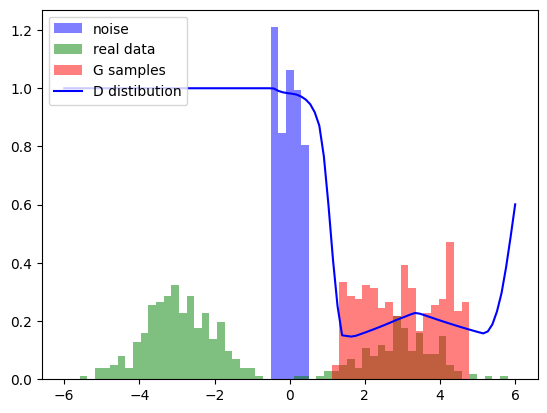

G train step


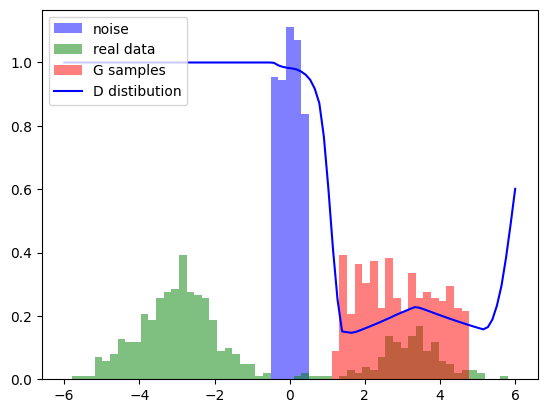

20
D train step 0


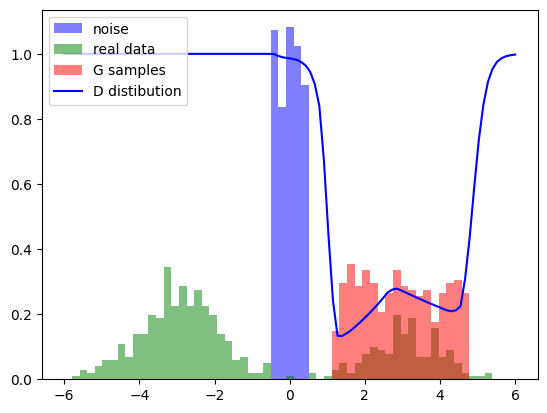

D train step 4


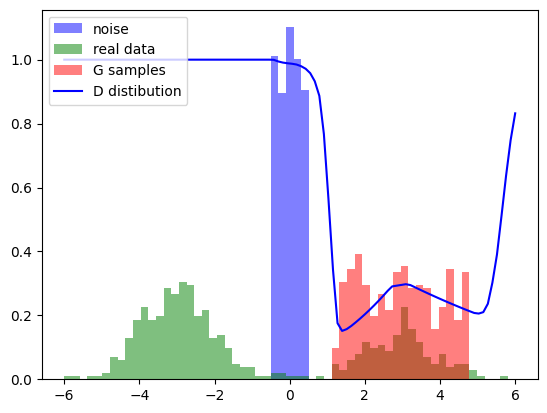

G train step


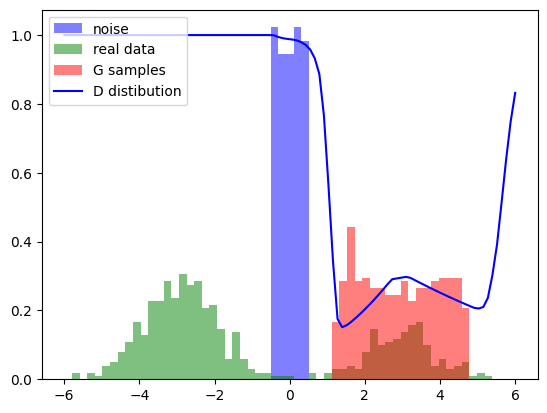

40
D train step 0


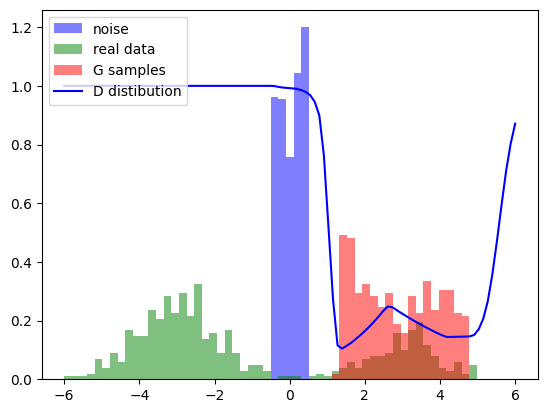

D train step 4


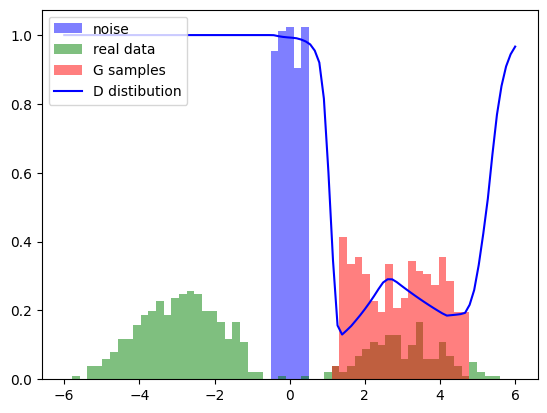

G train step


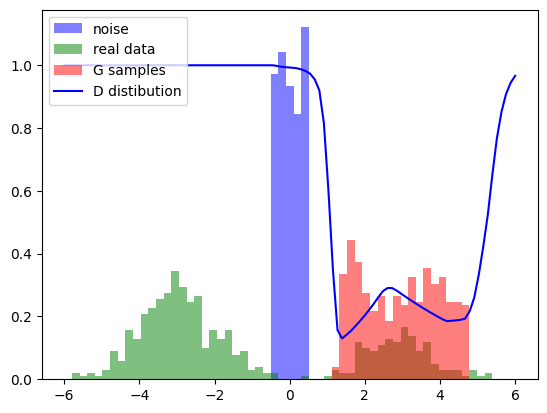

60
D train step 0


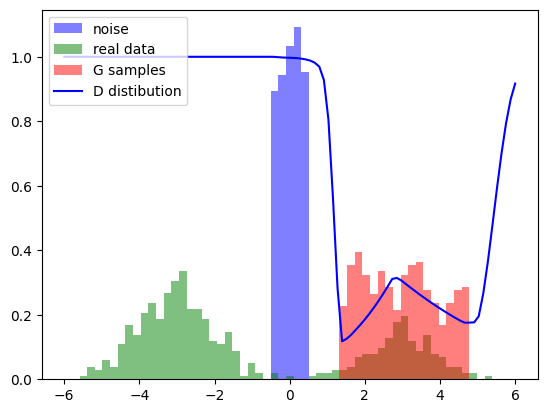

D train step 4


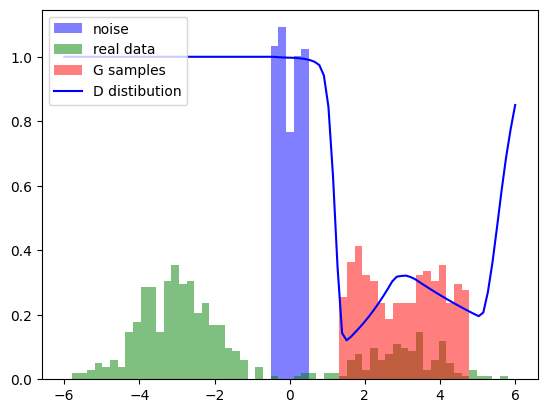

G train step


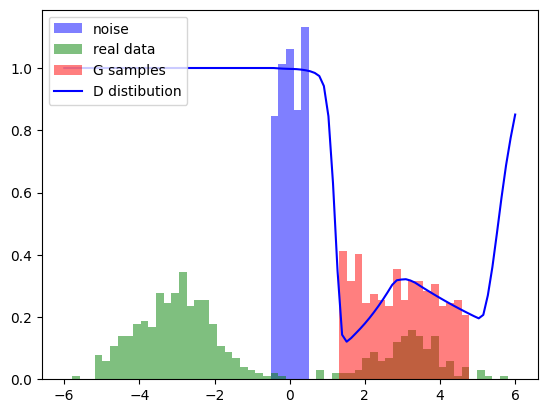

80
D train step 0


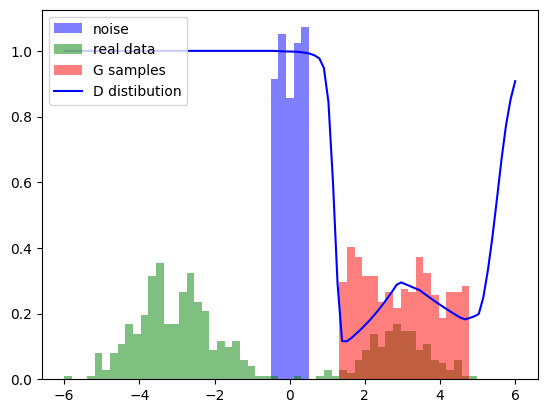

D train step 4


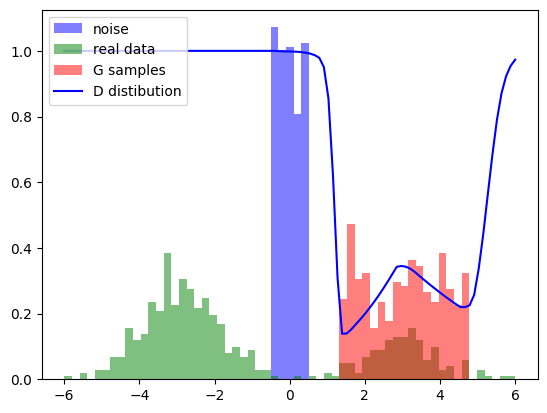

G train step


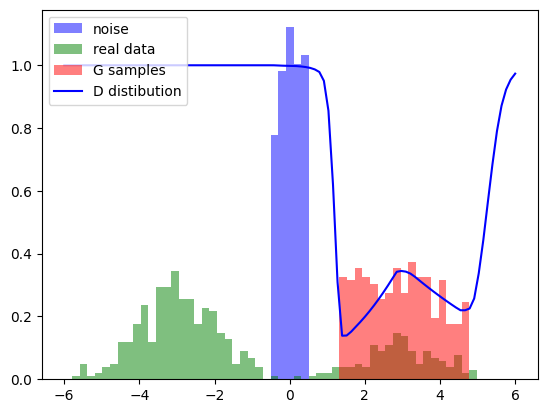

Epoch 3/20 (34s): G=-0.253, Dr=0.422, Df=0.255


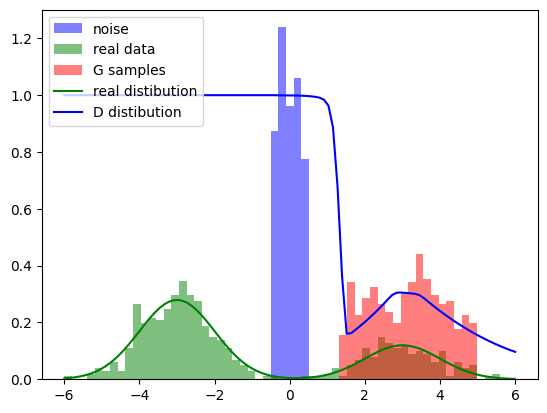

0
D train step 0


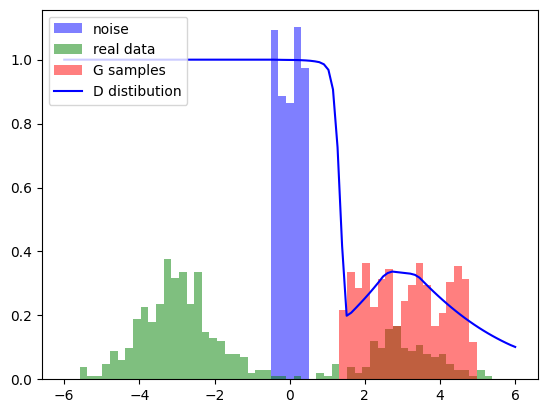

D train step 4


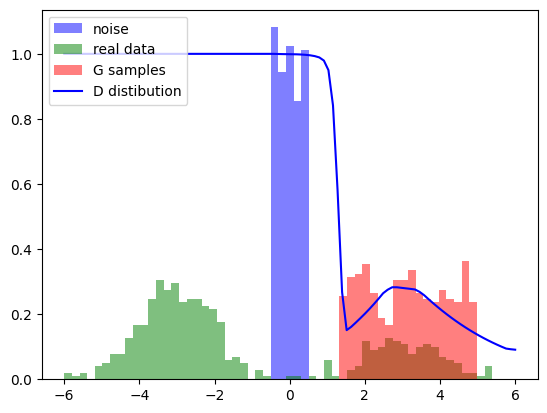

G train step


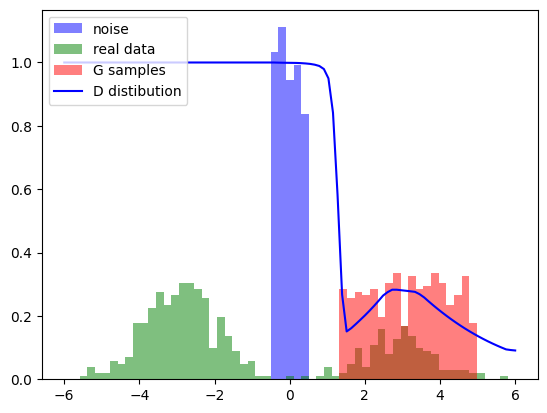

20
D train step 0


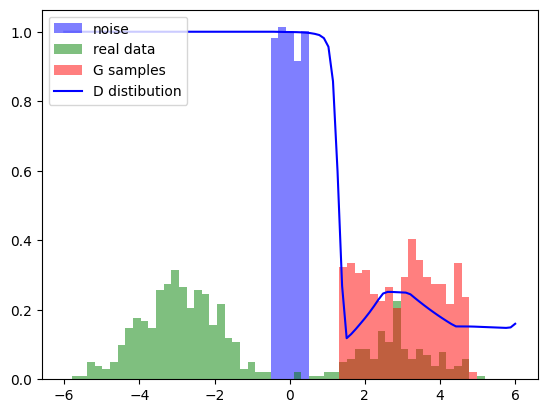

D train step 4


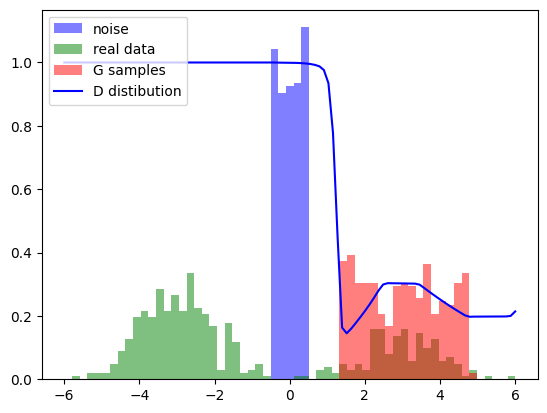

G train step


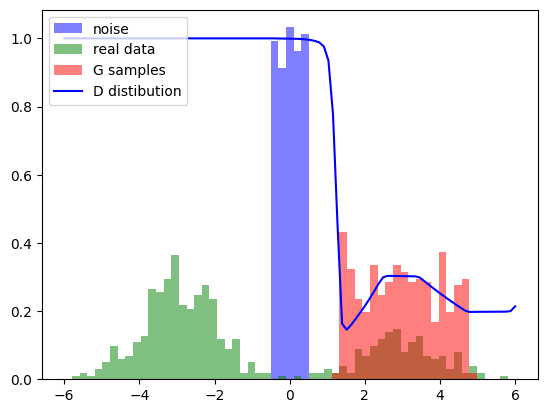

40
D train step 0


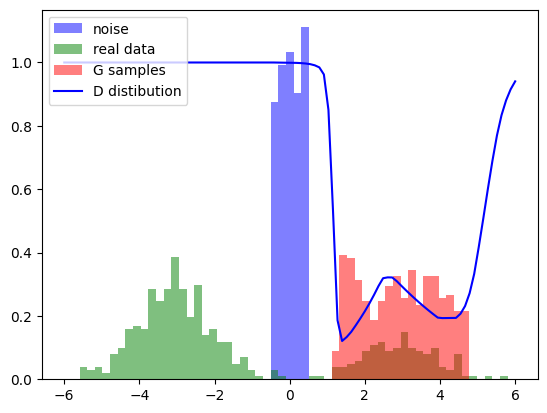

D train step 4


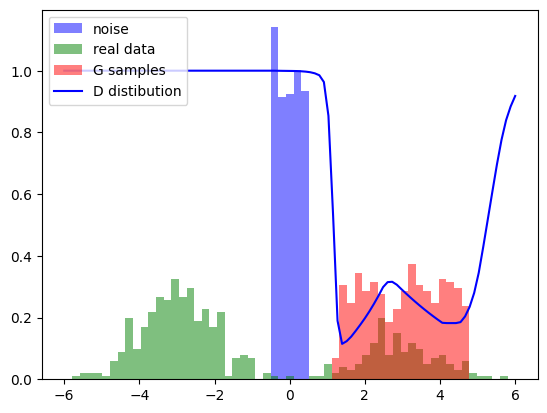

G train step


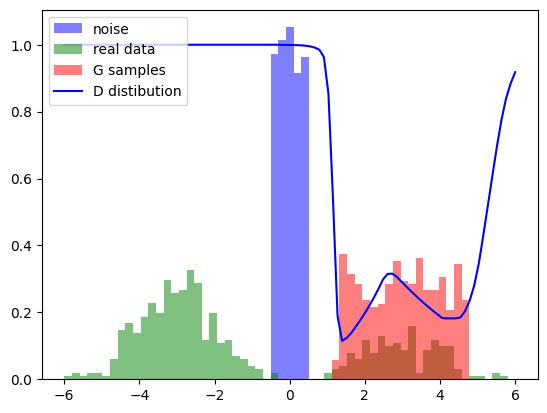

60
D train step 0


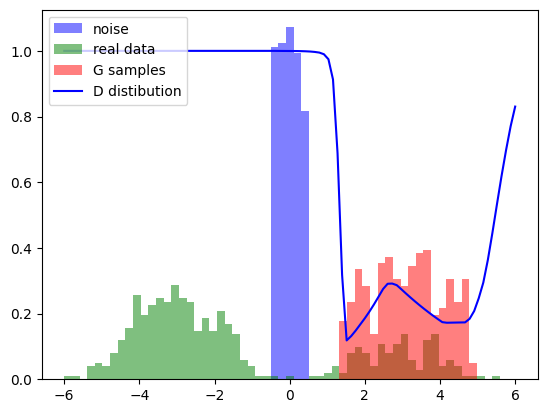

D train step 4


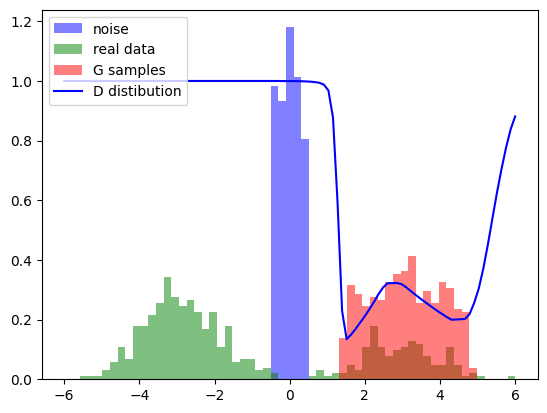

G train step


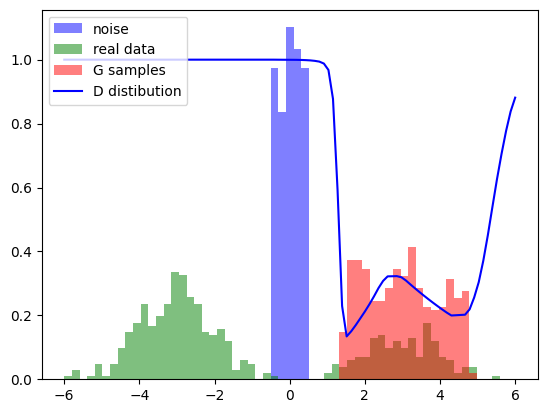

80
D train step 0


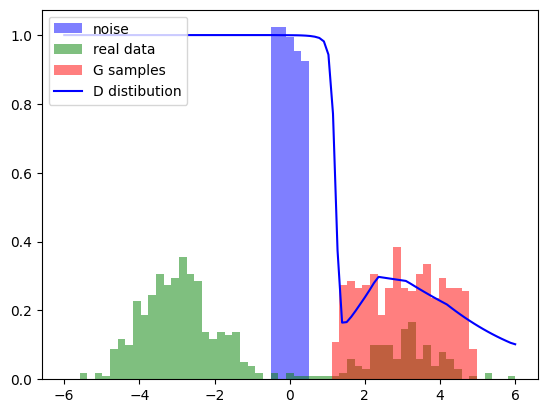

D train step 4


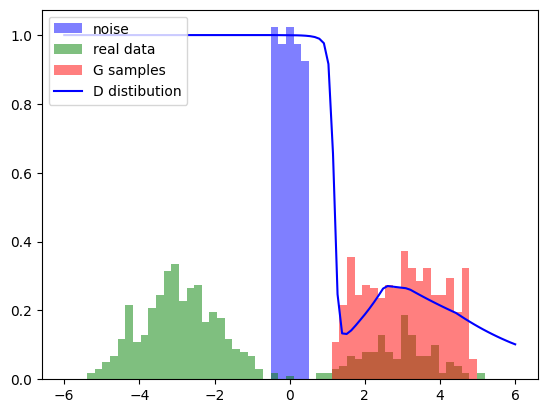

G train step


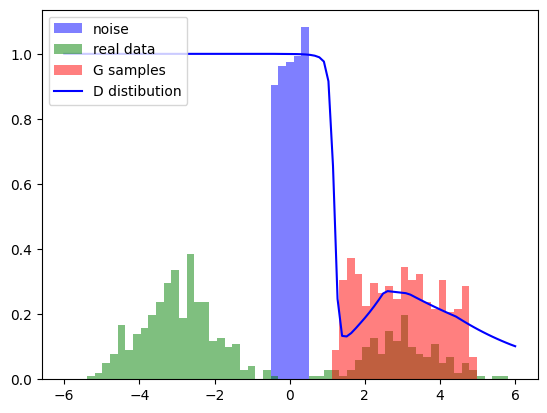

Epoch 4/20 (45s): G=-0.253, Dr=0.425, Df=0.255


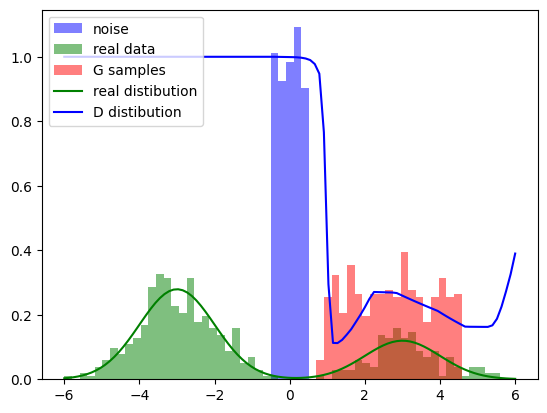

0
D train step 0


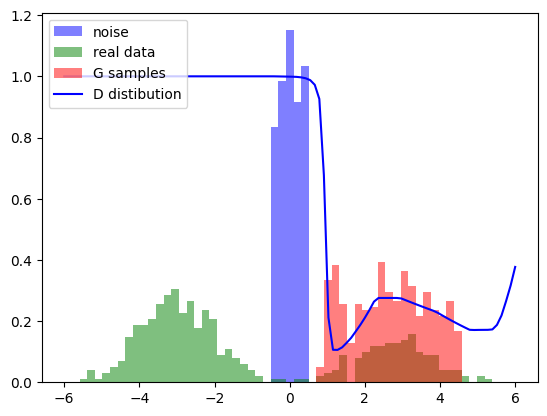

D train step 4


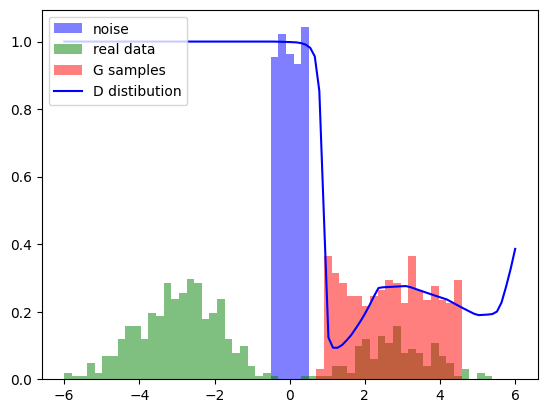

G train step


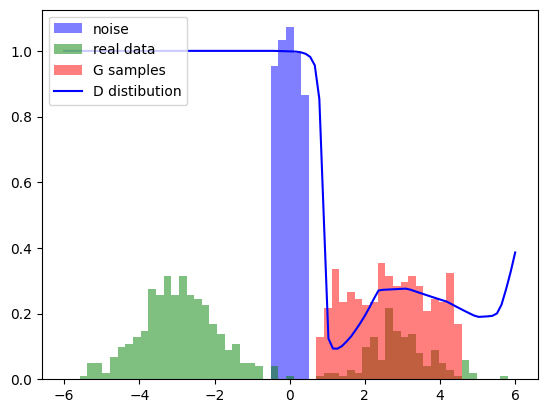

20
D train step 0


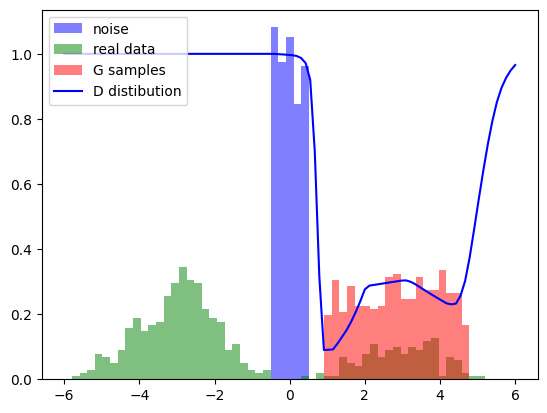

D train step 4


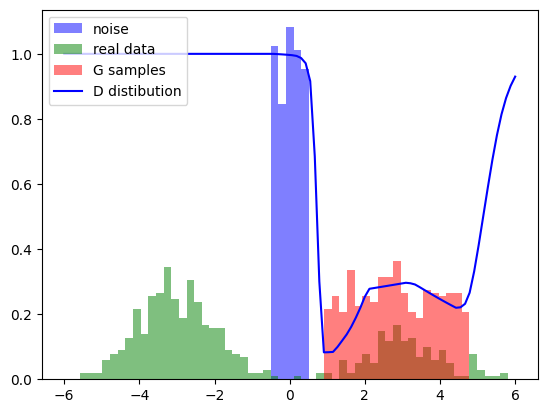

G train step


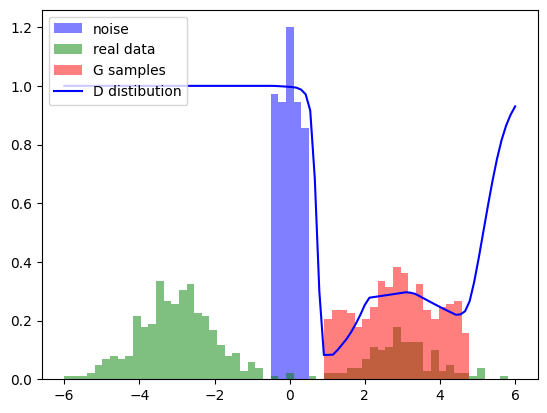

40
D train step 0


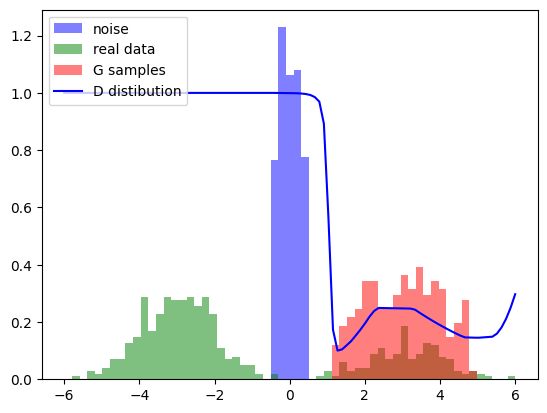

D train step 4


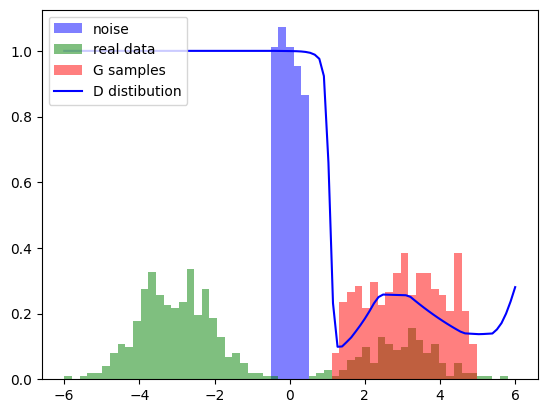

G train step


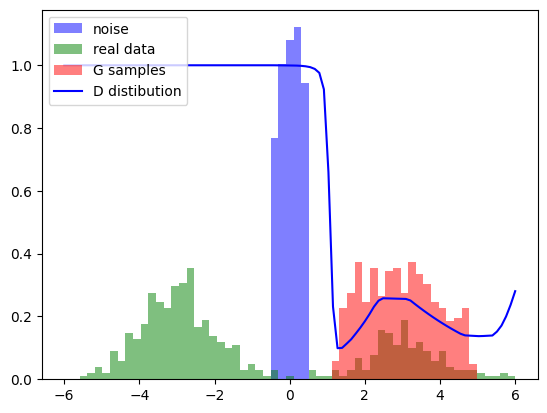

60
D train step 0


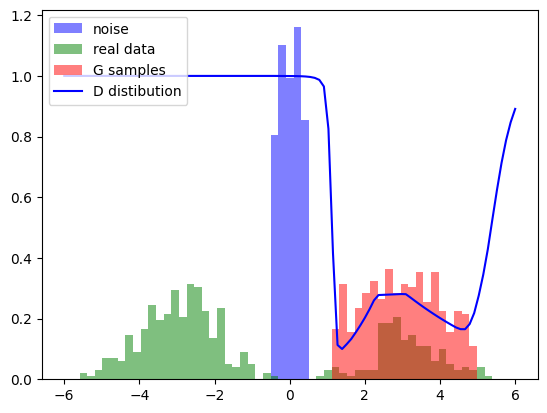

D train step 4


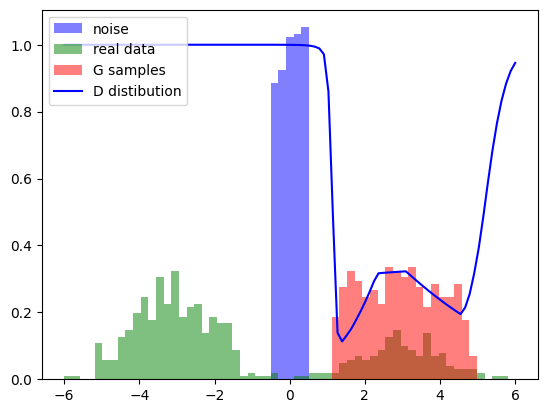

G train step


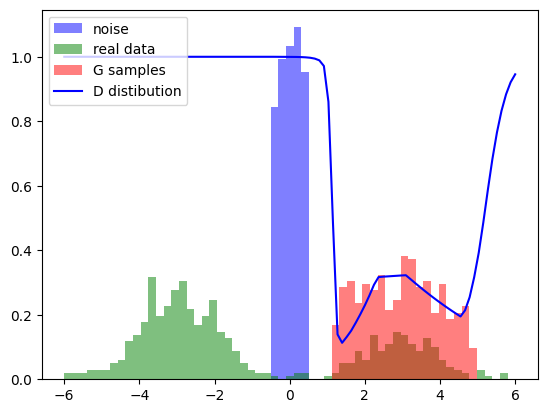

80
D train step 0


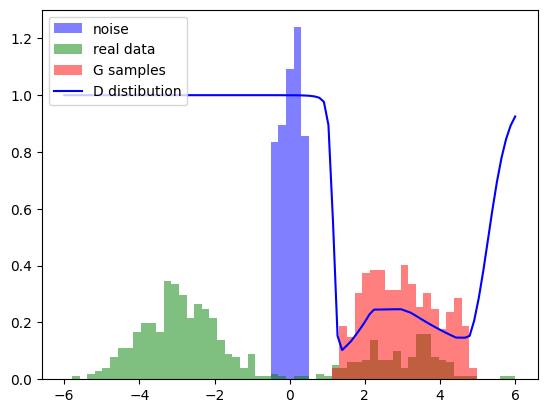

D train step 4


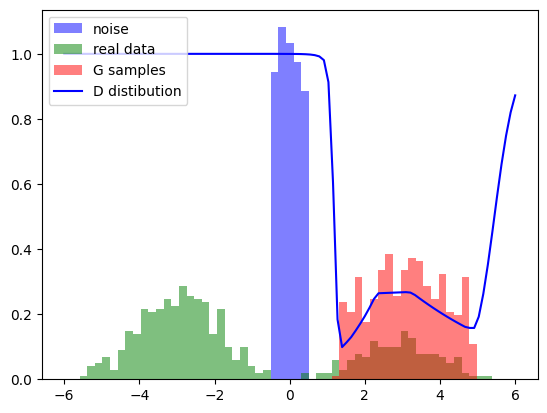

G train step


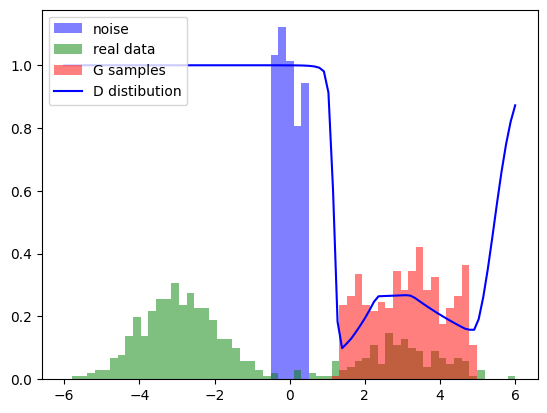

Epoch 5/20 (56s): G=-0.260, Dr=0.427, Df=0.260


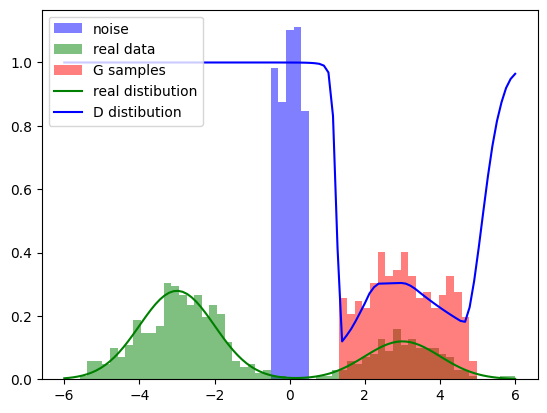

0
D train step 0


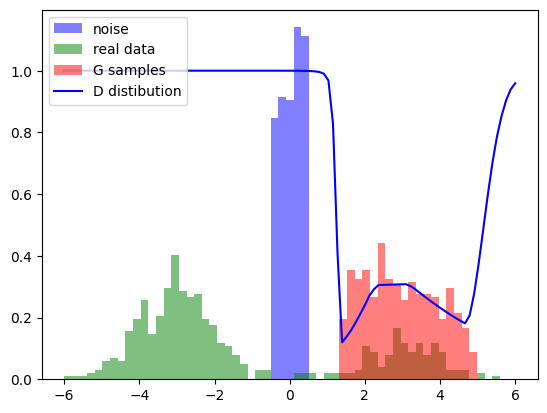

D train step 4


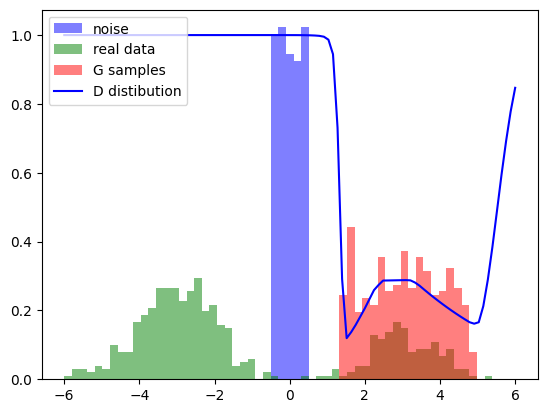

G train step


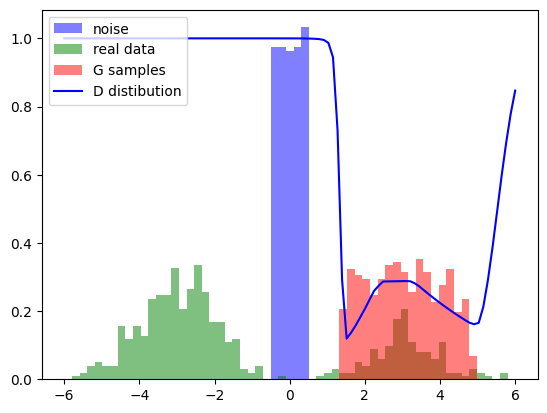

20
D train step 0


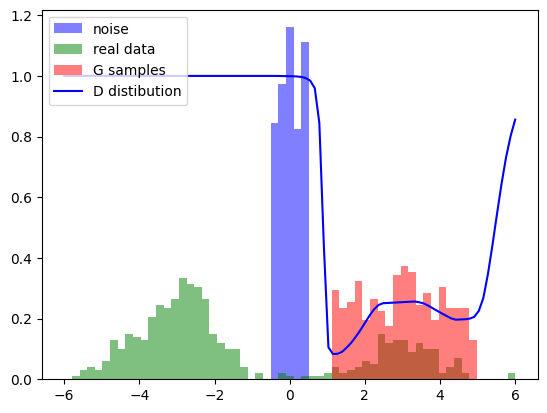

D train step 4


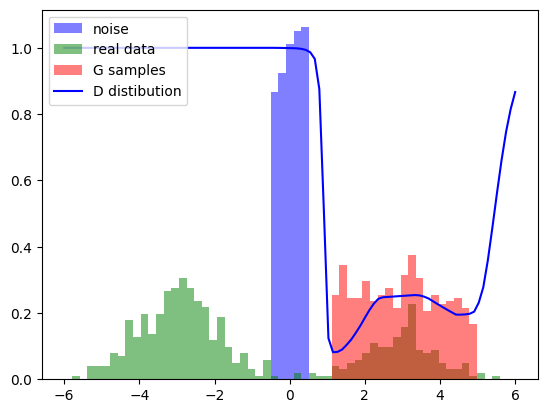

G train step


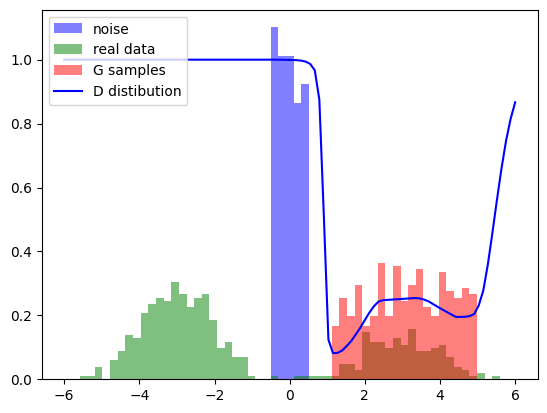

40
D train step 0


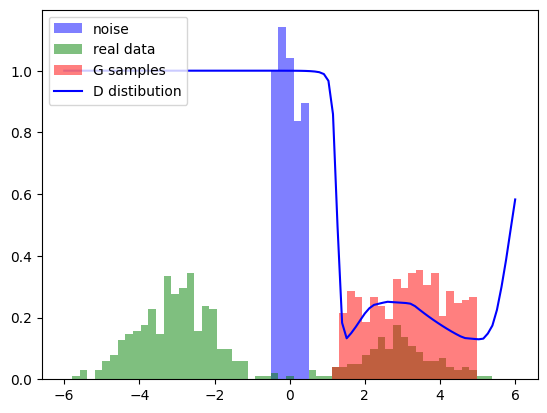

D train step 4


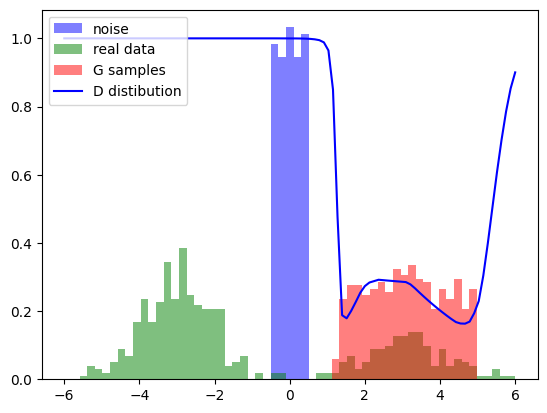

G train step


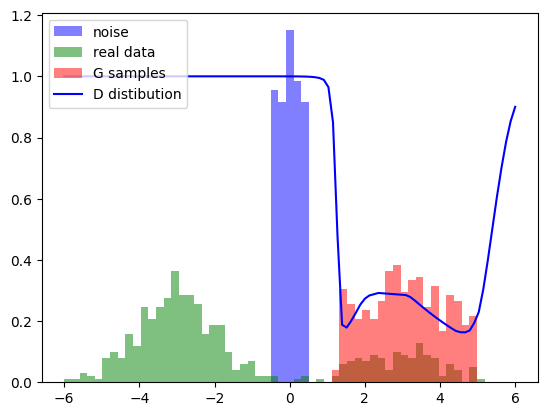

60
D train step 0


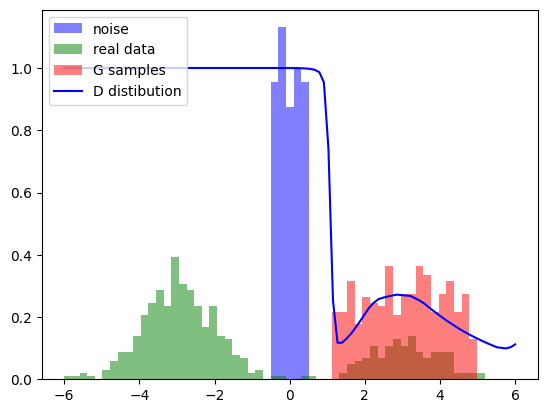

D train step 4


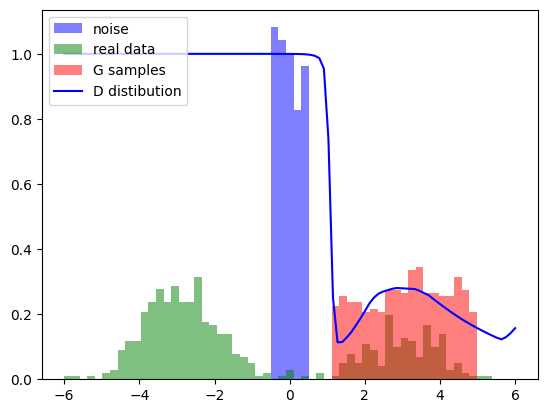

G train step


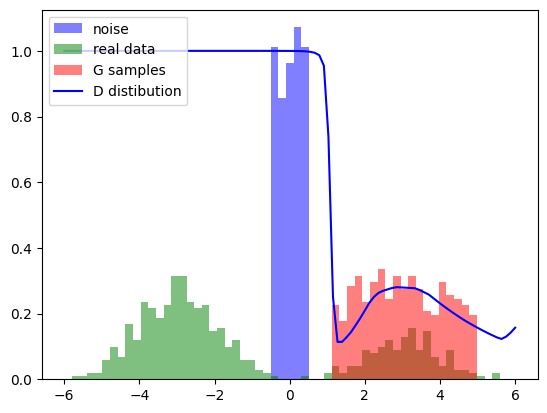

80
D train step 0


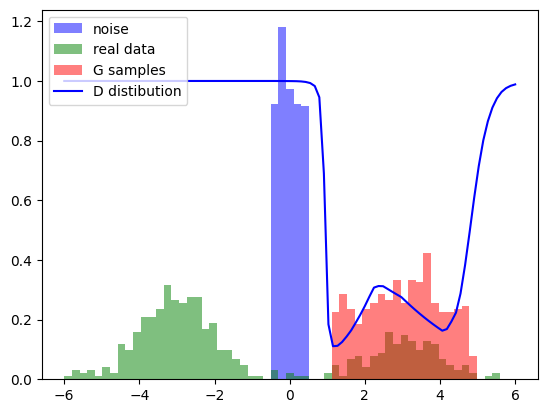

D train step 4


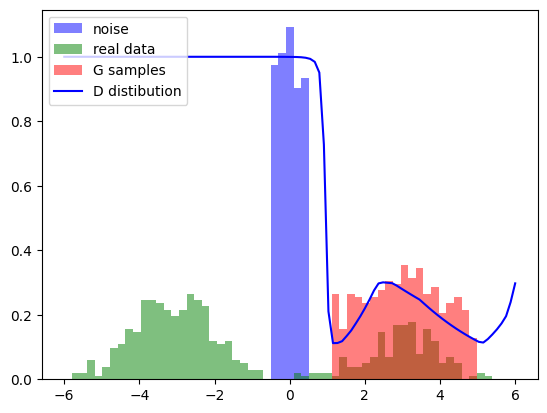

G train step


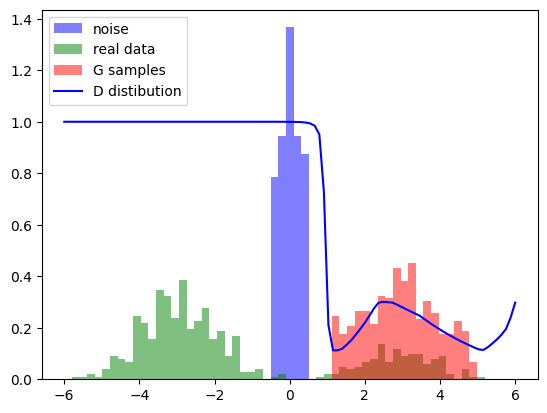

Epoch 6/20 (67s): G=-0.252, Dr=0.423, Df=0.253


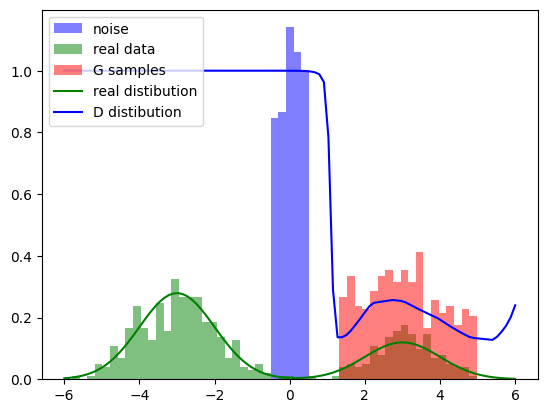

0
D train step 0


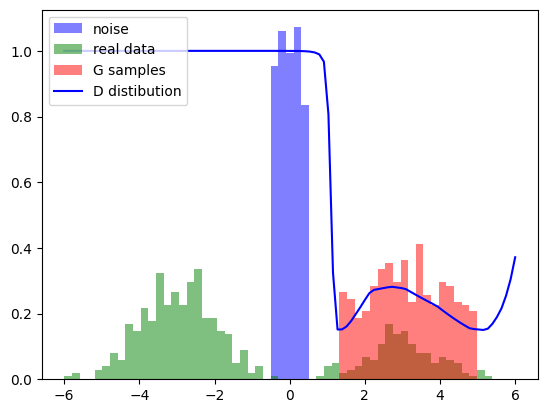

D train step 4


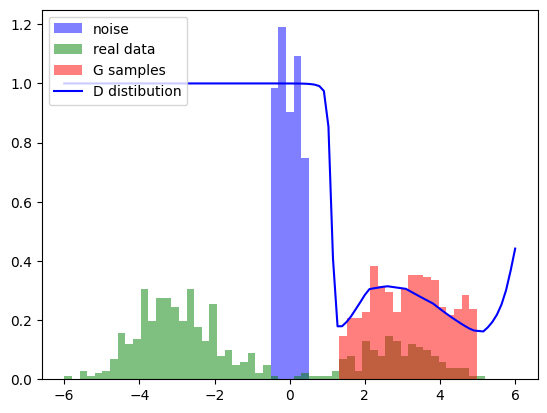

G train step


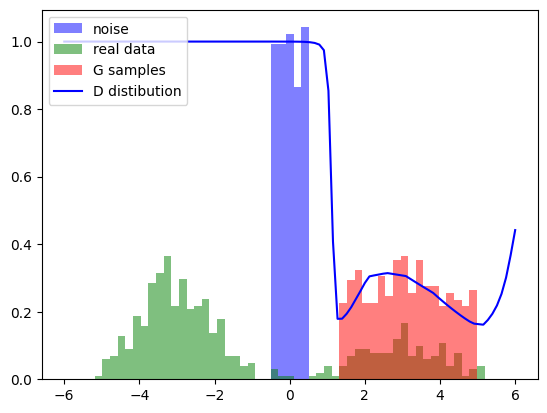

20
D train step 0


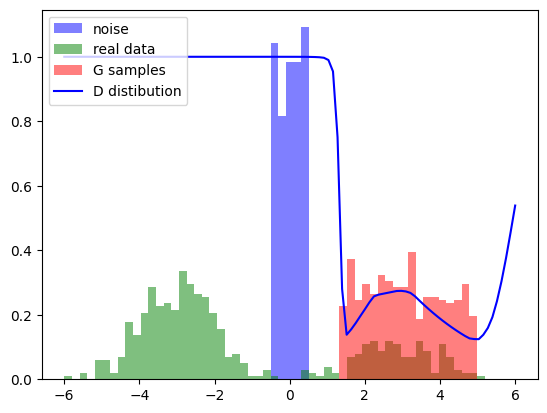

D train step 4


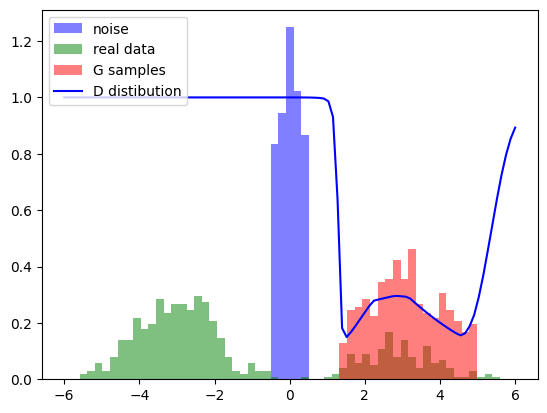

G train step


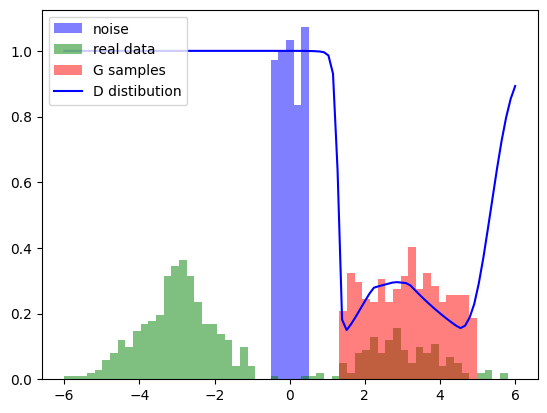

40
D train step 0


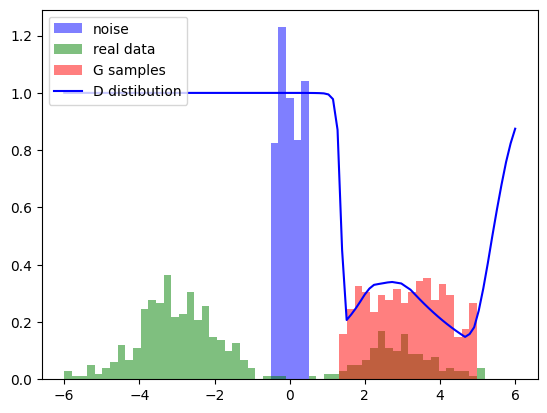

D train step 4


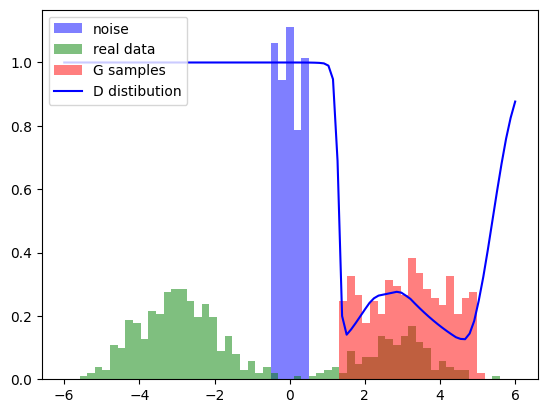

G train step


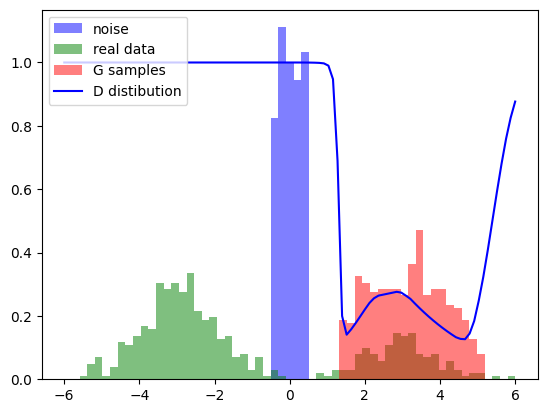

60
D train step 0


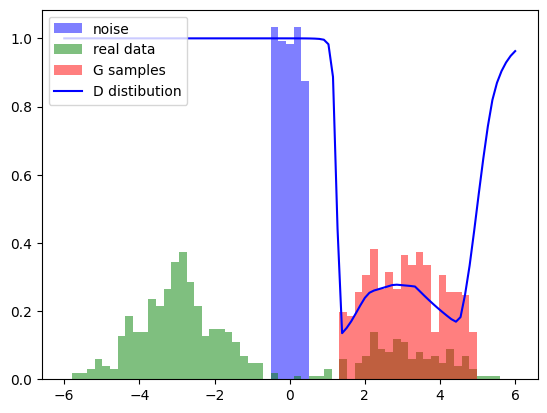

D train step 4


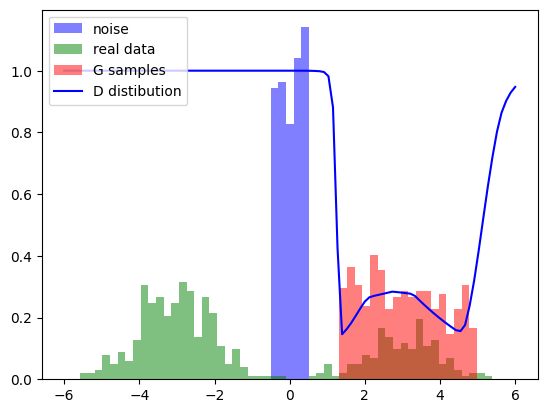

G train step


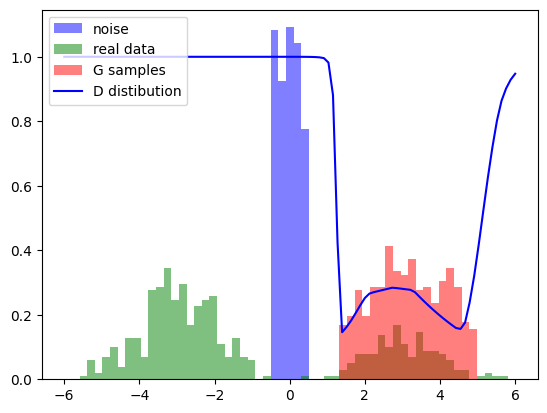

80
D train step 0


KeyboardInterrupt: 

In [11]:
step_size = 20
n_D_steps_per_G = 5
epochs = 20
batches = 100

loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    # break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i, batch in enumerate(range(batches)):
        #lg_, (ldr_, ldf_) = gan.train_step()
        
        for k_D_step in range(n_D_steps_per_G):
            ldr_, ldf_ = gan.train_step_D()
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
        
            if k_D_step == 0 and i%step_size == 0:
                print(i)
                print('D train step 0')
                visualize_GAN(gan)

            elif k_D_step == n_D_steps_per_G - 1 and i%step_size == 0:
                print(f'D train step {n_D_steps_per_G - 1}')
                visualize_GAN(gan)

        lg_ = gan.train_step_G()
        if i%step_size == 0:
            print('G train step')
            visualize_GAN(gan)

        loss_g_running += lg_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / (batches * n_D_steps_per_G))
    loss_d_fake.append(loss_d_fake_running / (batches * n_D_steps_per_G))
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

Epoch 1/20 (0s): G=-0.282, Dr=0.402, Df=0.405


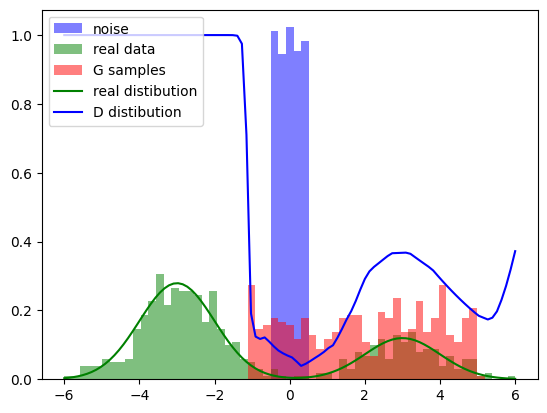

Epoch 2/20 (2s): G=-0.288, Dr=0.430, Df=0.292


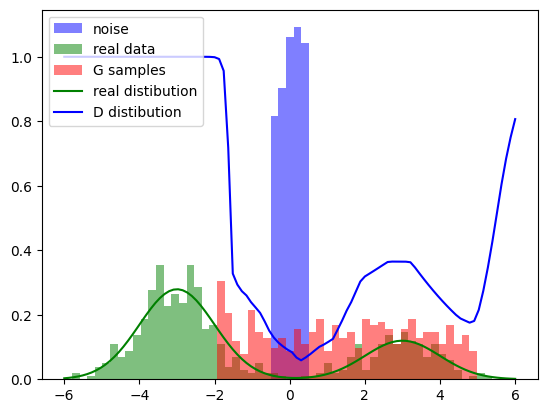

Epoch 3/20 (3s): G=-0.457, Dr=0.551, Df=0.476


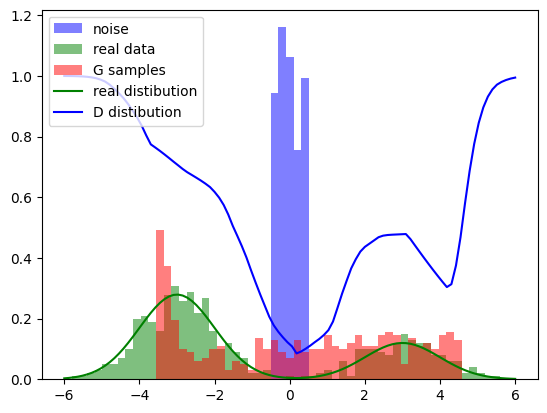

Epoch 4/20 (4s): G=-0.619, Dr=0.631, Df=0.625


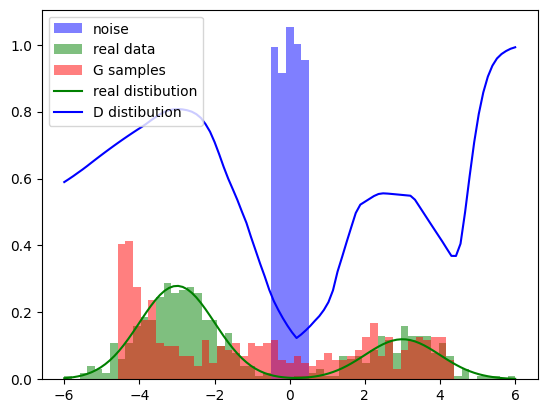

Epoch 5/20 (5s): G=-0.630, Dr=0.633, Df=0.635


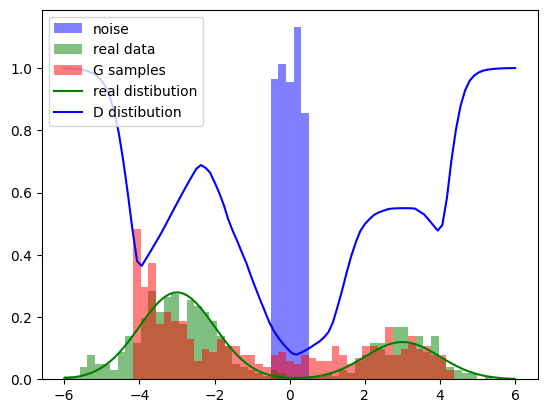

Epoch 6/20 (6s): G=-0.654, Dr=0.641, Df=0.657


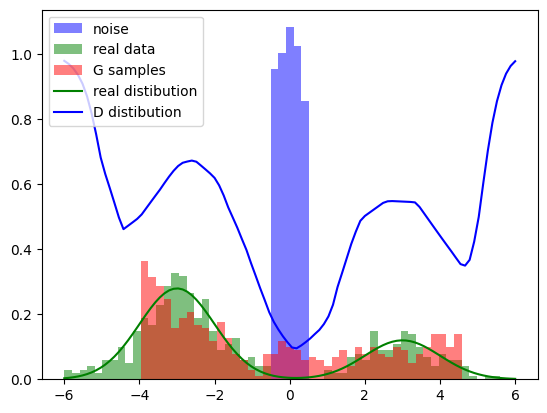

Epoch 7/20 (7s): G=-0.646, Dr=0.649, Df=0.655


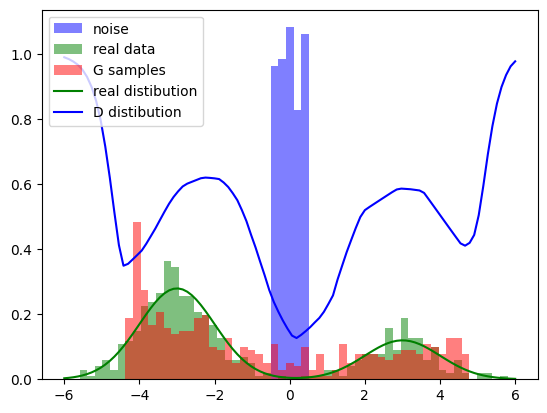

Epoch 8/20 (9s): G=-0.659, Dr=0.660, Df=0.665


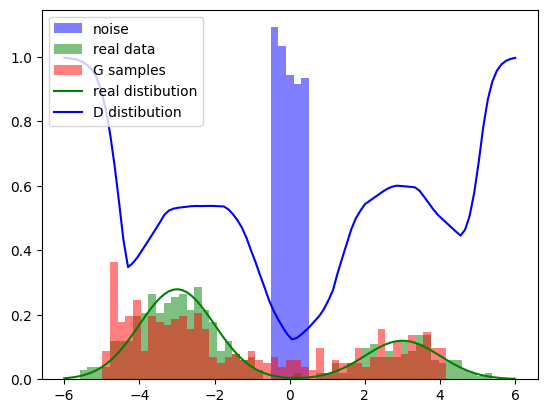

Epoch 9/20 (10s): G=-0.661, Dr=0.660, Df=0.667


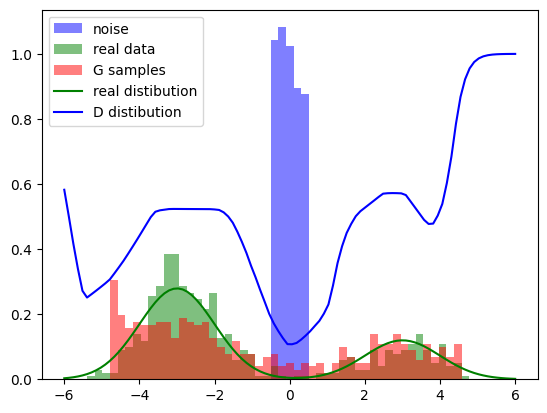

Epoch 10/20 (12s): G=-0.666, Dr=0.658, Df=0.666


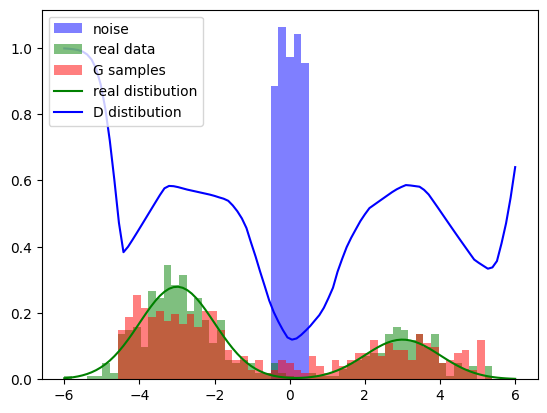

Epoch 11/20 (13s): G=-0.661, Dr=0.668, Df=0.674


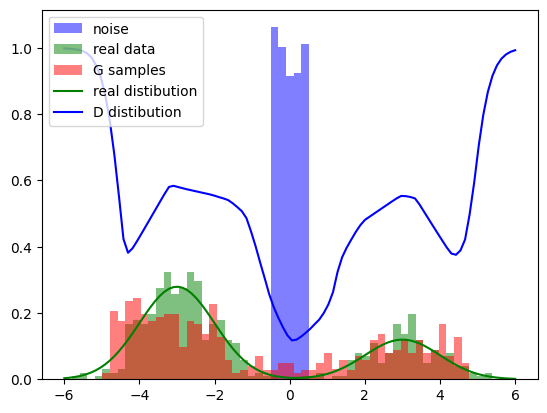

Epoch 12/20 (14s): G=-0.660, Dr=0.658, Df=0.667


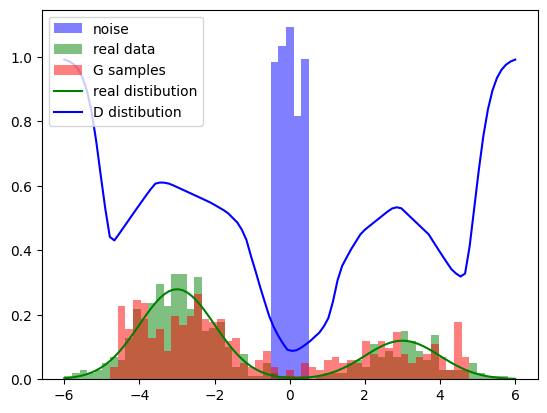

Epoch 13/20 (15s): G=-0.673, Dr=0.672, Df=0.675


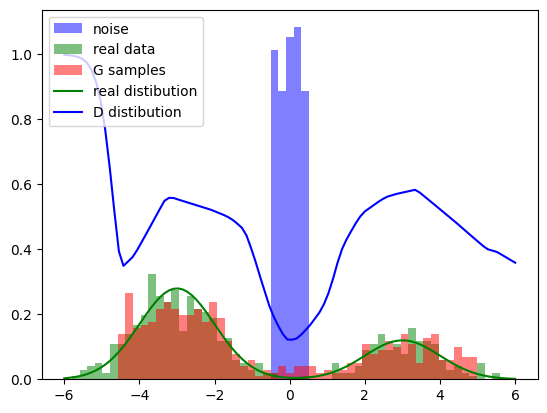

Epoch 14/20 (17s): G=-0.672, Dr=0.671, Df=0.674


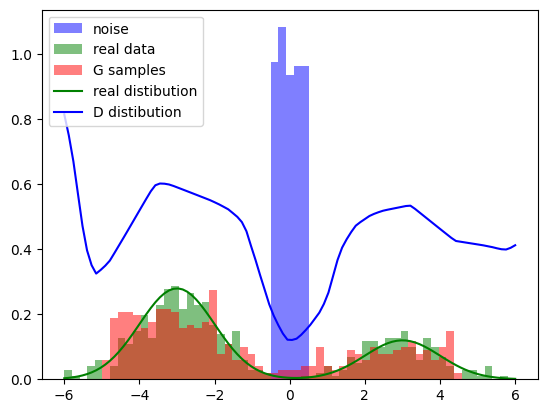

Epoch 15/20 (18s): G=-0.678, Dr=0.674, Df=0.668


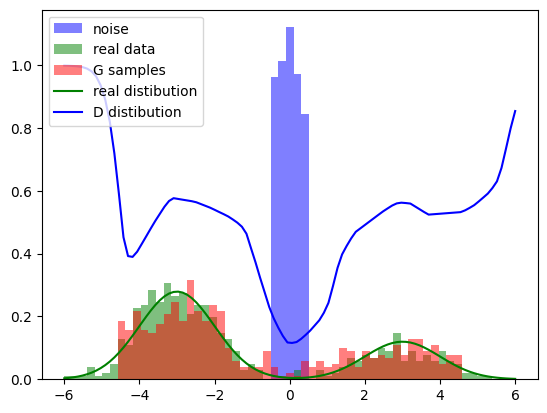

Epoch 16/20 (19s): G=-0.674, Dr=0.668, Df=0.676


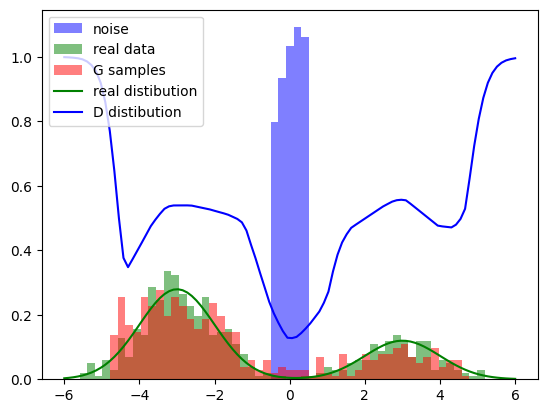

Epoch 17/20 (20s): G=-0.676, Dr=0.669, Df=0.677


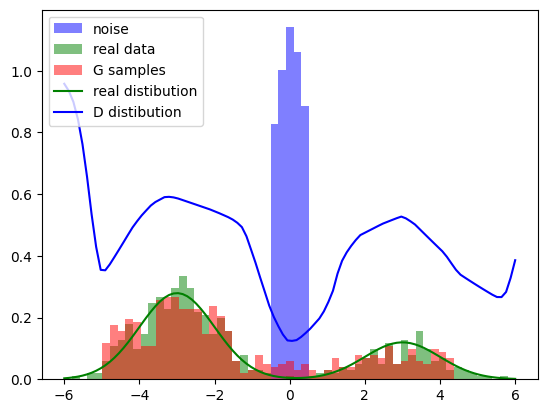

Epoch 18/20 (22s): G=-0.670, Dr=0.679, Df=0.678


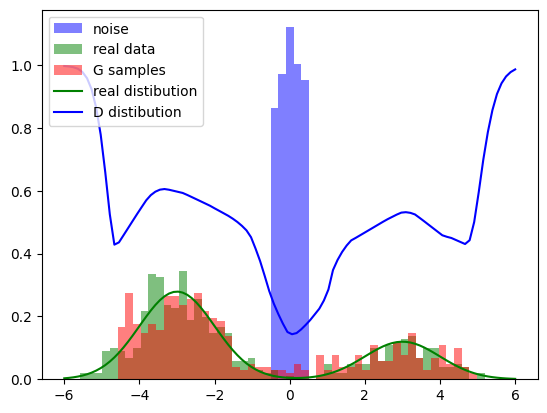

Epoch 19/20 (23s): G=-0.670, Dr=0.674, Df=0.681


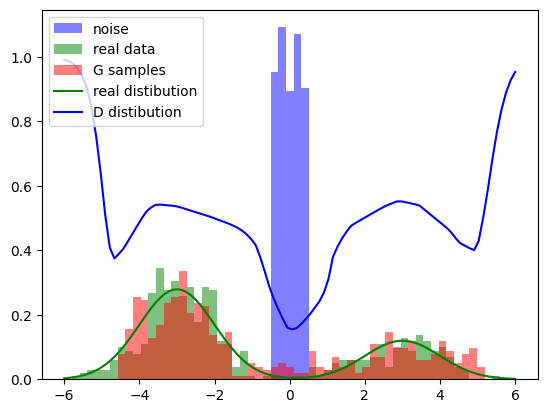

Epoch 20/20 (24s): G=-0.675, Dr=0.673, Df=0.675


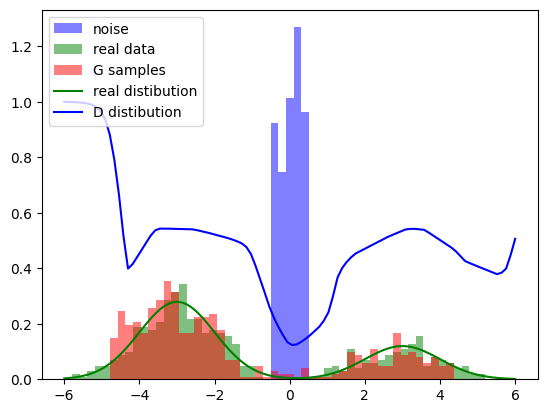

In [12]:
start = time()
for epoch in range(epochs):
    # break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

#### 2D data

In [13]:
def generate_2d_data(size, var=0.02):
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]

    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []

    for i in range(size):
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)

    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev

    return dataset

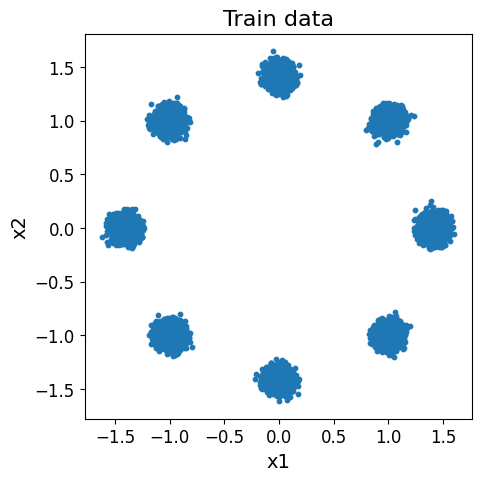

In [14]:
reset_seed()
COUNT = 20000

train_data = generate_2d_data(COUNT, var=0.08) # 0.02, 0.1, 0.4
visualize_2d_samples(train_data, "Train data")

In [15]:
from seminar6_utils import make_inference, visualize_GAN_output

def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [16]:
from seminar6_utils import FullyConnectedMLP

class MLPGenerator(FullyConnectedMLP):
    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)


class MLPDiscriminator(FullyConnectedMLP):
    def __init__(self, input_dim, hiddens, output_dim):
        super().__init__(input_dim, hiddens, output_dim)
        self._criterion = nn.BCELoss()

    def forward(self, z):
        x = super().forward(z)
        return F.sigmoid(x)

    def criterion(self, x, gt='fake'):
        assert gt in ['fake', 'real']
        tensor_gt = torch.zeros_like(x) if gt == 'fake' else torch.ones_like(x)
        return self._criterion(x, tensor_gt)

In [18]:
def train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps, 
    batch_size,
    n_epochs,
    lr,
    visualize_steps=10):

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

    generator.train()
    discriminator.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, real_data) in enumerate(train_loader):
            curr_iter += 1
            real_data = real_data.to(DEVICE)

            # DISCRIMINATOR UPDATE
            with torch.no_grad():
                fake_data = generator.sample(real_data.shape[0])

            pred_real = discriminator(real_data)
            loss_real = discriminator.criterion(pred_real, 'real')
            pred_fake = discriminator(fake_data)
            loss_fake = discriminator.criterion(pred_fake, 'fake')

            discriminator_optimizer.zero_grad()
            d_loss = (loss_real + loss_fake) / 2.
            d_loss.backward()
            discriminator_optimizer.step()

            # GENERATOR UPDATE
            if curr_iter % discriminator_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                pred_fake = discriminator(fake_data).mean()

                g_loss = -discriminator.criterion(pred_fake, 'fake')
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
            visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

    return batch_loss_history

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


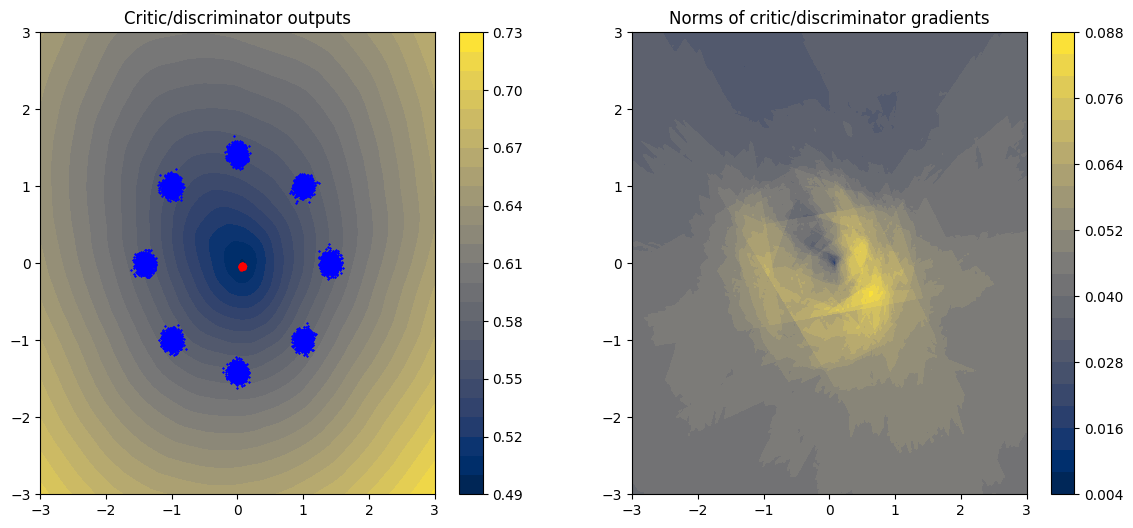

Epoch 20


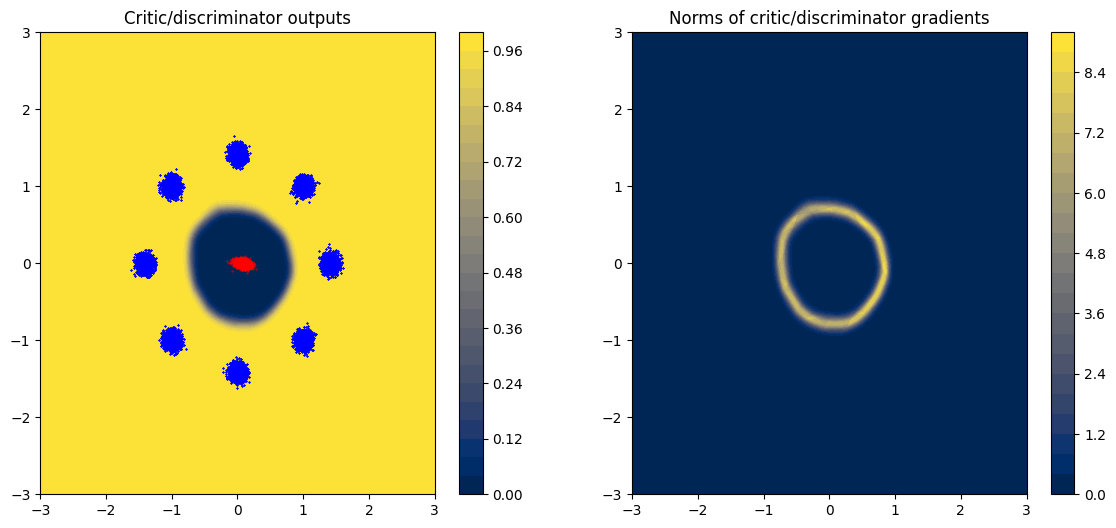

Epoch 40


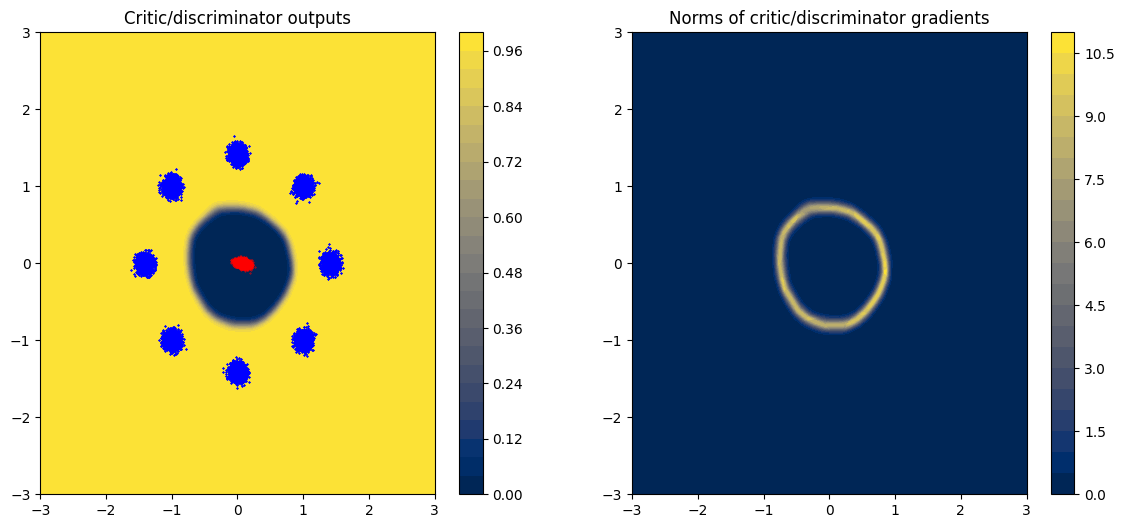

Epoch 60


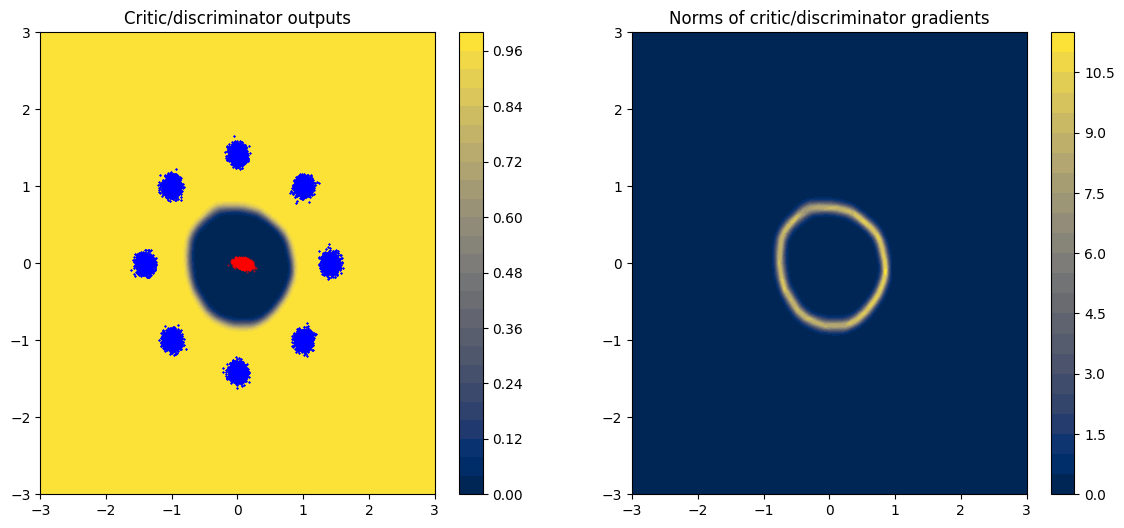

Epoch 80


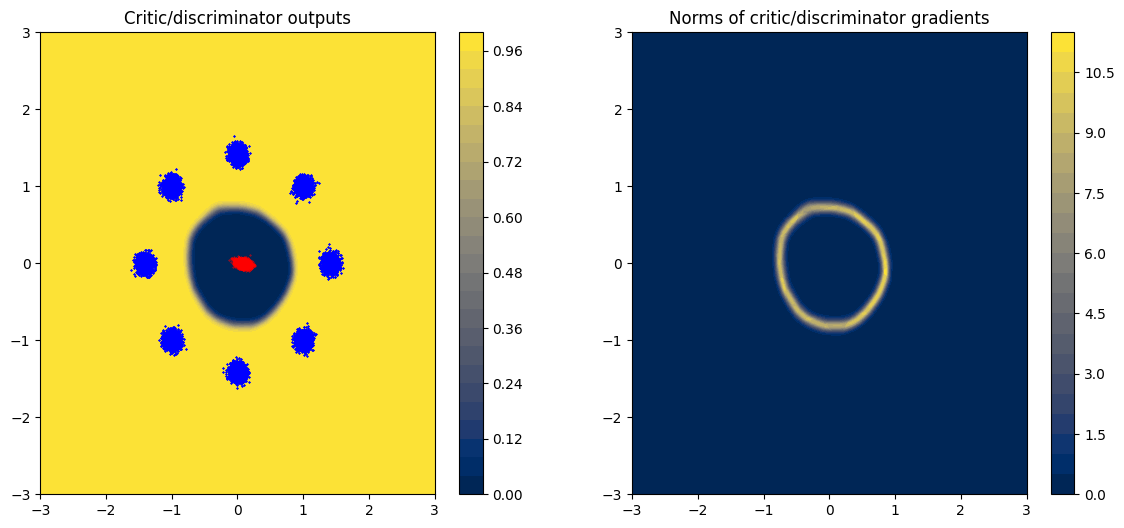

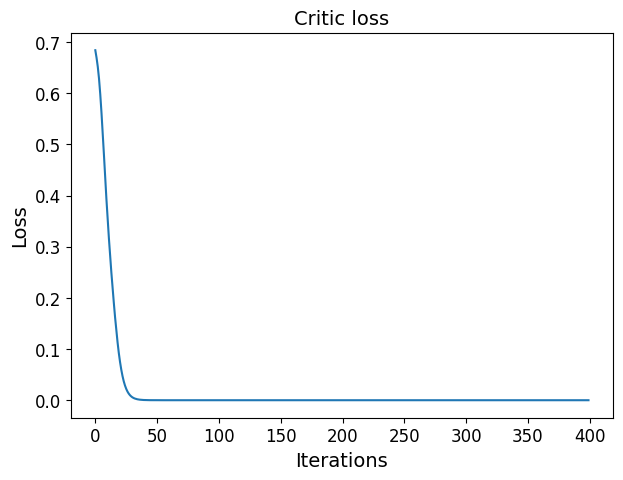

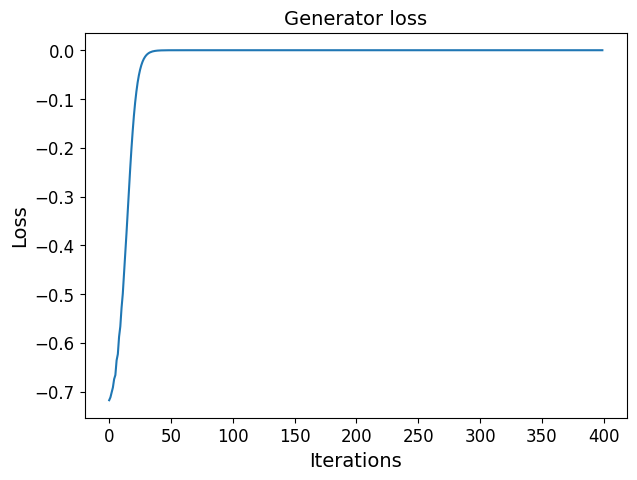

In [19]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # take 1/2
LR = 2e-4 # < 1e-2

N_EPOCHS = 100 # change it if you want

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
discriminator = MLPDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=20
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

### Non-Saturating GAN: Solving the Gradient Problem

#### Idea

Replace
$$
\min_G \log(1 - D(G(z)))
\quad \rightarrow \quad
\max_G \log D(G(z))
$$
Essentially, this flips the sign of the binary classification objective:
 > The generator now **maximizes the probability of being classified as real** instead of minimizing the probability of being classified as fake.

#### Effect

When $D(G(z)) \to 0$:

* In NS-GAN, the gradient term $-\frac{1}{D(G(z))}$ becomes large,
  while in the original GAN, $-\frac{1}{1 - D(G(z))} \approx 0$.
  
  → The generator receives a stronger and more informative gradient,
  even when the discriminator is confident that samples are fake.


In [20]:
class MLPDiscriminator(FullyConnectedMLP):
    pass

In [21]:
def train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps, 
    batch_size,
    n_epochs,
    lr,
    visualize_steps=10):

    # \beta_1 = 0 !!!
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

    generator.train()
    discriminator.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, real_data) in enumerate(train_loader):
            curr_iter += 1
            real_data = real_data.to(DEVICE)

            # DISCRIMINATOR UPDATE
            with torch.no_grad():
                fake_data = generator.sample(real_data.shape[0])
            
            #YOUR CODE
            real_predict = F.softplus(-discriminator(real_data)).mean()
            fake_predict = F.softplus(discriminator(fake_data)).mean()

            discriminator_optimizer.zero_grad()
            d_loss = real_predict + fake_predict
            d_loss.backward()
            discriminator_optimizer.step()

            # GENERATOR UPDATE
            if curr_iter % discriminator_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                fake_scores = discriminator(fake_data)

                # implements Non-saturating GAN loss
                g_loss = F.softplus(-fake_scores).mean()
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
            visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

    return batch_loss_history

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


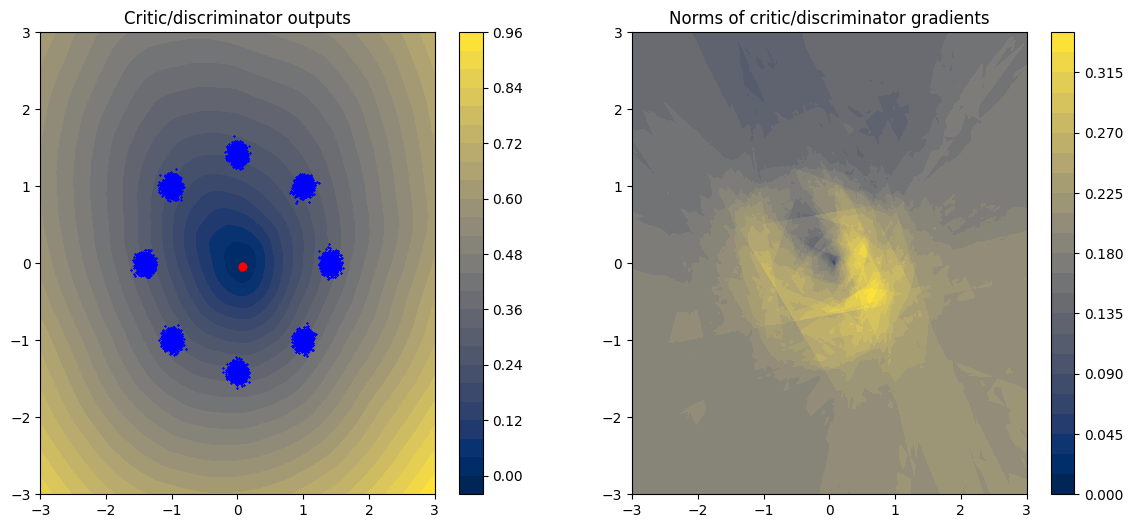

Epoch 20


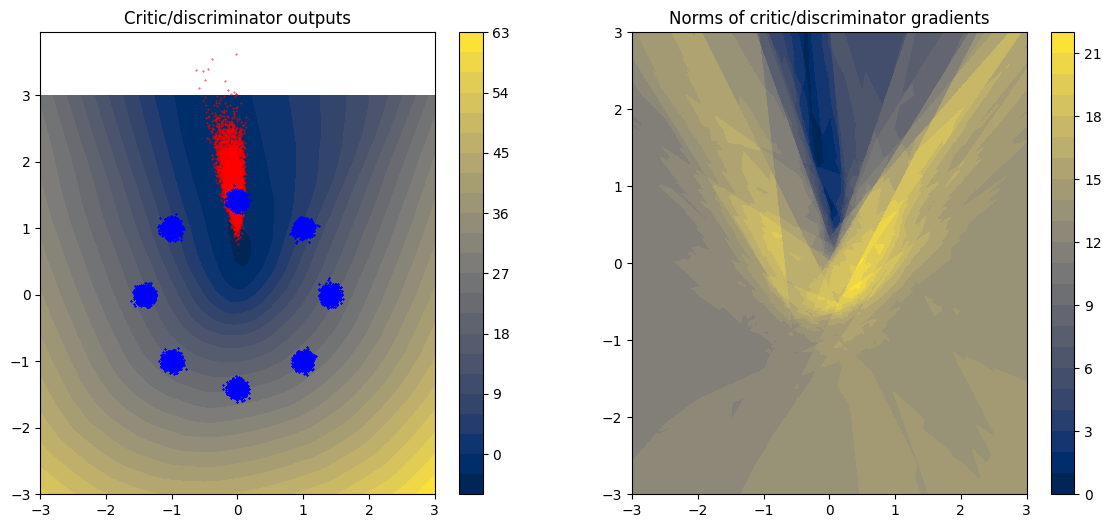

Epoch 40


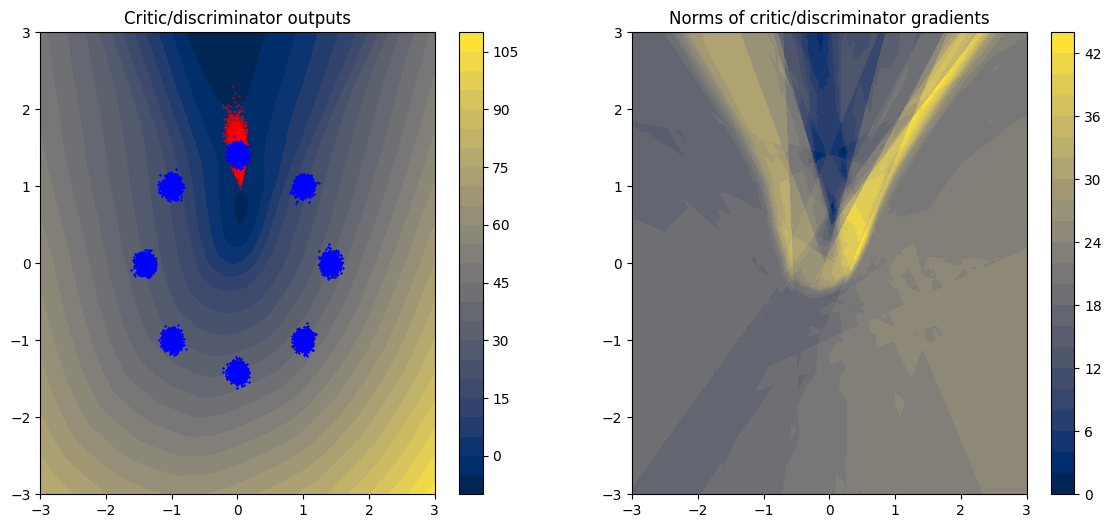

Epoch 60


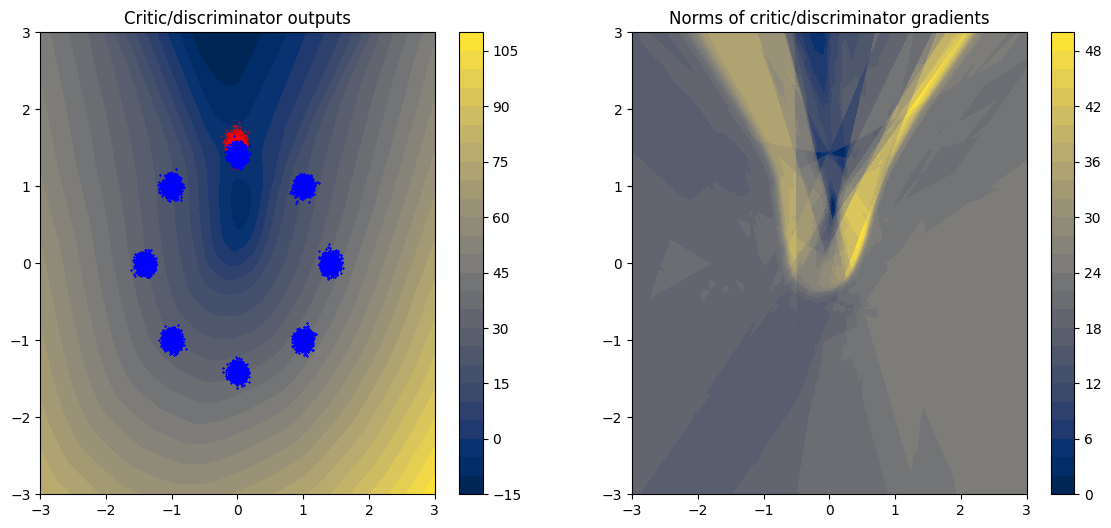

Epoch 80


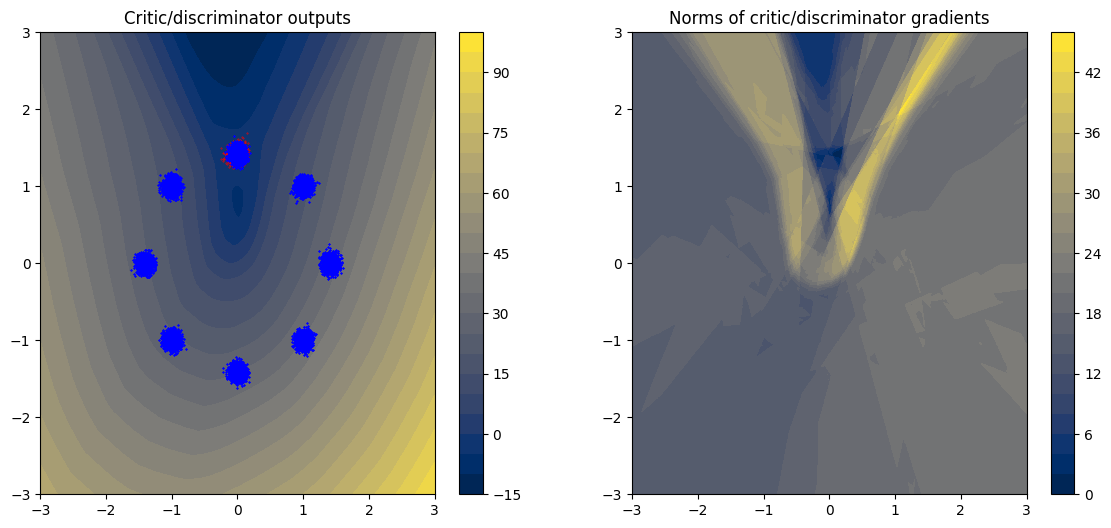

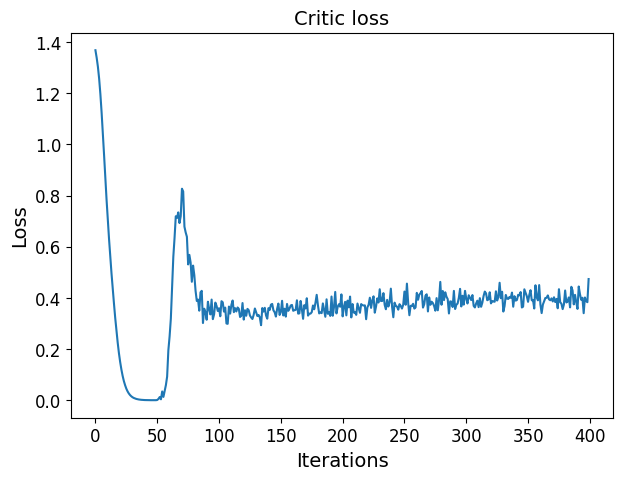

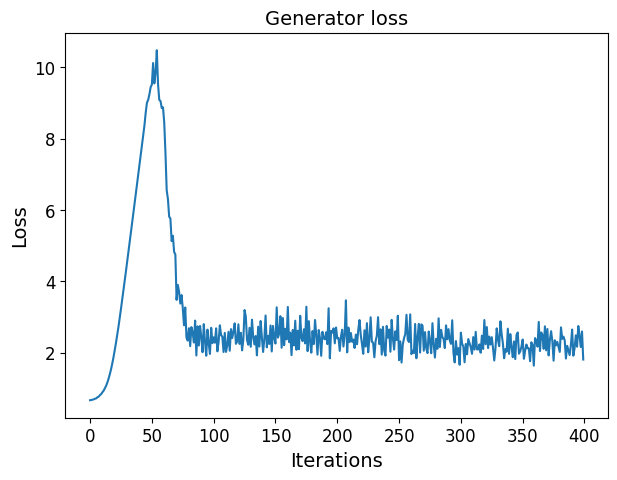

In [22]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING), NO LEARNING (NOT SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # take 1/2
LR = 2e-4 # < 1e-2

N_EPOCHS = 100 # change it if you want

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
discriminator = MLPDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=20
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

In [ ]:
samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

### WGAN: Solving Gradient Vanishing and Mode Collapse

<center>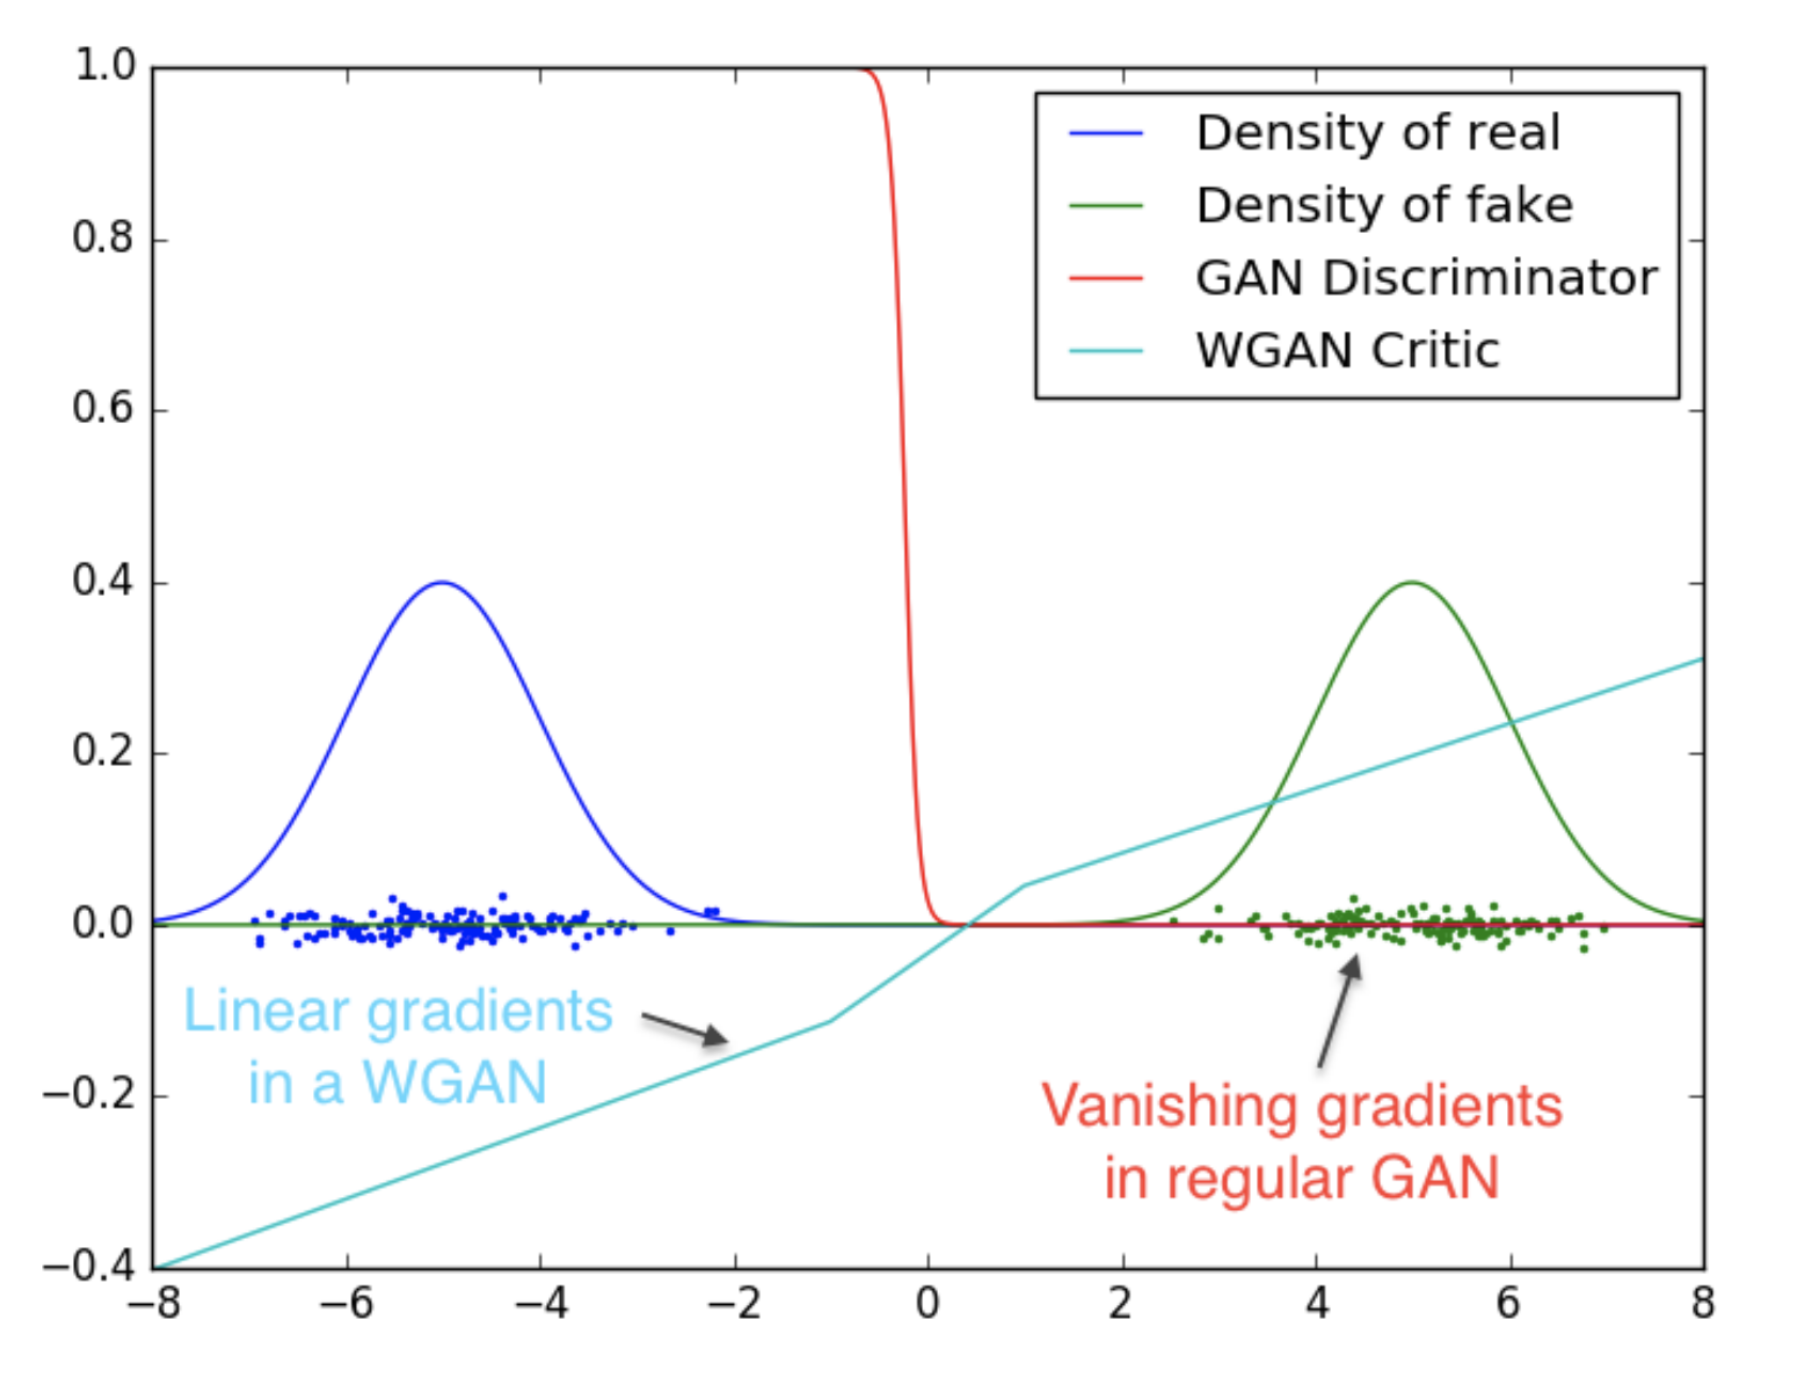 </center>

[WGAN](https://arxiv.org/abs/1701.07875) replaces the JS-divergence objective of classical GANs with the Wasserstein distance, which behaves smoothly even when the real and generated distributions do not overlap. This directly fixes gradient vanishing and reduces mode collapse, since the loss now provides a meaningful direction for the generator to move toward the real data distribution.

#### Idea

The goal is to minimize the Wasserstein (Earth Mover’s) distance:

$$ \min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi}) - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right]. $$

where $f_\phi$ (the critic) is constrained to be 1-Lipschitz — ensuring smooth, stable gradients. Originally, this constraint was enforced by weight clipping $\phi \in [-c, c]^d$.


#### Why It Works

* Wasserstein distance remains finite and differentiable even for disjoint supports, unlike JS divergence.
* The loss value directly measures how far the two distributions are - smaller loss $\rightarrow$ closer distributions.
* Gradients stay informative everywhere $\rightarrow$ no saturation, no gradient vanishing.
* Training becomes stable and correlates with visual improvement, even if samples look poor early on.



<img src="data:image/png;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAcFBQYFBAcGBgYIBwcICxILCwoKCxYPEA0SGhYbGhkWGRgcICgiHB4mHhgZIzAkJiorLS4tGyIyNTEsNSgsLSz/2wBDAQcICAsJCxULCxUsHRkdLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCz/wgARCAMEBQADASIAAhEBAxEB/8QAGwABAAMBAQEBAAAAAAAAAAAAAAQFBgMCAQf/xAAVAQEBAAAAAAAAAAAAAAAAAAAAAf/aAAwDAQACEAMQAAAB/SAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgE9jRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY0bJjRsmNGyY36bEACtn/iB+5Qeng52OC1JaKOzJKhuTqpuxzt8DPNdTV8A2nXNXhJUwuVd6J58Pnz812Rd8O4o5GR0JYxKyyLmkoNsVtzkdcceVTTG0rrf84N/X/PJdgFSWzhxJquFigzgrvBaI8ItXCGWaFHLVz4EtDExB8Fi4RyNcYnbB8qiwh2WPNggxi3RuROV3o7Sc1ENdVzMsbNA8lirOhPcuoArbH8nP1mntsgX0+jsCwIZMQuZYq74WSrtAqpZKjQ640yFxLNB9ktF8E1W/CzZW5LFA6EuNJzRpVf4LN8+jnkdSRLTE6kmo/AnkQlqqwOqvkEhV+iyKgt0OOWhHJCH4J6v6ktVWZ5r/tCbEA4mZoLHYmI2n5ruCgrLbPEvzJuTS/n2h8mW22W/RD83s4OiWTSfOiT83oqMr9VQ3pCqrunP0oGJu85aGqBhra1pih11Fsz86/RaPgRtPjNSUWf1tYbOm8wSj1U+rNAzOmMpfxYZWerOER+fKYaCy4dzE6fNWZWQr2IQtFF5kG18QiL1n8yL8k9iBwt45w729URNvg92V2VvohNq/nw5fI1oRpHXmQ9BU6MzHzzYGixOgozp889Cw5evBE2WOtC9BR0UnVFBErrAsbCnsi2/PP0PJnmPdwT1X/PRpsJqfJE7/LAy83p2LOrlRitlfORGsutgZ2V49n3U0HYo7nhLNBjdljTtNgyho81pTFbLNTjPSfHwjTpEwvayzryoq+0wi8vcY62VZOKi9kcyHGtvBo+fX4ZDn0inHncfD1SX/ck0NjVm4AAOJ2fPpzyuuGS0/YHHqfQESWADidnz6AAAHDuAAAAAAAV9gAAAAGX0PcAAVHm5AAAAAAD59Gb9aIAAAAAAAAAAAAAMtqRw7gAAAAAAAAAAAAAArLMUV6AGR1noAAAAAAAADiVUOj0RYWOR5Gx9fn1ma4xh20WSlGs5Y3uRdzkOBuWPiG6zNVeE3jHpTdnA7sHYGq9YSaRdxj4ZvGQ8mv8AWGrz9G94fcBAojWMJtDuj05oGfmFpktbhTvssloyvjVm0Mv4y28K7jU3p85xhJ9RNCVmrxWzPQDGTDTlMXLPjQV83Mnz3b5Y3ON2WGJV5mdqZbW4/YA+H1+cTDdslbFuUZeM+NBX2GLO9lB4kqTAnl4Aps6btjtiAFdIJKusQArIRoGftyT+e/oWfJVtkNeAAAAAAAAAAAAAAAAAAAAAAAYKVsxmKffjGaCzDG7IYbrtBm/ehGKjb4fndnsR+dW2vFFl/wBFAGLvbcYPh+hj8/stcMN92/0zsLXjCbsM990A/Ov0P0I9PoBn5loGO2IxV1c+jOfNJ5Mh61/kx/naeTIeNp8MX2130weiuIx9lR5BiNDbBTXIz7QDxX2YynzVeihqNr8MZobL6YLRXcAk9uXUx7YDJW1uFHeDP/b8KS7GVh7T0YSTshndFV2hn5NuMFaamhIvSRMKiBccT58keztawJ5WQtAM/byR4x208mLuL4AAAAAAAAAAAAAAAAAAAAAAI8gUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhSroUq6FKuhS/bkAOPYYiwxP6iQbr8h/Vzuy9sWTMeDVKX6XOZ8wzXdqaoNgp681CrgGjAQe53AfKQvECeAeWYmHLRYu1L9wpTQvHsornOXBPZ6wLFQ2JNZSWaD5RWBGt6KOaVSSywZ+yJxTFyzc8tfFZnjboEQuldYgA5nRn7w6A8/cpZEfRYq2L9HpjQvPoINceLCgti17VdeaRV1ppq2H7LXtVwTRKzwWzMaU9GaNKoLQlqC0JbKWhbqSQWag+l8qha+KzMm8RKsv1VUmrcO4AeaA0Ki8l+8+gcT3AymrPVhi9IWCm7llx7Cku8DqS1VnItfeJ0xYcqz2R73BaYtwFT8PlxQ+i8Ugu1dYgA4n5PtanXmJlfLwgV1rZGWj3WSN7C0OdKCf9sSwzd7HKuXq84eZkmoNiDl7rZZJBjtTB8mO/Sct7NM5dTNWXWtKqT79lNo3gl2kaSZim0PQ+UN1wKjV1ohSO/skQu/Ihcp3E5fZEQ9bLH35Y5zR0ZIoNBWFV37zCyx+pgnrRVkUvQMRt6UmSqqsNY8+jLXXyCVHfp7KnQevBMso0kw2qjcCss43cl09vlz3LsqQt6yxkkigtopE5Ta8nazE7YY3ZYYvs1d9Sk0sLwQZHbsZ3V1nU6VVrHI1dbzSPFueBF+2cA61V5CNJ9pbc9g4ZDbURT97H4WsmtqTUAxt7XTCJW2nIpb9PLQGN42Pcr4VzwI2uoZpndRXdyl9yPBrXz6YSz9yypSOJ2qdBxPWirIhfAAAAAZfUCJLAAAAAAAprkARZQAAAHk9Km2AAAAChuz2j9j1V2gpLbqAABEJYAAAEWUCqkkwBTXIAAAPJGr7OQM1ofB2+gApboUl2DOaMePYAAAAAAAAAESWAAIsoAESWAAAAAAAAAAAAAAAAAAIE/AmssM5PLYBG5k1HjFiADH6LN68x+hy/c19dmZ5rOXiQVMnIyS/Z/4aXlEFh1yPY5anL+zYVmXtS4+Z20NB59YsvZ/3Klfv8jsCikRe5S6rLwTWfKLgafyzhrsj56mlq77IGl+5b4aJmZJqoNbUm9M0WE6LmiJuspsiFm9TmjxeUFkaGozVoab1ndEQmT0J68Z7VEOkkcy+9dsmaaZn55cVdpiDRWtRiDby6XkWlthtweqrpkDW/aaAa6LWVpremXgmx40sU1fHrmDYY716NZAq7s7wKHgbXvElmag/Rp47NmriV1UbKNTVRtM5oaM76PIcy+m+8mX0vI9jZAAAAAAAAAAAAAAAAZnTDNRdfxM9Gs/ZFrtRHIkK28lLpIVoUuigzjPdbwYnpshmZF8OfzqMbz2wzFXuxmOuiGP57QZL7rBQfb4ZO6sgor0Z5oRkNeFB3uBhbXSihrteImX2YwdpqBS1OwGUasYvpsBlPWpCvsBmmlGK2oeMRuhkJekGV6aYQZwZOzuRitVLGU8a4UEPVjJXdkGI2+UOna86ma73wy+oCvyutgnCJZ3RT0mzGJnagUdRsxDzewGFsNUM190gzUHZgDFz9KKOv1gp6XZDL8dcKCl3IyMrSDPfNEMfz2gor0AAAAAAAAAAAHn1zI338m/SS7+/k36yHDuHMdHj4dOHrJGyReh2fOJ3PJ6AAAfPofPoAKAv3z4eigL9Q3J0+0tsdIsrEG3Ac/Z9eKQvkWIWqgvw59AeD2+fD08j0+eT2+fD08j0czo+UZenM6PP0+ufs+gefWNNPLyGvABUlsiyD0+UJfqK8H2gvj7F7402r59Dz5OjyPTyPRzOjz9Prx6PqivD68ej68/Tl2yumOj59DyPRzOj55PZzOj55Pb4Pr55Pahvg5+z68/T659AAAAAAAAAcT8m1+O/TDIW+Q0hX/LOyMrGnVa7KPd5dKyXWW5e4/U1h446ykOHa+z5vAVkqJLJNVawjN/YvY7WNNcl6p+ZeYXdYcsOXrqcIvnycNlnrMq+XzgSulXIN7VWUEo+3GyMfMlfSxj2NEeJkWQd9JS3J8wf6H+fHafD8nLty5l7E0mPPvPyJ8nn3IEPpKOcTX5AnR5tiZjQVOvMNpK/qaxSXZywG+xZx0vAXMnKSTRZrS5095y9qiRH8BrqKeUU+s6HCyg8D9D+xZRho3DQFNJ63ZlJPPoSYsuzMvoKrXGchuR71edtSs+PpXanPbg8/nv6RjS0vsvqD88s40o9UsmUX2KveBMoLTgaPPzOJBmcOQ6yLgzGoqJpS9pNkZGx62BB2eKty+AAAAAAAAAAAA/O/0QQ5gAAAAAAAAQqfSjlDsQAAAAAAAAAAABwymyAAAAAAAAAAAAHzOaQV3mzAAAAAADx7GWakAAAAAAAAAAYnaegAAAAAAAAAAAAAAAAAAABG7Z21LBVWoPzU/Sn53Yms/PNThT9bo8jpz7ktJnz9LYLqbhV2hmYNZ0P0OrtIpS6TB2hqGV8msYm7LsxBt2RmmhZ3gW9l+dfoR7MabJlvBrGVrDesZ9NkzlcbRj+ZtGP9mtYGcbBjZBy0+M2ZIPz0s5tBamsfn3g/RHz6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZ6bK9Eax59BTXI/Lof6wPv5Z+qRT880ugGTof0zkfnWj10M42gYiZoJYgzuJlo2tGMi7z2ZPpo5R0w+4ilJT7HqV1HpppitP0ljC7qOVlZqORkvO2imU1v3uYKZsehQVmk7EbKbXIkqs9bgo6fW9zI6XxJO/5b+pcjFtX1Pz+P+kej30AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8/T6AAAAfD6/O9IaAAAgE9x7AABX1ho0aSAAAAAAAAADKmqUt0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZmu0EMt5kGcAAAIE/mflumqYRoraFwKbRZz9JH5/+gY00s2JLKAHu8o7ww+yyGqMxssfqCQ5eTuhiYhzDGy4XY0smojl/4pohpvuYtCf0z300Dh3MZArtKSK9EJm1/L/0w6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAz0i5ECeAAACJLGesLEZ61mDPaEFVajn0AADlS34jVN79OHmUK5YjM6bx7ICeMrPnyDJ2k6cZKwvRiZGuHDuFZX6MVPK7FRbgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZ6Iax59AAAAAAAFJEpLY0cisrTSoFOadmpJeM10LaBY5o1zPzSzBkNfjtMS2b7nJ8jmjq7OnOd1X9CN85fSXdY7YgA4nZHkCP19mN7V8o1vWnuAfD6zdqT83pMoan1QWBPZuyJnbAbIm0HGIartmLom1VrhC50VJUGyVMcvlFzNCz8otvPrMGjzvarNozlwS2cvDu+ZU1bPeTRqytL6nusobArzx9quxoWbsiZ2wGwJ7NX52AAAAAAAAAAAAAAAAAAAAAAABVZ+5EmzqrUAAAAAAArc9P+ldz0HA+1kz0V3uX5Iusx1uVEfWwSoufFiWFLdDO3OXsyq1NJcke0CunexCzlr1JvfLXxNUkgj3eW1IzmjGYj68Q5iOYnZZ3UnDlS3ZYR5HAyvC18mlymrrSZhdH3KPja+SHGvZR3zs3wTqqf8AC9x2xzpbUs7mUeg9wzO63iK3nYeDS57QxSDSWnE50+glHnpFtyRjthlyHdWVQVnO68n2tnfDR4fcVp9qe3wr+Nr5Idl6FPY9fpe/aO8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACshGgcuoABSWvYEWOWQAM7oszpgcD30pfpa9KC7Ka4oNIUEx9I3eXJM5dyAAAABx7VNsCGTEWUAAFFegA+H0BR3Z9AAcKM0YABXFiAAAAAAAV5YIcwAAAAAAAAAAAAAAAAAAAAAAAAAA4UviEbFVWoAAAAAABgdJ7yBuIVbANhA9UZfdcz3Lf5Tas7ZTjFNPMyVoaQpSo2GdvSr4RNKcsne2JE7wbwx+ty14Z73eyzLa+LKCvsAY42LH/AE18WVUHybQVZa6fPXZXWOc1BmdTk9YfKWxyZsumS1pj7em1wqM3KNbjJvM1dVQ6sz1rRXpce6C/IPHOSiPoM9sjpRXuLLqTGoi54c+BqK6h04gU8o1nPrTnmfibMtpON1J8919aaiFVeS6lx6Msu+atC/g5/gb73HkAAAAAAAAAAAAAAAAAAAAAAAAFbR64VVqAAAAAAAGU6acZn7pRkPesGP8AmxGItfN8VMHVDLW1mAMddVerMhp5AAHkyOtzOpM5NqLc5T4E8oNXkdWe/n0OfQMpq80c7uV0MvP+XRkNV1hlFqYM4rarTjH7AKFfDM/NOMf31Izv3QjG2OhFDfBnOWoGXuZ4Ybc5gdr72UVfrRnvGkGfaAKe4Gfg64ZTxrhmo2uGN47jMH2RddDM/NOMtJ0AobWSAAAAAAAAAAAAAAAAAAAAAAAADPTS0AAAAAAAAPJ6AAIhLA8e45yfmmxLuZgt6AM7os+WM8MnrMrqhTXPAoO2a/RTJ2dzTFb0kj1eZTVgAqSROxuyBwOUzP359+eYJDsOOZLu7q5Z6lZjTgAAGT1mW1IrrHyZeVl/0cy8nQUxX+pIX2U1YAI5xnfn/wCgA+ESZmNOHn0CoJcyusD7TXGcL6JG5HWbU2pOhQ4JeU2kz5oAAAAAAAAAAAAAAAAAAAAAAAUHWHHLm1qrUAAAAAAAyMCfXG665CcaFSXZkmghnFfjn0DB63v+cm0umUNWzUou8/oM+aCnuPhkbK8Hn2FFCkXBKOR1VNqfXn6fWT1gw+4xxop8TLmzzkaxLKD3pSo1Ge2BVSbT0Z+/+ejJ6zK6oiVd+KC2khVWvwyky/HLsFdm7mYWByOqptD08/T6yesGV1WOLS9j5w1ddm9QQonWIRptLPLOFHlGqo7zGn2z4aUgfZgo74MpNh9y2rLmmNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADL9dGKmHohGkgAAA+fQq7QZ22mBn9BWFniNSMv10cYt6a5GCtNSMV12Aw1tbTTFXF6MrqqiyKyFpR8yurFTbBnNGBx7ADz6Ge0IADkdcZs4Jluuk4FnCnfT89udSMbw3IxNraTTFWOkGV1VXNOGe14ZvSChvgzbSDMWNsK6TIFHeAAApboRqTSBn7WIWwAAAAAAAAAAAAAAAAAAAAAAI3jG3holVagAAAAAABiLA07K6g9cueUNorhYo8gMFbGnZjTiD6zxrVdOPavqTTMbsT6gTypyu3xB72eH/Qj80/S/wA61RkNRnduVEeg0RQarO6UqthmaY37JSzRMpWm9qKTuXdhzxRuWY+mmAZeCbYDMafLGpePYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjWp9kSx8ewAAAAAADG8NrwK684dyPldlzIqcOPYMbw2fEr7zl1Iue1cETPQxulmQzCfpEeQQpoV+W2Xgwm1kcSmot33Pz+/t/ZzzWgmn55+iR5B7w+4hlTJuoRmOOzwp1sdLXltjdF3MffWEkpruluDFc5cg+zuMMs6+9pDSegAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPHo+gAAAAAAAAAAAAAMhZF6AZ40Lx7AAAAAADhUF8AAAADl1AAAABy6gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKQ7a5OU2DOAAAAAAAMnOqhP0VPdHzNW2QN+z/0v0CeZn7VbEy/bj9JnrldEGvr55cRJNGWPSPYloh9jsoBf56yzBY6WL4Juasq49xdDnjVgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAr7AIM4AAAAAAAIMK7EGcCJLAAFb7njP9bsY+Tfej7ntPHOtPb9Cmt/Qzek8+gBU2wiUmm8nqmuRwz+g9HUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABl5BoHn0AAACMSWTsC8YeUa5CoSJtvyj9XGW0v5Qa7W0MU1CkojcMpqwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADEfbzserKqtQAABjNnyMZK6WZh9BznGbv50Izf6biNkdfzT9Ix5SfpEKpMp32tIazvz6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8HtQ9i4AAAAUV6ACnLhAnjz6zxe/OUQtPufsCwVEknKb0W4AAAAB5PSrtAVJbAAHA7qm2AD59B4PalugAApu5ZAAPMIngAAAAAAFEXoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAM51r6436qtQAABntDFKCxgVJq/ea5l98o5xZTIEI7zs9HJemzMM0dzl9EdsdsMIbyss6g613SSRe9l5KbRVlmY6ZT7oyX3RSTlJRiS4dwoq81rKzS9qLfAGngQe5rKm4oyfA92Bzm53REDxQwzeAwWtzfM1XKihE29o9QRWX0pmtLnOpsjNkubwzZF3mU2BBgWNIXVbR9S8+WWQNJ1z3EuZOe1hJrrHEGl8VMQ1VfSC++UtuWNb0pzR56JLNHGy9kXnjP9DXgAAAAAAAAAAAAAAAAAAAAAAAAAAAz/AFuxVWoAAAKW6FAvxko22GOk6gZ/xo+RhLjppDJytEKG79hjtjRl5lLyeZ3RAAK8z13y8nfl15H2VF7HC7ob4+fQ59AYHb0p55ajmMrc2pR+rqmJU8Mrx2AhTQynbSfTLcNf9MzJvRmZV4Me2A88JIzXXQDHbEIeS1UMjwNkI2e1QzHTRjIavoGZ0woa/XDEd9gMlL0QpMzuKc5RteM51vhmpF6KK9AAAAAAAAAAAAAAAAAAAAAAAAAAAr/hYqf2WoAAAACP2PQBFJTn0AAHLrzKphtuernF7QA4Z7TZM1wMpL5eTrV7aOcaC2ikG9r55ZgAj8sppC0AgVl6dXPydgRved1AR+ZVzuGfL+z+1BN60WoOfTL6gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAiVE2tI3zr0LO1qrUAAARJdeUMX75LK+w+1Jn51+i0R4XnQpLsIVZoBn7nuMRorH84NlJsMeWFzkdqUPDRittPn0fn++y5pOwEWEW6CJyPnjUgwm4yPU1jNSSv1mV1Rh/nbmXnbK3Zw1OXuTMarMacrZ9iKW16jNX2e0xltXldUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKO8GXu5X0prsAABzOgAAFVaivk9xiPmp8lPqa2yMNO1YytF+jikrNbFKNoupGzeqik3LakQOdmM7bTBDp9JGM/dT+RQaP6KW07AAjSQDP2ssVVqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEP75qyfNpZ5YKq1AAAHn1myF14fDafPuJNf3zfYvlHeEbNcfpM0+cvzooRfIE8Mb9NirJ505wbI/M9BUyC5yu8hkunr5hy8T6s6z89rSgiTJpqmFtTSsX9NmwVqajMe/Z2ouHI3Ezh3CiqzYqH6WEK6yZrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVVTqhmZtyKy0AAABmNOMfqOvsUF+K+b6+nj2GU47D4ffoeHsfPPsYiF+geyHMfTh09j8002k+mM+6ruYS10/wAMh52PMyM2/wCxj9j8+mF2En6Ydthi7Or1xQ+9JmSN813oq5HvwZuDdxDnyvRdZS39FkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAczojdDqAAAAUpdMfsAAA/Nv0kPmGN0/N/0c+gAAAAAAAAAAAAAefQAAAA8+gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqYdvUHumt+ZaWMCeMPuPyU0vTrHOXyXnC9957alJucHvDJ1+3/HzX9c1+in59c02mLHM2+bOulzEktJEOaaUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5kbl1EXt0HSTCE2PyEOV6EfjOHWtmiPawhNi+B7lQhC6yBw5TBGm8xBt4wmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmoQmgePYhpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpghpgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//8QANRAAAgICAQIEAwYHAQEBAQEAAwQCBQABFAYVEBESEyAwNRYxNDZAYCEiIyQlUHAzMkGAJv/aAAgBAQABBQL/APuFwxQLd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLO62Wd1ss7rZZ3WyzutlndbLNWtl5/DN9eD2NuBSGm8B+Hx7tFNPZ9+NWyaRREiYXxylqMYyjOOGNAAoXKBJs2Kqk1nl3MJcIiL6teju60p91U9nDFiAKrEG1iliEYLVNg5zjXEC1TZL+qDaKna8SliESj672vi0yGR8lvUYq2Szhvk84OrDDWiq7Ldgujg5xKL5ZmAr6+bNgMDfDOehjUsVnp/pyTiIalgu9L4Jy1CDhGOWseLKruvNHpP8EeyUWJu6r9D0wGS/e6/wA4lhIY7ZE017FRsmg1Bbq8tQrKVNiptLqr6ctYqKVwGBND7sj75LdERCvqgGs6u5rN/wAdX6O1kab6N4R/x3Vt3r11fTbPvVcYxYubo82rEIYAFeo6MPLbXIj00WUI4+hM06t+NilWx1HXjK0TjKRhwCu4u1grBQ5t2CumAurMFwtgqE27JPRDMCXH3NLQpGHEI7FQs2G11clZpR1AkCwO0FbQGwM7M2BfYXV2CGfWXIEw2BmdWXl7kDdVZvflruiXqyk/FndXW3K1Shh2BLQC6uxMz6q5NOrSYW1WTtLS0BBoDIGdBnAXUwHVmZmfVWISxUEQzyy+DLAw/Hf8NNbIFvW9Sjf/AH3v0RD6dh2wLYJxcw4WChZzsFBTJYKBN3JP3MJZpinNoAwdzS9my3WMQK0uqOVkpEe3VtAA0BrR2QrRA4BnerBTZ4WKhC3liJZFZ1ZjCvLhIBoDPgfVYW1YfVVkSxUDPW9S1j1qv3QLAWYolGC6A4uzsxxLjA8sxPDtAVjuzSjAZYGgZ5ZeYTiYHqzSkQVgocmbtEtSO2BaO7JOMcOwJYY2wFAu6s1Ijy4iAaCzqdmmOepalGdioMlT5bufg6hZ9tK0OsxU9LOesDn4HpT8FSFGrbLCg71N1Hv2icYXF6YNLTR14F6vHTgHaOxjHq/qqOu31ehxq+qvptQqIdN0nvfudRD13i3WEDp/pleHArP5OrfDqr6ZTfRvDqYO/YEbT7qctVnUdbHfDa17PWX/AONXRUpBlOYuQSVvIs1OpsR/EMxlQ21ZLUx+HUTM16tcAxKUs/Q7SR1Gw9Oo9YXwIkcgguNzOpRxkAqYSp9PFketoUAs1Z4xlfWwYlqtG250nShHCnrf7PqGmlzLLqCXFk1NtC1BYrsnoSzimDTCTHTw9SQ2OA+sMsRxNXyNElBSz3OmpPxlbOIruoDAzacuZ1L1Fr0I3+9GpIVi2pajqPV9xHXddejWxgibq+x/l6i6mjrtja4xUFCGMajp3+AvG3LKFfY6KxU0DXJqb/L36Ih9OyrYmaz0I8r21W0geuXC1nUg4yGdMJUlLA0OmaqXs1VOsUC9CiFivvlxAom4xlUdOhjCpoAQ5Yf5ergnkbqU42DW1sCBL3qSOo1vUmtdnHqEY8hypaqTrNTy3jHVt1JGPZ+OMdDQb3ukywjH7SR9OtohiTqZj+Xq05ZG6psYMtFyxjGVbQBHCnU/supwzGnbVW96vmwCn1VfLwJV2D5Z9MR+nLgNDpuprV2aLWvTokYzH0z9Hq46jfwZbqDGeD2ev37VXuTdZ07WrDBW0sIitfEspwDrVjO3YlOAFK6ySsWCtkraIDddoRnNl1c2CGWtbq4W5dpxqaplWj41lu7HKUhMq2Jrm4SLZViy7px3y7j0FJOgqqRN+vZtE7B2xsua3WUw3UUl1bEFz4Ww7GyWrJPAD4Or6aSoE5qV11WTcc1rWtWlbGxCF5sMbBVy0m2Y4h08WBK3yrL0V2G+MhN6DTSw3FqZMiKLZ3w2uWSOrBITTgV6uvmpgBHr7LcH431mNxh4M5EFnUvnxjNOyXTTlU1tINtMNgiWTjZG3lmlop9O1bRxVNbXlG1BU1bYMLHtmY8tazitJu0SCzUYKBmJojYqYzi/33X3XKZXq7e2WK6uE4uCqG2u3GTB2RWZ1zETMpauCYt8ugMsLLlKQfpd77bqmLNf3Zsgg7C7eG4a2uRtvKNTaNV122laymE2qQHcO6+BZ2BbEspQFWAfrmbgTbRbPlN1lds2lMiqetsfcaMUWm27JcLtdY9RbltY7Ls11acYahKTdevDbQg0o20x3gmWlTTanV1fKUrakTip4Qd1eFTOpa+tloro3TW1yNt5WwXPZU6/vssJTbT0itPTuWQ3D2FxBp1CRGt1dINhZPLNY3OX0X1ojcFbHg7O7aTPF+RWW/Cw+m0zJw1FegbnVwWKufDsIvv7LDqZ/TdmJqqGepAy4IBotwrafTIFM391bFirBXieWt0JtphHV8iKhHElyIkcr1TNrLVsHl7T5E4aINauercaRsLKARRAH/REBIrfybVBt/Yfd9r4LEDDKtaBhVX5u/46XVbr4kTZeL+rtEHH5h932v1z4mDrVazKa3iVCwnaa8/T+jmUY81vUtfDMwxZrfnrwm2uMvwTKMWa3qWvjicU5/sD7/2Ki5ymr8Ap1KH07Ny1H4OoginUqfgvVH1HluC9dWhsKTzjD4L8Ap1KUtQq6trbinwblHXgMIwdW+Pqj6s1OO/ltF25dWMdVGa36tW7u0K4dSKaddZ7nUVysX061qQmq2GraCZZKXApd1tiS7VbXC5WnFKg0S/KeZ4aKNeNpGnaJPeK71bv+vtl02E5NdNylOr+Y83FJNVHbaVSNoKFy3MSlN9G/RxrnGW0UNJx/wBcUMDipq9YxbvWo0SVcE9TUOzj07WzTYXpSy0fGSyfvb1EAKmxdmjQRDWdvW/yHT/T6ge3BEERKA0p6441urL9ccGLz6JpcTNJQIrlrMMGBxVIoqXYEhMWy4QC108eZFt/m+5XGOz6jXHKssnppUOw1nbyOGlWwnWvsY61FJOvT5oBNyr2wRnEB4lkH2LTPYtMWE5AmK/nDqb6Op+C6p+nQ/8Ahfz7RTfRieff+m/op/zl07+I6i/ENp7aaspSp5a36o+GzTtraNcQNvhg2EjexaZ7FpkPVqHUf0Sv+m1X5izpf8NdfWSf+XTH0nw39xwmhYXS4UknEhCqqqRJVOTBZbJ7FpnsWnh1TvfagVui11Xbe5VsAnCmpvo3g8L3p0au2kabf+R8VzlKaB4EMY5RteLI3Jz9i0z2LTF4miLBVmvcQaIG3/16ZtVzVmTY6FN8EKij9BamrZ7ausxNkmMikje3jwmKs4o3FCtbB4xmpQraRjyqqYwEwIFOBx7+36hvHInlbuhNT15YMVaBpBqPC8GQBxrkXqqY6yadYQ659ui+0l7CWXjo2as4tW9CC3B7BXWQsOiTbNl4qRuqXs1dK+eh9Qx36oHF7we17zte8WS2uTGocG9tpxtMsWp1yVqrOxpxXC2kKyslqmqnBqI1i22XKksayCY+beL+VVcH8rW5ZFBe+tiat5WDU69FY+mVcrdwq2htzZPhq/ZS9r3na95CPohYq8yvr7EAa6lWnqVc+V2SXpqbHetWd844FaPTzQ107R4iC4SaMDFY7Y6msY7ZveodTmkkSRZZOt3Mna952vfhbp7erV7dYddUVOu3WyqK6lBpbQFLObFll4XYqhYMlKil3KKwSksXzCbBUoCbJFCRdv1q399YTKKyKcrNwsBgLGMp7Yn2vedr3gA+wKcfUOqItVrV4ZuXQ3yzt/21qOo+Ppj6s3GO/DcdS8N61vWta1rNa1HGtl0uAOl1/k7jHe/Detb15eXi5721hj0IXy/THz8RjJOw+DglA6ZNgqaQSrqqJMAenWl991Jhlk6M9uhEb3fi3HW/9gYkhj5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWM5rGc1jOaxnNYzmsZzWP+SGnIYS9RbAxO1aHFC1Wsfk2tzCsIImjB/Q73qMdS1KJbMgbH4bKxJXjHP3BfHvflpCyDYw+VOcRx+ZKWoR1vW9TsyCsvjdsyJMPPCr1xEiYPwPPCr1glicP6Tc4xl+g1OO5vMkUAi1zUvgNKcBVtjz9eM5xHHwJKUBV9jt4vwo2YLCXybr8zEcXFClCRi9MYa4R3MjwSfA+Gd4HklvwAE/Y8AaljpxBO8g49cuKCKw9pVGPUYZrLWi7KI7nbGkbAFgPV2tuz8HHBIrgNBgHhvflrVpEuCdAZTxvXJroV7eyBuSRFaktoBwxxrh3bekEJxJDOovokCwBX92/oGeAFOdpoG2WeMD7QLbVbuBKBnax0LTUJp1ri7UdXgeRGzjym3RJxlbegybPKXx+xjXx3dr6IZ+MGlbAbJr16cNrs7Y3uy1M6jo3NfBOcRQ3bw9mE4kH4X7s10EW9lhbkgG5nbQDs5xrB3a+gMZanDG3ApBlaezrqD7rNsSoJORGivcwbGpYBc3u8DBrdrARbJsSoNuRggvcDbGm+N3DWEBs7uo71HfqjhbsIG520A7YZEstO19iJ2PZBrqBeSpLIEFe5agy67pEQ7WJxCtwMDUsBtFYsIBYA/EjLNiTd6Fj3RRtPdh3Ac0ddQLyVCaLAPHe9Rjq6X9e7WAyEtoDFGWpR8Ck9oVfZEk+5L1VdO76apN0TwZWMdsqPDb8alrQWgWAysMPQAYNjAjV+7OEF2tnkexgNld+BmUGYr2y9jAzXhzvWYFho2VzoGiQtIlIraCba7lqZ1HRuR+G71qXUthTpSQ6WcJPOq9y4Nbuw7ZBBlAfScY+z1ZHXuXX0Lpn6Oj+cOrPwhfy/wBMAGSu6hBBSnqef2qtrjq2ulKzu/gQcDQjHUI+HUZiaUAGK4K+EzvePUH0RcsBp3UdTtepPo3UO5duIF0oK1eSiGdRfROoNy7LsTswHAuhRW3L3Rgnrdf04KG6XqL+FJuOoUnT/wBEo/xXp1LrG6+o28JQtGIzsrXwv/oiQR6ryEHK9j7seq7+WpRYP6Y9Paa7aqkUVr8F5uTDzCYWloQiMfh1H9EEWAw28dTu+pvpPUe5ccwXjr16+1UMs/5upW0wOjv/AP5vPoqf0fpr6M1/T6vN+br6MJUpJyn0dX/Sul461V1v5hFvhdQV4Ckt/Cw/MtxGMqcZgfZR/Te6GunrtvTYobrbjampXnL2tZSjuroo6jS9OR16V/zbXcid4VFk1gz+bLw/nU1unNVlYlNEfTYobq9a1rXiYUTgBCLXU9vHTdv1CT+wB6ID8ab6iyWJqjp+Oo0lJves6d5W0V0TQt/Ci/E3/wDI69MO7lr39dQdQy1NfZYaN07/ADl0mvB6ojrvZPzh4cZ8LFU3s7FT9YsGO3rgBCrQ6f012xRIobT4C6JsTFA2y2AR/YBQs17g6qMkl66wRGnX+xMdKZFvqEJxnYXi0mpWvohFQtLP2tUxZSkk7Ktq6tqt2ysNtdateQimhsB40Plc+FirNxNYUgreFijp4PosCaBVnUYvFiGUF6thx1WLqayTOtu1zbTtgg2+tJCTNeMFiMK4IrAy0SYfDwZHrxL2IAtU2irNItWC4kWxAq0Ga8doixYC2s9tBBJxFOvr2k2O2vdyerm3G29MN2E1rgEK9rmoZZpsPASEwAUa46tgSqZk45V6Yr11zckdeZI6604nUQKu/wCLyG2SyC4xq4Tnwo+fox5SLySyjOpt1zjL1jXt2C5ENuV8A2MRLgisDLCvi9CS7zArCtZck4o44kqEy6HT8W9VidbsLTsCT6pZQZsMsEzMqBXdChW17deBWucXsBjZsHDks6vXhbQnO/ZSbfg/VQbTOk28usg2uKsr2q/T1dNhx2tZsRkQamomo6olXVzSGx1zw7I9dLnRWOY7qBDOBT/pLpuIwiqYIKyvar42iJHgR16YeNahJLcEJaunkSHbArsS1MEq3j29kDpky9uRTcSTrq5pE8a4qjQFicjwXrTpmhXzK8SuLC0PWNHZYqffq11z8iVcQL2lmZlSrm1XZVr0rLX3Yuk4nMKZRzSrm1XQ1jgXwKM9xFXmRMutOJk0CrPfLcohPGWBxw/ojrxY/UMIQOaaBTREKARfPMvE+/nMg2wJCsjX+EqbUm9fw18G67UDdt90ngan0ZqOvTD9UuCKwv8AcBtVmG/mSlqEFLJd0vyWLhZeUJxIM7AlhRlqcfkgaAz8tmxCsRVoTi/gzarKG+RKWoRAwJkWEJAQwmGwL9dFoE2fkmaAvL/TFdWCYtgqGcZalH5V5ZBCIDqzUjSjDqwVgqYpCQEMdkoSeEJAI4WaUxgcA1sdkoVgtkoAzLyymTslB6m8tAYGQtQXMNfqILq7E5ziOELNSc2X1VJdwU9/Ny1GPdE8MwIAqQqREYx1GNptCQNtKJoVNqtJcxxLjE+sYpLFQTA31THK+sGYTDYGzbrbuIOLkXq410dncAvIDYGc7kntiNkpMpjDXH3JX1eErNSMvfFsCbqfeQiGATTYUg1FovJXqP8ACTskxz//ACVonHcZanHGGwK4FwDG4WiU5SeROpX7RAgrcKktmzJyRrtKxSLYqiKEwzjyVmnFiNmnKebtU9bM2BcW7VKI9b89ZuzT1MVgsdgtgsEkWwSWhaJEgBxdnZ2QrQC8uwTVmnsy7q7WyWSopQKMgt3Cs7wJhnHKzUjvZxaBG1SkMJhsCxXtZLS0tARbA0BrRbFUJOWDjatUti00Da0LJWZW3ApBp7NeSljusIzKWoR1aJ7w7IVhas1NiAyFqH+huQ7gCwiKvoaschVXgx73H0WYkgF99ZfbWzfB1H/4+cdSaDE/V17/AAZvCSnZ2cDvIA9fGynBDdz/APPWDOta6t6j1r27zWt01UCEKbpcUdIVn8t+oOE+quo9e0teHkYlhEzlfbRn9mF6xaSmX5N7JMI5g6cNIqPTev8AHZea1ulU+jdOenVK6SRep7MbTkOox+5DSC0WU5jUepPPVm1r/wD1etxyn8o2fT8uUS7lxXrgMC3nUmtarLYTM4ytYNFy/YmvUIBgGvq5ezeV2tfaDGPw3T3pjR9T686+zAMVCyyQXSKW5DrKVdhVHKjfLue367sUECdXhRXXl019LrNa78x6ZpVppL9J9Pi1Cpr6/VfrLsUCWdksNitk+bfSK3qhWoLGBR0leBmijHUIWGiSrgMKfZRWJFen6EhB11ascL1SCG72f8vWHuzN1U6JpluxBA3Uo0wBZrZjVzp3z1rWtfa+/Z2CpSDAKFTL2birVGS4WVEmDNa1rq+41/lXj8dGimQVZVrHA3TqCK3ZJKBqLk8mKeX81d096Y0fUetca+JuTBAwIDp40j1fS4Y6QrP5b7/QsqGYvrpQrQXCsKIdpHNS0D52pq8a9WQUTdJ1gQBVrtaBYVq8bNEQiAQqCuSjlymVxQHvMOzE/u7tgOtneSM8LbDphDj7YiylAdaF1Z/Yn+9urG7pbCee1YcxusUk4CtpguIKJBeDbRVbXuG1mLYtpXbcFyXpjtFmi1iUj+xlpX7eDJp6QU05VVdTBcSHlvBg6VfE2kFlHAIPoF25MjbcLcDjRRSIUNYFqrENB8bdgsfVmvE0NVoXQWAVT1bc1D2T7oXjWtwFx9VjT5CuDNZix5SLya5XVVkESq7UG+CzycfXBZRwVfdgbci9txmtXSIxTKkdUXVGaA84Z0LOG2WGdjf70UhYgowNJh0BlG39phapqlTjrUoN1Y1Yn3LL319wcm62t2gXZ1iurLyi2NGmG0orj84Qr1+6wEo9tyaYWqnQ+V51wXV7GYn93bKRx2W5tNyYE8S5nGbCVbFuuTUr3V2GVzhuu3bbrgGdWWRSKnpATyz3h7b3e7ZQxphDJkyQ2qqA+VrKwTyrFyiZrdiNu0TSCecFVHBIXQG29PJEsVZsvTAqpOrraYLiCiQXg2xNWHd/9EYUDhjW70Fmv2yywDbCwUYjQVQ421q/a7UK72JBDEAVF9gH+yHq91t0fr9v4W1tNqx7lCKqM4N/7qUtQjzFc02tv5RDiD+u0yDZP9LKWoRC0Bn55GQCl+kgUZN/6qcIlHagELqAlNXkhStGWuM2cUZZIkIZ7kPRKcYZqcJR0UcpXdXqwKLUF1vdH6Nb1vUjihLPPXn8Wt63rPPW/hsK6LrG961nqjrwr66KTBnfK4JHRBVaMa9aRIQ8GhDH1R4SJCO/PPVHytK+Nho5oLL1ppHrbCui6xmiQ3Lw9UfLz883LUdRlqWty1rPPXnKcYa1vW9erWs9WvPcta8JEhDPPXlWuczw0SEpblrWeevORIQzW9b+As+6XRZ+31V8Fknp5NcegK+qPl5+ebro7ubVzir4OujC43vUdRlGeupQj4evuzctazZIRluWo6jKMterXn6tb3miQlLctazz15ylGGtb1LVo5xR5KcYa1vz16teet63iKQlbmRIQ3ret+Hq156lrfhokJb8/LPVHyyJITzz1rPVHy89eWt63m961qM4z0Z3yuMkSEN+eeqPlveo60SEv0l35/aSwhbCT6Y0pPOonSJoV+qfVdUPTVFSK6tj9QraR3fLCLU9OjiWirBQD1X1UuKMW1hMUFLXdwrmffoqGs7RpCgNKD0aZrXUHhYKbeTWDx1sdDI+6DfqFQ+pgdTCNeruy9AfHqBcUSX6wi1aFcE9VQS2zS1AYAuzIK/abgLcXprWoqQgJd2iL/dPfmbLNraVdW14iVqdbPVVUVkX6i+SEGsuFxFqqdBbgdQLiiW9aJDHKeG0BalEJgjYFRogLJj/D3FgPytBmELqLqVcfEHTw00zDQrlAsB9Q9RLQhO2rwAp1URNVtQ5IfTlWRQy1YOJp0SCrC983KEn9I8G6HEtSOnhFsby6jlSMEdeBZ+2KhWaIrWRIz1Fqx2TQDjZB4Xq4i1aa4mqTp5SDCdV/RuTLiB1V1CqH1LpLq7EuJbqyzFvn7OEV71J9M192Vo4WDtSmFksWgu3UZwFeOJwh1JcLiQy/bkPHoocC5hE1KOnhplkeh3KRYC6hv1QaYgutXipxxsBSl2u9cRHHqRKsGiyMUBYu+qqWpEIYccRDrqS1rxASLM9n09YTS1W+2N+sqKyL9RZKG7ZaHTGKxXEzX0SQj1dQt7zC0dK9TlZG3flIIVsVBX7TsbHV1dbtGaVaLTSlRWRsKey3wDrzr3rH9EUmgisdzZuomjYJ1EiVFk2ue7ra6y4iYuRYxq9mpD9Qt7bLZAmzU0zsUUFClX6h6llJjRHI7oemy7XFcIbsUKx/gppsMtMxZtPtF4WLJVU1iSMtjkJlRWPodFWtRVqbcO1emrTWuxqknGlq3pvL5fl9crdqBahF0Y6np82l0a4+u+P+a1+Bj0woCbhCnJBLATZDYus63fxlqcLBXmoVz2lE4tzit08b2lOoietU39/UJH3Ovvy+uVqvN4HdhTCH3PZymbguUo53FuTXtdSOG3O5tjFNUrMwZGv5LXpTEjeW5ZkFbtwPUJujHU0kdTqqw+6wCxyMFSJJEFmieQ+6imK8ISaC7MGRpujkCqB7J6tw7gcLD3QpMkUqFUu3VFD9D6d3/j07Ep7HLsutVqDgxVHT5uOmixrV82zHfUF8KZUwMct/bUftI1r0dR2BtmsbU5T1i54MCzZg6drrJL1QHKpt4ubZYaZjvqG/N747MMnhd2FMV5Mk61ZmDIw/21+Y89XlsJiSA56fbrJ9pH7UrO6ZajvqGE9EHiToiI0y/s7yzJ7PUlm5zFLNEwKawMNqpTd3FTp43tKXoyTPdE5tdN71JUjMQVVKf0O8qP2kmKdbdc7kEe81r+Id2Cla3wVOZLQunje0my3Ne4IFdm0k6xq4/U3ib9iyrMpAfoXFYuKFVdZS1HQhJCnAf6g05DFTibVL+o3rz0BVtECCmkUxCJJ75s4+saXIrVzBPYt/pGYOkuo784/9IMwFeEJxIP4jC0cNFuer7LcLJ66nXZDWgjJfqz4LNsnIYHCsscsAaOnQS3Om+WFr3Xv0fUQv8eD8N4dRB/x9DLcqX9yXa4d1iH05V6LTHhfctAtsSQa1c2p9M1C5xqo+/LqK2meoZuYzlWdOlIar3+d7ezP3F5aaKVa3zq/EZssXZpnc6kxr8JQgKxV07BiS1plmzrWidzG4Fh9AZRny9kwpOwEwtXHs/YpV0yGWQaKzuqT3J+EfTDFjFuHATaVer/dtRBZInbn24C/f2WsNectUTk5RpnGWK1VwUk0rMxC0ogWJ4++V671A5rRlopLNsu6thpszFrfLTBVL/hsI+xZ3V4jJaspzRX6brJHuyOMno7DW/PX7huyQ1UVxITr13gNG8LVTm1vT4JPbTXN3Cc4CHUsCh1H1UYZDWTi8qLpkw+2baB9r7tb2befYoArv4oZUEGgrTqk2THSQGn08YWqalMLdkh6bKwE0Fe9X0lcZTh4z+dRlH6bo4t0pw8/pZJ0Ba+nhI9nWkivbIkmVHKXfb2mSxb3Ql0NGWu4dTMMB+1fURh+RYDcUp/dPPqBffq32vStwWP2dQKMiTZAr3taSv5DYRq9RsaSBqWuB1R1IwLVWmSBVMBHtPU3UTy8q2q9DnTfTrEEpXcu62Y4+gf7hmsAshrhFuI4Q34wFAWvbhokoxnHhK5JRecuIv6YLAHvhK56demKSsJ+ElQTL4ECM2tKL6yKi8JFTWNLawZbmksTQxwFDJKrknxFtxGEQcmiqSeteWiqrmn4FXCxoQRhgZUDGDHAUOErklF5SgOA4RHCEsikrApFwl2MAg4v7SzVjBVyG4amMKi6+5jgSGkFdQEEQI4QUCx0krqAlwgwq4T4MAg6//gKUox15+evk735aE/YWmUx2zo/C63FJMJPeB8LzkEVSGsQrLsQaX/SXhW1Vag5Gar92iWmxZof2vUQWwME+Q5E8lunYuS03bFlZunsqwOmiPVlfb2L0aV1p0GXnLLJaJ4wzu2vPu0chaanPOot/1S/xD0xLzqfjbtjL6ZYfCksbkK+E5xHHW/PWQJAnwMW5zWd5F8VZSTiPp9SwdtyztGa1/wDdbrns7QEBMwIq6L8gn/n0n9y2uL1h1CSMKbp4Ux0nSf3+G/7nqtdiLOs5Nl58myyDFjuedRw3qDBIwT6f1xaQBxMiKWARCMM4l2wNai2CbJGwCPlhrR73qCcpLxbAuHdp6NMWcV3GXAs1Ng1IFImaZF6ua283bR2IJYnBlVri9U9SyjqnTHI3SHSk9ex1P/WsB63Ef7qPRpMnTqlECASAsX5DKw2who0QFbQWd1GkS9bComgCo0QE8DVwTMQhEQ/hKKBhdpHsZAimtThgFQ4BshAsJZdRFdHUEFxuWioDMZpMWnmkxN5a1+90+rMBBunFG/uCRjVMf3PS6bkTar5RYlWNiUrgy3MON1yzuSokiRSrV0MPUJnMtVqKE/4PvWpR1ry18Hoj6/EzMQznKI4lbGGP/CWXSabaddr1wT2Vf42ZGgGqelYJfAiVi1n4of3D9i+IMJBGRaoJIldZ6YVCqbkqNW0FCltNrzi/LTnyD7LEUbZ6Qt2zIGRFgYXxWz7NeOO/OHj7sPe8LV1hAAZ+4DwsXtILLNu9x+RveoxhOJBtWLK1j8o2y6FVPkfj4PmOutXs7cQ8Pdh73+z3Bli1rWDd01LW/wBA+ctRewuK+yEUw62uJaFCuZmUVU7iT4hXGjSDY7k+/bSrzFsjgCIw2V+mvpA7IjckXoOw8OmvwDLEVhEttrnTsuU3Vf0z20dybDKfHpdf2Fz9GqvpLopHtzDmfqFjZtXvwFMMEAnExHITiSOB3qKbVisO5qgzBW+G9+Wh2ZWQpOCeWzqT6NB1ja6rgXFh2ZWhKOjdUE43LqHke2pqzPNa1Zg50yF8vAUaG6rl+UnuFdZEr9oNcNmwGvAr5lY2FjJIGrIpFw2vMgi/F3wvWWAV9ac8lr0kROntCKjOyJZbdizpUJoMB390bqW3FbcZk+4s8WVgCNdO0MJYZIlHQffjjokQuNsar6PflRjsytBUdG6oJxuXUMmvZS3aGioEsDh/2EiAelWz4NssgFQ/zxniwxb0ym0ZuCj004JvsVYSPa+mNeVRV6/z7P5t6g+8vp9npj1drqvV9lqIZ5VCaXGfyyWaZBRlEWsnAUjb/uurIbD7xlpcvHAkYFCERwcIMKVIuxEDBdgBHfnHwctBp78CJ6dtT1XtTlaOzgmDip4OESoCUXBs7QVdafVkXDkgFes0cy/TpIjTzqT6KH/wqCRCzWaOcHTpIjVX/NvUJvepxwGVK4gEfToNajT9N/Rc6g+5z8D0/HWqQvn9sbby7RL1fYlXWo0/TOvKnqPrOX30RU0RIXmtSf6j+iX/AKuzbXaIGtWiojgY631d1RqXa4gamCcVaqiZG32KoJHtlB9+WX5lsPptUSAenKzRzr9OkiNRf82PPLarZDb3SUZI6qfPz/2HBmFpSu9hpVLjMfPlVz7gZFxyLtaF1SdeZkIaowBI1hUBLVRlnCVJyPdQw9QzIMsB4ntJ11bOvjCtmqVZX2N+HTf4F2t204OqIsdZeKw/gufo1V9JsWWwmY5Wf5TA8/3eoPwHxHgQgo0x4jHqUR3sdRTgkCMMOGDAAVzC66tNFU2PJxfW4TUQirVwoArmFl1qaKpz10t2EER6RCg0sJmp95OKTMUq2unXQx+rI+QijJVK9AiEHUIOYWvO3F6uk4vBJmCSNYZACtUVVvGV4NLLVxBY5VFcZdrTPLRR9SI0WwiACC4d/dGpYi6YEGACRaXExUgPXyrznCtWEWGhVkRLjqI3hmQaaXUq5ASBXMLLrU0VTHrpbsCVQjVvAOQCFZwt11ZGvn+yWqpdwoRaCL4hVxUz+Prj7manHc8dSO9gxxEJxMxX5IBKHtCmBr1wFs023oh970fIIEZf3w09BYhbXS0BE90PxsH44UXR2C3wLvsWBvA5dABWD3xpFAy7aa2EXn6xc9hV/NWKm81YK7gBgTMflstyix4NSNACzEGl/hdtRol+Dz/j4P2g6/ev46+A5oLhDcQI38Jn1wNfPcb0mFRmLiv+1MaAA1DpXhfoDORrupzTWtEob0oju1XhjDQ1QjtlSjjaKTCB8DBmLZVVjdurHPPUodNfSZ2QNFWZE2Lw6b/A735aXtkmmLAsWqVbymkv7cba03rVSlrcULn6lOPrggAZbmsjA9hTm1KXyDsjWjq1VnADImQ0v9xkpajFW2TcKA8GBJf213m9+Wt2y+oDJEo86k/BbtVtajOMh7tl9Q98e11bYU7jRh7Bq3X3DqKUZ00rRYUITiSGMOBVwdgGZupWIar1TLteE7lMbHdVfW28FKErpKOmGa7dmc4lhd0BrGnQpjldoxh9+iEgEcrQIxTaEJbuYNFbdCkPVqtKGrNWYVngN7JcJiZ7srqT306i+ibtV802CSs7QIxQlqcP9js4m3qAkPSqsYLHzyiVsd2FBBQJjAc6camUnT9bvzp+lxxjWVg476iY/h1b1FrUsYFAy3TRZzq6kkhdMUO2IVVcmwu9llN6AKKK+qswomCRcNluIx+xXxItrSoNHdhNwuX/ALfsJyakH1rKnEEYYBVAvvNPLSY8IJd2n62abbNmF+OO6iLOnl9BqqaciDoPohxQOGawbSUNR1Av5rxr2+IjLfbOmt/4fOpv4obhHY6Sce3V8t9u6a3/AIit/MHUR/WidMTCV6CK3T7AoDoqP6LiEtn6m6j1/iruey9OD/8APLOOpdQ3AoFqVyyN0hVJLko7n6jYy2XqR+ESV1eWRulKdIBaHLRflVxbCwXXs+CWnuiMFpmt+dL0+OMKbp4cdHD/AA6uto6le2ooGqq8szdKxLMXRlVtgdVqrPGtLYWAF15Qkt/sTrQ9FTXsJTVg5Fj5/FeFas890NjU8itYC6+oqo+uGqUer1Uk317IqljO26h9exsdyOuFOVfXVKTSa6qrdZiwTe74dNfgXgGb1te3jsAYrg+C5+pTlqEFnyGsStngXms4uUhonhGHUfhrWtayI4Q8OoibjWexYcFVQaalH/RA8sZzNrW+5CHEIltcjqDLBXmogE/BCurGFJ5bIzsATlZbDqmhCmXE+NGurGFJ8RpW1JUxPUD3ZwDYVrZ0TQfLXVIGlFcOiUdiyo1Zyt02nV1OR7eW+ibvXAv2AWkyxrKwTay9io8064gRvTEbBwBUyBq6oDaq+WixW0SdwMs5UTkB9Vy0V4r+1a8LyaFYm8kWCljG3udE3cNiffAZQgaxBI8K5QL1eJmvZMkXnmWYTPGpXiSC37KsKsz5QxJEXxKKtVZPilvyjJRp6xxUDULEqrEycNvFxEFE+2J28N+qHwu1hnGoalqGMLEi34Ne/wCworFNb9MxVMMPQ1LUP0DNWdl2GpaH+1JSjCPMWzmLZzFvhtPckZVba2sNJoN14WVh20ArRgwu4N4a6MvGtsh2QJWTenduuQsVWiysPh06tI/jJqEWvDe/LSG5N7P78pvS2mSUvKC7A2g/HZyaAfweb4KgLgrQu4N4W3OHVZbjs8asmANGecWbg0eFp8MnVoH8TNQCT4YNQIz4PmnqQ4RAIYikEgafuEagFjANQPJkG2BIaIKz/wBc5cgRaTd07r9DqWt7+FdkbPwHDFgFVXKyf+ztbk6dLunwWP47wf8Ar/gYMGAoGnS2XgJHS1gJYu7tVYurVRZsb3wWbHGra+qFNbwOWIAU45bV3vy16o+l/f8Aja7y7XCEYXlr5doU89pS3wb347v7/CUdSjH1dPWut+eskjqNkVYpbvjFne7Wb7t8By6CCtrYWFZ4b/hqp/up56terwtG9p16K2lE971rXnryn+ZbP0RVpoezXa/Mzi0W1Kprbdfab4bGL/Xf9dODPdFHtlaVK2Rj59s0Wbd2qFRAUfbF429vxJKPqpq95XzvK+Qnog8vwzWPFwUka0UvZ+Cx/HZux1re4oylB6A4Ql64ZbV0bFShcKyn8nqQItrrJLqeN/L00i8fSqRXbLiCsWrCuQ4SFZva8e2g5Vl/c5rXlq+/lHjDEFR95XzvK+LniyLCPaGQnCNMTggDET3RY8kN9SgOeMvk9QwD2utrwKreFhL0VtPH00929NRd5ICFKufttFFpgLt3/NPH0IObRS9zdgOUCmEGxTGIaY0IbKfKb+Vu7j6qVOXrRX+u/wCugaSdimOTV2q2Rhj57QZL35zbseoLCbMHNnKTqCv933caVG4CrKWavwHDBgFYJiRsuSHEFo59PB93vOWP47PPXn568/PW/F9ghjLrjVXzZIaKeYzMeetZ6tZ563jE2g3HhZf175nRZBVcJCqnyu1XAtmqEC+9X7tDweqS8BRaJILenXnnp1reXGveZ+Lz1nnrz89efhYOTHiScEl8kSEJOEHPX3Z6tZ56y0m0Anh1B/V0b3PYQNPTMSNF6aOLZkKMnrp7decmrhrb034kPew0djqS+16V/vxox2JKumsGM1HUdb1qWvCj16430/TUAH7S6/139gAYsAnQSNpxtORmIIMiaXDpcPyPLXnjyfMFJBmTqwPZjlj+OyxW9Vm0qPu/kEN/lo7tJRCyWTD38GG6i8o0fIZnL2oW7sFZMe3X5XxXjOw+uZaab2iiqaT29eeu0E7eJUvuYlrdex8UpahFMcmXfivA+eWSsBSZCINrGWpwdZ4iqFkIG+/gwnUMdaqSM2Ni9Afc3OMbXt1+JQV0xef/ADjuj7STVaYbzthIQAgWA8hHddYSK+G1Codq0YUnNtNOKkDhgwCuISEfisCk3BcEFVvTuxscX+u/tNxLTmLLyX1tQe3tKD09KtDJr4tpryY8ZVaU5jHEQ/kRLCRPlDLAw8MoM7E1BkcPXCYY1ry18JU1zl8S1qhiBCNcf6ZkMjjUQ4pv9cdgS0AtBPv9LssIk+S0zpb5NgtE69Grp6vcOejbOCDQq45k7fLYxjWr0+01C9UrNZARQXVsDjWUqgW9U1iYzHxWbe00kldKLfKJvt1t+1ht+91EntYtkq9Fpj59oweC1q4ZWmtuXCmj5+k7AlRKOrtv9wTzuCeCOE/hYMswFdtGAvccqA8I2uGdm6rPO4J5CcSQecgiooBlwC1maC2vP0tOrpaxn8J06RmNXrXdbjHVtlodP+untA8dhxWDikQXlXGptI2E+oN7jaSZe9NZVbUwGm+++6zT1SyUzqpMFa3UxZbnJk1Xa2X89wSfti2Zodk80bvDfJheeDrpZ2D+2EWPHqHX+Kjv1Q/aqMNK9Qj/AK3VazwGjfPuv42FyYZLFuWmWMOATIlFAp2HBUzgqYMIg+D/APHqN0wjdSFlpqwyawCys1F4ZwVMjGMI9SjlNCTS4gIbD3nGUwOax0wxKdMGHqut5cfqSToYHqWF2UqcJou3rAd2Ns3odau2BkSsYsdS3zAZWkCQLHe/LSzIPtPeKzcqkXgFr6ccj2dCccWrD/J3Vn/Tt8D5fatYwz9Ui3puyZtQKv4t6V+phmhZdTneZG7Fyc7muOc4+od/4qOvTD9qmXCxoQRghGEY7+fMcCx0ovEQgCBHw2OEp/AQQzR4i/sjEMMPBlbTPjvXnqCaw5yXDMviQIi5FUEZGAJiEEloCgsAcvTrW+ItnGD7Za9Q8xigEfDWyA4CjvXnrhreE0liTKSC4af2ZlEEYY2Sm3EkmtNrlXCfJqLkjGMYReHo5pb8oAtQMK06pYSaXN3NcLq7aoeOvPXcbX/imhwiT5QxwDD9reuPq8/1oTNj6gcO8N7xeLI7cIRGP5phQOGvYn7n7sLSCbbq6sHNC2Bgvz37I4hPWG1KmycbVq4784735aBPuFr8G3jN2IHTRt5fm+wbcUfuWW01obszq1ljqwFV/wBazaOSJKl6boa58z69Q2dtP4TWBCPAdNq48IPmfYrXiNHb37HUX7svGdrVK49CWBpXRfn3UfdbvPIrVj/V1jqQ31ka0MGOyq52VXFkxKayj/oWkzwgeX5vvPxXUX0RWWto0X9Wypf5WLOfs1oPJHpSq9CVAgPYEF2gNwKKJhdlVzsquLJjUj01D+hs49MBcXYJZbnGsoBxHSwOOZ7L+e7/AHY4kJ8OATAsX57KgW4yqViaAoME/Caw5tfAygBqYExgnulT2U9SoyW+9sNEtXqnSEEYBS1wbyUYzhGpWjodWuPN61KNSuEJPglXB2YColtKKgHc5qrBDAhGuNXXMt/+GEWAaQgiDrDgGwEcfQPxjHUI/FGMY+JhaMEY4CH+/pXLYrbwbtpxsau3K45/wmTEWLdWcx2epR3v5DBxrABaNuwr7OD+pdQzA81bsqDi2KSQLZh7bB5n6pye5aGE7OupzPDRSi/YkAjaCsF49Qzi4lc7Zsf+CsJxu3avkVz6yAVT/I6o1LtVPBydSlX8W4e1qXWPU30dj1fYvpzy7LYfm/wD+derPV7wvL2OnvPd7COpdbaCLRf+C7RIJkCm4sKpcVj5BRQMIVMRTalfFacqCc2nakjw0q3irCpyKbJ056mhRlAUtblDVBOLbCAnFI1LMAJ1oUF9UE9NwjuI/wDkkpRhGE4kGQkAj1vW9f8ACJziOELIhoq2YXGPkHtYLufBZP6QAtyvLwc3ybI7EF418V+JXb9hlrl+Va/qwWZbEpHdqrqErNaPzJS1CKTBG4+G25hf+ExPaEhYDsIeO961rwnL0QTs4OsfCzYwAdB2Fgr8EpahFR0Dwvn91h3H/ecwzdio4TnfJvYTnTV10kZUSuo2hXhjMq6FzRLVULW7ZWOFs1xZyhcUd0mbF3wMku/xrDAlQ6tA+vw6g+/HLBdCMbBaYv8A46luZ6AhWegaof5uoc6d/wDC88h19oPS9LbxhEK5vfB8iVmrE+rRbc7ue5CjHUIuWiiE9NhlO4D71WmfkpYdwYJrvhYL4U7YwEXeAzM7ggTA+Fg3UD+gpLOiY2y8FaYXhGMuwNfqANgA7Hh3MMtiaCddV4Mb4cYRg02JMcLhUsFnANijdJyJCzVOtVkSIuSwDA67gWd7uE4sK2C7ZcI6OBl3hMmnYCiRZoLYu8KaZ1aL+6S2WHozQwLiuVDxWdA3j35mZbCpAdiGRyujEYL4js/7gQp1tsAhDdWqqmAx8hg8F4M9PoMbqYFrreMhDu0vXrqm/horXUWv8GMcR0fTv0Sjjrm3v9Cxu/xtvKc76xXcfSDqUQf/AIxss7jG+MAiSEAmeWmXI+Rgz37AEVpLjxPZYWm4xloJgOjmOBdYZkK+gmgwHLLZSZKl2tqF8CEayRD+Da0d2HUs/JF/z71jPsAKggNPGfwtD9Ex3a8Ls+zfaXwoNa96737Fm7teF2xs32j6l+kaJHWU+/fut14d2SQ4y6qd/h1Tl+WYaathEdYlL2uqUvzNjn4Hp6OtUuv7frD24z6wEuIG6SWxodNfxrbKXsdQ2I9F6kguIZsNCwUsKx2DTyUxjcpvVG2shxL1L1PH1IWkIwo6n+NN0zHWq97+26oe/MzMiz6ssVXXxtDeBZ172mbP/cSg6GxSSmI6o3IMfItlSOIRJYgikmXTaiTVazOse5ryDzB7JZ59H0P9uqFWkV6rkxe1XmbsbFN5ttxAjopdwYFCOhjzqD78ki9uSarc2Ph6c/8AB5qa+l2pkrOa1mnGvN6EdpU30bPLXnkhwn4h99jqGCBWLC7j6NS3v29o2AdIqniS3N7FUiDjIZJFhe4YReM8mHa6mKJNoEiiZqwkiwvcMIvGdYq5HpVxNEYIgZey9ts5lk7ANownYFtY+foZBBpdcdgkBKvmrsClkGyxz8DRycHUo1xBNaUstWpNm9ipScS2umzWEEgU1iwpYFtB+vY8EB5VwKhSPV6jtYKFS3BlhOwLa2qb1gNwb7VfWhZWU6f21BNauLOxZTsC2jleUxZwccjoDoLIaxi2Ky7o7L9lFjOQ0asqTHxWqEngLEYnr4miMx1VobQVuAlYrxDPNXhNZpJnzfkTjVPvCS+E0STFXVhK+WEHEo0RGWh4TWIy/wDF5+Hn/H5rgCMArkCIC/QHgQgq2tJXftghIBH3evzu9fnd6/4DDkSFLuW9+DF3x7DnuZuwc1huo+PIxCbXRYcdEo263W155tV/wHOJYS7YWteKzWmvhYYGqAUpTF4V/wDdzY3shLEctBCWJwLNxY2yfjAGSJR/tlpvSukGuakV6XMVd983yisBBmpRl8DLEVVRy9wXxEhEo61NYNv2avwlanO08dy1HVISHu+F1Wc9als+cvhwDZCBcy9aJIq9CWvJ2FIJRR+CzYEe3SSXV8bkstLCHEIiEgKIzDLHwJvmX+aOLZjy1Jeo8uzziOFyXy9ml8+zWe+I5ldvjWP7Za/B0P0Sm36rIm/T1erzeR8ho+lVKUHvhoBx2zJ85xLm0wtjFhN6x7pPO6TwVjMhcZY2vDuk87pPAk94PUS0tRFYCJWVoZRA63BJeLTIXTE2Ic2/djEg4yG5MhPC5WnXtin7ofkgWAfqaMYwj4P/AM3UGV++72UBQJ1cRshXq9rba9V/G0lre4GrVRSVViqFHW0iyQXmzYzlMYhxCHqDXnSA36ly/wAvVX7ZfNuAKWRApQhKttVQzZuFTslY+Q8vy0JNsI0YdbR6RYgyj08oHjp5arbKAcvWL4yQiUdekxF3LGJGbzWjsdSZ6o+Xqj6fv8JS1GII7tmvDkh9lTYCn5ymc5TJf1w1nr1Z+FDr3Z3MziE0Y+nwe73m217T2V8D1Qun/USNZyR1tCKY6tP+h1A4Q8BQM9XYmMolvgvv50Y69MYa9/qf9zWYnCjbWbs9HVGdMaE5G+cwpKbSicVIHHsoK1QJ3qsAS6opeSOW7vuNRvF4R3fix29cNCK41Kmll/R/jn8cFvyXrij7zjq1hKwRVikm8nzBbQZ26uD2ItrQbV/vTVu42REU1IJKRqd+zrXlp9acpCJ7oviCKbj7JtgBXqbVB+55TiOOt6lr45kgP5ayY1VwpBAiqkJT4vvzUV1IaJDcMnGJI6TV1v4zMDBrNlhqfxTYGIv7fO2urpZiDa7NgqpoRNGF8ne9Rih/l2aWf9bPuwJhsB8WDwWXrl+aDp4si1HypwiUfBW+1T1WACdK9N+vuq+AjIs6cRvZbkn08qHt1f7dk/bV8BxulAlr6WtUYqXZyo7H40d8+wtXuAk4jFagTJsyXwtrRbVqmpNJft5uOtqUP0S6jrtCH05VorDHyL82w0ysH0KrpocuHlpcB3sNrVgB3uuzV1X73nUs5bUck+jVUINgpyTiIfe67O912LPLOeATTuXT/wCLtEjTZjOehjSeDYBw3u/bC4K7ACIALpljqdxRS2q0f+sl099DepDbchZWNcxbfR6QjmqjtZnHuoh7FAVYUb6cu8tty7O5cg2OwbrNQVRsNuUlFD0Utr7rfUF6R7SgB+yvlvYdvTYU4lVWkkOmhZeqeVn8lz+3rBkIFaBkO6y8ZDGtq2QmSVfg2x8jqAMjVL5+4hAGC6+WSOiwTKNtP0Rz0R8LqHkV3/MNa1qOs9Ec9Ec1rWsnr1DoiCRTuywdmqURQ7156EEYITnEcOcv9q7mPLo6mwhGmnbJd5txFhY2JV0qjp5oPbauyGOFyQT4rhgIazp5oPbs6kZF7QGAtDrvKocsfK3dv5+2y7aLxSq6+a1LQT9VOXUVepgi3Z21g5wE1GItqXod7LdvjbDder0uFMxaZVf1LL9veWeWs8tZ5fLjGMfg1rUdeO9eetR1HXxSHCW961vWteWvHy14aAGJPLXh5Z5azYh7gMIg55Z5a8PLXhuOpa1HUdW+zGeD6JxyGu22UoxlrGJyGBQPHUI6yG1iEthaurEm0qpPTTzXHCgpwk/+K7jqWvkenXq/b/3YMkCwMwFfQywLD5NrAu0Om2DMo/CwVpXqHN/dUd27jflaSZ193/BrBUJ16H6IssfVolr2up1ngtG8HrRgtq/zqoFmyedTVFfs06ixZlaWdsaL76roK3pT6dl3t1cCzDTFD0+6d6FXt1hm7nIXUll3FNFJglhUVLjc7zqv/wBLez7aoBWwOlS2U7AH/BG/wVD9EsLGIZ18kwFAdYpfBwEVepmkqsK1jseul+nJx1TVs466rfhtPqm3YFCp6VlHg4UcTCTCfTrnuU1ygtpNG3nHfU/UU47pen5x7LVTj9qeqpa2XqYEjKIK17KFVpLRv+CMJrtYCvVWmSqRMRdBVSYlghn4GAJiA6lARGEVm9wrEha7PX6wwBMDjUIQwFYmqXw0sHTJVgnJm6ev3udYkSI61MUY1CEZEq0jECuJcMqevlIY4Ch/wOZIDjzVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq5zVc5quc1XOarnNVzmq/BOESR4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZw1s4a2cNbOGtnDWzhrZxFv/AOQ//8QAFBEBAAAAAAAAAAAAAAAAAAAAsP/aAAgBAwEBPwF1D//EABQRAQAAAAAAAAAAAAAAAAAAALD/2gAIAQIBAT8BdQ//xABOEAACAQIDAwgFCQUHAwIHAQEBAgMAEQQSIRMxkhAiMjQ1QVFhBRQjcdEgMDNCUnOBkbFAYnKhwSRDUFNgk/BwguEVwkRUdICDorJj8f/aAAgBAQAGPwL/AO+EvDAZ3+wK7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyH4q7Ifirsh+KuyX4vlLhC/tmFwOQSTtlUm269M0DZgpsdLfMeqbX2u63Ls5pCH32ymlkTVXFx8xdiAB3mgykMp3EchkkNlHlegiT5mPdlNZZ5Mh/hNHYSZ7eRoxvPZwbWyms9+ba96KwiWe28xJcUZNpaxClSLNf3cjyv0UFzSTx9F6Mj9EeV62Mc15PskEUZJDZR5XoRwzZ2P7p/a/V43Jk8MpHyDI/RXfpenMDFsmh0t8swiVTKu9b68hY7hTRwuWZRc823zQweu1K5uQQSORITa2U0NuxW/wC6TSyL0WFx84DNIsYOgzH55YWlUSPuW+p+UXbcupp1gcsU36W/aGduiuppxAxbJv0t8ksxsFFzSekTptWzx/gajmXc4vU/3bfpU/8AH/Ssks6h/s7zWf1pLeW+hOJF2RF83dXWB77G1bRWBTfcVkTEKTa9FIZ1dh3UJ1xRMpe+TuzVLh1a87jLl8Kw2GEw2uQDLUf3n9KwqzTKrbJdPwraQyCRfEVsfWF2mbLbzrI+JW40pXknQK/R86OwlV7b+VZDip5iXtz20rDfwcpG6PFD9f8AzTRBczyEKg86EZ6UJy0z2H9mTKD5moPRcbZVexkpY41Cou4VFiFX2kbjd3i/JFgQbesNr/CNTWIwMnShbkxeMw+mIgmvp3iwpZRo40ceBrFWAHt3+QQZ100J7h+NbVnUR783dTbCVZMu+1bKKdHfwFbAzptb2y0Y4pld13gHk2Uk6LJ9mtn6zHm3b62ksgRPE0JfWUyHQGtq0iiO1819KCLMMzbr6XobeVY77r0CcQnOF6DowZT3ihtpAl93nREUgYjeO8UBJJZjuG81kilDOBe3eKySSgP9kamhJE4dD3isssyq3h31h3jYMpgOo/HkuaC+sLroD3fnyekvv/jQE0qoT3d9L/aF53hrWaaQIPOskcoLfZ3GtnLOiP4GtgJk2v2b08+HkVsSw1saw2HEouJQZDfoijsZVktvymse7sFURrcn8KKxTKzDurJNOiN4Gsj4hFahtZlW+tB42DqdxHyL1h/TGtpZDw938qBG41gfvxWI9w/WsP8Adr+nINtIFLbh3mmeOVSqdLyoImJiZjuAaij4mJWG8Fq2Tzosn2ayesx5t2/kKNOt1321tW2eVRGfrX0oS+sJkJteo1xky/bXnUpllWNTuvSuZ1yvqKE22TZnc199EwyK9t9u6s00gQHdfvoiKQMV3jvFbEToZN2WhGuIQsd2u+pIc/t5BYKN486CRTo7W3A1s3k5/gBem2MgfLvtyRNJIvrUZsBess86Id9jWWTEIpq4NweTCwiZbI5aRr6DTdRaGRZAPsmvSbyMEW66miIZVcjeKzzOEXxNZI5QX35dx5AZ5VjB3XpWOISzaig8bh1PeKySSgN4b62kLh18RWQYmPMPOtnHOjN4clvWF32v3fnQaaVUB3XpCcQgD9HXkzzSBF8TRnSVTEu9qYQTLIV32oo0nOG8AXtRMMgcLobUVadbrv8AKgVNwe+ijYhAw3+VekyN2Yf1+SMOt885y6b7d9LBFDOGhtkvEakwrHVOcvuqf7tv0qf+P+lYsY11Sb7THz1qZoVD4U3z+B0+NYbAxcyEC9hWw2a7PLbLU+FveO2YVscoCEi4Huo45WbN9nurD5QBqu6ozYX2m/8ACsKxCglBrUf3n9KQ5QWkS7E99Ype7SsOF5hZRqPfUscaBVUC351tyLyE5bnuFYhV0F35Y/vP6GsN/Byw4tOlC9Yd16EcW0/7m/4axMDaRSjMP1+NbVulOTKfx/8AFQu3Rktb8rciCfAMDJ0bSA3oNJHs2+ze9TTJhZJ1iGxUrb3mo8Q8DwJiOaQ3Jjfvv/aKGKjH9kn0ceFYhlN1M7EHltGbGRst6SFVGQLa1Y7A74onug8K9JgCwEvxpcoA9jXo9bWzyWJH4V6yqWky5fw5MNcb5gL0cNs1EdrW8Kkhl54ibKL+FT7VcwkfL+FYP0fb+zwrmy+NT5h0VLDyIppZRmcRkXPlUNkHPW7edYrBJ9CRnC+FY3FSaurZF/dFYXGx6SrJl948KkxceGOJilUDTetT4pFaLExwkGNhvppvVpZpJXJaQW1/nXpDEbBooGTaKpt0qOKbnTTMSzHfSZVAzRXNuSZHl2KldX8KeCOKbERpHbbEWHv1rDljc5a9Jff/ABr0gMSwExPNzH6v/LVjzkDYRpObcaE1imk19XGVB4UuKTmzQuMrVDNlAZmU38NKw8mTnwCym9c0Aewr0boNZPhVhYHwrEFxcIga3nYV6OYaE3BpWsM20GtTRhRYRH87b6ife0g5xNYpPqrMbD5DJHcyTezUDzo4Yej5lCAZTddLfjUdzzo+YawP34rEe4frWH+7X9OTGYpoJJnzZVy25o/Go8SmGeKJkyy5ra0npTDqoKaSL9oUfSEio8k3/wCg8Kwt1GswFNhjGojtYDwrE8454TkVvKokGClYMt2PN51/xqeGeLLHnJjVtdKxG1W4dynuFZEUWjKhalzAH2J/Skktz5L3NY17fRylU/dqcDQNFc/yrEyNC82wGVALc386wmJiwskeQ5ZC1tV/OsAltHvmt31EVFikotburNbXMtJooJFYjNhGxEMshfaLWInguDIRnQjonk9GNYXMh1/KnawuCNfxpky74ST5m1QX8/15PR/NGoNELb3Csc7C+z3e+sNbTNEb+e+sjRNKmHW6oPHxrDSwYSVJYXvmOXd+fJiLgH2bfpUTBRd75j41LhY/oZVzZfA1itnJLipZTcxRr0feaxyZDEpAbJ4GsKrRqQY72/Onk3PDzlbwqCS9nm5rGvVRgJsmTL9X41JFi056I1r61GJlzZzmOtADcKIYAjzr/vNekQosNKmV8G08TyFxIlY3E4NirTOMy7ilRQjAyspTXo86/wCNTqwaM7TLHrqFNRIqjnKC3ma9JIgsoYWH5/IZo02jAaLe16XGSej9FXIq7Qc3zpmji2rfYva9esxYTm3PMzjd4UbYL2sl1KZxzfOnjxGGyxscxkzjTSsR6ph1xcBkLBmjvQ9Z9HqkX7q5aixGHYCQC637xWz/APTztrWz5xl99PJIQ87jcO6v/UPUf+zaDwtSs6ZGI1XwpMcMDolubtBralVBllBD5Sf5VgsPNhtimFYMzFulbdQw8GGzKpzZ8woRnBHaRgIBnHO86baYTmS2BbOObSTrg7LFoOeOdrWxTBHPKOdzxzNaeCTCdG7Kc45x8KfHeok5yebtB38ohGAyWa99oKgwsuByqosZNoOWWH7a2r2qlZHNyD3VhJIwd+RyO4VYbqFmyTJqj1s8Zg5WcfXiGYNUUqw7JITornnNX9nw+3c/vAWrZYjDmNgblswOYmkigwxYobiTMK9tgnEiKPrDnGpttgiqTSZr5xzaeCQc1v5UYZd4c/jUOUD1NiFPvPI0BOU71PgaEcmCd5lFrqRlapZpiDiJzma3d5Vi32DyxTnOpj7qGNODZ1KWygjm1hniwbFcO+a+cc6gzxmJvsk8mGy79sLUY48G4nOlyRkHneskcZxEpN2sba16vNhSoLFs+YWFQ47DWM0WhU/WFHDRYV4TJozyWsoqaBNyRGoVOEeTm8wx2sfhU2NxVtvN9UfVFTTQRGaCfVlXpKah2sJgwsRzWfpOaxUnq7SYeS3ROt7V61JBso1jKWbe96eDYtiMMTdGTePfUj4hTHE65BFf+ZpsM0Lzw3vG8e/3GkxpwTMmSwUMNK8KaKE864NvGvVEwjQMUyFmtlWow+HYeroy5cw9oSaxBmwjKuIkz3zDm1iXw2EixmHaS4aTTXyqOHGYH1dHOVWU3Wmx2GTapKLSR3sfeKSDYth8OGzOz7z5ClwuGwpZVIObMAPdV5YGhI7iQa9d9RfJkyWzresLiIE2jYd8xXxFTYpoWS6BUQ7zapcY2BbJKoW2dbjdWHnTBsUw5P1xzqSGLCNvDklhp5U8a4J9pIpS2ZdPOlhfBvniHcw51SrNhSqyuXzZhpU21y+qW5nLDMfR52UV9M4vfxossZkP2R31OfUWMMpuFDrzagEOEZhC4fNmGtGGPBvnlGt2HN1pI5oDE0ahdSDfklnw8e2w8+rIOkpoSiF4oo7nISM0hoPi8Js4EHMGYHXxNT+r4Rnwbm4XOPzFYQgZX2o0PdRiiwbrO2lyRlHnemwbnNtOm3nQw02GeYJojx21FSTPGZZHOkSt0RRgmwjAM5bPmGlerQYcvexz5gBRjGDfaOpTLmGmm+hDJg3zRjSzDna1iNrhGAnfPfMNKbG+ovkZMls63o47CptVkFpI9x94pMsb4eJTmYtvbyrD4hMExTD3+uOdSQxYRt4cksNPKmj2RilvcKxFYd5MO0IhU3zd7HwqVZsLI8bSMUKWJ31icW8ex21gE7/eeTDSRYNmTDPe+cc6thFhGu9mJzDm+VGP1J9oV2eXOvhvpcNPhzHk+tmBB15MJjYY9rsTzkG+1YnFNCwMlssffYViMQ+DYJiCPrjm1FjFwLZIly2zrrvqP0jhUvJa0kRO8UI44ZMMt+e72v7hyYn7tv0qIHCvKv1DHb+dS+kMXYTSaKg1yisQkmGebaNmEiW1rES7LXFpa6t9HWFMSh2EW4m199eqxQPAjfSPJQwS80IOafOhFNgneVdMyEZWp49mcRNLmvY2C39/dUeGnwzR5B08wIPLJhmwskvPJRktY1iJJcMWE5F2U6CjHPhZHXOxQpY9/fWNaZNj61ay/Zt30MNNhXlMeivHazCposU3PlNwBqI/Clw82EeSSMZQyEZWrEtNhSRO3SU6D5lkbcwsaZMJNFLCTfLLoRQixEsMMN7kR3JNJEnRQWH+BxOzDZRahfFvmkVHhWONs4ve96G3yZ/3N3yWggMYDizF70sE5jIQWUpf561GLD7OaC91DnKVqM4oxxxRtn2aa3Pmf2xAjwrHG2cXvehtsmfvybv29ooDGM4KsXoYeYxMidEre/yExubD3jGULruoX3/snPkVPebVcG4PyvaSKnvNquN3Ls3njVz9Utr8nnyKnvNquDcH5jKsiFvAH/oNi7PmjjYKv5a1NIyKXQc1u8a1h/u1/Tk1IHyJJSimRLWbvGtQ/wAA/SrXF/CpHG9VJpNsWzSOZGYbyaAJA+RNIyKXQc1u8a1AzGwEQufwozE3vI2X3X0+TqQOTLEgQGG9h8i1xfw5NGB+bT0fmKxIueSxtm8qixeG5i5sskfcwq43GnlXp9FffQzs5xDC+2zc69SzT6vh7hvO1etYz2sk1zqeiPKsXgpnLjD85WO/LUmMxQzhmKohOiipPRxctEVzxZjcjyrELIScPhuaEvox8TWHSMkYbE80pfRT5VhIoZjC3OOYfhSyYzGyYjLqFvp83LPvyDT30k2KzSzTDMXvu93hWIwkzZ3wz5cx7xyYl5rtBAciR9x86iw6sfV8SNFJ6DeVXjxRhUDUKov+dFmJYmQ6n52Sdvq7h4mvWcX7aeVcyqx5q+FBMX0wTbW+lPFB9KULE/ZXxrDfw/smKmgxzQDbMttaJMrzSt0nc/4eY5BdTvFY0PHcJLZdTpU4G4KP1qNsQNrI8e8/V8LeFNPKS5hzb6OIx7LLPKT0xfKPAVisMCzQRm8RPh4cg9H5isEa5pMptmqR4U2RFr5dA2vfUTx6SOqqD4aVs2cGYrcy2ObN43q+LUl4w2/T8ahxGT2uutzU49LNBJLI3N+s1qxUGcukL2QtvtUKxDKGiLHX31hZ1FpHmAJvvrE+4frUKyrmAiB3+VRzPHd8x1ueQxyC6msThpMxcaxsT9WsRiOdkjawGY2L95qZPSrQSTu2n1mtU0bOXEUmVSd9qH3FYGZBZ5Jedrv3U85HtEtY386hMRtJIqqD4aUY84M2W+1sc2bxvWBmxUbvCrETDx8L1h2wZSOWOQNltluOSSdvqjd40MXj/bPLqFboqPdWOwgJZUAaFT4nu/nSLI2ZwvOPiaIhcRv3Ei9dei/2a69F/s1fEYhJVtuEduTF/wAHwo/xiof4B+lRfe/0ND3V6X/j/rWG/hr0lb/5dv0FJ/Eag+7+NekPvfjXo/x2nwqBxMY9ne+Xeb1DiYHfZlssiMxINAjceWTCq5XCYfp5TbOfCo5cOI4cMq84LvbkYxYuNE7gY7116L/Zrr0X+zQzm7W1NSe8frWH+7X9K9Je/wDryYn7yvRn8f8AUU3ur/8AIeU2FzWBiR9njJbtK4qN4BbEbQBZL84/jU82J9tPkvnPcfLwrDtKSWK9/IxTGRBb6DZV16L/AGa67F/s8i/eD+tI0kkm3ZAQ4cjL7qkkxJu8Bym31vCsZNN9PMhLeXgKw38PLHtBfDIC8nn4ChJiWLxZjs4juFekEi0w6PZV7gfkTrJhzEsZsrH61SRDpR2vUMaYcyI/Sf7PyAcPiEiW25kvXXov9muvRf7NATyCR/EC3JM0kzssjlgqtlAqb0bK5kUc6Nm3+7/EPSEc+ZWd88enT91DDS52xDxjSxOtJmzjZoEYZDvtUmAkzLI+bep3V6ljbxNGTlYjRhTuFth9yEixbz93IPSGUtBIuWTKL5fOnjgvLe1yo0XWljgPtIgN4trbdSjEZop1FmjKm96kfFKUaXMEQLc+VDCrmXEhWsGU1J61dMWWOfMvONYqMxtHPiJVZQV+rfX+VYbFyAiHIULeB1rCmIF4o5Ls4GlOseZjMOYMh8aWNL5ljCNcWsbU2A56YzPlC9+/fy4b0hh1vJGchHjRii+myHXxb/8A7TbYMuLuc4KnO1TQFGSeWcPbL9XvoYnn7HZZM2Q76weIClkhlu1huFPHhva3sWI3KKRcPfaw20ItrbdQ22aOYaNGVN71hWnjbJIHzoovlHdeoPUFHrG0BzRi1h58jpELuOdbxqMZjmCgbMKc35U+LxcDRho80Q367vzoG1r9xoptHjv9ZDY11/GcddfxnHWb1meXTdI1xyJj2B2Eq5Hb7JqLBYVxLd8zsuoUUrwwGaxC28Ksq5ZbBwvn4UHd8sqrYxfWzeFqmjnGWTE3J8q9VxbiCWC4IbS48qxmOkUqk/MQHvXxqTBYtxEyMSpbQMKl9IAHYouSM/a86xO25kGJ5yOd1/CsNsefBhuczjdfwpcbO7LFksG+qD51Dg8GdrzszuvRUUHihMxBC2qOYC2db25MXFijs875lc7mFLsI/Y/WkYWv7uQv65iUv9VX0rr+M466/jOOgty1u81LAN7DT30seJcQywjKyNvrE42RSpxL3APhU4lwxh2bWF++sTDOdnFM2eNzu91Qyxc7D4UdPuLeVFZC12GgCk16vKHSQyaAoaWSOAzXa3upJRudQ3JipyDlhXZrWBw9uYntT/z8Kjj3RvIBI3gKdk0wygJELb/PkZvXcUtzewfdXX8Zx11/GcfJJEvT6S++l2j5Zo1ymI9K/uphjI9ZXz5d1vCpI0STbsvNAzGkCq64gJz73qbCyYcx5L5T48k2UElubp50kaD2iR7vOoYYSdq77Sc26I8KxK7V4ocO2QBDYsaxBkxTZ0u6Mu+3gaw2JkxZIZOfHbTyrH4d55HWPLlJ3i4rHf2mYZJftb/fWCyTOFkfKyd1eopIYo40zuV3nyqXPPtIDbIG1I5A3rM8Vha0bWrr+M466/jOOgm0eT95zc0y3tcWp8PiJtlKGuwk/pU3pLKVhtljv9apMIcMRGovtP8ATegA5b2F/Hk1APJqAeSxF6005NBam2C5pDoPLzpIhuQW+auQL8tiL/IKQDnvzb/Z86WNdyiw+cvYX+Q88gyqg2cY8fE/JkxGEkUbbpo40v41NGZ12k3SJGgHlSxSsjZBYFRbSp8RJLGwntmAXwrE5JVEOJILgjUe6oJI5I1EBzAFb60uMw8gSYDK1xzWFGWeQEkWCr0R8vUA/wCIZkiaU/ZWuzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+NdnT8S/Guzp+JfjXZ0/Evxrs6fiX412dPxL8a7On4l+Ndnz/mvx/6SMyIZGG5R31sJMC6yfZzisz+i5go8CDXsms43o2/5mNDEZC+u+1JIu5xcfsRYmwFBlNwaiwr4UgStZXzb/lbT1Yyx97ZrWpX+0L/ADF6doc3MNjmHzeZ2CjxPzpZjYDUmrjUGosI+FKiU2V82/5iNGwpKSMFEmattLmIvbm0ki9FxcfJ20uYi9ubSSp0XFx+yqpYAtu8/wBhKBhmXeK2qQGYDVrG1qjxGXLn7vklo49ow3Le16lvCYjE2Ugm/wAjM7BR4nlZkTOw3Le16njaAwtCbEE3+VKIc3szrcfND3pRZ54wB+9XrEKkQqxJPl4U0srZUXeaMsGBnkhH1tK2kJ3bwd4r1fDRSYqQfY3U21ikSZTbZNvoSGCSRTvK91NikifS/M7zXquwkjfXpUq4vAvMB0X7qjnGHkdCL2T6otRlWCRiN6juHiaOKvkjXpZu6mfDYGeWJfraCi0RN16SneK9Ss+a+XN3X5TNLfKPCklj6Li45bmmOHgmxCLvdALfz316yr+y7ye75EiJC5zrYv8AVWoYvVp05g5zLpur0a7nKqsxJ/KkabDzRxObCRhpTSysFRd5r1hsJMuH+3p+dqDobq2oPJN71/WkkkbKioLmvWPVJvV/t6bvG1ess94zuI76Q4nDyQRvoHNiPxtW02Uko8EF624ilZR0rDo60kphmeNwCGUaU0qYeaSFd7qBavWYg0qkXAUampthAYcjc4Zba00LwzRuBezLqaTDzQyQPJ0M9rH8qXaXLObKq6ljQgbCzLO/QQ25340Jdm0R3ZW5Mzwyuv2lGgqFckmWU5Ve2l69Wjjaaa2YqCBYU8BVop03o9RQCCTKZFu1ul5CiNhNFb/MW1PDhoXxDR9IrYAfjTZQVdDZ0bevyS7sFUbyaM4gmOHH95oBSuhurC4PLJGkLnOLF/qi9Rx+rTpzOky6V6Okc5VXMSaQzYeaKOQ2DsBamllbKi99CeTCTJhz9c2/O1BlN1OoPJtJmsNwHeaRsThpII3NgzWrBffirz4Z5o++y3ApMQsMjqwByoNQKzYfDzSHvAA0p1TMsidJHFiK9XkgnR+6676RMTDLh8/RZ7Wq8+HeaM77LcCkxCQyOrAEKg1FAwQyyN9gW099OFDI8Zs6NvFerIjzTWvlTuqTZ4WZ2i+kXcVoHx5BBLDMhO4ld9L6xh5oEfc7gWozyNZBSyYjDSRQv/eaEfjatqI3lHhHqaMyxSkL0hbo1DNqdv0F7zSQ4mF8O0nQLWINbRoZJF78g3UHw+Hmm0uctubSmBZJXb+7A1HvqSLK0csfSR99Lh1Rpp21yJ/WjhpI2hmAvlbvHlWGX1aYJGGIW3ObTfRkaN4QP8wWppMPhZZol+uLa+7xoYqFHmU9yDWjOsUrBekLdGklTouLj5BJ0ArLIrxZlzpmHTHlUazwywLJ0We1v/FbfYTHD/5ttPjQYG4OvKXyM9u5d9Y2R8LOSSBlQXy2qdrEXibQ+6oY4oZJ2Qc7J3a+dbSK+hsQd4NNBh4nxDp0su5fxp1AZJIzZ0beOXHRrG8sjTk5Uo4dleGYa5H7/dSQBTJM+oQV6tJG0E9rhW7/AHUkCwyZWdbvbQ99hRHq80Vv8xbV6tFG88+8qnd76bDshinUXKN4V6RGVnd5eai7zvpsM0bwzKL5X8OV48PA02zNmIIAB8Kn9hKrQb1O81OsOHaFkPPuttakWLDTybNspIXSngSOQPH0rjQU8WGhfEGPpFbAD8abLdXQ2dG3r8oAi4JSpSuHSNlUsCotUmFdrqozL5VCB0c+tQbFcLs8ulyb16RmMkeaSMnIh3ViG+vcD8KwrW11H6VP/CP1ofxmpve9Qfx03/0//trEZ1DB2ym/hakiw6ZIjJqBUGwXDbO2mYm9TzyvF7UXyIfOtoCnre/Lm/pylJEDqe4igqiwG4Dliw8ehxD5aSJBZUFqxeDA9j6xnc+QO75E34frWFVjq6hR+Vei1bUZz/Sn/iFYNfqswv8AlTRH1bKy5dxqOBpBIU0uOSb3r+tYUDokrf8AKjF/ZshXLuO6o8LjT6xz+aE7zT7VIYoxayC5I/GkXMM2xBI/CtVBzub3qT3r+tFRuEH/ALah/H9a9Jffmte6G9ei/vfhWBxKqZMhN0UXNvGsI8MbrFhzmZ2XL+HLP+H61hhkByoCNN2lP6nh9piwtndmsq1FtimbY/U3VgWU3BmGoqSNT7XZl1omEw2Lm+e96mxUskftVtkT9fk4PAXskrZn869XkT2fgNKVEFlUWHLJ7x+tYdWOsgAH5V6MB3Zj/Sv/AMgrBr9Rn1p4WOGyuuXcaigZw5TS45PR6P8AR7x76C4hMyqc2+sDb/PFYn3f1qH7kfpQ/jNYYx73Tn/zqD7n41Pm7rEe+sz79kP1rD/dD9KZu8yGvSX4Vi5GV3jkA5yrfKfCsVj2Ro45BlUNoT58vo/3GsTn3ZL1D68GZTooG866VJnihghCi0erNasMuYZtipt+FTXUHPIb3rDRPAZpr+yjU2rDtiNivtRYJfT8axYBBtG1/LSsPbvF/wCdYxra7a1Yv7of0r0gybPaA259916w2JlkhXYn6t9awn3R/rWKSM85LBvxrD7I4fJkFrg1OrSK2d89l+rUl1BzyG96sBYfIeJr5XFjapWtzMIgVff/AMvWBwZ1W+0YeVJhk6c7hQKEKsDsgFPlp8j0n978ankQ3Vomt+VQ277n+deksu8Sm1SNEYdZDmz3vTYyWSO7plKpy+kfv69HyJ9JtLfpUQhg2+OQfasqjzr0eZzHm16FYUqQRtxupYr89hcVjpH+lMmtHFBLTOLXvXpNu/PaofuPjyzT+jJo5YpHJZG+131iEng2OLFs/nXpP+MUuCwl2xM7HL5XO+jh0N8Q8bPfxIq8JhsXN8171NipZI/bL0E+SwiYK/cSK9Zkxce00+pTpi5FlLfZW2lbfB4iMjdaQd1Sw4ptq0zZ2I7j5VscPi42i7tom6pJZpNvPLozEd3hTTYDEKitvjkFxUL4ifau4O4WC+6mgfoutqMEOKh2ZN7lNRRxMGLW/i4uaA9YRYl1Ay616t6zHfolsn1bVl9ZRoSbsuTWmhlF0ajFhcXG0XcJE3U+Inl22IfQtawA8BXru35ubPltrflaGOUxMfrVHGzmQqLFj38qrmySI2ZG8DWVpYYvFkBJ/nUvq89opiGYtq4oSx4gw7G7++kzdK2vJJh2Ng431hxiJI2XD9HKOlpbWopxPEuwa6DJ+tCAzRKumbmnfRw2MZX8GQWtQh28LAabQqc35UsSbh49/JsElRIjvutzRwuMZHG4FBahAs8LqNBIynNaoUilKyQtnDnW586MOJljjX//AD7zTe3i2zKI75dMooQmaN4Rc9HWtikqJEd91ua2G2hzWy5sh6Nq2AmiYDocw1K5njdZmzMMvfXrvrEO0y5bZDa1RSieJRC2ZBk/WocNHII8TAudphu17rUZFx6S5dcrJa9RYi2UuNRyGCOVI426V1uaEc8kbhQAuVbVNicK6ET9JJKXGDEpt7FWuvNt5VDh0kyNBYo3uo4jEshfLkATcKkbBOmykNzFJuB8qbETuHmIy83co8qxE74lpFl3Ie75EM8T5J4TdSRofKsksqRRnfst5/HupHgnMC4YXAHf4UL77cj4djbN3+FQesyRsMOLLk7+65qLEbeJdieYMn60sJniVdCead9HD4xlY9zILWoQ7eEjdtcpzflSxJ0V5E5xjljN0cd1bGeWJYzo5jBuw/pUYSaOOKIhkGWtgZoVzdM5D/KtlM6PkWylRbS1ZoHjZSx5sndT4vESbbEv32sF91QbKTZvsrg2v40qYqREgU3KR/Wr1aB44oiLG63oQCaHOvNVsh3U0IniZNSOb31JiTiIm2x54yfpWIxWDxHqsZbIe/MR30s82ITEwZgGGWx5cAsb7NrGzUIcRLHHD9bZ3u1RQxtstjqlGDEyxonfs/rGvpojKEESnLplFbPbxvEWzHm61Di4ZAk0P2hoa9tMkbJqgQaX86ljE0WfEE7Q5fK2lbATQtl6ByH+dSDbxOshLHm99PjfWIS7jKwyG1q9dwkgjmtZgw5r0kmKZLR6qibr+JqDFwOqzRaWbcRUwxOWRpzd7bvC1bHDyxSQ/V2oN1p9lKpxEjZnd131szPG8V8x5utKkU5hIa9x30ATew3/ACMQ0jh3mfNcVJjXcEFMqDwrD4mJlzwX5r7jTptLyyXLP5msTh5JtsEYWb8OXETYWWMLiOkHHRPjS4TDyIoyZCXF9K2AmhbKOYch8akYzxukrZnGXWpJsFIgWXVon3X8qOIxDhpbZQF6KjllmgmVjK5ZkcaeVLi8Y6u6fRovRWjjsLImZxZkfcaixe3QYiM6C3MApMNtLSIc4e31q2+JZC4TIAm6nxeCkVGk6cbjmtXrEske1UWjUDmrUs5nibbNdxk/ShjfWIc6rlAyG1q15JTFLE6yuXyNfSp8Q0iHEyi27mrUs7TxMJjdxk/SpMXtoJJX73U82vWsTMj8zIqqtrVI2CdNlIbmKTcD5U2IncPMwy6blHgKxE74lpFl3Ke75wyTYic+AvotbPayS/vObn9jQOTlVs1vH9oWdXeGddA6VknxsjRneqgLeljjXKi6AfsCZybI2bL3H5/IJXi80rLHPK0f2Gtbk9Z9cxG1Gga40/lW+/yWlw0z4cvqwGqn8KVsVO+Iym4U6L+XKMQ2LxG0Xo6jm/yoAsWt3nv/AGvItz3kneT/AIz6shfab7FSPnSx3DWnjhLZk33W3zTg532ejlRotK6G6sLg1tJnCL4mgym4OoPzTbGVXyGxt83szmeS2bKgvYeNCaE3U8oilLhj+6fmSzGwGpNbSFw6+I5C8jBVXUk0JInDodxH7e2HWVTKu9fmkWWVUL6Lfv8A8HEUkyq57qKyTAEb/Kgym4Pf836sH9qzC9vqi9EQzLIRvtSMxCqMPqT+NbNJhnO4br0XkYKo3k0qLLq/RuCM3IZJGyqu8mmdcQpVTamEMgYrvHeK2Ec6tJ4CtlJOqyfZobeZY77r0C041Gb8KVzMuV+jbW9Z4ZA48q9IPK4RbLvopHKCw+ruNF3YKo3k0qibp9EkEA0BPMsZOutCHbrtG3DkJY2A76+m5p0zWOX862ksgRPE0+HxDRs8spORu+gqiwFCLHOFVtRSSZwsGXmedNtZlSSSVjlJ8TW0mcIvia2ayc86hWBF/wA62DzqJb2y1sY5laTwoo0nOG8KCbUJInDqe8VhoxMNnHmLt3bqaZZVaJd7eFTeoEG551qCySWZtyjUn8KIikBK7xuIrYbddputQjE65m3edZ5XCL50qmQqWNgGUi/Kw2t8u8qCQK2wkUx2vm7qx8ksyZJLBSe8UEhQIngK2kz5R+te1nVZZJGOUnxNYf79f61ladRrby/PkPtujoSASB+NBlNwdxHINtIFzbh3miI35w3qRY0wXEocoualLTIYeg9E4VxsFJu16xMjTBIsqqhbv31fESLsJdL+NIMGbw91bNpbuN4UFrflWeJw6+XJsDiFEl7WoKMQtzu8D+PIfbaDQsAbD8aEksqqjbj40rnELlfdVxqOTKcQu+1+7862Mcl3tcab6MbSc8bwoLW/KvWBKpi+1TOuIUquhphFIGK7x3is00gQUY43541ykWNGIYhM4vcUwhlDld4pg0vR6VgTatojhkPeKT2wEMcZGbuJNq2kTh08RRG1vl3kAkD8a220XZWvm7qZxiFKroaEkTh0PeOR5cO6tiWGtqw2HEo5swMh+zaiYJVktvtRjaTnLvCgtb8q9Y2q7H7VGUYhcgNr16xtV2X2r6UIxLZm3BgVv+dbSZ8o7vOgJZ1WWSRjlJ8TUS4x12qG6iizEADvND22h0zEHL+dbSaQIniaEgnBVtBbvrPDIHXy/wAC2GbNJjcRv8qmRBYZcvvJrDo2/JyvsApltzc26tricodVu9t1Ry2tnUNapvWFQJm9nl8Pk4X78VbS/hUCuLqIr2/OvRzDeJqwWFyl4ycxQfWpoVwUivoVJZdP51HtfpMoze/k9IvboSWXy1NaaZoNawlhviP9awhtrthWIuO7+tRC30iXbzp5d7FsvuFeklGg0NqxrMoJVRby3VDi05s0UmjVgIMpKTEMyj63lT4cYFwfq85dP517ce1ULf31hM8eZogGB8+TB4X6k0nP86MJUbMi1qkic5hC+UX8Kf708mIuO7+tQ/cj9KDNYAMdTUMRjMqQrmCDx8aiMOEdJonzKxZfjWDG4tLa9JOsQEiLlXyFYpMOZsY8jZmCjmp+NekUy7MZgcnhWD+7P9aKi2m8V6TsP7z41i8XJrKz5b+A8KwWKj0fNkPmK9HoRo183nUZAtlkFvKsNPhgHkhbPkP1qhgx2GkwriQMrHdfkcxmxY5b1CiCwyCsdg1+i6YHh/y9ekvw5JP4TSM1gLnU++oR/wD7D9DU8SqAqx6VEyk5mRVvUUIwEhQprquv86MU65bOcmt9OTHYmXVozkXyFevbVr5cuTupLgWEWa3jUrRx2Mpu3nTfeGvSeneKl3MuQ0ZU6ShrfnSSfXlJZj41LaVpNo2bXk9GqyghnsfPdUsbAWC3HlV8xzZtlm8qTDjASFMlt66/zqSDFL0c1gddKtMmbaNc/hQVRYAWFTiLp5DajHmS+QqV781LNInt4oja41FZxhZJWkYszgjX+dYtmi2UEpzKpI316Qe30b83yqO31oNf51JeJphh15ii2nnrWFmiwrxvC+rFl6NYJCBYrc+dSYhEtJJ0jU2Hwu2x13uTayj8axkdsqrLovhR0/uKfZNqzZDbuqGNAAuQVjsEv0KnOo8K9JFlBAbKB76EUK5UHJoP7ivRn3nwqd0tnRCbUrLhJJDISzOCuv8AOsWXi2cErZkUkV6SLrcZylvLvpYdt6rFG2YEa1m9WlVUIKySWBok6kx/0qNmsNTqffWGNtduKwWE/u5pOf560YWUZCLWp4pOcImyi/hTy/XL2v5V6SUaC4Nv8Cw0pX2EK3v51CEXOqSBnQd4rFY4jJI9lRd+QVGVldJtGM17k1gcrshlJViG7rVikDyMvOkF26OlK0gzFYcw176gK6SSRD6x1r0kq3yplsL37qbFYkl5Zb216HuoRLJtJFWwZu81NFjrbWNv15F2NjJG4cA99DESQGEJHlAY6kmlx3qXNVMmXaLeoNlhbrA+e5ca1BiEXYYqE5lDG/4Vs1wjQynQuzDKvn50qZi2UWue+iyJtGG5b2vWJklwlkxD5r5xzaGO9S5oTJl2i3rDY6KPabMZWQHWoWiwpCxvfKSLmjCmDIeUa3cc3WljODO0jAUDaDnU0MuF8WBDjXyqfEvg7JiLf3g5tYnGJGJI5LDLfUi2+o45IjBhUOZsx5zVGYiEmhOaM1kGDKTbsxYZB50MFDGZ7gXlZxQSeDYlAB0gb8iZGyTRHMhrIuBKzkWzFhkHnWSJPWJSbtra5rYTYWys5bOHGnI+Hgg2m0HSzAWpYZ4dkUXJ0r3qT0aYLhm0lvzctRY7CW20WhU/WFbJIHw1+lIxGnuqFYcNmWFw+YuOdR2kRhY6WvepIGwplu2YOhGtYm6A+t2JdW6GtYbHQx7XZjKyDfasRiGh58puI762AtWJklwuVMQ2a+cc2pmgi2+GmObKDzkNQzYiPYwQaqhN2Y1h8QmD5mHJ/vBzqSGLC94ckuNPKsHNHhsrxFsylxutSQeqtEuYFncjT3cjwPpm7/ClgkwjTOgyq6MLN8KxGLmAfEza5VO7yrE4lsFzZ7abQachXxFqb0a0Ghb6W/Ny3pIYMNdUcPnzjWmiXBnPKCpG0HNr1DFQ7LKtg2YGlw8uFaYporowsRTGdryO2a3cvkOSTFYaPbRTdOO9iD4ikdkbDwp9UnVz8K9e9S5uTJl2gvWZINo/2MwFNBPh8ouWz5gaxM8cBnjxA+qRoaWFIttKQQbNa16OCxeHyrY87MDe9HDGBsRCDzHQi/41JLPzS/RjvfIOT0ds7Z85tf8ACjh4sK0TPozuwsor1C+lul5+NLBLhGldOarows1OMnrE0t7gNYLf30mFnw2ULfn5weSYyEquQi4qM/8Ap+HZlHSJs1S4PFYcwzBdVvcEU0GxOJw97oyEXHvqXESIbkWSAN/zWsRLJhLJiGv9IObS44YLmqmTLtBel9IYVQz2yyRk2zUqCJ8NGDd2Yi58hUOLXB8yEFbbQa0ykbJ3W3jlr1U4Mu4JsysMpqSNlBWSVZTKG/MUmOiiMyFMjKN4qeKfmPO5k8cvhSwyYNpZEGUMjDK1T4qQCXFTG5VT/KsTK+D5uIe/0g5vL676lzMmS20FYbEQLnfDvmy+IqeWeIxpIgjCHfb/AIaOH2JxMF7oyEXHvqXEOhLEAJAG3f8AmpzJhObPJmuJBzaw8sID7BsxjJtmowpAYR0jtCNT4VIcQmyzoECXvuG+j6NaDTP9Lfm5b1HFBhsyxuHzZwL1FJl2GJiOZQTejGmCKzEWzFhkHnWzhj9YkJu2trmmglwviwIca+VT4h8JZMQR/eDm0hQr6nbnf4G0Ui5kYWIrYHFSNh/sG27wvUc3rDxmLoAAaUYdqyZhYsANaOEZ2kjtl18KUmZpci5Ev3CpJ/WHcy9MEDWn9WxDwo5uUsCPwoRx7h40c7Z5HOZ28/8ARMUyywKIGugsf50Nrlz9+Xd8p4GOXN3jurKfV5f37lf5U+LxEgkncZeaLBR/jZZiAB3musxcYrTERcY+aG1kVL7sxt+3bMTRl/s5tf8ABizEKB3mjsZVktvyn5/LJMiHwLfsrBHViuhsd3+FlHUMp3g0IkjVY7pzQNKKnCoP4RavUw5eEsVsf15MplQN4X5OewX3ms+YZfG9c5gPeazKwI8b1YOpPheo39ZSIoLEPUaGQWVQMx76zbRcvjerisrSID4E8lr6/L015NPkwSGcx7E3sO+tTat45J5FnaTam9j3VhsKj7wxcfhpTLmtmFrijEsxlu171zmC+88mCKIqlgSbDfy2ZwD5nkvcWqINOYtmb6U0sjWVBUEkjXdluaw8hnMexN7Dv5Modb+F+W+YVpV2IA86upBHlWpAq19auzBR51cG4reKtcXrUgcnOYL7zV76ViXz5kEuVPdbkyh1J8L1qRVr61znVfea0PyPVf8A4bDc6QfaaoFTTPDZvkmBpdlc3vUcefMEW2Y99XuLVpQx23N7WyUoV8ssjqq/nryPjduSXFslXJsKurBh5UkuRdptAM1teXU2oBnUE7gTvq5NhV1II8qtcXq1xyZQ6k+F61IFWvrV2YKPOrg3FRKr5ZJZFUe6+vJzmC++rirXF60N6n2BYjJz7ncSa5zqvvNaHktcXrQjksHUn38l8wtyc1g3uNa1fMLVetDerk2FXVgw8qw2FR+5i4/DTkszqPeeS9xark2Fc11PuP7JzTY8y1SOmLRsoubR2Nqdgh9ZXeWPd5UBEcrym1/AUoxGR5XF3LKSaxyXMkMCl4yamxeN9tlNgDuqNICUgm1MfdcU8rpd415p8KMbi6szAipI4xZVzACopwvtGaxPjQ2iZtnDmXyOWpw7bubH4KfGtkJc0kj2BH1aHrWV5pNXLKSaxGEVmfDjnRk165tRs82bfr7uVoBIY794qOLOXyC2Y9/JGh0w980uu/yrFTgZIHkJRe4CsVinJ9tIbe6sYXf2STNqfAUs8uHkjgb6+mnvHyMLOF9o0ygmpZWS7xjmnwqN8QgleSPe31R5eFZJeeLlNfCvSEcYsi2sKhh2I2bRliPPWjh9kNkdctYgDcJjWJPpJ4JTK3sxbM1qxmGUsYY2vGG7qwH8J5JZx0lGnvpZpkWaedcxeQZqOGxxWbW4sd1OJXPSyp+7UL6tJGVTOd5FSyOgZo4yVPhWGxGyG1y3zVhZwvtGmUE1h8JCxRsS1iw8K2WCjjjlBFnI1/OkDnM4Gp8aMcq5kO8VitoudI5SFQ7qw+w5uHxJytH3A1FiMTLD6mq2yyePuqAYO6wzqc65SAfOlxIX22cDNWHxW0faoOd++abEY2SE4YrZFfU/gKeHDXGHkTNktYA1h8REuWdpQM1SyKntks21+te/jSzYpdtNMlyzd3u8KaaQ5tjmtejiMd7aeUm+ZC1h4Vi8FIjSYRWzRZgd3hUxlhDFZSBWHwauYxMeew+zX9jXJPFrGUjINYfGmPLiWy3NQYraPtEHO/fPnWIT0nATKzm0jLm5vdU8mGdWhle627tOV3+yL1JiY8SsW2fW8ea9YieSTabAZM1rf876d4MO8sSG2YEa+6lmiN0bdyyyOt2jW6nwrDRzLmXZjSmacbREchEO731j8KmkK2ZV8KwpjXLnVmb361h5dmM8kwDHxFEwxBCd9BYlygw3rDzzSQjBp0lk8fdWFbBc1J+a4CkKaT71eXGvjEEjo+QK/wBUVi45EzpDN7N+/TuvU5xZvDh+bGmUkX8ahOCU7GYWlUIQL+NYaOC8W1U58p996wk+GQROJQt17xWHwqOU27c9h4V/ZFyTxaxlYyDeoMa8eXEnLc1h8VtH2qDn/vmjiMbJD6tlsivqb+QpocLdcPKmbJawv5VhZNmM0swDHxqSWKIJZbm1PjsUolkdiBm1CjyqGGLTD4rencD5Vh44fZiVSXynfvvU0sbG0v1O4U2RQuY5j5mpovScHty5u7LmuKlbDurwySFlt3cmGjQGMSqS2U799HE4RdhNBzgU0vSvC6xyOOdc2HnQfDFBiYbc+FbC/frUfrC5s6BvxtTiVz0sqfu1DDDMoWO2cynePOosTgLLNGw50aWBFPtUzZULDyNqSTEKJd4UNqFFYqCUl8Ph5CEjO6pIIRkieLNkG69SRYon1fDjRLEgt51hpcCpAkOSVVQgW8ahh2I2bRliPPWpngQKEFwPOtpjPbTzauzITWJwmIVpIYn9kWuNKbauelZP3awfrCPiMHGmU9/O8TWHmwbIjx3zLbKSLfsbSEEhddBc0MVHh59ndf7s91SiNXS4Kc9bd1N63FIisuW+W9O2z2ZWS8IOmZfOkw+Lw80ckfN+jJvWIEsZhw0i5UDDne+pYMXC+yfUOq3FQEROkQvlZxbNU0UYu7LpRw88UwlDHm7M60+JxGHlFybhVva9RwRQysyG5smm6suymzMmytkO+1HDSwzK7vcHJpuoxr9IpzLS4XGYeaN49Acl708hiMOFtZQ45zHxrZlW9XzbsvNy+N+VpYYds4+rUcjps2YXK+HJNHH02QgUMGkb+tZSmzy63pMOsb+tLcbLLrejFe50zHxN9an8NnUUgUu4hBt46UzSxbKRGsV5IIkjkdo5Q7WQ7qdI1lZpl5o2Z8ajzrKDGoVhsze9PDLHKjgl9UO6sW5jlCzkZCYzWGxjqdjkyFgL2rEYp9psmfmc0k2tbdU8JSRJHcuuZDap/XVdMWX1LKTmHlWMOxkjlxWUxc2/fWGmEcxjhuGOzNBhuIvUsF7Zhp76XDYxXhli5vRJze6pJ50ZUZvZqFu1vOhhpI5UkzE6obUMOiSPJmDc1CdKlEQa7oQMwtrWEwiCRZ0cZxYjKAagiSOR2jlDtZDurD4zCgmSFswUixNezSRpz/dZDe9JtbbS3Ot48mNEoZUMx59tKhkVGXC4fXOwtmPlTT41TscvsmtdRWExoik9Wj5ufKdaiheOVsQWDkBDurMgcW05ykVipcepBP0TkXFq9d2MuyaMpGcm81g4ykjzRMrSWQ+FOkaSs0o5o2Z8ajzLKDGoQjZm97VJgJkkR3zb0O6vU8aGj2ZOR7XVhTvlKwbkzCxbzrHYR0cTsx2dh0r+FYTEwjaT4W2n2q9kkjTHdFlN71FhyryYgFWbIhtWZAwtpzlIpo/SCHR2ytIlwwvWMmhjZMO5GzU6Xp2nw5gKtYefI8f2gRXqaRMcYpKhLee/3VIgN5MpZm8TasP+P61IO4TNapsNLhzFkuUPiOSWHK7PItlCqTUWdZRslCsNmb3qSKWOVHzF9UO6sVKY5gk9gh2ZrDziOYxxAqx2ZqGWNC+ykDkDfahJCW2KR6m1hc0uJ2c2y2eTNszvpZ8WjHDBfZm11BrB4pI3OGhfV8tRxtHK0xk2ltmdF1tWdM1v3ltyYrNhZ522h9rhydR4aUuEjhfCt9VHW16mmZGbC4nXMovkPnSLhdYwbyORpbwFYfECOYxRKVY7M+dQRxRyuyuHNkO61YfG4RWMkDXCkWJr2aSGY/3WU3vUeGZWkxF1ZsiG1XQOLac5SKxM2PUi/wBE5Fxalxuxl2JjKIcm81gpmQu8LK8gFOULHD7LITuBJp8JiwVAa6SWurCosUEZcNhxzWYWzmoJxHMY4lKsdmfOg63sddRbkVPSKHNrYyJfMKxTojRwSPeNW8OTBvkZ7IdF399HC4JWmkl0OmijzrC4eINJHGfa5O+mwuAjL3G5VtlAoMyybFIkS2zN8/fQw0kciSZidUNqwjMjPhFa8gUXrZYKMyKnOYqugFYhysuzdckQ2Zv0aEcqSq0Vyw2Z8axmeOVdvJmS6Hzr1rZzbHZ5M2zO+nxoRnw84s+UXyGkTB87XnuV0UfGsNjHU7DJkLAXtWMDFhHO3s83hbf+dDCY1Wiki0BsSGHlUs8qOsJ0jXIcx86GGkSRJMxOqG1KGV2wxi51hcLrvrCSYKPnI2aR1WwtS4X1YmEi+0/al2eE5sVwGzjnUDNDsX+zmv8AsUkD6Bxv8KGDk2SroHkB3j3UFQaKLAUzzfSytnYeHl+0lkjMrfZFTLNhSqzPnzZgbftNjTYaARvHc7NmNsvvpYQc1tSfE1JPIMoA2cY8u8/PMt7XFqGGkwrSKnRki1v+FYdjAYIoHz3fpH9lhxa4JskIK9NdaBIsT3f9SS0sioB4mldTdWFx8toyWUN3qbGsTEZHdUDAZjfv5GTCm0nkbXFbLFsc5JtrcgUuHE0roPtNf6vyYsBhmyzTb2+wtYDYXG1JR9el7+R7s65QWGRrVEWJJ13+/wCcxEAtaHL+Z/ZGxCySK6WGjWG+o/4RytiVlkR47CytYb6gLEk67/f/AKlxMxiTaZelbWsP92v6VPEsbqYTYlhv5Vlixc+ykJuM26sPiYMdiLsAAM3S86MzYma9rl83OB8KWXEYiWR5FvlY6LWJjgfZlywL/ZF6w7w4qZw3SEjXvTTxzyRGMZuYbXrNI7O2c6sb0P8An1aj9H4aTZEkBn99HEYXHTbSPU5nzBqinIsWGvv5MZjIYVlynZjM1rf8tWFhljVDBziFbNyTfwH9KXPM8cSkhRGbX8yaxWHmcyHDyZQx3kViFxO1iw6fRlWyisRgXm26IMyOTc2rEx4zEtCyPlRM+QWrEZpXliNtmzG+nJDiIcRLzpANnfSnxXrku3TnaHm+61LjWF2ZBYeZpZZ8VNtnGbmNYL+FYnAzyETwm20TeR41j0XFTpke1wRdt++gty1u88kx2rxYWE5QENi341iVlDnBImZXc3o4uaWREY2SNGy2FDATSGWORc0TNvHlUWGixcjCZL8/XLWFkjxErq8mR1dr3r1qDEyBLjOmmg8qDw4mTPYZH72J3VDh/WDLisQ1s7fVo4iDGyNNFzjme4f8KXHw4iWE5QcqnTWsJiRirX50iHdlqXCbV4oYF1yGxY++sR6OfFzWRc0b33e/xqL0bHOYwq3ll7zWHlineSF2yOjPm/Gh6Owz7KwzSyDePIU5XESMlwGWQ5qi/hHIcFBMYIUvmZd5tTNHipmS4DJI2a9JM3RQMf5mppp55I4kNljjbLUQEzzYaTeshuRQI7/9RYhS4BK7r1h8rA2jXcfKpoomJaE2bTlli+ta6++vb86HDqUUebU/og/Q7XO3uH/BRd2CqN5NTyNIoRs1jffrUCK6syXzAd1SZZkOdLLrvNNHnXOGLEX7q2+1TZfbvp0ajxrJtMM5Ut4VtcuGI8Bv/KoyMP6sDqI/Dkxu3bKY5jmqb0hOtpcQdAfqryS53C807z5UgMigre+u7WvSPtF58vN1376xT445jE1lhbco91YyaMKEEPM7g1rbqlGLiT1iNiptobVi4IZC+GW1vJvDkwq51zCYEi+6p7Socw01361EkBDvGqtYGo5Nooyrzrno1jPSFrRSHKnnXpMSsE52fXwqKSXpstzyYnAznIxbMl/rCpcDHzi0ZzMD0PCvVJeZNCxDKajkh50WFXnON1/CsM21SwisTf31hBtFuJgTr3U8dwySC1xSYOUaYFiT5nu/rWGxeTaJA3PXyr1jZ4fZ2vfKKKsqwOyraK+7Wosjq1kF7HyqWSTEHCPkXK2W4cd96do8WJ8TLvZtCaGIxKK2HnXLdhcA0mTDQSSubIoUa0Z5dIsSuUN3A/8ABRizjO5FhUZRwwyjceRjiObFJezndrRhSVXkYjRTejhEkXa5WBHhqaxGFxREMl78/SoMPhDtSo1K7hSp9kW/1FmkhjdvErerxxIhP2VtRKqAW32G/wCQQiKlzfQUZMi5zoWtrRVlDKe411aLgFFmgiJO8lRQXYRZRuGUUSkMaE6aLaurQ8ArLYW8Kzrh4g3iEHLtWhRnH1ivLaSNXA+0L0bYeIXFjzBrQZYIlI3EIKzSQRu3iVpCYUJTo83dXOgjOt+jWWNQi+AFuQs8EbMe8qKA9Xisu4ZBpR2caJfflFqzvh42bxK1YUGlhR2HeV5bSxLIP3hessSKi+Civawo58xWWNQi+AFdWh4BV2giJ8SorKihV8ALUzKoBfUnx5NouHjD+OWryRI5H2lvR2caJfflFqxH/qMftHe6yut1K/0pY8BCHxGYWkjWwX3mssgDjvvV4oUQnwFZXUMp7iKKerx5W3jLWWKNYx+6LcmWRFceDC9FBh4gp3jKKOyiSO/2VtXtYkk/iW9WijVB+6Lf/YHdiB760+avWKkw8mySEc1FGrVfGIVcNYXFrj5T4hxcL3eNJJly51Bt4fKMz69wHia9YZYWsMzRC9wPfSTRnmuL/svrGHnCKuhXLe9Qyytmdr3P4/6uxJxmHV4h9EW1FvdWIwcJ/s+XNl7lNSRxSBmiNmHh8yfV3VG/eF9Kn9WljQXGbOt6X0fggu0+s7bhXrDTR4mMHnLky0J8Eyqx+33eVSRpk2i87Nl3Cn9ajyshsDa1+SDBs8RE8mgUH+dWnaM+GQW5Op4z/arqeM/2qC+qYsX7zFyYCPuaX4U/uNEfZkPzHrChDBtdkEtzm8TT4v2UYXXZEXNvM1HNa2dQ1uUs7BVHeauOQ5GDW0Nj8j1DAKmYdKRtwphNLHNExFyFykVC7myqGJ/M1J6syYaBNLlcxNJh8cUkjk3SKLf6sEMNmxD9EHcPM1ss+2xMwLvJUuw2ecn2mXffz+Zb3Viv+3+tMJdM7NYnz3VKCdWsB+dc8WzksPdWK/7f68o+zho/5/8ADTsg5qtlv48nUE/3q7PT/eoBsCgXvO15MJiO6KXX/n4VJIToEJraynIpJe58KEkLh0PeKMkjBUXeTQljcMh7xTGCVZApsbU2HWVTKu9aSF5VWR+ivjyYHCKBlT2rCocGnTxLhfwqVTzYsLZS34VE0uGljjlbKrG36UuHaGXM/RI+tUkk2FmaIGzpuItWfDwtlaPQ36AoZoJEso6VudWJ2EDQFZPaBvGpJooJJII98gsB+FJKnRcXHJLHLoTmAogkXLC1bNOkUa35msRH9YNe1YeGPnSZdw86UHeB/qtppUZnbfzjReBCGItvvUskSZWlN2+Z2Ut8u/Q2pZI0YMpv0zQE8Ya2494oM6vLbdtHJrZSA5PI2pXjRgVN+meUzXdHYZWyNbMKCIoVV0AHymjkXMjaEUImnneAf3ZbSmidRsstiPKn2QtE8hKe6milXMjbxQhiWyDuphh0yZzc60+KWO0r7zWHbLfElwE17r3PIcXY7UrlpC+YNGbqymxFbHCpfI2e3e1LsgZJT/dd4+FYQs2kStmNt1TgnV1yr5miIuedkBYeVKE1iSIFm8D4V6TiRrGZiV93jS4bE+yli0KEb/d40rMmzJHRPdyAzR3YbmGhoiQSOftM5JptgGGbfdr1tchSQ/WRstbSOO8n22Nz/wBCCrC4PdVh8nNYZt1/kRpYtJIeaoou5CqN5NRu30T/AFxuHh/0KGEwqK81szFuigppZoo5ktvjuLHzFRyHeyg/MEwIrv4MbVtnQIcxFh8mWZp2hhR8qpH3+8/IxmJP1X2K+QFSI8G2jWwk/Hu86MJX2ZXLbypVc3aImMn3VJjMPiG5mpjbVTUU1rZ1DWqzRs0YcIzjx37qj9Ywzosui63P5VFh5oDEZgSvOvu8fmSYEV38GNqhkGEi9s+Rfad//BRixGBOi57xtm0pZIzmRhcH5e1SFHi7yW1oHx+QIr88jNby5dtHCkkY6RLUjn6yg8u0y52Y5VXxNHDYiAZcmbaIDYeXzJJ3CldDdWFxUEDQJspnyq2bX5smFVZ+4MbVNtYxG0T5LA8plgiWTLq2ZraVFiGUKX7hyiK/PIzW8v8AFJEk2iYVV5hRstzWLwhkaWGLos28eVGxBt+wNjDGXgnUA02H2mQyDLZxWeQ3WJQPfS4mXCj1dvrI+YihNBEcRfWwNtKvh8KWfvBawX8aaEQP60rZTFf+d/Cjg54djLlzDnZgRSiTCsY2NhJm/pW3kwLiHvOYZgPdQlibMjDQ1/3mn9Tw+1jQ2zs2UE+VNZSkkZyuh+qeWX701ma5JNlUb2PhQhxGGZJHF4wrZs3lU2GaLJJFvsbisdAd6zFvwNYQNGxgDbR8q3uRuFK0wCPa7Dwoyf50jSD86xP8FYb7sVg48ns0vKxtpfurD3U7OCMvfuuaaTZMxSLLDpoSe/5OeV1RfFjWaGRZB+6eTMpDDxHJ6OJNh603/upG2gfZxNoutySNKjSQZW1NvC53ctzTT4XDCWJT9uzH8KE0W49x7uR/4hQljwTNHbvazH8K20Tc3vv3U02FwwliU2+ksx/CtvCCf3e+/hUubCEssWURhxoKM+IXY2F2BN7UcUuEthwL3eSxI91STx9Frf8A9UskGFMsUadLNlvbwpJ4+i3jyYUbA5VmBDZhzqaY4F+bvXON3jQxK4V2S9n13Go+azyTdCMbzQkxWGyRd7I+bL76E64czRWvnDbqM8GEMkQF75rX93jQODgMptdrnKF8qkGQxyRNldD3ckmxiupWzSX6NYdGwjImQc/OPCvR0jmyrISf5Us02DZICbXzc4fhRnka0YF69aOC9hv6fPt42pZYzdGFxWgvTYV8G6zDcua96mnlQwCE2a9etDBewtfp863javXc14rXpcU+FBw570kuQKWRDdWFwax3355M8t9dFUb2NStNgyiMh1DZiPeKw5Pgf1ppsLhhLEpt9JZj+FbeEE/u99/Cpi2EJZYsojDjQUcRiEMWUXK76GL9VBw++6yXYClljN0YXH+IyYdMQweI87ZmxFS+jOkp56v3/jU0sebNMbtc/sGJw7Kp2RAt43FSzRxrFIgzXXSoZMZHttooGX7RqUytFCgTSFF3D31h478/Y5reVe+Q16SPmKwn3R/rWB+/FPn6Njepb9HaHL+VYjJ0ufUZixCItzps79/vqeVsQHlmAJUC348hXD4nZadG3S/Gl2UWyyHKy+dRu9s6Xya0Ps4WP+f/AA1IEy7QWz2FJioCA/RcHcy8mxVgiP8ASHvt5UEUWVRYCpXlXMgXUeNLLtsmHfnLBvsPfTSCNpSv1V3mgbWv3ctjHK3OC9HT8+VziUzQwqAincSd5r1j0daCcfV+q/lWxT0dKuIOlz0B53qOG98gtfk9Ho6hlOJa4P8A3VeKCND5LQM0gS9CMTKWY2HnyPJJ0FFzWfCpHgsMxuotmY1LmbpYgqPM25H/AIhSfwivSrt1dWv+tZ8IkeCwzG6i2ZmqfM2/EZR5msV90P6UTHfKs2RvwpEsGjZALeVTxwZQiWFl7udUYH+SP0pP4jyYL78VP9236VD53P8AOoc+7Z838jWKv/lmuf4fyzVEB/kj9KHm5r0n/H8eTEfh+tYMNf2iqo/KvRgP+b8Kl96/rWE+xdc35Vl9bjyMLfRf+aWBJdqEJ5348mIPhCP6UtujtBmoAYqPIV/yu786aGU+tR5stvE+FSmRooIxHpCi3sPfWFjvzzHe3lWO+/PJ6Pz9Du9//LVifu2/SopJOgqEn86z4VI8FhmN1FszGpszb8QVHmaxX3Q/pUzzIXjDGMr9o1IWMWGh2RtEq30t41hYyecykgfj/iMs+FdFMurh1vUmLlk2uIk77WAHlU8u2eTbNezfV/YJsZHiWile1rDS1u+tlicTGIfrCJbFqWA3QJ0CvdWxxWJzx+CLlze+sq4w5guzVsg0Wmijxd0N7ApuPjT4gY0sZDdxsxzqXF+vHarovsxoKwSM2+UAkaVsJMZ7LvslmYe+hh8K+wC99r1sxiTJFvylO+nbBT7JH1MbLmX8Kd3cyyv0nPLN98agxKS5Hh3XFxTT4fE+0kHtC63v51lBLMxzMx3sfk4n+CsN92KTZtkzyhI0+34k0PVjD57S9dLCfk1DbnD5P3Ab1F98vyysUuyb7Vr1Eg9IG0TZ19kN/wDw0od87De1rXpmH0s1oR+JqBdmDsOh5cjxSdFxY16smM9j3cznAe+uZMdgH2gjt3+/k2Lmy5gTWwjxmWLcCUu4HvpsIq8xxzvE16tHjPY93M5w/GuZMdhn2gjt3++hjMPNspcuVrrcGjhpPaK18xPeTWxhxvsu7Ml2WhhUxBjh+sMtyx33vXq4xvkG2Y3eFbP1kyRdylbcik4soiHMqhNxownGane2zGooR+tGSIblKWpGzGOWM3SRd4oR4vFZoe9UTLm99DDpPsYbWKhK9XGN3aBtmN3hTRR4y6d103GnnGMLGU3kGQc7keGTouLVCJcRtUw/0Yy2/OklOMK7I5owE6NCGTGc361oxzjRwuKk9YU6dG1bBMb7IaAlLsB76WKMc1a00psUMedqwsTsxTQyjOrCxrYxY32Q3Zkuy/jQwvOABzBu+/jWwxWKzxd4Vcpb31ZcUS6rkjbJ0RemYYsurnM6lN55Ar3VlN1dd6mjBNjOYRbmJYn302EmxG2hK5cuW1q9Wjxnse7mc4fjXMmOwz7QR27/AH165h5tlLlytdbg16pIzHXNn783jQw+IxWeEaHKti3vNC85lCAqgtbKDUzLKz7U317v9FZ5jKT3DObCggZmt3sbn5bvg5lWOQ5mjdbj8PkZMwzWvbkKZhmG8chiecJhzvVV5x/GljQWVRYVFiImT2alQG7ie+o45c77MWvnIroyf7rfGhIgfMPFyaEaGFUVgwJvevbBA37h+ZXOgbIcwv3H/XCxBWlmfoxpvoti8PJBpp3g+WlJJuzC/wAxtNnJJ5ILmttGGC3tr8mT1VY44I2y531LfhyvK25Bmr1iXWbEc9j+gqNUxRDxEnIp0ahjY/pINT+8veKuh3jQ1FhsWqETdCRPhyN7deZvotthobHxv7qLRPmANj5fOJhoAGmfU33Ivjyl4FDsuuU94pZozzW+UEkhmOY2DAc35Nu/lG0hmIP1gNKv8lpZWyoupNRQNDJGZhmQt3/Kjw8klpZOiP2DaNFJIvfkF7Uk6AhX8f8AFmkc2VaneUZcshUL4fsMkmJvs5YwFbwqWGKWOTOvcaTbMFEaDMaUyLLEjbndCBW1kvl/dF6Voy8mbcqoSa2gk78uW3Ov4WpoVLLKupR1ymtjKzK27om350GYuIzukKHL+dXBuCK//IaaNBJMydLZrmtW0hfMv6cs33xq50FGGKa7j+dYownMApF/G1RW3FB+lM9jssNbDRDxY76xV/8ALNQBt4jH6V6L+9+FFTuItWJly83DAQx+VY3HkfXyKfIVJK182MkZ1Hgo+ZBe/ONgALk0rRs0hb6qKS35VtYmzL+lYjHN0ppLD+EbqLMbAbzTRwy3ZfHStpGbr4+NYrCfUkG2UfryXNbTLKYv8wRnLQdGDK2oI5IPvhWf2mz/AMzIcv51nVgVOt62mWUxf5gQ5a2wbNHa9xrWKkdZFXKEXmEmttfKlr3bStoFm2X+ZszloMpupdSDVyXKLozqhKj8aDocytqDyKJG5zdFQLk0IWzxSHcsi2vRg52YkHdp+dAovOjG9ktbk2LuUb95SBSq5ePP0S6FQaDTFgD4LekJkNntrl3X8aiSZL4kGyHIaMkzhFHeaUyLLErbmdCBQeUtlPeFvSOZDlbvy7vfyNJIwVV1JNbV451j+0Y9KE7tlQ0qSCSEv0dolgaDzZgvkt6DJnkuM1kQkgUsiSZ8+5VFz+VOsZOdOkrCxFbCRyjeakClDl4w/RZ0Kg1iPu2/SsP7j+tPkEkqp0mjS4FesiVdja+atq8c6x/aMelBhuIv/iXPlQQ4dtxbpP8A+KxS51uZ2sL76neTEtKsjXVT9X9glgmjz7E21916bFYKR0eLnWvSy4xzGrqLlfGnVcKUgWPRpX51vG1Ye+/ZCme3OZ69IPbVTpWF84T/AFrBAi4Mwp4nHMZbU6MbiNyBU8idJc5FIYsOj5iSWMlr/wAqxU0gVI5jmChr2PI3qcaNpvJ1HuFL6uxYE84tvvTRv0WFjQhihQYZN8uXf5L8a2SqNnbLYeFHByAkR/Rv3FfjRmES7Q/WtS4QKdlcNK3l9nkhfMy4hX9jlF7mv7WiI/7hvSwDKjzksAB0j31kjQIu+womKJUzb7DkWBZlaRu5TflkxGIlk2eYrGim1gNL17UvicF9re0dDCYJjJJKdSB0R38nrjN9BG1h50spHPl5xNek5l6DsSv86g/H9aaOXVDvoKkKLhUP0mXV/JfKgEtlG61QW/yDfkl2zZYypzHypocHhmfD2PtJmtm/Clv9s8kP3wrIVGW1rVjYJntBGSL+Aow4PDtJh9faTNbN+FAHuc16S/CoFje8cslmIo4U3WMi3NpIUvlRlAvUsaiyrAf0rD+7+vJjWk3xjKvkK2m543BU+FJI29shNL7uT0cGFxrWID9y5h76dn1IjYVh1kiVwefr416L+9+FYGBvoxz7edYhWFxkNSZ9cqOtQrLGrhueb+PJJDtBGWtYnxvTRekcDniIys6VDtZHEWhjydJqu+F2UYItme7VLf8AyD+lREDV7k1jntrtctYjziH9K9GhhcXNYhX7kJpy5uRG61mTQ5bf/tUCx4WMrlvfab/5Vi4JHSLayZohm0B8KaL0jgc0RGVnSozGboVGX/Ei0eFhkk/eFqbawwEMxbOp1X+VTnESK0Zb2YHcP2DE4qDIUfL7Nj0tP5UcOMMMOr6O7ODp5WqLDQME2Nit9xo4Z40w4Yc5s2a/upeZCXSPYqM2lvGmgZIWGrA5+/8AKpsQ6QZZzzrOeb/Ko8aI4PZrlC5zr/KsFuVzKPwNGBY4o2bRpc+n4ChBhFV2785tfzo4bELE0RubhqaKBVxGHJuoLZWWnnxBG0fQKu5RyzffGlgR9nE30jDf7q9WjmiGH3CTLZgKSJOigt8n0Z978KLHcBehBJCovHtBbenkaKrgZZAPrBl1rs2biX40TJA0PkxFYIKoXmPu5bAW5OYirfwHJsl6UzhKXBARoAMhmzd3upcPGOaP51Ng26WHkI/DupYA+zgOrkbz5V6ttohh921As1qWNBZUFhWJn+pCoiHv7+STD5sufvpcGYo1suTa5u73UkchTYwuzqwOrXFuSKJGCWkDE+VbIRRbTdtc2nvtUmCR+c+pfxNLg9lEthk2ubS3upI3KbGF2dWB1a4tU2Kw6JKk41UtaxpcJI3PHOzj7VbJoomcabXPp77UmDiyMg5xkdtSaaHZQCRwUPPNrW91Lh51jypuZW38nr2Ey52FpI20DUiYhVgw6nMVDZi1erQLEI9Ddmq2ISNSN2Rr8no/ZEB9bX3V6uUTDxt02zZifdXqWDRMpXJd23UkE6xZY1sGVt9QSRpDkw7Zlux51QTqVixcOoO8e6jh9lHAH0eTPm08q9TwaIQVKkubfjSYedYsiDRlbXkMUJAfMCCe7WmgMEQZhlMmfT32rB+rsM+E3B9zUYWVMON/SzZj8KlGSHaTIIzztFAFbAxwsYxzeeddfdU2dYSszZzZjpT47Z4fnrly5z8K9HbIgPc2vur1fImHRum+bN+VeqYNEtlKc82/GvUcWkZiy2urb69XVExMS9Bs2Uj30/tB6zLIrX+qtvCmgMEQZhlMmfT8qXDYKXZugADGo1mbPIF5x8T/AKLUnF5FjOZV2e40BK4kf7QFvlyJHGMRh5GzCzWZflkgXPhUE+IQQRYfVUvck8mIcx2aWW5kO7ZjcBRZcdJGp+qEXSu0peBfhREk7THxIA/SsPiRgptnErKejf8AWgcpW/ce75UcvreURNmRdne1AO2Zu82tfkXGYfV+i6fbX48pGHAMh0BO5fOhEuveSe8+P7OmJ9dytF0Bs91AMczd5/YUxHrmUxHmDZ7qAdszd5ta/wDpXMzBQO811iLjFdYi4xXWIuMfJwkSTPEJJLEobHdTA4iaa/8AmG9uTBRviS6SZuaFyjdyrKYmkUm2ndSyR+jpWRtxzrXZk3GtXk9G4hR400iKVymxBqOFYVbbZsqnQrbvNepZYpXZM+YaBffU2ElyNs1DZlFvlbEToZPs3+QuH1aRhew+qPE8tzRxr3s2kS+C/wDmoxBIi2a738KXGqTkuFmXxHjRYDNYbh30JIzcfp8xhiMSckk6rkC205Wn2bSBd4FbSH0fK6eIcV2ZNxrV39GYi351IFQxsncaQLCGV5NmqbmbzqCFkimae9lXTL/4pMJNs3zpnugtl+VsWnQSfZv8iOM3Z5DZVG/3/KeFLsY+ke4Hw5YsNC2WWc2zfZHeaCLoq+NSpiWR1cnLk05tTYSY5pID0vtKd1RxPddp0W7r+HJIouHjNmU7xWQTSQ63vGbGsVh2nlmVFUjaG/8Ah+wlSTo3uovRdIZEj7mcWzfsVgRcfKk2d/ZuUPv+Q8T9FxY1PgcbHeVOib2vX0J4zUMEEXQ9pIb307h8n0f96f05fRv/AH/pytFILowsaOAxB9hIbxtyvNDZY5V56+fjU2KkWyBAkf8AWsXipRbPZU91Tsy5drLmaS+9O4fJnkBswXSsBMzNmiGew7ydeV5W3IL0cVL9NiTnPu7hVzWa4t41iCv+Wf0rDW3bNf0pef1ZS00v2mburFX/AMs1BffkH6UlvosYNR++PmMD/wDUrylWFwaym/qU/wDKrjdyJi4bITdZR9oVBMV9jChsf3jRxLj2UcWVPfU8yr9IFVJL9Be/5LyH6qk1HJO7ZmlMpt9blvU3pB98pyx+SDky3F/DlklXp9FffSRfW3sfE99XJtV76VFf/wCXNvzrbSn2cXOKfbPdUcTNeS2cj7N6Nu/Da8VPCe8aHwNI7/SLzH94qDHrplbZyeankxn8Cf1/w+RookKtGvPfd31LhJ0CTx66HRh41OuIhEcat7M/aH7BB6OgYo03TYbwtRLhk2crNkBXeff40iXvlFvkerRK22fTNbQfGkhWPEnL37E6mvo8R/smvo8R/smlcXswvryQ+k4elGbNXrd/ZZc9NiJR7XEHOfIdw+T6P+9P6chHquK/2qzH0XOT47E0ETB4oKNw2RoNYi+tjv5Cm6RdUNNHMpzwnJm8fmozsxtpXCBu+vYxKhIsbcs9u+w/nUSjuUVecAwIOYncx8TWOUdXjYhE+qG8bV6s8m1vejgJenD0f3k7jTT87nkMy30JG6lwCamSxk/dSrDdWEkG9cQvJncORe3NW9fR4j/ZNfR4j/ZNbRAwH7wtyFPVsS1u9Y7ii8no3EMx7zCayR4LFKvhsjQfKyX7mFjyNDJ37j4GpsBOCTh9zf0+akldAZBzVPhULiICXILty4hh/ln9Kw38F6SOD6ec5V8qkf8Av1F9r9bN76gaW7uQLL3sT3VBBidmfWAbZR0SO7zrAR9zTjkBxEpGHQXKg218TQtJKcDGbxo/1j4+6oMailjAecB3qd9ZCc0UgvdTTsXP2ndzU+OYW22iA/YHJ6Rj7hPesT/DeoGO8xg/yrGfwJ/X/D8ScZOwjfWO/RtUvpAKVhy5EuLZvOp42w7xCJrBj9b9gixzIzQ5MpKi+U1hIdmyRxe052hNQhZSryygRqDplG8mhAjWiiizOPEmsXtJTIolst+QxSj3HwopPfawsYyfHz+S8LjmuLGn9Eyj2MMmdz5eH48jSLIyDRYgh3sa9H4VXszc6S3eBWJG1LRZFOX7J5PR/wB6f05LVa9b+X1DCm0rfSP/AJa/GlhiFlXkEZYZ2FwKjgXF7KRWzFVOreVb63jkwSNiSySluaFsN3L6Pw/ct5D/AM/CssLZSTq3gO+sbii7NGrNscxuawR27CYul/3r91YhRvy3/KoJPFBWJhfD6KPZWBu5qWGSNzizITkt0v8AxSCZs8lucaBtqOQm2p5MBhhvaXN+A+YtfWrX15Vw2G52Kl6P7o8TWzXU72Y72PjyKrMAXNl869W9b9Xle1iDrWpreK31h2GJOR51XIFtp7+XCYUf30tNsbbS3NvWOJmeTDw6Xc31G+nnM7LK13Uj36CniPSZMv8AKofFOaaweKVDIsD88LqbVhsHHG4SWTpMLXrCQRFVEKbTnC4pBK6OMKlyVFtTUGI/yJlY+7kM3qrS4KI9C9i/nbvFIYongw0fSLjV/LksoAHlVmFxy4rE900xI91SKOlIQg/Oo4/sqBWM/gT+v+gcR6zA8wLey2YFrVNjsVYTS6BB9UVBiI3Cyw3tcXBvUuJXEJtJhZ7poPdQjBJ8Se8/M3tryIA+R43DqbX1pcZt49qoy5cnNtTFmzyOczN48no/70/pyYaMSHbTSFs43qoG6sHhoBseazSFNCVoCILFHBDeUjTkLoheQ6KAL0bw4p5X50j7PpGur4r/AG69jgp2P7wtU+OxQIduYotawoDXY4IZ2PeztV5vR8mIa3SWO9djz/7NPsMDJhjbUsmW9ejPe/6ch9SNpb/yp8biRZsgjQHfbxq1HAesAYfu5vO8ajfESq+yHNCrbXx5DgmB2LEtC3/t+WWY2A1NN6QkUqLZIVPcvj+Py0515ZnSOP8AcrBQQc2eSX6X63mb1gYYFCst5Hbvy+dBlNwdQaabIXI3KO+nnxEOJfEy9Jtnu8hXV8V/t17PBYhj5ranxeJQosQyxrbdeooLnID61Mx8t1RPLgZMRdbiyXtXY8/+zXsfR0mHa3SaO1YL/wCpXkl9W0mtzagxGMBHq6WGbezePJiIY5wIMQxY83nC++oYZZlaGHcAts1t1+R9P7NiWvf7D/8AmnLRtJhMvMEYG+lx2KTZLGLRR3ufeaTEwuElVSnOFwRTc4vI5zO5+saeF+i4sa9Tn+lhGh+2vcfl+q4f6ebS/wBgd5pIU6KC1K9v7Nhjp++//jkxn8Cf1/0pH7V4mjOYFKYNiJJr/b7qGKN9oq5B4U2K12jLk/CnnObn2LLfRrbvl7cxDaePyMzYdS3jQRBZRuHzLRqwLJ0h4fNh42DKe8ckMz3vDqo7qjxLXzxAhfCtsxcMVyNlPSHhVhu+UJJIgzDv+QXkgVmPeayRLlXw/Z8qzPDrfMm+pJTPJM8lgS/+H5pXCD9aIjbnLvBFj+zKhYBn6I8fmorrm2kgj/P5lmLyKUU2yORRlnmnLZ7fSmoSJnnw0m9ZDcj8aysWA381stIksrvDPmRczX3NbkgCyukLSbLmta+6/wCtSvDmJG7O2bU0jygzSOMxkLa1iI5JWlURrkLeFYOOKecLM1mG0PjXMnxKN4iU1Pg8Sc8kO5/H5ZZNZWORB5mgm9t7t9o/Now0gxZsw8H8f9L4gmJpmh5kSDu8TU8oWSPF2yuj+FTxCN12Jtdu/wDYJ8RtJIcr7OFRpfz86Dg5Z3yr+NK8U5SWOxYj61C++tpM4RfOjjpZ441UZIkZhfzNdbh4xXW4eMUdlKklt+U35FnEkiSyS5YYtwt5ioY4GyzTSBQRWHfDzFbSAMB9a/JlknjRvBmtWEy4iJrYhCbMN1dbh4xQZGDKdxFPPJuHd4mhiMViJEMmqpE2UKKxcUntMRh32an7d91C++lOIkCZjYckv8Bo7LDrIM51Mlv6Vs8f7FoOjB9r8eTbJ9Jh5nccZoYtdWZdB+9ut+deiIt+V9T4m4p4H3OPyrJD7eFd3f8A+adZItliUHO91ejyBmIbd46iuZgOd+9ILVNLNJmxE3SK91T4L1uZogoJYnUCppMXLt3DezpZcRiZttIM11fKF9wrE+j55WE0J+kTQkViUlxs2ziky6HU/jUUEkrTYbEaKX3qa9Gw92Yv+VM9i2UXsO+sChlczT86VL80L4WrBYSF8ubnv7qwZSU7GS4KcqejsK2SRtZJPsisLDhsVIdu1iHOb5Bk743Vh+dA+I/0tjUfQzc9POnki1SOLK5HjU0URJaE2bT9g9HCTSHaanzrAwlxkWS7+XhUWEQ5ucJJLdyj/wA8mzmQOvgaOBlhjkRxnhZlF/MV1aHgFdWh4BR2caJf7ItyYDa6RAEi/wBr/lqwSFxkivr3Zv8AlqihTnLAdpIfPuHJmkhjc+JW9YTLBGL4hAbKK6tDwCgqqFA7hUbfUSQF/dQkMqCO2hvWNxU5aNUOdVYW399v+b+RRPGHCm4vySbSRUup3mjGZFz7Q82+tYOc6Lpr+NPG7hciglidNaeESKxLvdb62JNSYF/osLJtPh8a9H2lQ5JLtru1FbeFw2SRTzT51tIpAR+lT4mH6JEyMw72rAkSoQjc6x3aisyOHHiDermsW22TKUABze6nWMXZTmA8ajk2irlWzXPRrF+kLERSc1POsdEzAOZiQD31hsPBzlw5zSMNwr0bN3Zin58mIMpsRGNnfwqeTOLLHlQ+Pj/WmmXWKBcinxY76iwsgbNL39w5MY07BMy3Qt3ilaPnRYZN/iahUKAssuzCEakd7U+FUDZxx5mPfepfWAuZJSnNrZjfI6qPzoDw/wBLWmiWQDxFZIkVF8AKJVQC2+w3/sGWRQ6+BFGIQR5DvXLWWKNUH7o5VcqCy7j4fJyyIrjwYXrZbCPZ/Zy6VljRUXwA5YrsRs5BJ+XLY1mTDxq3iFoStEhcbmI1+QNpGj2+0L0GWCMMO8KKyTRrIvgRWzWBMl72tWZIY1bxC0SALnfXV4uAVk2SZL5rW76zyYeNm8bUEjQIo7hXV4uAVaNFQeAFqsa6vFwDkzvh42bxK0XbRV8BesTFiID7WUumeM1liRUHgotRRNJF5yHzFB9zjR1+ya9rEj2+0KVXgjYLuGXdQVQFA7hUEIju2YMXt0QPOiQL27qLY2BRKraRZczflWIxc6ZJMQ18v2RUGLjTaiNSpW9j76xM/q6u2IsRz+j5GlS+Zt7HxPfSW1gwhuT4v4fh/wBFWcKAzbz4/NhI1CqO4f6XK5hmG8X/AG71SXE7WMx5+iBWHTDwB4W6beHyI/R8TFS4zSsO5aCILKosB880Ti6tUuCnbNLBub7S9x/1bNPiS92PNyt3Wo4qLPsU0jzHpHxqSOKQM0Rsw8P2CeaEosUDZOcL52769aC88gWU+JpMREi59Np5UDVzoK9YS/q2HBVT9tjv+S+EwZVFi+klYX/AU2Al9rzc20y5aX7isOoaIwzPltl1FHEQNHkXeGXWhMrQxsRcRlb/AJmmuuzljOV18K9Izn7ezHuFRwQW2snedyjxqUyWOzkKZhpmrEShFAVysfnTNiFCyK5Q2+V6lg1VpF1d26KUcDIRLZcxcJltyvHgsqwx6NMwvc+QrEwvztg1s+XLesFIP71WjP8Aq2Qr0n5g/Go413KoFS7DZ57+0y77+f7BgMJa0ckmZvOsBhL6PJc1FhBvmcX/AIRqeQwyFgP3TT4HEbTaIMyMshAda3zf7rVvm/3Wptnn532mJ5PSGHk0kLZh5io4j05L2pfuK9HffVN7x+tQtfTINfwrH4lfonaw89a9IR94nJrESqOeENjWZd5izX8zUUjHmhM5pdpozXkf3nWi0EgkANtKaNr2bwNq3zf7rVvm/wB1qYRZ+d9piaxMrfStLZqWG/tGF7eVOkUqu0fSA7qxBTpbM1Db612NPEhuydK3dXo1BvBZv9WiKa+UHNoeSWSJMrSm7fsAEq9E3Ug2Io7TO73vtC3OH40XuzyHTO5ueWPEG+0juB+PyVkcESLudTYii4zPIdC7tc1tLSZ/tbRr1tJVdm/jOlNCH10sC1zvpAkj7NlGZEk5tCOJAiDcBW1OkWLGUnwcbqKsLqdCKC89o13Rs11H4UoG0Mam6xl7qPwog7jWKOGW0BYKuu+2/wCS0qGSFn6Wza16OzXU7ydSfxqd8OtgFtJr9Ym//PfyERtLGh1yJIQKyRIEXyqXGf3UQ2Ufn4n/AKG5pYY3Piy3oiKNYwfsi3I0Uq5lalW5awtc7/kBVAAHcPl80AX105WjJZQ2nN30sca5VXQAf6/iwc2HjXOw1DX05RgcJEJJu8sdBU2FmiUPH9Zd3/QqXCSzNEEAyIrZc/41NhNo0sSoGuxuVPheiAQbb/mWmlbKi76MuFwQMQ3F3sWp1yGOaPpRmvV8Vhdj4869LPLgMsLG3T51DFZrRFc1zTHBYPNEumeR8t6wxkhMLqygqffyMUXMwGg8aeQYW85v7LP5eNes4qLYyP8AUXUk1t09HrszqFMnOIp3hB2ib4zvpsPPhCjj6oa5J8KfBzYfZSC+5r/9Bpf7pMMdmHHSZvhR9Hz5XWQF0kHfU0sebNMbtc/Mi24SC9QmHExKmuhjvbX31JNJikeaVSTGFt+NRA+KV/3iocvlf3XqO3ib/nWH96cr/j//ADWG+xY0lt2UVOU6Fmv+dNfuN/8A9aMojUSHe1tf+gzzYSYR7TV0ZbqT40cRPJtZrZRpYKPKp5ds8m2a9m+r8y0ci5kbQimGDx0kMbfVKhqeUyNNO++RqGJbHyGYbmyCkjkxj5ABcZRqfGmw8kxnhIsFYbqYYPGvDG2uQqGoYgY2QSb8xFzelVnzsBq3jRAOUkb/AAr1kY+TbH62QUIMR7S31u+/jWwT0lIId1sgvb300cFwzb3O+vWvX5Nv9rKKVWbMQN/j/wBJSzEBRvJoOvRbUUZHNlG81cG4/wChJdzZV1JraQ4KWSLua4F/wp4og10W7XFreXzKYd4JgZGyq1uafkq2TaO7ZUXxNXxLR3P1UG7lgwX93bbSDx8B+dAvfXQAC5NZsOzPHKS12N6xOC+rEQ0f8J7qzYUx3H1XG/8AGtpkyMpysvgaBkvr4C9ZwzNGN7qpKir5myXy7QLzb+/5wsxsBqTTTZcsLfR+JHjyiCYDJL9E4/Q/KL5Hkt9VN9OyI6ZGynN8i50HKWsWt3CpYRFJG0W8OLfK2CI0suXMQPqjzoTxggbrH5JZjYDU0ZIGzKDbd+wLg2gmR23Fhof8dlw2GZY1g6bkX18BUuCxGUyoMysNMw+anEe/Q/heo1MqxOBYq2lS4tLZJYwNPGjEqySyLvWNb2ptk2q6MpFiKGHcsrk21XT86UtnVGNhIUOU/jTdN1TpMiEhfxr1gHPHa91F6OzZ2a9soQ3/ACpo0YiRd6MLGvRv33woyzOEUUiyLLDtOiZEsDy4H78cgM72zbh31FIkmYSnKtq1/vMPp+Bp5gvtbZEPhmrYR6rDzc3cx76xLDckSqffyYr781I4HtXGyX8aiwUWhlZYqweBWyRu4ue4KKEgUqDuv4fM7JnI1y5iObfwvSC7AObK5UhW/GoMIpscTIEPu76CroBoKVZ5LMe4C9RKr5jLqttdKlI6cftFPgRUU321vyLGczyNqEQXNNEMySrvRxY8uNVszO07WVRc00aEiRd6MLEUqHM0jbkQXNNCMySrvRxY0+HCsXk0Jy6Ae+siCS4H1kIpUYlpG3IguxrY8+OW18jixtXpFpDa+UDxNGDnJKBfI65TytsklmVd7RpcVtonzp5VjZWElmUAezN6GRQq+AFqzy5svkt6DRbSXyRCbUXhfMBv8RTJmcMovYoRUsgzMsfNdchv+VN6imWMNrpbWjCoeWQb1jW9qZUJDp0kYWIowszIwv0lIp44yc6b1YW5DCqvLIN6oL2p4lDh4xdgy2tToiSzFOls1vatpC+YfpWwZmVhfpLYUiNtI9p0C6EBqzHPswbbQIcv51tmuU/dF6vFtJD9lUJNNsn5y9JToRWA/hNBpmtfQDvNLC6yQu3REi2zVsrPJLa+VBfSjAA6ygZirLb/ABnEytG7wYnnZkXNlNZyhQbLcd9qneTEtKsjXVT9X5kM+4sF/Oi2zMTH7BqX0cz54iudaxDYOOTEYhtJOdZErE7RVQmK5Cm47q9HIdVaS36VL5Ff1rIo02P9Ki95/WvSLW121r/nWAxMekmbL7xXo3774VgYcodRzgpNgTTQbCJSdQ203fypA5u4UX5MMvpICOIG8Wz1Ut5nk28ke0mYZEXeT5CjiZUjWeTuXcvlUc8P08Juv73iKGeO2Yaq1HZxZsu5FpmkN5pWzuf6cmJX0aBJBm9ptNAG8jQzqDbXWhLHaRQdDbvqzorjzF+S80qR+80ssZujajkhwkLmMznVx3KN9bTAYiRJh3O11b30VxgbDTLvQj9KmxTqUEzcxT9kcno/0b01W8j376hhUc95Blr0WG/e/O3I2WATYmf6vj8BTGybaTVsot+A8qlv9g1h7+f68kUiLLNjAthGh0/GsC0saxsQRzWvy+kGtrtjrXo+ePSQtlPmKhkRZZsYFsI0On41gGljWNiCOa16/wDyCkQtzmGg8a9ITSdNTlHkL/8AihjedtQMu/Ssc5GqgW/lWB/gP9eSUpoTZaw6ru2YrGwJ9Gy5yPPT41j/AOFeSf7tv0qKw33v+dZI9FmS7j8KuR0Yc1MYo1TObtbvrHOu9ZGI/KmlOrySEsfGsBJHo0nMbzFYBW3WJp5VjUSP0m8eSfEYEJiI5Dz07wal2sDYfFhQGU94rE/+nRPiM7Xd2ayCvSQcBecCQDp31gFYXGW9Q/fD9DU6KLKsegrDfd1IbamU1hHi0Mws/nWA/hakUIH2SXVWNhuqMCKKNo3zhtpf+lS4rAZJs4AkjPdRGIw7YfFhLWO4j/GZZlBxELqMqZ7ZalxWIIOIm323KPCpziJVeNm9mB3D5kwxdIsuvhrWR8OuJtudXy394NSY3FZdtIMoVdyCsQYkSeKZs3SykVJiA0TNiIzG/wC57qw5iEITDG63Y3avVwkC5ukcx0191bHZwbS2Tpm1rb91DDzCLIu5lOtY9oQsi7Y5kJtSYvG5VEX0cSm/51C8YgCQPmW7HWoZbrDi4jdSNRWxeOOHNo0ge/5ClQblFuTA/fjkbFrOFxXchF1C+FDE491LroiJuXz+VivvzXs1F8pcs24AVHiFw5LML7NTXZ0vGtdnS8a1OSoJEbfpWG/h5L8nOUG3iOXFYqAK4g9nlJtelxmMy+z+jiXUL51hsWP/AIeUFvdRKDMbaedHEQYhXxL/AEiuOb7hTYnGOHnYZbLuQeFTEdJhkX3moYe9FseR8dAFlWUWZCbEVDjhstpGbCK+lvfSRMbkb+SaRMkomcsUva3hrSYvGZQIvo4lN7eZp8dAFlEgsyMbEVDjhstpEdIr6W99DCZxtBzr916ilxKomxQgBWvmJ76bG4PKdp9JGxtellkVIxFcpGGvdvM1Li2XD2msGAY6fyqLFquH9joozHX+VDNYN32p4ZBzXFqGHVI8Qq6I+fLp51NiJGWTFTanuHuqbF5MOdtoVznT+XJP9236VHs40mQ3y87KV1qTG4llfEyeG5RRx2TD3KZMuc/Crxqhl8GOlSJMITHIxclSb1IMKqTYdzmyFspU0MbjMuZBaONdQtRYtVw/sbhRmOv8qG0AD94G7kxMqKksUr3yZrH31Ji8QFRimzVVN7D308CRxzIWurZsv51Nz43TE2MjbiNb6VFi1XD+x0AznX+VRxqsKqpD3LHfRh2cAaQENzzp/KhBOI7RiylDvqRokWWMyHm3ykGjj8YV2m5EXclRYtVw9obhRmOv8qhxkLLHi4h/2nyrZSouHj+uVe5PkKxGIiCPFLbmFrHdvoYvEKseRcqIpv8AnU8s2Iz4dugnh/osiN8jdzWvTyDF5xI2ZwY9/wAtNm4SWNs633V/aINkw8GuD8u2GgEjHvLWAooz55HbMxoxRAnMwzAb8tMpY4e55gAF0Wu0puBfhXaM3Cvwp444HlMikc22lR4ebDvGY13m1j8oiKTZv9q16f8AtO0VzmYFO/kaNxdWFiKMEhzxp9G/eR4HlWSawhh1jX7R8T8zbv8AnjHHNss2hOW+lbL1jaxDcMlrfsOWKXZN9rLeioxW0iJvlKd/+mDJIwVRvJrrcX511uL8663F+fyMqyNH5rWNDOz5Zyt2N+X1P1V2f6vOAzV2XLxrXZcvGKtPgJo/fQOH1Z7WPgPGpGMyxxxsQJMur0cS0qwKgOoW+a3fUM0gszrc/JMkrhFFNsmvlNmBFiPkO0anZqbB/te75JlkNlFKzIYyfqnu5Wxz/WJWIfZX/wA0kUWKWKQMGI3kjwr1qHSeDnDzHeKSVdzjMKdMpSWM2ZD3UZdmXC9K3cPGldGzK2oI/wBNfQyyaX5i0mIy5M/dRwuGi2sqi73awWpIJI9lPHvW99PEfN+1lSO/2jatCD8iSd+igvSvbLmF7Hu+WyOLqwsamwGLhVzvjY11SOoYIcOiiP2shH8h8i7EAedY4Z11xDW15c0ek8eqH+lbOXTERaMPHz5DFKoZD3GjAGDOoKof0r1WO22yEfia9SiYB8gW/wCtHac0WCrGDcKB8nAQiVDGrbRudpUj4fXbHMTe/LHhozZ8S+zv4DvpY0FlUWFZpHVF8SbUGjkVwdxB5Vh/usIucj947uTZCVDIPq31qdUYFwp08NKw1vsClUtzMKDPK53ljT33WrDX+zWGxy7s2yk81PJicB9Qe1j9x/01N/Af0rD/AI/rXpNjv2tv1qK31oNf51P6zk2d/ZZfD5mSdtyLejj8SM80x0J7lrHYhBaMvkT3VPPhsgggvYsL7S2+o5hudc3IMPJhJxFFzjEBzn9/lXZ2M4R8a7OxnCPjSp6jikv9ZlFhyAiCWa/dGL12djOEfGuzsZwj40HMbx3+q++ovSEP0kB191DG3smXMaM0v005zt5eAoyMMx3Ko+sfCsPFidmfWAdFHRI/WiwjaT91d9ZZPRuIdfAqp/rQZfREoYbiI0+NBTg8Ql/rMBYfz5U9KYXTX2i+NI+UrmF7Hu+axA2MezhjAy5dL0FVQqjuHL6OXuGY8k2Kl50MByxKd3vpigsIUu1vGjhcLlBQXkkIvl8qJe2dHKNbxFek279oBRANj40kOGVmxu/aBjdf3jWQEux1ZjvY02Cfo3LQnxHhW3Kc82vrobbq9Uh+lm0/hXvNJGvRQWFTeVv1qMnvUVBb60Bv/pp41gllLqQMgqLCy4eaN1vqV0rEStG7YfE87Mi5spp8e6NHGqbOMMLE+dYhZ8PskRrI32vmZYAbF10rZequkkSZSx6I8/Oiw0dkzfnSxCWOzqEChNTf8ahi+woHJt4R/aYOchG/3UrEZbi9j3fMMji6sLGpPRsnVY32pPj4cmEgRguzUy6i4qNZXVxhUzEqtrX5L3FqzXFvHlLMbAUMVIP7JEfZKfrn7XK0u0GRNCanxEUrsTzWVvq28q61DxiutQ8Yr2Uts2511r0hG0ryZCtix8uXG4r/ADZdKZ1kZNyRBDa7HxrAYVZLMedJbvArE+1LRZFOX7JrAYruSTI348k2H9VeXnlkZeiR5+FYvHSdKV/0qfHCaNRIzSHMl/60rv0pWMh/GsbEf75RKtBcOmaVzYHuXzNGAYDbu+u2VukfOgJ3zynVj8lMOvSnkVBQA7qkf6uHiy/if9Tx+pyZCrXYXtcUIZEGHw97vzrs1NhjohXLp3VFJiZRLsRzFC2Hv9/z8eJhcJKgK84XBFNzi8jnM7nexp41fIWFs3hWMky/2dJMix/VuO+sTipB7AStkQ9EDxtWvN2rNIieC35BhGjn9XGspRel5UFXCYoAbhsq6riv9utnhcHLFfTMRrSLIMwgXOfMjWjmGeae87+V9wrsX/8Aiuxf/wCKUmPY/u+FekeeurLbXy5NpA94jHlC5rAHxNRwLrlG/wAaQB8jxuHU2vrS4z1hNsoy2yc21Nds8jnMzeNPA+5v5VLhx7LFx83P3N5ilw2QI5XK8zvekw6aqv8AOhhmmvhFbNktqfImrCo8Vhx7eDcPtDvFK9iuYbmFj8v1uVSscXNhU/zaiyxmR9yqO80doc00hzyN5/6ozOwUeJq4NwfmOe6r7zb5swx3sSSSd+teqKDsrEa+dcwsxtlBY7h4fL0EcKn8Kzh1K+N+Qq4DKe40CMNFp+4PmAZGtmOUeZ5AhdQx7r6/Ljjdspk6Pn/qD20qp7zSzRXyNuvR20yqR9XvpZF6Li4+aJOgFSYycZoEOWFDu99Y6Bfo4pjlHhyrLE2ZG3H5DzP0UF6fHY1Q7TdEHci0uY3yMV+bKOLq2hFDDbP2OS+X8KkmwubDyxrmBRjW0k6anKT40Hwi7NkjMpt5EfGopx9Ya++mgQ2updv4R/5tUWJye2N+d+NYuXEgSNE+REbUKPdUc2HGyG1XOi6BtfCppmS8iJzW8KiklgDu17k++oDh2bYS9KIm4+YmxjapEdlD/U0XXWRuag86lkl52JsHaQ781QyHeyAn5TxN37j4Hxr2n0sZ2b+8f6flNhfIf0rD/j+tYlrC+XfWH+7X9KnjfDtEImsGP1vmZbb35lLY4URombUG/jUuIffO9+Q4KKUKzc2SQ7kHfSRJiVyoLCutL/OrDFLyQ4dN80lqe7YYRomTQG/hUIO9udTO5sq6k11pf511pf502wlEmXfbklAdkwUJtzTYyGsKISwgxByMhNxfxqSU/Rl/Z+6mduiouaMsN7A21HJ7HJn2f1t26guJyLhXOV2h1b+dRphvorXB8aRWFwcO4P5isV6Nc/RtmT3V6QxXcUMae4f+b1B/3fqabF+j59k7bxe1JH6TTPC5tnrE/dmohFDEy62LPbv91Jiceyez6ESbqixMTuJDIBbNp+VRYn1p9F9oD9c1iJJiTh4mypGDYHzNYd4ifVpmyvGTcDzFYN4ZpEaaSx51x+VNLh5ZUxCDMHzk5vfTYg6SKpDe8VB53P8AOsLhosvshn527/mlJBMYDtmsBHe9Rx/YUDkzILyucqCnxUk8hxarm2mbv8LeFRzYqUk5c7M1Q54GjinNo2J/pyekou7MG/P/AE/IssqoWQ2BO+oINou1F+Z376nhMq7Vl0W+tQpHKrMsYuAdRU8So6mBspuN/wAy2UXyMGtSYHBMH2ts7jci0kKdFBYcnrMAC4qLnK3j5Go5wg54vXRFdEcmBxB+jhl53lUeFhObDRnNK43e6rDQDk6IroitBamXxFSYfEOsMyOcwc2rCsqv6sklml3DWvYfRpzR4fhVjWSKNUXwUUXc5VXUmhiNqNjltn7t1SmD2lwGFu+sOvTlzbPJfXf8KjbbDIImUt3XuPhWFxuE6Uvs7+/dT4UyBW2WVV7zUOH2g2wvzO/fTwYg7K0jZHbc2vjUeBw7LLK7g83XKPGpYGkAkaPmr3mosPtBthfm9+/kihzjaLKGK+VZ4XDruuKxGHxJ2aSNmjc7jWHw+GOeOJs0kg3CvR72JyyXsPwptjIJZZBZEXU3owSfSSAkjwvUS96XU/nQxErBI5IbBjuvQxrD+zQaRX+sfGmn2Zkt3Co51Fg4vasFiCCYoZOfbuGlRYPDHPtnALDdWDwES3Ejare1wO6sBhmg2Vn2nSvoOT0jP3GTIPw/1Bu+d5qge75FgLD5FjVgLD5d2UH3irEXFWHyN3JtFiQP9oLrW75GQouXwtpXs40T+EW+VYgEVZQAPKsLs8LO4w8mZiF3+6hKIshb7S2PI4OmHxRuD9l/D8aswB9/IzJGZG7lHfUcRNyBqfOmjkhPqmXRgha5qLFPE0WHw/QDaFj42rDYqJQ7QE829rgipMZiLbZ+aANyL4VZBmnk5sa+JpIr3bex8T/0WsRcfM5rajv/ANQ542DKe8VeaVI/4jas0bq6+IN/mpHineFowW5vfUjTSNI20tc+75WHw/rkrxuymx9/JpvqT1vPsra5t1/Ko2jxcuWW/N8P+hEjyJmKoba1h/x/WsVNOqMj22Z77eFYqLD6Q5bsBuBqaKInNCbNpyr6OwbBDezSWvQxMeLadAeekgFLj8LiDEuUHLbfegWxBiRdC4ALOamwOIk2uS9mtrpSYDB2ErWBc91TP6+0vMOdXUWIqX7z+g5DisNiSqrvTKPzpsV6+VkS5PMH5VM0+JLsumXKNPOpXbGmTDxPkHMHPqB1XOyhSB46162cadoCLoFGWllDbOR1tmA3GpsNPiDKsYbu86wn4/0pSoBlfRb0J29IOszrmChRlFOJgBNEbNbv/wCgs38B/SsP+P60MNHLGkzfWc6IPGhhsK4mZwXkkvf86lWFkLoefbx5c2JuIJWvmvbfTSTElPvSb/zohE2IKjKjHXfS84aE3qdiwtd9b1HiJdInYNmqfNIvPQhdd9SrmGbabvwHI0b6qwsak9E/UeTn+4VL6uvNxCc0Dz/81FB9ka++sMQwsMn60/OGpFtfOoucNL3186xRzCxzW/OsMARpe/8AKocRHz1j0a1Ry5m6PO9qdD+dYgYKIhQQDJe4b/oKNtGHt41nhhCHyppJMOrM280WghWMnTSneONVaQ3Yjv5ck0auvgRWdMMmYfjQM8SyFd16cJh0XOMreYrqqVkljV18DRthk1Fq2kMCo/jynECMbVhYtUbyRhmjN1J7uS5wqa0ivh1IQWXyp1TDookFm86DDCoCNRTSSYZGZt5rZRIFTwrMcKl6CRqEUdw/6CZnYIPEm1dZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mHjFdZh4xXWYeMV1mLjHyMrqGHgRXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4BXV4uAV1eLgFdXi4B/9of8A/8QALRABAAIBAwIGAgIDAQEBAQAAAQARITFBUWHwEHGBkaHBsdEgMEDh8WBQcID/2gAIAQEAAT8h/wD7hPMEBKud5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1O8/qd5/U7z+p3n9TvP6nef1EESF1/5m38aX2EMe/gvOoIsvSLXtBWX9ARm7oNXxfMcFsEFjYzGcsCRTqVuj/QmzWUoIbcLRY+CINWi+BLUIoH6YLvxeUPcKlzqa2o+SZJlM+/aD4hqGMTaB6JesSQrIgLQtnwSim+US3mqy9TpG9TVRfAgYaaJPkiN9ci/CbWRB+Sv8vV8rbSeZ/BNEC0L4EJGLIvy/mX6LHB6eGigW7yndYVT3/qUV9B+Xn4HFkMK3rVbw/j2vwCOLYm6P9jtZsothkv+3VdZfyD7oVgXjyJQAHN09/8AIUtAwC48iPPK5ul+fl/G3YicBKdpdOCoPxNNP+XpAEg/sT4GOnslh6ELWFirPs1muUDapNFi0+0qB04yrKmevtwAZcsOMV0w/MoeOG7ezmEFxJtTV9IynvO7DSEvrNM+qWF1b2qbEz1WrZiWFhjuqtI2Ba1Wg+ZDmBaG69A1ixtsanp4CwtL3IGvlbwUunp/AtIaB5/6Pme/Zab+mWYyV5anfSIdgKnXfYr3jOEINU49i4HdKCXZzVGV8CJayTbIfiYUGodNH5PnwsIom4H+NZTBATPGaR5fwyRWhanXRHhQWto5uAoTf6TEiVvvSBytzzfEyi48AyagLOc6S2gt0L4vSZCtV+Isgq2Na1m7oDoec23ch9G9YK+WusF3KOduekzE8FsY+W2g6+Q1Z0ZdvmDmE+0qKehmLLgGYGmTaYJZdCB1DSaNPFshtyyXv2Eax9FsfACIAarBNYrFifhNZj578xk6kJ/CXRcpTiL0tNPWWydoVq9OY8ES1XR5MPqFZsy21wZRyKqKnVqATlzANliqdzFR0XSKDECGS0ua8pfIc3Zi80aRdHq7TMiFC7a5xtM0+12P8EImgyxVNurgYHreOHYWPhMdpsnfOHhX+rl5AZmq9Rdeu9JitOArGlLQAkMPCFnOdInfkdC+L0lwDTakedNISqdTyX1iSLwLaprC0TZoo742Zi+U1VwN8LeTmohdJ0HQQy66sz5iG0ZW4uhvObeWeg5mV0tDmzWY+3D8HMJxycwPwlAnu22JQULXMOtaTbXjgvwduAfO9QT1gNDKJmppSGxdPPiGTAsRsfAVOQNwBPrHB1S2UwB9uSiaakRyekdl+7URmRkGjmnwxpBTq5WFGptzU0q1LZMYRtIoOoaQGn7txixYpsrWXknS1L5czaLXhtyq8bJqfvLWHHm06iDZMknq2i5b6TLgrWCkC7dIefWSfmrSJqyza6y2aKZaeZMEJIawNjNPsC79XESCKcTf+JLawxunhM2fABjDb5TWEfWa/P5nYOU+JhEMxyuT2gqQDDE/aKQdPVrXfnD0crFVH0rAOyNfNzPI41CVU9YDC7rGilQ2FVoVA5tGjOqHY7EArU+L/KEOoutsaeVQVnS695Vssg03fMqu2A6M+cvr0jJVscZWbiIUaa+Pwv8AAIOONno6fIe8z8XvsB6BDPXPH2wlQNfikfAmhsLHs1jYqLeI0xKyB2y2R6009SAvFRAPVfI9JlSMpm8Lh5p8SVIW0dH3k9SHnKjRMeLRBTGxq/iG7AwYcbxNURGaW4hJqEDQzGvFu0VbmVMJsQp1TRnxpweTwSBtHdVO8ayNQMcEla7Wp0aQquDXSCmjjMP9ap5EDV86ELwt3uCxILpCC84X8Su7tGt5iVflk8OPeVlqLerg9iJrmib5dumPmPWPG326TOcGMDN9ain9lgWQwQoiOgcC9ZvB+JU1UYblqauc+A3KZNBGyoo3rZa8RNmBb0UnyX5gQeVUbtPSAedJsIuSUjrftM6U66+8tpYA1L28pQ8apmymzyQvd5zcr1rZoreclm8a5grOpaNZVIqWmAPzOW3jc7ZXFGmuTDL1zvPJbreYkTPZSl0HkBHTYH4P4Bmka4ur4uILSZD/AEJRLPjtPiprj7NwnfOHgQtWtycZHBF6ivc1NC3tGbUYIJizrC8p5gQMHm5ZlsMu9VzEwCoKOCTNRyYKvxbFqvVwWpzD0sMOXbFzlcoqimjjMEnXFlC+ZjZULLmmxyDWhQPKWhagOmTdcaHtNtxA3Y86XllXkdfeNWbCNnkr3j8JS0K8MDbiNWh0iMDfVmUZgzQXEKOIdXOz5R91qmQK+fASFcAywpjVdMkBWEQvWq9blqLqny8KRgs411mEVNdiHquEugt++YL+bG9mxBOFkdhuTn8QCpbI6zHgxvqFl7oRMaozkmZs/helV4+YnZVA95XSH9iWmxxjeOyI6YUwvmVvKxsOUvool31v3qCjdcXl1/KYGritCmorfLsHCgXxUMVQUEcehwLgFCWfrhbCcAqa+5im+YANQhYQH3pzKebLMKMsZq5CHyD1mZUVWsZWDZLBoZ/gziU1RxcSE8xbXq3lNrMUe4w60PUflcsiq0WImWjLbkYhXhMTf41vFwi82svs2lxkJgNmnifkbt20mqeAYHFxJvr/AKaVcEbLtxcSwL9iQavMErNvWUitUeABGEi468OKfOO/aIdWbbS952QBea31iO6Oxi19I6AYTbYedxKdn/WB848gt2vmvxRTr97wn3GQZaFda8UfuDz2+YDsPqg0DvmMRfNG/wAwGFAoJlEvQPHlBGDPrt0jLzU4sS2ttIXVsFUepuKVMzBFXExEZzNMlXfEt9AgfmrOOcxEpVK0oM5zpLyQ15tmFUXYjo2Yjp0XuyvPw9rQklE/nz6u8e0I4tK6HvGUd0SrOEXrKMxtsNhVq9/WZJDgdmmekWHNRKe3htzfNLphJ3/OEz7TFKIKy89iYT5h7Di72gr5sqOO9nLCdxejcVS3M1RF8u77zc0dIdrtynWzzZxX7e0XI90HKL1MsyMTIegNCKyurRUDIOpBTcQvnA0KiFyNbn2Ckt2BdmnWjFsvsvUIHYUgSIykGdXS4lKlk04hFDOmiu0JXLLQqmqcws1UMQomawcxPrMvu1zKAavKUBLamJSuo+DsY0mDSKFvUxMdaUpXsCwXgPEDgtxngtnntBxQ++Gs1egmnFp7QDZoTrFXi1qFY7ZDqc9JmnuU+YzLo+kMweWsHKQPa1len6jY1ANXds4la/Zc6XNxVjuhV3iuvPg6TRMdnkVu4hmmYYH3YmtUArLG/DLIhUZ0mYtJINH3ZzptMRbAlTUrwVS21DkF6mWUQSBFLBrQee8vtGuU6TVr2gRhCWnzPiXeBzdVowVIfnmZ9pYtFQ+R5YmSKpo2rFKgw5plVVVuOrK6yk5Y3LvaJrfWgU6Uty9270dlekyytyfQZxrLk2gvvacxN1LRGmdekxDWaeoYgXH6oVbQXHMYtA0XqMy+WpjMHlrmUksJV11MShba8xA0ba5jREoAO4v1htdQxocGLfBjAMTt0z03hR0GDFd7tYXLpsGnK9JRSimYNGHr4LZWhGS3L9YXJUSXHfYVWBz41fM5jWLNY5jPWGcOsBq2dL/UxewqAByAuXnw7VylA6KpXlxZKZSgSw91zM3HVXlbSv8AceAZ8HZq9A2iG3bQ1Z5gFJmGUcALcSCgv2G73vD+XXzKtcRyDRX4I4NJe1LkC9m9/AWjmUxxKQvNuJQ74T5dQv4j2SgICsC8f7inYdOl2FWLvMM3l6thdpUp12o2FDnTPmy5xBwDRtcQ151Lv86mf6SgthdGF0lBPqCVgiH9UYFFFu4P/h52gJroW+R+f6g5IXMpvNMcuX5fxbBvMA6VDweyB87/ALgIsjiP1fJLTdWDZCMmCrLSyv8AMIVvVj1mgR1n5f5+QtQMCbVDUh5kvN/wBxt0Vy1x1m0cc1pf+Jv9ccGTAsTR/l8UXAEgrIm/iE0hAPZ/Hfq44MmBYmj/AEbkqor/AOBEFjZ/4WjlSnT/AKQk7LDYaMQXtfoeFdnNLa/hRsRVsN52fhKvdrM0UQehEO3R65MsqbKFvhZdXFDVITdFhsNGBIepoEUSxcKrSe38VQUdBdfAcnqGi7lnMUNXw/M1mXUDsK6w+Khq1/QeNdecLcaQ4aZItzeuesMWsLJqD6t5bzIMHZTmPHSPjnvpYfWH7kBZV1ANplyy99Bd6xF0MmV+nPWeua1Btxr7QKuIdNzyaTMwKbYNPDUjvWEjscIrCeWC8uc/xEdG/wCRulrRzoPmIVZYxvodCOhUGte0vt4IRkuRt0bwyOzKAfg8dY2V2xL1aR3Zalrp/Cy6vMsurzFDV/mDd1/AE1NAgLdAGm02wqaG0uelOWtfVoTuevjdSyrg3p/fYyILs9ZUr3IL0OD/AOfza+JftLN5kFTOMMEagD2SkuCbasOh0mFqC2UNCXn0LRZRgx6QAqbPXyePA4V1WHjF8ZIMZgGIpo3ig+Ys1RuQ8ExcF6y6H8uyUMR/us5NLqMsil/2A4j0zqlHeM+UHxGFnPm8osmwph5ek7lwlZP0sZ8srxLYWjjF+G5j5afiIWJe3yfj2Zo6jGhnU8j3iFjtPwsnSJu96OTt+sXSDa2h2R/OMawI29Z8nyGGUp5KD4L1h9ueU1wocXwyy1K0XwPuzFybEqdS17ZhojqDEtKKPqJQ6w6JljZ7s89J3L9zuX7iXR1a3534O7ONe3hbbLrn9kb0aXD4aMU6Ujs+sQmrsvMth8/tGVmv7RbF0feDA4rVFTR20jTdOqa2Xo4Yegizx5QGR1HGvtEtlMBOpvt4IGu6j1udy/c7l+4AxIUFC+UTh7xOycJfBp4CtHXX7S+LWD5v8TV7dPFo1AYOYroD62nU6hTXlHMraC296mYsxLX2elfEJQ1XUm3xXgwFq66HGs7l+5m73zC6zrACaN3tGY6oRrABqiNnREZ/Y6TK50r1h6B9zv8Ar4uABsuGGQ41fSCw9kxXq89LlGCAHIuvb+F/SKXXklxuF6yyPutqcfwmzmVmvN3O5fudy/csYXNf7eCU/X7XlqwvO2lgobO+vx/9AVk1DaN1hvpHYBaNQl2y1yZITYqukA7nADIM3pB1FRLzeGVXIFSN/grwPN8VjTo4wS6fScQ5P1EhWINh5IOiVcnoN7g8AQgEaNbyhKIKLtrNVuR7DVaeOuZZ5hpknLTCgxQalnM94UbqTLg5xcZnHTJQvbGkdYiD6BvKnARxMtzjXMNPDy6Gg6fZ6xOLKdTavuhowu4l4rmMbxOxfKvTSYsqsx/hFoUM84M16Rxm4K5Bq83WI+yBisFHKKx/9iI3l5lGukt1Br6xXWE1R6q0+/CxZAHhtB+NxAIaYQumgS6KBjzYjptgdw6RSehA9Z/zv6n/ADv6iJ36e9NPDSwHF8S9MEHeCUp+X1iwCg7OcSxGw2pT9mA6tFtHmazDMqdbmP3ByqQ6ix5eksEmLT0HWiNci+z3GMYLlKvuOmsBys7VytO2sN8yde2KDvoRH2puSVxN4HWmvtBr6yr2AbHLUZYSu28Lnird3o8wAZNrw6Dv56eAP6Oh5Yn/ADv6n/O/qaDSFtr1Zgoa/wAMk0359x0o3vpGxs14up+ZmocW5fP7lV2ga+bbM10gT6Jb7S1grZvsQCq2AN1Waj8iwF4ekF2gA9S/CiWaJv3fvLOW1axjTtzAFYsHrQmlwKY6+Xb08M8dUYdBif8AO/qBv1f1AorWadKuoNoJVaJolURcxSvVV6N9Zlwizf8AaUsCAk1644mY5z7Rr7HwouMNOVfiXR8HlW/zLQAr0m692j5nnYkMCuu0byXa6YsMy6p1BazR9xOCBpqmMRgaZW028iKuR8LkZbvTbVB2My9TJbq7fA2bUA9dJ/zv6n/O/qMrXiKoyVuIzJRyh68xjF0YacAuuMfMq7bZU6f/AD6/hV6/worTwrxrxo48a/jWb/hRVV4VnwoNPGs3/RV6wqjOhXj+JrPgqNZpZ4FV54XNJQgOGUIA4IglJZDqIdCpy4vaLbuhrGvsN3evCh/oEJDRTxpSHCQAoAOnjmp3egOvpml5/KCv7Lr+srP8NUSIul36tB6fxqo8nlcCaROi0Rxqo3iJNQc4Cs26yyhBYpFFZmUYgcWtusuK9UnqzpKRHa7hO5C5yywfXV6/zo8ZyX/9BuAuoC+6f/g8KFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKFChQoUKF/iwoUKFChQoUKFChQoUKFChQoUIRCr/8kwDRtVPRBi7RazOkRZ8LS+hBkcFgofv+kUlXqgJfVVu4T/CNEK1diEgHYmiTGy99Dmv5VKaFJCWqrWYiqmnFn9AMtAuFiTQD1/rywELKMtH9oUD2NAgNwFibxyWUFAb1/RWU62lekrbRkFqsvTo3cP8AGodEQWqywijcbP8AivCOiud2P8FdABsyXpFo1QGk3zKAxlzus1/FXGmR7jE1o2q/4LyHVKPFoBLD0Fw4QtYs/r+RBFqwr6nt/UgVaD6JkjMqJjgztFrr5Q0JLSWO1xpfkXmM05Ual6xz1MVKesfAwip3uOlQzurGV5/eVU1QKauJRRBbHFbVNr2NS5Bg9k0jcZ6SylbWxVk21hfd00LkfslJyeQuYZYlDpesrzg70vHIWgwtViBKS4rHiDIAZVmlGID02PZK8wC4GOowb8V1dBMDjXmVGBpTHlcKeoGxAlJyHuLs9SEVS0lAqb8g5WuoBklDRPDtHGDGZJtiNL93veouoOII1uelRQY2QnzGppUNbQOfKcToBxF534gDTq6tBt1nyZlwq22ukN5J5ehNMulDfITFv5vHAF5W4EzP4DacxOwx3RAgZeD7MqI44qHJT4G69yJ8xubNHltY1zV1KAj6xArMgHa11yVhJZeU+FEepHNV65HlmYKCMT4s6zHdq6br/E7x2igJu1rVByCi+0rSRzB8dCEdw4a8xDBBosTm4ZNSG2k1hXPHUuz1IfclqmMSOIOitYQ9xaGieGoIUC14CCKYadLyDZ4ftw+aHnrhn6gWhekrx2iPWrXpLknr2xzEzrGXjQObhwV0G14sWvWa9LVvPXAGlFQTiLXd2FhylovzhVXeaWB8ttWPKqBN8i8Mmuc+kwilLp18Lm+aJ5M23LHkrIHWlr1lKp3Zm+KhJEAJNemRqFppYLDmaUzAWLq3NZmFPQIpXbOkMdsoT4sdZrERVleWafQ49BVpehLBbYWPXJo94CdPop1xhhappVYcpwEpdc1vWRrEZrgFUUOIFoTZYrnyltlo0imtFuDnA6HmzpNGBALF0Lmsxo1LcVh/g4YC1diFGVp5RQzbxrG5rRwnrT8pbRDVB6qXDrUoZOibnjoEuna8pm9tyNinrNTqtwz1guvUArNhUF9I3qFH1wmb404Okp1iFaw6/wBfiAmkGhblWggYywwRyjDCd+qg1zahGOmgWvKMMy9VWgfMOIiqS7oPlmD6CwWPU4JaulA+YRY86MDe48jqzQ1W2eQij4qSPzuMOrASUIMXVdGYVx1Car1rylgSC2R1WGszReRYxw6sxPizllc61FN1/kIYAjuYl0opwQuKYj16snzBoN/frH3Ciqn8+6wCUeq1lvPrMHmUd8IWouM9P+p3Th4JY15l8l+PBWJUbu2PlgqyXeYdYzY7bbk61AC7kzC2vO2sAsw87z1eOvWq8MCCagUB4su2FOOPkh9gARpYVthFetD0P4d/0ytVhXVz+oPFlx6z3vmVw7x04X8xvr5VopXMtYBstXw7Rxg2qM/HLqaUNlXMaBRD6bHHzA5nShrKNksoC0ZL1Q+HpIsdvqEEFBUHkhx0wCO76p2jliQi2p56fcxbq/M+ZKwgQd7S15S1tMLy6ePw/wAMc2V21t0oiunD09XaBp7VoSmeYGl2JYkJ2xyuP91Mi1qFbHEvyTQJkrd3n+I/WENg/wDZkqxpsK00hABANg8ez8JWcxXq5/UGu7Fesdr5xJ0oZ6XRV/MMwQqwiecLirsnL4J0kKnTJ/RMcymRTK8TDPhfw8ADXVjsjWBuVq9A9oBtNHGNOPQWJd1XkfZ8eCQ6NUfQmk6yttMO3wq70hkWHbHI208QNvbcPKUQ8zT5m7NLpxYe0CwGsAEq3S4lG5DNboiVKIuwCZ0X/Nek6iyRWd36iuwwHVylPasXVtDkF1bof9neeJTbmVVqVVeRE1qYNi7Z8CLWtj6CPpg5krI6b9ZeGwWVY0lCyIi7oICAGANv4OmEXKaZQ2lXEAOzO06MY0pNxf8AyWBIIeDX0/h33WLMylVbo4is7q2ln1WOuYLXLgptHECRp0l1Wc+Jy9X5YnFTRWqXC98CvVXuhZVUKpR66ym6i1fMVuRKtir/ACR66oN13hzLTvenpFUcaHpbPmPE7PRZ2wz16zTQ3Lo1Qzt3WZIqcrC/LEfM9k0mX5JrKhTkxxLZABBMlZz3n+LMGa4D5QW0VWMMabxNkwujY0jWkG01bNS1X+O+hUqDrZRfLTLDy4YdA2JiFCj7hDVYRWisD1ieJaJqdZf+UPbuM1DxbOpL1uW9ps5rOYF0t0lxV59YIKzrBqsN+UonzPJ1IvAtrL7WJFL6QBxNXv04vjxXig0/EBufUOrxt5Kq3R9RqYaLny0HzK1bGVDWtm+Zkgsq9uNN/wBxIax9VZ8EJVFNnUYTM0vWsDbguDhUvHjlnSN7wmXI4zpNBtXeAw53lWZUqB8Fl/Tu6k5V6r4O6etywbw3Cv5C1gGHO8IAOEHk0WL4cLltr5mVoDdFeNb26SuEyJqCG+uYkvKBl3rcY1cbFo83GbvW9AaXrFB5bOBW85yaxdUDMdWmesB1d/tRM4FyLtyzpExbwoMKbtpU7TTj1T4YgI0+BMKMrA3jMWgtMqOczOj4iU8iS/EWBRFAL26y1EmC8iszBBZ7RdrndYffSx6hGkohTUq/dftH6NrN9/Gn8ACZoAbqafWG6XFvpL21WWgKeeK9Y0u0vz8GEk4G4bGLDFENutR0gtvbeceqEq2DcnjOksjfijRzvH4QZMH4XLL6at1eV6+D5i7sv9T11pIxnFpc8mNRDfMx3miyZs1Yi7NSODd1gvEMktyJ+IBzApRcCE1BcUdCcRfPwm31XQmFUOioqqz0jqgiKKlZL1iollux+ukUZBnGDzR42Qi+LhtLWeMDHcg2X4WMV6Lp8pfookro50JbCoULCtkjMqaLexd6F5qWUZqdbNc5c/Es9cG5d4bmMfQWHw+7DNkCxPJOWBNIO6yKZcG8wvkEwZzqzK8Cq44eekrAtwY0z0lUhZMDrLB9r3zR16S4utFvbY01Yi4iAVSgD0I/CHHyHjUmvRIgqrAOAKqEmdhcu8Nyz7rZ+EdMYCt+v8HiHYbbHyw5jC68u+stfSlmbfHEVySOV1jy28o2ndi9WyZ9PHWiFJeBWusCCduppWKdYtOZDA5N5zvFBTIy2dMxORUr5yNIHBtWt1V6rz4ppNBcW6JkSHRGh11c6sP4q67GiaaEYOqf6Hm+s8oZhkrjjLND8naZtc7tE1+EQpzjRihF7jPqu6wcPmw/LGsqP9ZI69Zam7evBpiYQXdkhVFBvUaFXbKCK+jnl1ijwUwbgph1QmmFkd3pMNMIeqRKOQFa1v8AsiwGu1vv/X9mSjLXybGI5qqr/hoDoqpcM0vpef8AIPgFlTXCOEi/EyhfCmYCYNDY/wADFplTlNL8nP8AfkN9arTjIwFy5lVudPAk67YLiCiKQau/8VV/Rjebb+URi6mCeaa+viHwrc9EQ6YAHW6v8pya1Lb5Fu1ar/8AZ0ol2N8/7bhKbUWxaAbLV9/6qPplvV2XnylSSOQMTD7XUh1j0NE/qV3yPR/rq/eu4HdsEZ7yykePFuRAUw310/pO8exoEDL7XgAsbYAnQHCn/PEAdm5P6nRLQtX/AMelUtLrpbt6zZyzt9daesDAawNif1iBtPWwVYQ6bDuoqcSigzA10LUV5L1gJftdBKWGw3yKZ8DMGvQEFJBudXQOfSdKC35g5gZLszbazNcA1XnSIlg2N0GBBwFpaLWnrEXBvZegayortLsesrkTtatEzAmVfsOYEAbRQSnFakx6KUwUxULWkSfaVyvHn08CyGtTQQemolGSfTU0NJmxmKhUZHTUDgKgNAjj6rVGzcrzjKGB0KwHMZhg5xoEZh+7DVYrCjpTMAsQ1Lt0jMOLrv5cy91+WXRiaNPluXOra6rASyfNTikxgo3LWta+sDVog+iZiGsNnqBzChPd6Ka/iPrJV7DyujFhBi+XExScp28WeKY2/nKoVDYAW3Tm5hPjnFWSHUmQaI9Nsm64IXNSBMtE7JxCl4WuaPDogjYbHeD6UVtLqCoEE1osTwGuvVeQGWXPRtADycxcg2fAec3+6LKvFO8D/YZVe9rBFRorFs/MZ0nkcWyVBKDds5bzr1iPeJTzUag5kxa+PDUSrxZb0tJs8jQ+BYlWwm6gqa+9FxBTeR50ur6ZgEghYm/g+uS3YeHRM8NqgDkdGXUwtUHWmInES0uCISkTOrodfSc7ds9BzCTK0XqvAbzEBrOq5pm/hI0rXM0O02EmbpijfOhRDRosayoTDlNyX6QeqaaUw2lXn7AqLXQw26cxO8WZ1+9Jp/h8BIdWZcbvEt5AxwNjDEGNt1LDOZk89MQWtgXVxE47HLWr9cQALZcn1aNZpmJTbLdcE1dFCZaPmBFCst58oEFrUoJogNQpPoqZBJW1EuQ0laa0ayorNLsev/wiYojhoKA9MQpOGvXEt5d5pqwt7XmvFhtIm5CGouYNZnxzwsuFIXKsvV8fxBdX/FlBcMs3JAhXNaNNPmbdEB6WRnXHgWvTPl8y2OMmIx3pBmJZmNE24Vi9le0cHlXfuiKwDYo1nCbCusxTBopZphD0Wl3em8UJahdjY9VnMbU57Y5Q1u6o0pgFrTeJZ8VVajd5sdXgu0s0g9Dq25qwOY3lZM66Vec+F+UNhssx8xEbQ+Kj1EFy8kJei/0+CiDRS9sIRuLgS4huxmW/O8F0vVjj2h8cYk5MQFBS1al9Zf0FC15EpptMJbqmr/UWO3NWNviBRRMhYnQbecAYAHB5wm47ODRNfjdOnh+YKO0dDhhtFj+hnokdJAyYhdD1ry8GUDVbDrCe2jW6mWLpK8N4uu2kqFGvhA2l/qjZCX4KiiGrG4YCZlcbwmblMH/UJM3Cu5l80YdhCKenrfhyQ15nT28PeCtbPYi6v49oSrJbdvXzYCrb9cYFP+8wy5o5NGaqz9DaasVPqrSHWa7t8GhrFNF4S82eHWGEg52b93YxEiSVp2MvmlWlF4aOPuFKlsiOVBfesr2MHARd6epraHRrYltuObqEizfBZQ/E1DhC91vaN/GYK3YGMo6A2stvxOA7XfsEcSQqFsbhz+JdvRmi1MMuFsPRbT7Tn1dcwzIQYt7WafSOxE8l+X4lBpX+kpOCM92vfWABGDnGY/oQHPIe/wARJJ9oFrl0cLV34KqC7NecDTMv8xdWlRqcNTKAOK31tHEkMFO+jCI0/YJcONo40LkC5xyuYcLzLgXV3mPfYtwmAi/BumEWDfoxPqApwoV8xfDT+KmZWNZo0lEbVdsKx7rOlanP/wALIZ+f2/iIqdAD0rlOvXurova8r7SgsN4Vq7y3NWosfDFxrAArloDpEwW4rZr1maTlKUovCyxq6VUyd4jESrUbQBHAt+hly1ILJWgvbHgb3MSsNoWdwooC6bYgKfOJrnXrEOsKXtx0hhKcg11J5SmYbA6Cm4vJIW7absSyDAPcZpwCH1uvOsYB8ynWHo1TBRvJeusJZ43ny5oMfMwUgH+3RH4aU4a3tEmucq1EWCgMKnnrMDWmSow8k0ZgUrK3gDQljd408n2IXdRZxfVb5VEg1OGR3vyjFILi49PBmKx+l8Mb66Ajqu/SpZLhI3OrtGtoBMsca7eFuJU0uZzrEFCaGnV4jqEgTkcrvfSWiSu6OO9nLNkX3I74uXrMEt0sNq1idc2GzrZGX70957cRACVelbJy4xKSxlAsvJfnEmVa/AAXS95oMTH3686xQFgMdBepLgOqXJNaGJci1AU8nEaqbpamBSXRg0GpzGTo1JOhbfBbqDHJszDnEJGl23CFHXiDYrLQC4L6/nwBfRodBoScll5vpMvqgBQcVrvAVmh6q94kXVJZTRK4xCznjxaXbiXBaQb4fK8HVuZDqhh/3L8otO4VkNB+Zgzr+doHctbB6uJbWigmaxRCCkSkns3tMA4kCrK27WzGcyhLtKNNY+pDVA7BSNXZKag+3fw3fxulb1Qdy9cJVOY+fTHO/wCULOuAI0W2yPyzYNNgOBMsCKgy3oZ38EWlAWl4x7yxTEBUGl5wy90p7HixhDtOcPYKTSKIjAbrpaUzjsLrdedYym9rbXOvWOOOlh0ef1AF5qqG6hdeeJdDsC2956axRzdLsk5JeWNnDut2e0qjFOKG6NdcS/oXQ6xfpE04kHL+WhNCIho0W2yY7YoB0rMUPY4Vvvr4OkHLRyf56wrVwvTi09om8SR1LWu1RZmLLhsFJjOIHA5dLX8TXdujm8bxLbogMfqG/wBksFoafliHNhlYOHNxmfBO4Xm+kyYAYKGlesPAr9Eb0U5omvh8Z6rt9obfhA3N87RJLTnWoioeDCp5eZwcdi7r3u6/+GOqyG8CG2KLPJW6hizmjuqdTM3bQwFU6m8Vu2aglarE2mroe3q4PaYn+oojBoYi4l6BO7YxLGstKtXVV85QouQoVx0Cj0/8TYMJrnT6Tp53sul/ybiD1kNjK82MWU+dGYtYXQU/+3kgspQTuT7ilIeCAiWZP6dZPqjaa/4dh/Cx8RHTPiPaWqB9n8lDXxsP806ZWpQQh9eiv4rRb/Cy638bzW/j0UKh/wAVW60k26//ACznHQLEm3+QMquWAPewe0ztT66q8ONPDrXIRgiWQmxuaohYfpveDXb9CVo/ZYnTH4rCNaEbcxjAylYGs66qx17wEgjok6ALIwRLGybe3Vef5XUsSByeBqA+X8Uv/qgeziaKeZiQUh0t18HktzzHvCFcLfJEOilzJcFwpdt0lBntMEuzExo12tTl8QSNoUXEBagT5iXPVobQfFoq6zNEo5iV+l1B7OPCwgdgvwUC1qZmAatwAtCckq5W6qdTlKyfJozanReZ1AgqgoSbkVUk9WfDy8yjynL4VGe0wXErwUu9peKz+QH+3weCOoCzQ15s2p0XmVOY0oJa0Na0/wALO99MbQ9D6YFKsgb6p+P4poAU9IGURc2bz5qXiAFoTkmL36XSvbpK+OQFU/CWOjC109TT4xHAg3Wp1QgrnsPMM4uaHl4aHeZmnscB8kqqLdanVZSsnwkuCgZNQfBYI6gXPk0ZtTovM6oQVQwJNxuYzlG+D8MesEdGXQrlVABBHclvoS5op5GJL22YWgHoPvBgw6AFy0oaw0+HwkuJopNafBiZagFiBa1PmBcuiIJXa5KiC0HnErrG9zcCuYLYDkioAbs6kQVwhXJb5JY6QAhdAC4gLUCfMS44EG61DxscFDf+IUAFbEunEtrwHWlOYZXbXMt4UfgfWjNRN6MQLw1j0mQPBdBqvXEQFYJ6np9S0vJ3HeD1hXBs+5LgY3g3Jc9/EFQiZ03BiJRK2vQ1QcVtF1JbT2gz6uhhM17fMs6vgQzoNS824Dgvr0YuWfvbHp+PFyKx1tIiqB3lPDBOJMKBjyLr5RQwEsC1o2/1GyG+aDj3+I03GcQRaFLJSHR1AgiCNj4iVLi6nZAjaq8iFCZivBg6BxLwo5zXh8zFvnggDZWbncgI7u1mlmikB7EyiwNPPFVYVUQNmARLeM5nbeHwE0aF+TR+ZmTUwzprtBTAxSjtn3hOpZddYqHKyugzfAvWLjIW6ptdmRu4IUuLqdk5pSwWD7lznlJjrzuVxxC3VlgjdabzOdKbPWt3zmWt1RSrDbUinBSa92m50lOKgpgcBPLSHIgH0ZxKsVp7tqr6wYdccP7LzGXz+fMA6QLHUjjGPSaEJFrotdUJFrHtjB0OkaY/MA0JqSMmWUDFHpBwCohbZccZlK4MTUdHNlgorvEHnVrpR5rPrLlwKWOjivOVas7yaq9Y/wAKoTsHB5QR/CfFY8Z8bF3faRaQjkKb3fKwPRrmtdNIRXpEXNaOsrc214m5WtciCVdcq2hycgk6XTd/UOYo2FvHvBVqoOu5Ci5JtGkH8tIXME+8wd1Ysirdw/kdJd/e4YqCfid26zQ8vCpUxrM+h9yo42TCzXQ0jmnWcmpQHTeD+qJPZSqIPAOSW8HFmIVR/CrNnnTeV6NGpLhj3+IBjEKtXWs31mNCaWOjiowitLdNbY2W9Nn7F5j0XemXMOkEWpGw4giBLTkMw2WyKPYbQsElD6vhtAHb8lj4LMSwXxwryYNljRuasYrcV67Hp5Yl1ED3SjD4XyqOHc8rguCbEbjz6w/yr4Aay20l8M4/QaBVTFUpmnU+YTqWXXWKhysvlHFQztUdo2tb4LVMbQ1RrkTTXr8hsc3eYTycd2t15oNOsDZbcA5BtHiuNRZBr/qWKq9a0RVQwcrNzuRsoNrbEChkI/XQax6SwSYaOdV5fcEy5OZqIqHKy0ZRHoBotcy1IfPKmm9f4ZkssXHkR8IJkHRc13FE7f8AaEaMVgGxHGukqoWNtoatLgC10oB2qosO28fL48pfYluuPLmHRXKem2uNJoBBcpTXxGY3BRtxA1F0OIS8h+Ro8pSV5Od5fHWIoExleT6RwwyHReIthGBk30hBhi38ARa0t8QEbIAF++ItMdG7jw+cR9JeWs+LLy7Vm7jgWqhldenWalLW3Lr3lR2Ywzq06vbH03Gs2E18/DJVKYKc1MKEFbjdjHrA7ZvqbFZ0jkhxsx0+IYp6JGucYgyIyi3Otec4+uwAWNVLcoNhgpXMyeEqnUVneWjBwDlsUOYFoT6xz0zLhqQspg5EzHYZPmDOPBADRQZlIfiuBihzmAoEwannVTSzHA1b1UeHhSvDhhxUdeAq8J+ZkqlMFOalzfWC3nDviZwAxU6Tig6wC6qbHHKvB2ghc34a0iCjyGVeDtglnPC7Tj2dYoBfVmI5rWsmZgUIZZa0VdVEwjIO36xqS8/l6DtioKqHFKBjG1vMui5eDdkK9pQSEFuBd4xD7242is6TNpxULBm9IpaZBSbwkxbsyK3psaVEZZldKhRHQITfIxfriaaNkI8HFB1lhcLWlunSNhSsO36y1oAxZNGttIdFiJwDaDoXKd5JvD18L0x86VCVrmcKs3Tlcy4Z6InmF/fEdonkxD/lhvE19mngCH7cKcaR0U2NTYrMEGFPLodPiX/22lcHGIJg943PTMq/Rr4ILpaIkYxTqgfMYSjfyz0i1023Rb8Zv4lZXRvK8GtY1mJ7g1DJirqoDIaKR+z4KTLQJap22gGu/ZfPnMngDMm8DbLBWbgoabmqsN2Acb6M6wcIBzLN66y3su5byU+UBaGxW6TijzmWnR2+86Sq4zDt+sYkWvR4Ds1XzKPlqy1NY1LXFw2HS50y0dZbutAoth4PzFdvHaHU0YZYHAuiO36gHSrjfR1mLR0sXsx0ZWlUJi5pGpjVGyNDWnS/rwUPJwXTUhvNWw4ZulOkFpVIyNXHF38RhWLdGRm98VWsNV1aFHAq9jpAVKYNTzqpeC27cZQ2qDfMGALY5c6HERqa4B1Yq6vdhdGU0XZjOsAlusYTLjE73TaVLqLyxgynGPmWvxqsG9M6rSHJiKLc615xFCChwAFHQpcykLkTYUQdMQyYtQaXCTbSNTXWqmsH32bge0qzWzdOuisFt4s6Me3T/KwjbQZrNbaRY+lceuz/AAk6wHU2YwKxXUuKYWuZplWuhgg7A4DZtPQB/khBmigvvH97oN0uf8kGCxwkutQRRdhWals9blmrNRuQvVfqNe392YVqxqS/7nBpu8pEZk/MRebAaH+KsvUMmvJnrEeSWrU6f/pIh+txStMCcj/Mj4U0DyZfvinQTwZ+iNWNwuaNUDctr94no2h+T+O7cz13Hz1m9TWmuM8m3wvt3COw6axrqbqt1f2aHFka0Kn4/wASuuIXoO49Y7Vy/V4pgECEsakbqs1W6/8A0qABqM7jed+4THo3A1ae3iNptjfWjpX4hu236q1VvK3O9MLofP8AMKs5W+CusIqp6ty1OuK9Zd2lpdE/coxdnoLHddWQ2nyJZzYjPpiOc1nWd8MoEpCcMPhwAMO6YdvlND2kHOtHB4pZVYGcs6j0jmUcsNfaAUGWrepr9Q9YLbgwu+scDOyp72assnZ7SZL8/DOhTjeOnlDpRiwa87NSjlTspfiV8rstzYGPeYeqgGy4X+5XMfdxlYiNMFbj1fAh5ldeXVMziUdgXTrziWNlVAMWplZ5sCRWTvo5iJuZaa7a0aDEG7qjQ79PSaT9BhoXh3czEhxOmHG9woBBErSKHrvCtcYObjo9ppRhorGu+8c+6ocVAbtXrzKGswaDezMxMd2enZ1bwUgzIYtDi/uDBPj29i5JomWFh/sPeKW2ULOEXRudq48EjUPMzPnE+ShDLUvRuaxr/SA86UJ6pBQ5eqTNMJ1YLP8A0WJ1RZOSET9gsrCZiBemezxrQs+jafr1m5bX6nxc1Igdf90Gge0UBGs6XoWxqUQxot06zJ7FRwVYQ6N5yMM+UoNV+A1mxvwvChHzINLGwBXTdcYC2QbLx7+FUjW2rgr3iArrXbB+PbwRg0zFbaOkhlNjlDIttwY3o5hMdvu8zyjGu11fuMjpEcloazHnxMn30tia28DN3kgVqzjgOdjTmXgvLzgyeesqbRDRYMjDArJSq3r8ES4Uy1uz8k0NFirWOSoQ5a2B0viVA6TxOA9X6j5B4dNLd+WZYbAdYYPrNYDVNDtuaEuVLOUv97csjbd+vkH0y9CPHtGvWOnpNQCoGbpXPSBUCULwYqYX30mopCULHNDzr2g34/EAYm0PMh1njT5g4YbMy10wGty8WfPBwvbMucNC20OvlBnYFurHhqavGMjPxE+yGAB1a0gfjKOW0XKEqgWWzmGDMGVY89JTzYHs/wDRYzRVNRPj4oJ9oh3LdCuv8ChFgqt5gaAW4Di5jbAhYwBEFNP+EyUWRLFWst4IfKAiCyVjiY6xd20XuatYYqdIPA+JfRUBfEIrLAaPrBzpEYHDNCmYEnQeCWa1KSPbxKJnWY1dWCCzSk8NYJiy+sWNLtAtrU8kbNvacztCrAIADQJopdEpKrwImmlNJuarAIsJbRNYILNKRF7tr1/5TBq6smEj7SkPSKZ6kUrrEslIGbqRuAz5Qgj3nkTRt7Rj5rwSgeHEu701k66Mv1hQFj6RDh4pjGWvy0MCx0YGYoVW0EPh0MCBNFiZUxZPaqLe0psdpRFzO2H/APgNSi8qoCxCO5/UCLQzCdEy1s0K+UbMol/mr+TaC6NVdBMxsh62Lr+Q/tMPVtCLz1RjcVfL6S6tUfr/ABXld1FJau2VJlgVeR/66i6hTLgfaWUuXvC041lBhi3f0lO7WthmA5ZbFtdI8O2svDbjoQCbg15fCMAf94WU1UHdg34AaBurHPVk/b6eAxbrJA83WJlZi+A9XwRRp9c/7f8Acy2+rAHn4X84J5P7Q03R/FHbdAew/wBFUjzDDdDfImkctbV/QWa+RAKr6Qs8dSoi0EAEEcieGoG6hTx/DIwkzaNaOkIzhcu7N8ktaSOAkxoP/GUEk1302yf+sUsXkUP4vzKe0kzdJ7GcRnA2r/SPlJ82CesaFGCJCi5aP1LklGvR/qEu38QpnNv1dvaIQul6V1Tpdnp4NinPJ+p/zX6ii0mC0e3hUHGvwNQajOfSHSk3BWi/iaJRIBqS9EQzT2aU6DQBYWg7NyTV7GOfAew6Axz9fM/GyQ/uo2CRTRaYOunvBBBZRbpdrIvcFkEfBn8xOqWByGunlMbQgAGALze+0yy2FbG1L8ypLCzn5ssaJcRWtFtl6VG4pp8FyT3N7bPchrVeXLma/TwbuhLtaK91VX1MbaDctYivWAX/ANW2ibUrT6qvD1mbo3a29v8AS+BtMlfEBHg8h6xGb0vqEE1NIE9GawgNNp8oZXg5D18V1aKvSMOcWwB/IEhLG829hP6Fq09ZcENkD6S6Mzre0H1q/WUHDUKlvotcpOtQP5lXZVe/iLq6QWBYTgL9/C35nVwHlN0rPGIEIVe8ufN3ljggUpt76OZX2JsU0xMjZhV4NJgdGkZullekccowe0DLCa1EtFRcBbdXm56nSP8AbLe6PBLf2EfUjEVWGPJdJwZFiFD1opPtGNw3Xvv/AOEGgNSixIBAAYA2/jgYw0c1x/DFEjVvL0CDZC1UBLmlA1r9T0efGvCv/wAFU67jXIa18oU+YdMrNupDNBaGmT+ga/4uvOa2gJen8X0crhpv/AerfyJ91mqCdSi2Kbt6hANk0FKqdeBuXr8VD43R4uDcnxiwslxJkaMwN2K95aq6oL9hGlxKYDTrFNP6dug6t9YjMIV7pd3jqgR2QPVpQxdQGtENz+dL+oQAvSXXsH+CCc6Og1fz4rDCWQitaRCwLIdTxspCnauiNrQDdTr/AEunQWsrSA3IzBgoppi8ba/1k5eyH1i1bBa8adHSwAbcw+BK6BlPFDW6PMq/n/6hTg3qqusv+pjeVyk5O+/tEwpgg6f4FJBC2oDXnHzLH38BrjXSAF26GdhE2Klpl0Ur8QC4QDtS7zApBflKumrxUvhhRYr0PNGQ6L8jOIZ05BnnlKgbkG5D/vDOWQRUnvxKDrL05YN+c5DMv4mp2fxkpkIJtGglEsZrrrhT8Q9VP+TUZg+oVRIhQiNXbEWnlBp0R7YhZOHCfJR33mIJnftwxlzNYHicKEQmO+/J2DeF1nX+DUK4BOrbbPACs6JZ4GWC1WjWcE1nLqBrfE1f69cfZfiDpQFrHcWM4jin3FfdJ1Fw+He+YJnlKQ8n+8EXNrBe4xz2ssBxT8s3WkVgCG3I4m4bW6iag1A9w1gnECTnCn3L4a2XqYYlbsLRws0rPxLi6dNQ7ngVunaFxW3rLCZOp0L0RY2AxrtjGX9zScx3cg61Q1R4UY6kp5MhhbSWptGetWtHpC08w08nOfKG5/hu3nv4A64IQDjTVZVENdThgblygh0g60lW26L/ALwx+Sc8VLVSlylPKfFzMfojRtgMHMO6xjpvwFZuLmqSv25lybsXL5T4uJLMOhl2rzvEoLGpHt0r7hcTibj4/OMl0N8QIJjujZMYPxcBxQM+6OOllgOKfllLzkVgCM2BwNw2t1CDFFIj2jBbLC5Cqr5mVzR0/wDo4SePuyK8BsbPF57+c5hjgvOnv/gX9zlmgNp7xNbzgNbJpHNUF67GfS4EGXI6FCmYf4eTZcNEM2fiBj5A8RYXY2+cVmbw3jyTdezXlM0sLsG28BjhDvyW+Cmksaf2EKKqWL6m95nEGTclOPKYTWz6u3tHH8EHJi2U4U5pfk28C2EXwvm5gGiAbEvHe8biXlXKWd15gn4sO/IiOpi7anjZGZAy71Y8WSlV3zqbE6/yMFyIuH3JfwTVNFcnd9/AYz4rHM9WBEMOkabmM+Q0XA6X4PvT/JlyFbHa3loheZYeg8O48zsnEU7LXGv0jFFbHaXlo0hcZcnIHhZz0hOo9rqLG5Bo0gIpbIqWecMCgl7jz477BymGjNvdH1bz7OZsmtzmsfMT1rrV9GviGJQQioMpZ8H+fB8D8EFxNC5z+oJli/zPYuEvrX/SYouaFtSKsOfNaz08EIZqRsHoHkxjoQBxQUsHs5b8lT2YmiBTrDrOD6DV/Pj+6OzdtMnwaPHXkraMFV6Dby0aQvMuPIHhwm1g7DVQAgS+mwpg2esgHf5IC1I1j/6F0f4LXkRE8oOiUfKIR2tcbGrB7/4D1QapUBBvpLLjqIeFVqXNIPA4Jpf9NlwVb54mIttxa1XPXpH5gQOXzfEMoZVHyxEoQulZMVfWMsLlU8+k1J+H0kbV8Ti3AHHfXfrHyTdIZb3DwpwYecipgVOhWmgGx4954IATRLzrVkQiVsl3dMleUc7lDjVf5F23iZ6VHjTXpNoNEdJe1Su7fmDIe+j8mdj6/wA7KXpXX0YPa/VBXnXqlfbVqDmpdWll7WP4i0rcq1c+ANWyqaNuxapsWr1qWNNh6K15vC+VqLcHSbEzyARb5qMAWCXK6q8zHCbE4bsWr1qXKisdFagMiUqv5WSyK61rLXpmYRDiqDgb+otX7QXWTzS1DAZoVr/qUTkEWi734FSSIepe8qh3h2KVVfcpuNpKK3rLJ3WB+yGgJH3ZW/ExAMGbpxnaWoYGYFa/6iBkGo5t9c+Uu+hn3MeFi2YrUjefVN11Qq80LMV5S5Y650iTCptA3euJjJVFDA0036wnhlD4YtXxKOAbtryvWFWK1YeJsLGknFX0gU6Rd4crYmIuC1fEXLTi313N2wHQyuhi1/iP7oYN9puxPRwB1r28Hs0NnIIRjIPq1enQl1phTn6zHCbFonYtXrUuaRZ6K1AYiUqv7kzIqe4m33LMeEop/Fn4iWY5Gwt82aKnXnfv/wAVTImwJehtACW5+8/zwmRmHlDj+GNmdXmufAbIY25B08LIeNCeFP1KtHFwEt3LY9J58o4mIXD1ac+CAUbQpvZYhZqbE6VGtVdxK9f6UW3hV9T/ANxkE2DI5dggoay2m9Wh84RAgyO1n9F1Sn+sTOOtdeP45MgDUdBXjq3dehBjSXCHQ6BEe6Kmy3zUMfPg5c359IY312LMmGaAf3wvhXgOzzz2rn0g3pqkQcN0GlxQrhNv7Cnl70L6PF+fW9aDrLdQb6juPX+QCwAtl2u/401DdXjhDbHz4u9YqOWf4j8DBhvrTDaw00/lw1Kvp/gV6Tozl6Q6yKGvWv8A61S4W/qHHVIaaMP+CAgrLdcfYxKKgAqOz7x6LRHBRFEppk+u3rLoddfxiti2CJvRtHS2td/K3DIBYKeaYEW0s6z2QpHKBv2TE6wEbGd75TRflcedg0l1OyuE2fHvPBAZAMq7Q1WksQ8nMX5gJjcrkiTejpCPAZOXUPzcVNFfxNM6X2T5SBfIpU05hPDcmcDPfWDaabtgykxJIBwbfx/Sx7bPJ4AhWUUIq1sZPWV55RxSjUTZi3xS8YBA4HtNAgUQXQbHJesDKdQpWDVnSKqwTjLj5eAIgBlWYkXePNfHWBOKwsTwQMtB+Nl3OWq/joOIVC4rmMqPq15r46w2zieR6QWhMxArkDGsErapgdb0iZA6+83xBflBok1cFAPUFQDIKGieFwF9LeTCAQPbD8uzEBytwv0R5dKDWHhT8eCc9UdEdXygQjw8mNSb2Ym/DScn1CqLBbNRAAbdTanR1mq0KGSTUu/Xb1h9m4vxmBjcEl9OjSCAjYwyDbAEcBZdz/aVQ0IplvQrmDH5SZvFxEUbtTzrSe4/YIa0jyikbVNeUIiWlfPjKcapeIdWWM5XkZqTLvsp3DlLFvaU9d+pfQ3HFRUNl3I0T0P/AKSbQ8Aq38vy8pq0dQsckr3OTB474/wC4oVoRRg+sMrGe2DhjszNYl2PMhXSaxFVQfcy5a1PKEXJi9CqPzHsMbovWaBjI6yIMCR3INlQjpHcIN4oa+ZvaQ4agMK/ArrJbiAJl1MNjwVkL39CH3liuEFctkDdayNYiY9ohde5g40XaWypkS1TqsC7DSA062pBUClMIbByqe3gCwxcpw1xpCzTDC+7iAx6tEFMjUaFFusQV6lV+B88U2jy08a9+O8j3FJi12nzXJDeyHgvyXy8BFmbt2NfPFesDEK76rx31mJjzMpfZK4O1oNVPG6smQzIAo9jk+0D4FQ0VMeV8h8LQp1bVIzMcHd3XdAcRUloJ4AElj+Fi9h6PFcRzy/7qjee9YKt3F5taA4irGjJ8uTzoMa1t7/iVFlzUgaV7TXjRLd4SEAEtb+f5eGQrL+TbveGU4DdVc/PJpnw348A87BILAjo7DJF9bXdwsJpLkm/NB7yMo55NHLPwQQy6/lFtqEXgGo010Dd2c+0ACgoJmhVrRgo9WOAVf2cXufiNn05BgryiEDd1OxivuWVWqM6zofLafgg3FWHgtmLMZUBpbEnlDBKBXZCxjggxdwGoTVt2NhoxNROhyzdQZXPMWLNHkRxTz+zi9z8TJ+w5Kx/9KyOOhB9aYLHM1MaH+0vV+LnrfH+BbZkYVQZvcSn5cEd1ItyEHaFZlFKh+kFaXzEhF7G1rW15YhIlRLPB4dYkgNFgXtuhcNzMTOb80I95aMn2QDVNYpu0XcDV3KqnXC5fNscudqqKs2vhdtKSEpoGlPt1c5fHtPBM9DWszh58zhbhcHRi4XdAF/x+Wi1e0qzOShsJcdSomssAHufDMpnGhC/ZgarSFbeNCA4IlkveQUF+BjS0fP1LqvkW4451McDpXVbrL7Ep15X5jFDn0fPTmMvp5sDAyn8hdCVflb93gp68Y4I3NCBxc2WUu6jWKgNAWbb+FrEj2A6dZRVR/py76RkoNs6t+WJZ44245YXca8SBpATaJdLLKW+mk2k6DSyr5ZYdLVdZ1Uu4lbIj164rlm10EBUs5a4lJK00uV5K8LUu5NHkdmZV90Pi9AhTVsglbVUWmnLAfc8Aivtm/VAHFTjgV+YFtakFOcGXWGXXFL5hIMTqTaNcY0jNWrequkSgz3gpX5h51U6WcDLmWdTElZ4rwYE3CsA3Ljp5KrhwX6QSfR5A/UGmdOYdDBiHGXkuyF6ZW2D86kovu2S7PqWlnGkfGAemMZvyQmy9m7Y1l047mk4FfmFHWxWgnAy5jgcRctnisSzmG6s4w/EKRUNktFHk+Zb9vIVcKUv0lmVMVYa52hwRgfUf/F0DNEH1LzASjXJ+n82vhYGPI6/zRAIsG8RJVTr5rBoeDUsQj8wPxEthhA9x4Rl9pspnsiVmQLL4hW0C9/zfyWIxTBY1znSF4Iw5Hl4G6U3mj9DxQR3Y11HNcRp2vLNqv8AHYYQ1Ghw5zANgFBVvNf4LzKiRTz5zC0GYcjy/wDKu9USUE78+5359zvz7/ikdrHizLSDuz9DHgoEWgwYeevidhwL+UFOlhk+Z2R9xAc64IepGbNtWkoM1XCqheHXSYWoBObTS2yLaoTtWyK/yzHWqZ3x/Ar5BG/wHiCJQZWOnbbOLtfOlwBiATa8SVYiwYVo85ftLIMg1PJLy7hEpW4mz/QI1VF5C6vjcDQ3Icw65Nf7GdkfcSlDVE/CNUc2t2O8ff5g0DJdKt4hJSyNxyrn0R8LuxwPVbP5ElZC2dun8MWBhvq8hz/KrYMZ6xz43znHBz5lfmY7FWV+7MEtIabC+ZbCVS11B67MujMUM+pz4YM33XA+TACI+CEVCX2hbv8A+efUUYxm/wBQ3Er4AP8ACWJagOn8rVYIkwjWv4F3bZIRVZOg8vRnZH3L7TVnTqOX4P49m5+K7PDxxX6I29uPQvT/AH18TLrh4xcD5lhhdd3v8pWpaveJrNlIaQNE1v8Ail7H63B+YbfnrCMnx1X+/SZCrHx+AEC4AN2fmKxFubcaeaEdGvZLaNKmHQLppRCth9EaWtf7JtA42jc9T+hd5z4hgFSO5FbE+HX/ALPxANBWRN/AXytAs0fO6mZl1muDTyhSjc71TmY2MCqDOOt/xRwrM9CCd3r5Vn2+fFCJoMsTnyetPt8PylZ8dRD7vBNd4OqdXvKEAbs2h1XM9gL5tcKbBrTFGD0uYn3pa6EVDsPqmN1/FT7zXxmFtHHbtGDZf/0PjizLcEcKMrmDQcpdxErEyFvUz+P8By537JezKeFt0bqL7S1FRs70fwUcWhvLucvKFGBl27y4nZv1OzfqECAAFPt4GPR+qbX+PWBcOU8ELTK292H8ezc/C5jTViqN1Vu1kLxtBimm/wCDQ8zwws8kXjyZmxWffJ/UZF4sIA0ATd4rxD4ELSBviNhOsb3IdNCYtK5WzHBivmWiArKUU7BHIq67zYPwxS9fqiwkTrLQbTavnVEAgoFBG7ez58DLVgZ+xOzfqdm/UGp7VO/Z8MohqynkxpFLUMwgbZpKuOmc9PAhq1b+0xc40OQOr8f1CC6L1skqJeqyqZ8X1YUwQzce7M3eD/J+SVxsGXNuu70mDVV25nymekYY1mV7N5mmtvp/3wbm+iXkcBH0+XcHkuuwxuQA2cL2ax7SgeoEY9Re5Gjd6EeniMyaD66+GBa4et/qAR2+BGPq5Xs/+h86Cym14Ds9Idj3rnlcTaFk3rO9/wDAYRmzeTKGazMvN4fMVtoTDPqtLA3YglAOiMXKxXq7ChT0uvTwvsj5j5Oss6JM26eyv43smysodRBp5FT7+GlpGq7V6BtEQrv2DPotytldFol4Pa/Xw7Nz8NwL4gyAU1LgxAKa0+IGubDsttK9Oo69XwEYRuUNX5laNwlBm8dYD1n/AFoaBGWL2xVGHnr484UXlpFOBxub461L6IDEGDO+YfX/ABsyvIfiG3eD8vqAd+9UaIUi7adK/ESs/F2nRvTzT5Y6Iq0Og1k8AUBqNZfDWhb/AC/n+aCCguk2p0XLsCm1+LJDBG250iAEXd+Oq8K1BB3VcI5FQt+nrLCHuT/rQbQPrCbq6snOp08bamGzof8AYSe2bIyusJsEszjyjp/1EH5P3EntaerFXcAlwjUvG2FqDIb6QxXLfj4HNZihQHUNDGOkUYFmTZ1cxziz4E/UEFjYx66ALMfSOJd1xAEqgHG/hV6thRH5G1Es8WqvV0dsUtYjysf8Ikr/AMF8FYKNyb35aytiLmzjvdwRW66EBSMenFk6NNWxzKbTbqmyr6/0hIAWrWvhtyQ5Tk4iGups/Ld3F0htVbobAY8Ozc/BjIlw1yj7x7bKLZKXrLe+4BlwP58MnP8AGXL0gAz2c/d0naf3LLh+F9yzAx2Dzg4v8QWS/RlP5czFTWk1xdzun7mGgPYjWdw4eGgItKvlVxkr0Fg1VaW7QnWiUxfIxUad0FutYnGIrmFXy5r8xBESxnDIIjdXU1/nVUdnBF1Co07iOfw/nlDQJzVtSPQmrxhk9UT23Fhm299YUw9DcgvaJNq2iQHssRt0idp/cf8AFsD7l15JQLVV9N+sxoJc2wHlia43OPdnOJ3T9y72VpNcXc7318AhmrvM2xk6xrQ229PAvUwbbIN1FKKN+8w28Da2NBqbPT8o4+UVOjXI8wICeKPIxFPxMoZ5NGAxuW3ZtDZtskduJTjYfw/zMEoIpjde9YY9UHXrFCQtT7h0/L/y3150Ta7qt5fS9iz2US5bRLwL/MzJlycFrxGwuy8rc/ncZxfOaP8ABYwN2u5RttcH9NPkqOWl/wBelnbwLDLoHU8y4QFXherNqlMFt2/1AMABQG38iHfQuLunk/gmdLbJSJddH/HFttQPRmEEQhNDTQ6//PGPDReq4DeO9QtUjmnP+Ncvq1zTWv6srKdTVcv6VnOvI101lwjrg4o6y9XJhLrXqgG/aLL3IjG7lRQa74+fCkT2NgbcdaektBq1EJV2wkzV11Lw7ektvRS3Nx+YmRPL2GM9Yx4E3XuwsqWgqo03/MJqLlaUC7fmarqv9foFabfq/wDL1CdifWuDz6w1qK2mFJtWkdX3wo16e3+AyawvnvL6s+hKnCsNnr9w6IJo7H5Z5XZ848P91r0OYhr5lXdNrne33O9vuCIjYae3hV8/GgtdS+vJFY60g5+ptGfrIB/zr4Uz7NFQnVmlWWZ3t9zJERNjMnGiNdggouzytNNXziElgjUquec2jhmuYB1zAtwRLMjOy8QF61ho2tKffh5BrfPwQYkw1rJ+/SGVA+uoDvLD6hvqyxcqWbtmWQNAKx8tEIXTCtbe+u0cbYAa4EchxaNd7TV0OiL5x6ygbgTxGjYW6uVo1FlddBX3iSYbKxmgxKybiuzw+f7jwiBhf8DoTNPILvVV7mnvHcZvjqMTWKFC2mxGU8+lJsrOekIwCadxt8MVUcfpgW349vGp0MS/L6/6j8M71wmRdNf4VE1y4cPudMx/8tUOUd23mvf4gemmLo74mViXpns/wCNMtbTRVxvwOfFtz7wdHIQywfOnz4KE/YiSCtVd1rNTsr6nZX1DBvqm3t4VtBk6HKNYIGxSwvnEKoUk0KV52b9PDp0lqFaPwrM4nZX1NNkQUENwtQbaLlGNOQdOZRkG1NVdSnHg6ddQYFFGk0NJ1F4hVLQQtg2jHrQu3UPwwtiTQMqL5xNyBKiWnkwUbbZ3UowjAYgtdzjSUGNlfdHGIDobJdPQm0qlQ6Bi050lhpCF672m0FcJARADKsO8VyKXYMrDYTht7TFSY1KDIwHI7Uqt6/BMEVSKW6TNnnFJi+cfMFrv71GPDA4loXhdfMaiXU4pRTnMOBcF01E8qD3mBZqJqNHz4FHRoUYLp9Iq1imxNz3+I72i2rubdOkoiTyFwe0okmtiEuel1y5fU6Zg/wDLG8yDNU3IVhEX7luhXX/AYtmtohEGehTECNlKL8bid3mba1/Hp9sCX7ovBlzPKGCPHT81W7s8QYBHCM6e0Ak0jTij1/gqlNFNPeaHDAknm8BRNYrWUXnMAkWghgKrVBlmZcjrDCrA0kKZuo+WtVmzSjUdE7c+pnkN0hAQBHCMx1j7NvDpdcqy0DlfwJZFrFZM7pidD1gRhLRxtKUE1l1HUYecSpamo0OFeSYyZAUEsYybXh9SgRmxhQbxE2DMOKRrMPKD1HQlZtBsL2XiJbCQarZ/wlo6zkra92UPyt9v/wB2an92n9lec6jNNL/r0yrBR/5ccvngJTk/zR9iAfVilHzdXxj+G7DBPGdXSEtqBsf3VqnTtCuFFmr/ACc/+tN6KCoCDPzA2xHM7D5dj3lahi3f4ADJalcUM4C5Xb+PpEOxcJYHWvWI8UpdQGQDKu0ex4F9QOQMfx45EheCPzQrGLprXrOz6sHUc2bV5uDy0DjZasbhjdvLY5MehPXPZo9RNehDXerTY9Ub6h6zBdQdAb1NYDA6DFwEx4K0/kwEWzHpqzd3qB1rVs8bvN9BTF7wy9BPJvFvE0geeayfL/61paqTjd8XA0oQeRKjX7X/AAANMbowUr9suoFf6FH2ymWUjhLPivXwYE83Q39xETmQxrV4Sdvfc7e+4SNbvtfDqgNyOfkiaOiheAtXpO36s+H+p2njCgW/liCl9a7ZHvzgvvwhjk1NRkuBzAzqf9SUpCH88/6jTvw2S35l6eh2MxMqm5e5O3vudvfcTxan72XZtVmuP9rK+1gJaDd4jLiqBebSmtdJgHdx1uYdvaMW2vmciE8qP1/63FBIxNkCipnKt2tvb/gO+W6ieRI8B4C1jStkEYm2DcdDxFSikdtV/wAdQj/+uIuxNgr4t0PKWj30u5nelmM8heJp2K3ThzlljDCwms4NPKYlggwTaZ+4FkNeWxokb49bqovVapJgw7Ck5mq0oGwbF7W16fx3RZ09acworyufNrLM2fYSOI9AhBKSxhC/2/1D6QYSbRvfZ+W1+P8A8NIAZQBB6xUMWghfTwBBqiaM6s2vP+GCGwFB/MVLUqlW8+JNwsqqecNgbYA/9/QF5YyOvig37Fjv8S5krltTWj/+FWO5QsS1pl8odiptE+tjOYqMxA6f00uDaja6r0OYgyw1uT1gGiNecxZVGbi8tUGnmViNHy5CWpZuB0KiLIfvPB3PC5BDbVuLgOKhox8EFBwljgL3hCoPWMqpQDGTVtv+wKr0aKaGN7nTiMbNR/8AwZFaqR/5EJCAXmut/wC4C+5wXnT3/pS97ivFP3K4fA1ZLtjUVCFFNFwTLNL0nd+cLyKNHq/dRree+jv3Pj8+BtN6Lzsv6jS61HtFdl8TStMoReF5yLGaE29f/wAGa4P5FARltUuHTg+5zkjY1ae/9IJCWN4kILrJ5XBxTWvrgNiVsAdErSExDFipwv6qAzf5jq5sNHpcQziVdHeK+KEKXzHGoAPlGhWtmaVLjaDjgjBrqWBwim9d03ZiQEtc7SvxGwmCylc//kpt1tFAR1bCyqsmub/BAYELE3//AAkDJLGgTqX1J5E3Kmha0XVjk/pC8BJ9Bvr/ABFqGI1Z1htrQpVetc+NjZD4AaTp9InFnlw6BFZ1qkrqZiKvpF9JuAGjMu+JxENzqm6I4esg6oytGxG1VM6PL6zPkrSE8Nn9hXD2NiKEuxTznz2PEC7zA79bj+Sn8QWvKY1RBpv+CJANV8dAoum16EKFwlL8/wAs6LNgDunSLRyrVE/jVcanBM6MNop/wC1AtCAXkzpj/wC6EcRn7wIinEXR+mz/AFHwoEDgFgDvtYIbOkuQqlah19qgxAvyjvYiUl+RPqMrL0Wn0VLwVZRotbc154wjk9aFJPIzDACyQ418j+fo+BN3ATv0Jm5FON4v9/xBx/4LXpAYHjmr5dN5uaafPlJYGC8rCwlPDr2N09Wb+eZhX8eHcekd0710ZZ8QVgCrfNr8SktZMZFgXYdd1sPqZ/ptYb3pTrsXM/fthwQlCjGvdUAinQbE1whGIOWDHK7kDXoR8BOlrkfudC9ee/hRwWQ5zXEXsK8L89fGzopdzmjaahFf9Myhtbuc5riVwFeH+esD3BcXPZDglnD+6TVzXvpCNqA1XcjmVN1IFpWgGsIGvKQ5L8FqZwTThvnv6RRUBVCpW1a30j1FaroLsqyATDJ+AhvPbtXzrSZmYtSnrWkBPiCqThNZm3UUOQoNVyYjYoZALxDrZAL6HWEke7j59ia7sg8+MEuaaSjXXygr+vLPfwNhN4t2t0IN5iZ2igBq6XwvPSVpX07K4TaKlljaQatvlMtxV5IixMruUCwEZ9Ivcd8S0tl90a2IeLloD5sZ2/hmdr0i14A1gMDv2KhYsavHJ4lw3YqF1/8AZRDgGLgQzvMieV6aptmbQxQHOO+P6QNdN8qvuCDcFR7aRvNzu36/1DhLoPXc4irC/nkXiFbYrqXAaBoOmEGgD77ziW3b8qYq5sGauN+G6uQx8vv4ELm4LA/qJhoWLYZpnAZu1mN2rWVOAvqIzxt4IGIEOXR+WYHvhgPDl5YhVwpaA6vmRLIMT06MuzUYoX06QTTwtL4dAx4NstvMarL7TOhqUunmNYjt0jGLh0wboo0lXpqVlyv/AGyqvweZeawl066ECZu+gomtnOW/MakoOs6kCh9cvgflc/qrnzp95tDIOnHuSpC6beh4W7SN5aFZvRnJptDyNhAJ6MvtEvSfl8KTbiBM5TprF07dklOrRBEsb8MaMblVsbbQ3IY+WVwFMAZynTVi6tqySnVoiEI3/tiZR1VQzGz7N+QfSIFxI9DSEAfLlkZEwovgUVsibC5gGhZxylsfEBA0KZfKd+4PDsHKN4C3TdtM/RI6XZv4+Y1acTz0+4+kwWrQxLDOpAvlpOqjcMDyVn3g2CKj0t+pox1DPgE3+xwzTWWORHgXU94TpUrbnA1nWNGeQQbgCVqjvVsATuFwFSiBtWkTY4QrgsHnBOLkjZdZ72nbuGea41MvR7IE9lvSory09lBj4/MpTbpq7/8AshqkpFmuv1zMR3Nk6CXDqFz1vj+lKQcs1QGZfLYDfgD5Si0Ra+De7KcWF3edcZ1jhsiqFvlQEAzfhhrjGkKUmLZhaj0E9fXwDzOkasuU1K3kSOn9LLq0j9TpQVB5XM1pIqadcY0j8u66W9OpBgjbO74tfPSXg1BbeD+AG63BFtvq/WBCl3a1838uw9JTWi9fTt3iBmPUGvV952x9xQEBddD5lDQBTJlO76+FgoWaPggK+hsrxVVS0o0admyVIkUzzB3Yh7HnDh+pStlG6FtmU5PQbdTUCV87A5tJabQm7gitaHzN/nw4feZzR9JqDEHT0tcu0FwfI0Vbfz4a/HbcsinGpOqTkHJuzjr/AIzR9JU4oI6elrniVV8TrbfTLNkWiFXowUfMWFxVc6x2ZSOCLaKurTpH8tEVK03Q8oC3Fzrs1jamgUVgy2tcfuExuxYbAU/EumMmjwOktOgbBVv5PDsHKKFvg2FsOMkA2lB6cTo2QtecFwaMk681EVqBBdqrSUhBvLM1SRojcnzK7sOiAriN6+qNOrZth6PhUZnVLG6q9Ok3QA7C1eUVdptxfCum0WVm7aSwHwQ8oCvAzr6o9bZZVMmmmYI1x4BtW6FbhavqsxB4YW0lm9EiExLew892BxWDit67JQ6wjaO6+cwq21gP5BV8zde5hVKNS9Zdx51VXxDIbk5YxtR/4sHj6mL0mDSzC+d7xr/MGAa7hsx2DQyfld/5iyBp/O7sJEgbS3iZYablbNRUPkoCgHUvHz4QghWDaah5uoCSs2kFLOLPJtTf8hCNosfpKCvwEXld+AUXkbk07hs8icniIKeTf6bY/mgQUF06+FNQ3V/dRnhpbo06Qk6hvCS3rf8AgvBL6Hyg1oDANt7v/wAwZh70B/AoQiIJo+NjPe1fyMrj/WlHiyhtBULcX4JAW+isQ7jzqZn6KbG+pDoF0tW9aBEXVhFm0Oh0hlKQNP47pYmPjq4Ceo+OhmP5hNo9/J1/j0h5yrsHWG3O1LejwUC3AS+ZiFstX5xjXsPd6TToFfeeifM03/6hGVuVvB6jzGsHWNe5TeoEYWwJ/wCatKm+sCuXQnL013VKRAC6qu6W056S1Si4xWibn9ZIkaK7e84zLw3j+F2OWDV6TKWjuLGn87SlByMVdsDrv8n4n/EmIMLbfe58j+HWxSqLEi4UydPHAnRi4udwLXs18AlrTCy6e9s5/EeNrS8b2fWYjaw0f9szATAKNWvLv/BaLYrmSUyNL9n3mSXJd5e7414+I3NXtKbjF0ItINaSaECzR8bKb6ifUPBdmAk09IbQZDlOFxLZSaR5aQj6VFa3N+061/C2poco9sX5M1nk2vGoej/5rv8AynwvyRNsHohAYXHV2I1SPnmrX4/pOS1V56Rj56je1RwTDwk2Arj3JRfliS2M4OsL2hA4sjgiwiqahpq8TRoiCOqDqOfB9yqoI88+LRo6Y7Ch5zDyax1YfR/MaHsamp7wv69fvwEUsiawugiJ4CorXV3hEKZw290j22bKjLx0AkGdV+RK8VBSqbFv3HRSO7ts/wBKCUljCNpRclbe8xsgAoPHJND168KG7jwejn9wEfHxZX4T2ibAqUtoDdh3DbepqTKfpQZcpijh1mwV+uo/W8uJHX1arCGemq5fOfiMLdjJbqJo1Mnq7O28+nzBDoJdCEnkz2xdRIfaZvZPc/8AmslA4QarLAMjbnV1lVhLDkiGd2eb9AJ023hRMotGc/j3/pcsoE87RJozc2qNxfejbq8fCR4Fyt2svdl2ly6q+YeA12hmVa9Qm0dtRrUsaf0WlCLkYXChUYJo9cPp4Z5UOYujGOI43KIrbq508LHhNW5+YrEEFiI8eAYBWroESifkYdOPHcTOzEwkUjIugxy0nY33OxvuUXDGh9mpGMsdk6vTxZXfF0P+w6pradl8htFMJX2D8LcAFrktEvB6F+ssvenBjHJURqmgrQanoip1bk4yx7/EVlNGbV704gE1MAcYOpNn5ZnDNjz/ACIgs7JVzXJaJjtBW6Ohp/FuVHHrf1B00KJV2Qt9T8X/AOn05hVnnSgc2BX2xgIB3pw2iFyqq3nlv+9rYcrHqbyoOyzFdIlBsAzaUs0t1ClG7+4bpZ0212IQCF5NDHT9+CLp7Gu8PTmCQegwD3gTDvbmIN0XfRxKY5FfVPeEWg0mlmTzPuX/ANP3l8Xv+8MiIZafjiekamfAlvgy5Yo35it0zcm7C0ghwHJuRlWHO/Pd3vcvT3LKt5bAYmgj1ZqtmWxIAPT5Op7Mw9YJ5kDeWUgyu7dgLaANRu8zS4ABQYAheFr0L+0hGmswDon8wJeQ6VdQ26Ro2wOpp5HWUItg3f0af+oaAu7RDJswRsf6BxJcCVoNn9ScXwLTqzLQFqLKavzDcONyR0HTxvxaCNI7RhZ2dCs2cBUV7y5q1cGxggKrEwfH9GLwRC1Ng8NDiTFvT+d0BJYwuL5/9BeL8sMj5Ee5W4KdalShXlftll9G7h/qcMBauxNYol31M5lfpwQVwdMeCgVaCa6AUVf8GfpC/UAjxr3wT9wVSgrwafn+sxpLG5Eqm2raubB0FA1mkhcc03y+ZWxsNzqo5wPo3fMXKn5sN/NHvD1uGtb1H1Dp0wR7nVUp+GjVWnZYwp6+RukyXIJtyJvC2YZzV6a/0ahlDYr88rlb6pSmR+Qo0dq0nyr7J/LFFXrbQ8mDN/8Ay3/n0mwrayZT4X5J6XWzqTv3CbYvmnk73/pvXVHuc/FzLer50vrN7181f7vwV+qU/YMNPLidD0n/AB/0gdFWjD+vDSuXmr/aSjqAOlK6wCatfq4+KgxTWNif8f8ASf8AH/SIB6mpjwx40fOB4jukC0MKF6axzhcY7cX6osbOkN0I9LuypHwxegZ/DKdPDoHEahDdMt5VcYck8/LJb9qfWZ9lU6bn1/B4JWwfd7Lek/EPToAY62TOIFu5CnLaFBRvKPNdZnac2+H6QXpgcupngM6dJlRljyBrKddiCOppLyHSwaZFiM6shiNrYzBnKKaUa/iFR1K9VUGWG7565rySqqZF1efWpWv6ErwSiXA55i6lS+OLRwqX2BT0HP4jroFa1qy9l7eCose7j/z+rItjDYhcq7W5Nof4DdM8Qbnu2FZJdOAVHk9v6bUWyNw1/MvBLM3qXl4ho0TwlAEpG33BgCodK0dz3n/Fn/F8K14N9g1l9oNaR/J2LuwyQCgNollM/wCLP+LNFPIRyGlC48uISxikvUxKRA19lo+mukwRmvClXyICAI4RmfJXgFw3ILGgR9UjZSmMNR6COPSD5ABHYrKGuQlGiSrjM7njRpl7PxGmRq4a/MbvUrqP4mOQ+CV2jRZczoXChapNJXvB6BG60K+o+GSoHalHMUBzbknGY/nxfMW/yN6d7sJ4q0bXol5eXbV01Ia1cqgqpZhTm4RRpQm6B2vyiMAMbzvL+ia6iF1axU2YNTkljNtV2OXliYiNHz0Hd0gVan3Bu9IEN6U+0038BT6ZOa5/8+h1BgGgimoQBoBK/qFoHXCv4GBBsFfwBAEdRhURaAV/MEnNGyovMmyYgAABoHjrOk9ppHSdsD3TpPaVEOoShwEsJvNx8IY53Wm3tEOoMocB4WahADQqXdrZLlXK2FRS06FGPVpLNtce4+HpFf76ilF4Fyqg+mVvG3pH9YOll+Vgkgu8eh6weDNf8IGntLTAL0Aw8y+mdvfUN3mNtqPXk8jVhYVeZcr/APi1UXEl/wBKoQcRTJ/6BQWtBvAGhx7GDAjpTaBmDSk/qsSjeE0YJ8ILdFP5XdIErDo8LX9C51vPhP8AiFTKqtFawe80fL/8H1SVyrTjSfC/JKUNNU/gIQj0bX/cXhy6mc6e3i5J2Vg6teRGLNGTXuJpCtpJLkN+kS6rcSdcAWSk0y4MlbS7ewt3dj8wQ0NAQzVaT5fwDtKBtvufSC5k9w0f6t9ZVAa0MuiJTHYWOumkzjwmrWom1kRiOxuy9T2QoaumFGgyAUBfhrT/AFdBys1JlEQsEqbY1AOr4/8AwVVb3qP2vyQkx5Ccp14ISxqlKJnzXKjxSafNz40hQkLDqOGB0ZdPTQNUXovwgpChFWF0LhSLoWDmYnjlpoD7Sjh1EpiobWg5ZrwBOsi6MT61vmr6lfE3040g8PKBBrl86l94kTkI4M4MjreSDkm38GUIjVK9cY1k4Q6RrrpHdDWfiGq6lK8WeiWCRMT0t2//AAVRVqizAoPi0xyNWl5YYc7O4lDpCavFT1CUNB5BdHvCNhXDDAlYexBgl5nRiBz2bm/dK7cPF6QgMFAW/EXHmVJyhvI8FCarXMpQanZxKTRI2cRdV2F4Y9ArTeasPx0zrFdmziw9iYWNh0H/AOCVN3hJ319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fc76+5319zvr7nfX3O+vud9fcscdp1/hbH+UTtz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+p259Ttz6nbn1O3PqdufU7c+pU/8A8hh//9oADAMBAAIAAwAAABD333333333333333333333333333333333333333333333333333333333333333333333333333333333HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHXX2mFHHnm21Hn33n1Wn1Umn333nXXXHnnnHX33nX3H1HH33X3n03nX3Hn1HnH3nG3XXlnnnX3XX3HXXV33100FUVVTV2kn033nHmFGmn0mHn1kn0XnFnHFFU3lF2FmnHnkH3mXG0U2WWWWEX01WmmXkWVGEV0HlWn333W13X3X33X33333333333333303313333333233333333n333333333333333333332333333333333mH1HmUWGHWn3FWFEX2HHHH2m2GUFHX2XnHVHkFXklHnXE1X0l33333HH1X33333333333333333333332U1W2XUl2Vl30V13VXmV32l0kk0GmlUX333Wm210m3201U131UWHHX30133333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333332320HnnHnnHXX3H3nH3nnXUHXHn3HnX3mnnX33X213XXm3Xn1n333nHnX3m3HX33nn30XnG1HVXn33HH3331lkWEn00En0n3EH1HUnVkG2GHmnnn1XXH31XXGUF0X3m2FkVm2n0l33GUUFX233X2F1H2221X33Eln3333331333333n323333n33333nG0333n33323H33333nXV321333333333333X3133X3333333333333333331H3HX32F13mkUVkVXXml3H3V2lUWHnkU0GFV2l3E3G1kXmX33VEnlFUVFEG3mXXn33333333333333322m13E1V1000101002323102212131333331130133323311X200131212113213133333333333233Xn3WFX3X33n3323GHnXX32n1nXX3XXXX3HnnH2n32nmn3H33nnnnnnXXnHX3n3X3nXnXHX333333332lWVhF0WEX0m33lX1l2VXXmWFG2m0k0FEmX21U3WlnHkVXX1X3FV12XGn3XF1VFkk0XVVWlX333333333333133333333023333333333333333333333333303333332133333333332333333333333333333332X3nWHm3X3n3Xnn3XV33Hn333Hnln1XXX333333333333333333333333333333333333333333333331n310lU2X322HFnl0XElXWUEFHnE20233333333333333333333333333333333333333333333333333X33333n333X33XX33333333213333333333333333333333333333333333333333333333333333330VX3330Gn23WlXXXX3XFW3F33VXX3333333333333333333333333333333333333333333333333333333332331233312321000Hmn121333333333333333333333333333333333333333333333333333333X33333330X3H32HH333kn3ln3nWVl3nnlX321W3XnXH3HHXXHVnkX33H333333333333333333333330333333331lkEXkW20lV21GHnX31l33lm1WlX2nlX3UG22UWX2kWkmkUHX33333333333333333333333333333333HX323X31Xn3lW3X333313n33333n3333X33n3333333nX33333333333333333333333333333333332H30GlXnnmlkWElX33m1XUH2HUmk0k1X3GnFFmHUkk1kWkXX3333333333333333333333323333333330222m333X3333VXW02012323203111233lW212320011033333333333333333333333333X33333333n33n33F33n13210X333XlXk1HX331W2X0F333X13X1mUlHEX33333333333333333333330H33333332V31k31n3mn2F3XnHnWlXX2U23W031F1n33nW32EWFGVU11X333333333333333333333333333333330033332322mU3122WH1123332133m2lV33X3l31213333213n33333333333333333333331333333333HmHX3n23n3HmG1lG2VXHHHXX3n333333333333333333333333333333333333333333330FX3333333F0k133X031U311knmG3lHG0HH02V3333333333333333333333333333333333333333333X3333333333333nn31X3333313333333333333333333333333333333333333333333333333333333HX3333331E0Xn0nkV2WH3GF3Vn3333333333333333333333333333333333333333333333333333301333333321233230U311X31k13333333333333333333333333333333333333333333333333333333nX3333nHFX1nH3333333333333333333333333333333333333333333333333333333333333333332F3333nkXFn2nX333333333333333333333333333333333333333333333333333333333333333333333333nH3333X332mHX3n33333n3n333X33nX33n33H3333333n333333333333333333333333333333X33322Vm0GHHW3nk1UlFnWHnnlkH2HU110FG3VXFWnn22Gm2kHVX3333333333333333333333333332333322020nV02l33300GVX32klVl3311W100311V000232322331333333333333333333333333333XX33333H3nX33nG323223Fn3nH0HH1WmXml333333333333333333333333333333333333333333333ln33331VVkX001Hl3F2n3nHml32n1GnV011X333333333333333333333333333333333333333333333333323V333nX32011kk1UkG03231033303333333333333333333333333333333333333333333331m33333m3lXWF33XHX3kGkX2n33XG1XH333333333333333333333333333333333333333333333333031X333120X00003n2nElUl13k2H1GmVG333333333333333333333333333333333333333333333333H333333X33XHX3333333333333333333333333333333333333333333333333333333333333333331Ul2lEm32XVl3FH333333333333333333333333333333333333333333333333333333333333333331FFHGFHHGFEEEGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH20000000000000000000000000000000000000000000000000000000000000000000000000000013333333333333333333333333333333333333333333333333333333333333333333333333333333333/xAAUEQEAAAAAAAAAAAAAAAAAAACw/9oACAEDAQE/EHUP/8QAFBEBAAAAAAAAAAAAAAAAAAAAsP/aAAgBAgEBPxB1D//EAC0QAQEAAgIBBAEDBAIDAQEAAAERACExQVEQYXGBkSCh8TBAsfBgwVBw0eGA/9oACAEBAAE/EP8A+4aLngwsWx454z+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2f59n+fZ/n2S14GmjzkVCkf0pP2Q9FB4Cgw/++mziSJCyB6HNY6UyL2eH+gKITsnjXPh9c4hEANqvGCTAojRx4dHgF42E/fE/oMIpUY8af6ALAiAeVdGTJiOHyJp9JX0sBWGhXb0YVIRmas31324mUQ2o2bFadW4EgUS2VkQHh4y79nJBkJvvxcGJrpRFreNect6qg3xxH6XE5TqnxJDzeIL6O/aZzCs98UbU5DYig7ETB4+LQCzgV56MDsyoaFTVudc4iJAUCsNBf2wXdsaaF2gHDy/3YGWtMgrsv0WP8kB7Ar9GGTasxRTQHp/XI8rKOtv2Pz6Kai2BQBXRt+s1BhK1Dqbr/SuVE6Nb2t0Fk4zrLSOcKEmxw4caIpWYxnKB8LiomQIoU11p/qB/KQPgLiACI7E7/qjianAex9P6m0FQsBWAr8BhjoQ35Q4Hh/uFARR0HMBX4DPdwqcTgeX6RfKLwCr+DGLVQugR8B8jE3IQvJN/IafWBKOBLh/ovDNWuqHyAqfeM1MgNLmkg90mGhSB+9Vk+8973lX4v3xG7QVQWiY5CF0AqIAAC84oaCsgcoAp8YTo48N032LLLiTHS12TcG2u6mEpsA7LwnT3mk0FpvFiJ5Y+Qgoe7gxUWwidJyPs5UsgJvmNOdZHZ1PhSCD95tIqj8liPcM1X1Sl+Koh7z04VBOw9zN5Obs1iBaN5+0f5fUC9SqQ5v8AOYHzS0qAT4E+BzgWS7vb+6YU20AttT7J++LFOOIV+gkdqeMDMMmAefd8veOPv1ABENsUfYvovp5zz/uA/eMDWfpMT2KehALv5FA91R5Kd4oEorwm/p5Pn2wuJUyLv1cGcHmr4YAj7co4OTHTomLIAFQuy/h/Gd4yBTl7axsBHJPmOn5wBmbMhZTye5fQ+pdh44HmmdPY3/7V7XNXkaGngvvj+ii9kEEsKb42Zps6WVKPSOISf5GUh9Lgsm+KzLDuU/OG9JFLfCAofLMIE8ab2TEkFmVvA36DPIhW+MgfjDLSphnKEx7yYzzBwA8gHZNO85xg+QgKj3c7CgoeT2fbCUXToedjPeYlRgSBPJ2ePQMDKiAHKuGwGYeDCL/OCATjACADhMCAxsiPMVnvMA2Xs2JAS32YP1KCfEOV7FyCjw+7TFPeYKNEcW8MPOOTtTco5PFN05xvK56NBcBYXJXxhutFoVdngbihtBDd4s44w6qhvM1ys7yA+VRT3wyVgcG8MPOFFNrPi4F7KYkLrFHtU/LjCalAg9k/QKISjwB3i/8Abe5+MLCSnG4RKOEvNwuA3Lu9cRRFIt+AlfRltl2rJWYdB5OsZMNOMsAfbL0zXHwl5wCQHk4iHmn5waWpU/8Acva4BBNjwmM7GFA9on2TLOeEeBODcJKsfwICVlKybMPjwVdGjtD9sBg5NgGg86mJZiJVNRALKJZMrp0RU9ja+xvJG0G48Js+zNuuE+AG18GQ9foqcKQD3mb/AOakAoeiA2+MSOaOB+G6+i57SOAiqbAWPbJhhbzhgAqHu4SEB5bhBX7TAUC0tbFB951136IFJ6RURqjR85yRHnUlhuUcmhOQ78UaqnMwBHBwHhE5PQZacmd4RaqdIZOivhhYp3HIkdGojr5XrvNnb5x+VRnvMSLEYS+Dy+xvKu5vZIEU9z0edjsach5wYO8ErSUChR2hxhcNp7fZkGF7pMCo93NYnwovh8Ps4S8tXCVS8Ejy4CHVOT7GfhcUEqAbVzhCgi8kSX7xiLyeOXXnWGvFAWUH2KJWcOACIjwmUSx3wrD505rsoomtL4MANoUYeG/WT6sCw+BfymE5ypRAi+Y4ePBK/gyny4UWRoDsROTGzXB3feU+yY6jUaBqic39KflqJQUDbqE93AXwikCHQNL7hmxSBXakB8Q+nh1/9BinASIEpA9Vq52GT+EWOiU50JPFwl0csiSL5gPPawI9hXqcf94X3sVCUniNvgw2g2QZoHUR+XKvRAi4pCyXWIvQACq113gRANAo4bziu4EA4Dyrv0QxUDBwxL0gDgDAMoD0tN/GGNAjWBsd++NLHJomw9+Ty1yWu7u4V+ChnK5B8atUbyfJ+gZ+0f5fU2UYnkQV9ZECwp7ALvf8jhwnssACX6PwYdKaHku/V+FiexQ6rIfT98aEAZUr4xsmJECCUNOnPnEZnb8nrodR+8FRQ26cNuurD7BEmgWMQ/dehuUY2hPYage2/YwaJoNUoR+PViv3xUQHq6fC4mSpNF2R2u75ueJUDMSb1xr585Ctx4HGHRiIEci4Cs70fjJdNdVQkb4X85PO1MEAA4mgPr0T3NBG6Hbo/GPOGfNPwEYjlGQoSqjbkGz2TEAJUScEN7brnVxDlflFqunZ7+cfMjfaEOnU15wjGZEoi3thvnHFwXlaKp51rfWsUsOI1ZIdEZ9HjF0Mb3ZzOKUnv5wFADVqC8mw+2WFMaw+AobeI07MMHegVmzsIiDHEYga9WFSDepyuax5UlzwlafaY4PBWCiujSz3yIprAUKjygeiFxQNoVdlGRLu4aT8vCptAgkHRMteSyqCfsB6RAsYUq0CXitPE8Ybr5K6RdIa2e2J2gjrAXSm2B4oP5KNdrTPbFwCYNkQeZvHO5hArtA0lKva4kCTiC6VnejDz8U/meck+okI4FDrneBq2p1SDhlJeGOEOgdCZyPk2/OMKgpPaXnOSemVJUdobO7hoVNASevRAcGI3gFwYaPwfocy8BxEXsLvtk++gxkUE8E0XecyFq78/wCf4P6eMxBSTMa+npU4PD5ybKOxIm5ZP1iNFuKnwN5rfD01lvTNXDTiHkX2y2QBkTVI3OPxiqCh0h8BGI+2N/NGqoG/Q8a8ZvjIHtEiojNnExalaGNlCBPHlcK9cIkqieSs5h4xjKQI0St9v5w3EKFCNEvDlZkRqrRegccVfOSN5UgaDwkGnUYAqauh3H3xkgj+kCkAs2N4VDATICNED+zNSvCoWqHIlH2XKpI4R4Y44OPBjlKiZeXeGRDAEELO3Bapmp8gHgSMkZrBL983i0tIW+R79AFpEADNe+XLLz4OgaeTlwB3GVVJPK2rjqrJr0BB6AHUTMU5ecBnHZBrhQ8zHzmzYAa8UBB6rAJgRaaa3z/0GdaTf0iwjs7t1iEJAxXOoo6184YRGTFCIJe83H+IWSuyATjGs9d9yY64HwngwJAjAd7AZYqQ1jocghNnZpp15xtBSNZoeCHPjIEHsqBQeQT9w8YfHeuIJft2+y58CPRsfLeXN3hqhG0FHRTRx4hhflgqsmbgJONuQpAToCBgPWkgdPThtEJEokxAzSYFq6PfK7rRQfYEUnDJvrBKRrTlp6IDt8mPY9EtRqVG9lkxV4ToQbUx+el1kvBQClvkW99awzzYweE8H6GSLCC6qaL5chUedFc12j04cihw5rQTgNK78ZvdhbNdvAJuchlfOxaIfSMN7x+yxqPAhVs56wfikqWtQmpr/wC5NRqSS+Vb9k3gjk604EOQ7Pl+QK6fABNLffEvjnSG5XKsrxo+WRUI3fXk/fGIKbI3G4aZxTINN2qE721fjBU2BTaQapW+Ne+PopD4okXd2uv8YEllOUG4SdsAL++qBUjw5YwAt8Sgr7BjWsEpTA2bDw8YHSEfcBC0JF1xgDRUmySBad7ax15AClfZPjDZxPQo2Zg5wKS7ZpYcSBXTXwT1AcV69TX9AcGjgtCb3jRcGlmNarsTgCfsMNeUDQBoMO9F43zVN0h8IPyC0iH8IIp8J+M40I0DWUICC13koUgRzSIUvR46xOjpDJVKO932mAZ5KYoFCr7OMc4ES2or/gPvOg3g7U7aFp2us5zUpvofcY4X8YpFSM4ssd55Hf1Da8xRJqG/QeaIwpwlPG0fZwS80VAg2EvKNG8Rtt9zqidxVf8A5m1O8WUnE3y41+JkYnJEBFrQMNLrKBUyZrgaOXONlRImsNtN88+gV53XtO+1xV/1bUidgOQ28mVq/NclFhADz3MvnGIgaR2RoecsyOjq0+AAut+2WnCeTzRpTRN4+LT5FhU+Uv3kseFgFiRDhonZ4xhgyGwp8zoa67XCFFGhVggtot37b+MjGALJzFW7cHyTugS8eB3aEu8vA2F+itYJCt3xgVa0PWto+S7vnSIGnt1zwJgCw7rgWBcIKpA3dKbcbkG2UBZNrUGAhcZeArRV41kcvEQTW9c0vYYNexpvho62Ad7mHtCThA6AHcc6wdBAlKuEp5CmKRhKymPRIITCMKlB5DQPz9ZqY1YabEJ0KKd+dGqpA3CeSOWdeNzF3TBSAVx1MZQUIdTYtJdbjii3C5N3xz2wi0YlRTTqnT3xRutkkYFNCF6rLgDMAYAOqm7Dz3hw4lKK8DoQu976yvVQkFJ3QsU14XJJJ4rIWlVYG+0w8Y3spWuoa2e1wf0kDIsCmwKHecoN8ydHKbXXj0SJCvjGc93+MS1QHu7wdttiCEFA87esMe3hITyA7B44MTMUgQGTQ2lTrAKIgYhYu4o253M4DOsRFGw13OfQ4sL8axQU0W79ticFTahQQ6u1Y4DHqPIRhBOwhqbd7xrIAMn26DvaanjAdpgEVxC8OmY7bqt6RAoHIbcU6yM5F8sJTqIvj3wT8tcRhozjep+5TijxgBxOqHbqzGQNCsGg7I0POE9NuIFgJ0dTeKBJznQWhS8G9cGF/FKYlfJBW4ayVxM+9AU7Qp5wp4hxnk4/C4KgtyXWxCdDFO/Ouszsa0YbKUoQ5xDBSiVkOJN738Y3fUWCk7IYU14XA1armzvdhZfuZy6PhgITSCqWmJcL4MY4QXRLzuZw91AC2hCbgvu30TBhcZeNo5YKK46FF2ENmt84CTWIV4Lsyc64xJq2KUYERnYmvSXAujUbQKDpfGQ9FNsQq8AF0S4fsYiiMgbk2yvzipN8VvZQ10+OsPRNUrh0prmafYjWGixSjCVAF59RCoQZk8Qgm72SbwOt4+mERpgDXv51fsc8tyoXe9VYWgwUiAGRdqjbxiLmtwTIWiLLq841bpU1G8JQ3xr3yG+ZKl15LW/LCXdYYkGRvunmHWWjPDRYiFoCbZ75yrDnCwRA/Ca59KTwEzSAkq6UC9bp3kq6z7tUoQRor0xtkljigOyo7JtJlFbLjlrbXQL87wzZTrNbowhs6wELesDZa0hXbgOGBiSMB1lp1fbDbwuxVShA6l1x/R3duCUET8OIEG5l5l7wf/DKh8BMaDE5/fziggOqwhXzr/wc4wHNIhuIjDyno/pXvdhJEgkq8YnA271N1IvH6XU+tQnEJZefbFi/dBWyA8cf1hZhUeRwUKFvopiytQd51iykHFAeA3/eOeRanOIJLeMb2Rdi56kDxP79BCoeOUhrt5xfSRdFSCAm+v0MzwjY7NrvxjcJhLXRuXq/2goyFNwfbgWGL0HhHs/UsCyU3B524d9RCgeEfVThAhF4Kbv9IgyFNwfbgWGL0HhHs/WsLmodulJywb/Y3L+m/puX/wAIYEnCNH/giwcrMvRE2CciXziMRwWpvYW5PypVnock1Iqfa4Imn0uaRcSQSQ5Bt17+hxAZLYjX1juBa/Kp/jDbDEgDUGk/+mOlkBMWfPPp1i+Li2h8uIhPBam9hcfvTMEVV8ZfrgRAzQdR7/p1FxAH4YgkdmHPqmzQsNbhiTEC9LglA+XBEo0chywun9nOICqAcrnemAUvj59RaA8rMpLf1pe4LJ1UbNkx3Xxj7r1inlUDNDe95CwDeRKYNArAocEdwF+sagbFvLsaC64QzSJdEVT5ND5HDXOMdwMhxtN75zkLgpYPlA7e/tmqF0hEhQXdresHxlED5W3ovHyxzvqCKkEgUA6498JnhSDRVYUkNc+0DJPRKJsOAsWo1aArR2cff6asI5jf1GJQTwjF9qMCtDkd4UAE47xHfkWY8xK38eh6SwQWMl61dFxHRe5h2VTQdPplAEQKVpThDRij6VoTdX9FFCOS7zq3su8UABeK8/rLoeUlGfYp9XNzzmbFfB5Hn3x5dds9VKbNzbqYm2tLItj0r7lesSutf/t6oCqAduIUSc24AFCPZ/X14aGbGyA7/bNjoWALAVhXXvz/AOPYIcAlDeUPXnJFWxxY0Lwc5F0GtgCc5UPI1eOeITcK1ecBYgSItZ+w+MahcQSgKDq/I8YXN7nFdAqafv6Um15AQxvhoe/tN5cWxCBqGIuxOc8yEOdU+4DPdMBVIEHUak4Fk1jNrR3XSIukt0zHsUo/iQa4xZKAbfQA8KAJvOcF+AQuWujxXHNU0NhUpljWD9AyASbMJHB6Y78wsECLRfh1jaDrnOkB149FeQTaxE2hNhw5Qa/crbCxY7S4BWz6BGscBYcU0xoaIto1wSvACZVGIPDo3ep3xZn7z/lh8PjQ0DTD6maE4wQSIYkXJjOAd5KUPeEPdvWB0QiRbD9kXjWKdSQnRNU5UdKb5MRjD1RaBFaczfv6bylWlWfYpjCbwytzfJN2XZ7qxlgJEXbRAHUffF8tbNA4PLcQXR2oLaLSnPrrq2mojVkdmpdTv0bw5fDON3s/lxJef72ACOWYjTx/0Z7ZR9u/tk6vH/LHXqjPOrJ1e7+eIe5fTNq+WnFheJ4RoHwvCcg7JvxMMExModivYHt742VA3kSnqQrJdXlHZZoOxeSAZo9bEhahoXiOdY6JjX2cMbu+uuprONXW0pgvVwnlC/GUaeMhQdq/P+n0bktv4cQT/wDNl/rfLP8AXePXTgDWVNFzvrc+1OQIjgiYovZINUzsmx1vjNxK/qSDoCAI97jAyitDSvLg4iLDbHpPNDV9NSSuXeJBEMbQlcZVmfGx+4ZxIsASkg0Em43nF3I7ovQOWdDl+cAMgdoTq+F7qu8/2fd6hDBaAuwdk60uGv5TdUh76CgjDebNOU6SfQvA9v0DH7Kt2qa4HvnFFS0mhkD8YdmWOJIpO/k4/RG0Tey9CEhJ1666imya4XRs8emqyiSdtjp5WHRznyubx0CDRd7ef/IBn5kNChvbT39nKFGwEZRNI7XeJrkHdQDk5bNe+Vy7HAAKOC8W6xKaQwaBMiiuueO7jc95CdIdnBQLF4npWTPiIBDfLU8PtjljsiBGUqwOW/bFcdS1Q6DkUpqzeaEIEgAyNVsnnJl2AXHrjtdAs6wNsa4QdUPcw+FAE9NVD4O19sQhVA0FhFFbpvZjNhZvCNTQzt9/GKznmRiPNwJmih3hNLbLzzwVzMfAYX4LQux2UwXUmHEwDRKakPcwQFsOfRK5Yi7YGdV+jgIT9vDoe6OKaepgSJaJx3b5xfpCCprUSi3lJvB7q9AUsm095ilTdGVatw/yMWqJuAxQlQOXPjH7jgXfADYsTVDeB0FoUkQiheJ53MLkdnupC1Rp5jEGeiUU4BNS8teizuT5fY94qHaZDmIrw1VRJ4980f6UdAosIrSm+8QF1lVLU7OMZbQxRI6Q8yPt65cpHzVBbGCN6/d9FvCKhAI+Fy9byMy2wEo6F4HOvcw5YWsi7QvQccpiXrxsUr3gfMwistToEc14MkbiFILdIX3OnVzmbyXRJ4ozlx75XJIMwFLYCH3g7FuRUXBaNOd+zgVzKtCAel27p74BYzSBVwi3l6DzkUV7ItOEXNPLg/pXEQjHIIHi24U0DSUIp0uzB6DvCTCbcSaC9B8phEyaVs2fTr0SBVyM00yLs5rjvr0EjHRVlRAdvof1Qxa8g4euXKqbuFjJTte8ZdsjgIV9qBg7HN2dU2yAm28K058vBOl6eAwwsHGi6bDSFmtMZFsl26PQCEfHuYiVUTeVOJDSmtPth1raDSdgb84pwWDCNEGx5cIebXILWF3IfOPK5YgEB/PocAyIKll+Pxecnp9pycnjkGL29IdtqcFjfYzQ4JBFlS1QeS+/QEG2EJsOAcHplANI2ZZNMEry4SYzKym/kU+8J28gPzgamk1vczjRVIBKoTZTqneMBQLVYrt6POJupHzxP23/ANw7jQ3XpaTcEXT6JQHaLoXHuc2eLl20fbcTpfpuJYdYHIKxvknNJ0+nQJzjLjQIQs9xe+N4RKWolpcicpqvtrFNkQAiUAoutdGT1JqvNWt8amshPMoItktbvfjC9RbBwIDwFTeSaxMKDmmxeNv16Au9C7y0K3ufR65crMFrCtbFA0YjIhDzQly5J0s0C8GBJWrcY3ttJo1vRP8A+HL3NPoq8SNQj1+P/HIUUKce36ECAT3/AEcSJ4mTIUUKcPqhRQpw+iCRKZqCIca49YtheL6oPJfSEQU7yekzrE8TJkQwp3kLcAQAe3rHAV7xBlLOP1oCAR0j3idS3CH7eqgbDQh+70ZCcxM+LkwcJGgUP3gAAADQGOFHkKP1gg54CB9YqAnIlHPZNxD9sKiAREqUfJQbZDGHH3JCV93n0QRBPf8AocDFRU+HJ6Pk3kSfhwqdcAgeooXQhSiXmKgbWYU6Gz4A/Y9IF1zkLZvziCRKOSfrQWjwxH3+hsrqAkDpxQjmW8+iDyX0ALCXeVkgKG4UFbaRGv0pTV+/Xagm1aquUCq6ACEunJD2xmGIfuGvU5t+sXYi0fQAximzV7zUrZ+URB4SQvvl8nX83ARBNI9HjDWVPANWJVe00QOf18+FSUfnIBx/48FuAJS7aTXz/wCh3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bt27du3bv+1du3bt27du3bt27du3bt27du3bkIsV1e+TZ4/9RpFaAT4Lox6HEgmehN0wLFV4O3kzROlDeTaD3F/oqRbADZyjW3Xth7gmEQCX33/ZPCU9ACqvgMKwh+oKI+Ex3KUKCUAU5NM5/VxIAVIJD4bCbz3AzXQZ+/8AQY2KT7GHtWQNpQRdMff+mzEkgoAV8qB7v9Vx9UYIqr0BhuQIUDsTOtmCyKCnWlHf9A2pCGRdRRK88zLHkK1D2hwLt6xQ0ziMKU6d/pVQmLUJyhwLt6xIE7wYUp07/tWYACCAoHcBfr+xAwwwjVJ1Yz4xRMocVfIc6N6w0A2HGXKF4/SI0Kiq8cBre/GJ8gAgN1AkSfoY04ABUCr5UPv1cG0In7mj7wxBSXUJoDXy/UPQUolUILrbmPt/SJUjVYBMhhR/YAtX2MQWK0PwhWNffWdfbxngPKugOce/oWeeb19cdNPi8A/7NOP6BOOOd3g88e+FYNH7xFSLR/yY3riBvAtdV0xexLBTxGq9Y0ZhqLNUGjm8LKBSDQFmqOsVEeW7jYAGs3YkzZm5AsByo4xdIYoFGW8knNO8bghLT53HwN4DrntLh9Ozw4l3GJ0fnedWS+rPmJuiAGK1eaKOzp9QguoQA5Vyr5KAJyNSPY413ZH9BeE8YAE2Oz1nyRGndq8oE7MYgHneHFOetYyWZ4BS4G1YmF4SZvOjKYC1oOp5XgDnGnpsEl0GPvn1h7Oq1RRPr1wstn/Qn/Z3iSvsH8jdnG5jbTdguIeX3k3ZMJxVXTgW187MJCk0URbFOnOBMxbiFWsVFArN6yBZqqGoCR174IRVjIcgI7VCad6wdXIxWQU2Np7OAO2vTG7OdTeMOzDiIB08B1B3rGLcUEp0hexnJ5xxgduH/YNut4VntEBuoWZG1vs5F3GxkH5NafRYrpslgIIr/nFIxgWcw5BFIJbtmQXQGG4QjetFd4JsYw96TsGx7MKFKIS3bsoczZMiLBAG+oVcY3XuskQ6Oi8YTw/DwIFIxiKP6XILlC5VzkmRbRIt/G2ExGLgFH8PqFz4XWoaquJO81hFe0eAuetZxGxQAf6mAeCNU4k786M/wlKIB2roDEWRUEugaZTc74woM0aooj4nozQgqh47znWn+WC7+BncxCw0f8bkAnrOUDcBVJiE2vKktAAE04HXzqgOotvIFZnNAqi43tS9i5epoMpYGFLjU8zKYPdeUrfaMgr1IygbgKpMsTys0NEADw45+0EMwAkhg0x1kJQJ7zkFEY7HrHJ+X+64U5ezyYATPYRAlXy8iFpgDnEjBSxOn0VPZLmUEioIQ5TEYuvRXBefwMPeJ5boRyqk+c7ZOCRAoPneIN/ArG4KUmKnVddIqwpgWsdawcLhcMpsCO1QPOKgD5IDg2NPk84cNwPITapDfPs4akgUKLIwxouzN+cAlEUg1Iu11cTTYEBeApD3Hs8mQzET3OD3S5fDwC8xIDvv8OR/jbQNPCPfnGdgDiBXmnyvTnugcEocB7GIG6Rs6IkY3lrZOuuywp0VWOsa4J0QpTp/Q+Uz0AKr9YdLh3aokOhpAvGMyMUAWWqngYyBVBwsCRWnRgageGQon16sGmhzfIKVyARdSBXScn5uIguay6QdJ3hOi1boUhNwrE845LOTjkPOzBbFu2eBHwLw+HJ8nWR06UV0jPUyiDVEFod1t28Z8754BBH4cYps6HlCDT3WMNYa+aWecngffT4cHKAMJgS7H2cOG3SibsiFXOAAJjzKOU7uzyYUz6TVNCPJrTs1ghOB52m0ApUAphPSIr1aUNnf/frr+QYCoUhdgQ7covE0lwiHjTY0maqqXWNEqlW4eK2WdEA3jGrAXUiFILevZ8Y46/h5aNDouMjxLeJAp0xGM/UAQ3qIFHCfWFQhZyaiON0H5w6A+KGdbwQxWnEOHGxQMFHwJtbO8dZJKpgAIAgcOBF1hRD4W/jAGHflCg+lfn0c/wC29sZ0DkPj0/8A3bJxPHUIIvbK7zJUVhTV2HPgwepAGuaBLbxl831UCABh5e+OA0ZpJ3umm/3nfrEBsqbZRwi3iAWgA4PUULVJTP3P0DgXCsSw5fddvu4p8gO4A97Pu4ev73Coguiem1xpc4ZGuCjGj+MG7xHKJy3qkH0bX1hWxtps0+DgnrY0RYN+LPr1wq+bPWkh9rv6zYx+h1oPhjaZir8BupQ3zxZh0/IxCSgJqwe81KOAlpRyCjv2cEE5eFBR50MMsYBAOAwRZaE1WNbPCPSElF2acRt+FmicyuEiFVFACOYP5wqAA+SoEicWEL7fo6hMkhJAovDXkxHJUqQ2CsJp/wDcQHKSokaV4511gOpsJcInJmqEpWwS3i1pirAKtnkqcTJ5HIqk2b0Yv6DLQBTST6B/M8Yci9x8EMSTOLshwoB9H6KyHCSJhUpxpc4StnIoxD9zOF8KYN45JscB1HG9JaOBT2Y0BreGoL4GfXptb7QP8y5haBrCCWiai3ASidbiRnop/wBD44SQBSw52YuEB4EL/oRkjGkpw3LkdpvQRPmp94kAQ8iAF+Bn+k8MEma+2wQ+t/lxQWikzarn3ABKlB2GGA5LMSp2Otjv1AQJfZ3MB0lBONz+YMokdaQsXUOXEMcO+pMekCHTjvFOXENOZSXBhw4iQEeTb+cEaNSLQ2NFh117OTUAo4zkgP1gFJmlpYOmIx84QjXw5KL/AL1hJCqNwoflfnNTNCzgUVs0Egoan4DAK7AfK2vmfLn+58ZJrucRYpexCzzgmPVBadGbLZ3cV0HMeALfE9seTxCCAEeT/wC4b4QOAOAOj9DmdvUEY9ax5pCFOufF/AwFIKuEdPsh/eGyJ8dAsPFn7wBk9CogeCw/f6EDPAcXxJaknidmFjSWcoVfoD6wIN/Bp/cMQPeqR9qCbvyubP8AIlU7twA/HqRAVG9475gX2A+Np9uVshY2iLupbA7O5i37IdBorXl4O8SmzEFAJTwifJjEijUXCvBv8mMtn8AK58W/jKqKBagDKlgqHWNcooNidPtD8ZrHVp779LiIzKCSA04CUGg55zbqp0WGKyGtLRG5/pPOUThJRvHONo+F6xVoBFF2dAkH/dy5Z8e9W1TiY+WViqDdeBxf0O/qeK5exgEhFQnh8DHLzVaoorvnfvjMHB97DnIbJxj1QbSsktiNffWsbpyHN2i8m5x8ZGqQqbjj+z3gIj0l2hQYddnlzlmKTEUL2VduewqhIQe4g/WcVMDrCjY6sbvFcVRMvc6KqusbQ8tuiSHYtcaZqyUAkuuWCriRCpV04/DNTOgMTkTpHY4lsN0HMf8A8O4Ye3qQG0DxX5nzgPRcV2b5Zs+ONe/qD1VXgaqIxyzw+qhFVf8APqLCJvHqdrs+PGA1c9wImF+dMSxuFRqU7LauLxkWPDIRoqORDnAho2Ukl/lfSYkQKkkHcQ1gYngtrghXQ5W3E+0NW1be04mO7QmWW1rw011zit/RBgJp0b7IyYEPCXlFqU7Wa2OJaW1qwpdoV930A5tsZUABo6xCKKQg2HVLTXtmojbzaKWI4acbuavi25GaqA048ZXhITgbswu42+dZt2jXjwQrbV17Z2NgAxrRL5Mn0/uLCAAcdXBSFAhX5XW8e2QX/MbrXiPCOzB765yovQLwboxDTY/+y33uJM22pVt5jxMFS5rE061s1hMWfOhgKkcfk+coBQQaKQ9qM9CGyUFEUADR1kqpCETmhYHE7xLtc0ldu8qxO574XKeqjBVorttazjGIQD2og6fbvLXggN0nZg9gA3i5wUlc7f4I6nghx1GpmiVWsVbYcBiITOgqHKmmkDX6Gc/XOcERj5NlfOKD5A7sJw+yffvEKoqiQCN2AtwVsaH4b/f0FUqKokHew14w3oAa5JwSyHaty8PO2iMXNgcTBjMt1Cqdd9HPvk4IK9wBCfK9IzId3fAN2ue1nkcCbUlqqqO0qr5fQckNtSOztIa9jINUAXURaGlLpZMdnlDWAWic6Ay7grZqYHqAbc8EsZINlunJMNZOkjQ27HVRyaS4ZcfbjsV4Ar18tFcvWKPNFRRiO9YbugrJxp/AD/hIsaJFISAJGxyPHED7geO9HtlVGg5gCvPXZz74+SEDW4XFmt3A8oAym161QOXWDwSFUlA2/b8YBjhKeiIBCJKpVyMieFw8alY2la23N/eEE15vQ7Bxvmnebki7ybfCEIVZKYJTMCsqIVjejw3kwoTMJ0JQ5HvBFJfWV0NPIecHbCUyWRooAAV5xaLOZAB4TkrnCTLveLA6nUnvcCjIRrQI6bSk4HFJIwIROUYd3A2PsavRER0bPBi9nXdEN2gWAAt3gxhoFap2XZvn2xRpyx2h3ANu7XEusSALdtbPt9Zs/QbhASABWBu3DiXuYToShyecDq7QACRodWnxnNlIhhK93n1cQNXoC3k72feAUjp4Snrp4waDIMA1Wwrfv7ZWXLclIdAgLoGDQm0AYdLqp3y+oWbcsj+UMZzi/wAC1VmCKru84qRwUW4HVGJOstRwjvboFex1n70Jvxa26ib+I5PJ6yiKKgKvAAT1H1Iwx7ASLEbxoxZqkdHlt7zOvBAwAnwAu0vYePeYbPjfgbzpKrpeITAKZPPKBrk6rrXMxpjxiCFuymjgDu4RAZzAJdqb72vlxaBa6TvIoJdQ45wcphq0rt7zm4Wlbllwed23ciSGShBe56X0lHWRuakokprA9M8A4eg7W19sL5ZBUorj8rlzTIHsowkPg93Bl4JGo7LeX14wet1ZHO3D2R0Hthifg5zoKrXamqHExnO9MqHKmjSBr+otZSLhFFcNGJqJjUeqBo6/s3GGMm8HmIjyF/uJQB3XnMfZJhY0+FwWj3EuH8zw4f2F1kwDZTlSAOKFs/rpqzumRGoBvW9YzJCkDlMKOvM36AKOFtbqaTb+cE4gZVTlmv0q7K4ryzQ9yMJOkQ7whK+T6q3IGAVYdNzd98n0aigRUArzoP7oKAkkp1hynswFX2r/APDj/wAvcUC4xhGBA5cT+qIbTTkFYG19jAW9kIs4A36/pHTTz4ghBrqnnxggRm4BR/DhJSN4Vwe7geao1RRHx/SCEeTPm/DvjX9MdpGWxVVNDtMvocNQMUdI+thoilECa56df0U43RgiqviYwUhelOT2fR3hVoLtwaEqmwY/uf3F/Xvl4iev/p8X+lotVE6OPyb43/4eLQiXVTQlRlF6xlHgAKeLCfcYDGRpAoicn9MPsO8NJOKBDw4AelmCyuB3yoA2K8ZBa4Q+ZEfFyYhgRe64LnW+uFH0fS/unQfLgo2HFJQJUx1XGNBmQfiIH4xmEBY0KLJqPecyuAVxwB5pi4hUKTlAHznFChfKEMpvhlLMNLDlKoO4ax7Tyd+IOx9kyElCCkQOVfBvA4XBGeZke8yLrhg+VeMPQvYw4xPh31mxKNlEoA9mAZgsdgJUhCbN2a36MFgKAcqvBjvMCoEgvy2ZsQo1L4b98RCeIlax5aawFKj4AgB4ytZITp7GtPvItRSrtldpD585qDn5qS+wMUzcYC9B5fY3nyoxAwhHxcAVLdasaNWn5xx4qXQYqkiPC8OKCDUUc87hvczr7Ui9ns+zvDmdM5drwyt90zlTgaStfYcXHm41aDodAzcuwxPIKj3kx3TRT4aB9mODlxWhULIQVr1mqVJJeHD6VxS1FXK4Byr0G3AVlGgAIK7euO/UwoVaXh4fbrvEBA0OErDowK3YvqgvJoEysi44u1+7hj9RtmLDtZhEu+nUAfYGG6t5F8PmLwwS+y4KICgaJ5z2x3zKQP5wy3iCWxE5PSqFSK/2T9Bhx/esOTI95M276gDQVROUOe8KALXUWJAXcyOQ6xrWzomIp1gagD7/AITBxShoI2Dd1SeMVipNWxS7LtgLA0Y/b+QxWZO0ico5E7HZ6NhSyt8KyH25yXYVfCB9C4oCrAz2/N8MUP5x/HBYRKRLdbwD9KeVLEohKw1hXxIUDwj6BxzJXxwS+y5JZkJuxWRHsXPlad4xT8piB/2JHN8J4d4B2IxzQEqY6p1nUjs92SAe8za2V74Q2vYHLIfhhoYp7mJ8EkRrW0QgNr1kjPbFPDEGe/GUDJQn2PIdi6yCnt17NMmYvK4Qe4DfziuVRNSMd/OLYtKx8JD86xWqgX5I6wJ9wnIKASqJ1eHKh+voxiezenFhcd4XHRAh0XV/nOa5zlNQ7rs6m8fT4m9eL+MgD0cHmz8piu7G0lm3repkbAgcNAJY2YMMXulsEWc+bqc3Wf8AYsciB8DAXaibMWPa5xEKIrgPoGJ2EB7BBOQoc49JwgByq8GJr4vQoYf5wAhAJsvATziauha6EqdoTFNuJ34g7H2f/BGkdxL3j9n85XjPMhXO0Wl8YzzHOUP2LPrL6CvTXRdbniZy0oC9awgkRE1mi985OUxh39+/6buX9AplaM5wjq8BAEqHKFPzhzAbpWhOyBj4wBMNXSKpfGsDVyQKRUGhcswCgBmCNESaprzhIGETR4uZp3cBgCPI44X5VCBwMBfF84Ao5HBYu3z/ANGLAyYFQV86z2IetI6vjR+MfhuAVchjBYAV2dPOmfAGcoBfIh9oUM5XAHqt0FVWedvzhGFHqhKeGavu5VPFRgSnsoa+fLkD+ELg0g+RlTxkK2xGhRNAk105Xg2gwcjt3s84wQqkoxzsgd3g9J/9BSJ2+N36MU3Jz45A6mbDQSNKfRs9kxKMJs3x6GwLgDXIYah5BeuL+xAAdleMmjgGd8kUfLAPRywHYjHWvbHiG/UQjOXj8YaxZYAQAM4Us7xPo0gqB3JKeyax3sBmiucPHHgziqUSc6ynOQQLRSOqeciqcGB4DBO0LYnR4DYT2MQfd0qzXmN/lmg8yImiociU+Fy+IsJ7HxwfjN75bNECh2n53reaf5OzoUIHkl59KzHbG2h6oJ94F2CDiVPKquaxZPzdA6Hp7MchgiQ1rOMmhHKXvipl0A2crxiLrIHJdmJAMHoMJ8qW83E+sQvBO/hPvAto8A6w00rve8s2IuLEFScvQwyOe+rg60fy+XFwkEFIJLfHc87xoqFgSCHca+njEg7qHY8JAug85rI0ZNcYcCBATjCeYgMPC+Oc0WP8ugH6W/WFbvJSSvLA/d84sxYUq/7fL36e82pALybde+D9o8FZ8CSfFMXx3Q2d7fpeFa8yTtL3K784VkdNVdIpy4A0+9QogiBFnu84R4ZeAQPwY5c8il5R6ZZgGlppF91SQ+I9ZZzoZ2zXYBse0wIe8Np2lpOzm+ccjC3280Fr+DEj1Y9s4cDIvhfOEkbnRqxfP/UY+POjIvQcvfO/DAUF2IDmV1de7j00NQLLyHg9YIkoWoPAsOB14yAwh1iLEjytXxi5IzgXRE10NeM62Fk1ziNyNKQpZwoTFsogNJCnyqq/OcgJ5Sog6GdYl2FMVMhwoSm4vnJRoW3Vqqq+nRR4lez76wPmjrnAQ+xhSIvhf8OA25i3ystAmzm+cpi4q9mMHX4MeluLxVHYBToy2ORN+gWhSR0ngyjpkDsErU8oc3Fm0WFq2uOadQA8y43WYp3GpfGj8Y6AgGTE/bZ/GN/o4REgdTrxMUyzztJFeZU+JjvIHsSIPgoZzfbJPV4IVVZ9v5/8EyHaxi1kc3T+sDn5w+nYCldXv2xwca0NUWq2UFG5h5RCPMroN44NYcqyBZQLEoULu9ZUFEqaUiMJwre7k92soNVH91w31RQgrEBFOA5zlN+2Ggpdq4nwuwFFgSW8vedadzga5aGHejFsHd+yher8xL6CTBqJI06Hd34xATnIp2QEhdtsxqZPGPn0PZ7Z7ihYlAt2ErlEdCiVszcInlO9MaWmtIokOQhuWYqhFoQCnayuVNEWF44D7zYAPGK6Dfh8Y3kvhDfOzvjH+n2EoqCL1evfR4vhudIQtDdVa1l6dm5ASt5BScd5AOnSCE1AQ073qzFnA+gkJulTnjzieEQGCFF6bhvGuA5CVVZYKFLOqCLtifQ2kF2vfthv7B8yOrgeTpDAPU8mCEQdmzp84MqpBjVCqu3jftj4SSkIUvRo58+hp7h2MfgYb6QxrkNjBINDs2dYUjW8XFNIADy85NoSihpLW415zrGL2dApsQ0DxnHXXIBRXr4d5Ni2yFFdAMjani51bXPyfABXW/bCABm1joGVNGgW+2QdiE4DCY3SvjN7BAYkAs/jNnXBPACZmco8/kaYJnae8CQhuHFYqh7k9hAper0fRXspooJhRW4WXN5Z0qFwDeA1nNnHLNhg1nN48bRO/WBGLQo1V176b4WKQeC9CxxKIgsBSbtF5NeMF+0+GLcXYPCCwzdxV62oWJxdEXfo2UqZUWw7iceLhGQAZESJIA0fOFJYAE3BHgrrR4uO34QvpXc03r0UWIHwJP8AvGfkikEkvAIR2cTOGJC8EtjfJ8ZIsgqdRVKLA8bmThF6uUS1Ro83CYrJdZrlhp08YQdh8SBR0Ar2q9+goD7eK7BsVlOXtgMbuDwDUoWLWGEyIlw3RV3s56w39UWJN1uD456ynLw4w3FunfGSoesxoWRK7LyYAiW5VoGiGtubQhwIlCKg5OGnW6QurN7pTbiziMBbKmllUa4Nz0m5AjU1URwPFxR676NXZaUIGnFTR9geD/DxrB6BDyoklktHi4g0kxUFxSA1tazePb29yoLbcPGvTVLA0sx20QwtlvHAPYAa/wAY3EPKiPA3O+eeY3WgBZvuzdHz502QbKqKrdx6YAFcby2uBSgbp08YnhrhHz6Ht9sJbkIohX1EOdaYXsEQB2EAKQ2C3G+lwYxnfQMf2xss9lAPAy9YlLQHdRQhxyYGsI6bK63NroOJbiP1cvCAgT5dOELKCJ0hTSCk1tL3h7xhoCIDSFpjn2GDVSMd8utHiu40Ve9wXgVrxhiRIV6POPRBdJLd9PrKn5ksKROr/wBvbFiLPJu0hVAXiu8P9OwSr3Zuim3EUpx1zVXmFTQArkA+tQJbVget64yGzohRQXV4b84N9AC2AW0u2Ro86tX3CzsBCnDmBcoSOY1Ml6EI7OJnLum8BKae58ZK6nIhzJKKcQ98eLxpoIgoDkNsUYwQwRpwEDzixxXgkJtFTnjziL1CEGQHpuG86W0jzF/YJqf+BmTFAC6Q/wCH3wtckwXggU6mmasxjuK4yja0dNMau0KNQxAh5AnUxu+QntFJxuLvN0djekU0KQr18sX1aDMrpYPHPeVvQvH2Jb42e2C5Ak015AqlX3cS9Z2CEHQAPH6kyfpmT+rP0z1n6pk9J6TJk/oT1mT9E9J6TJ+l6C2Wiu2+HEwmp8gj94nz+o9FIAgAXwhhIHx7kQK+YhgJAlAzZqrstfSes/RMn6J/QnpMnpPSek/vDpJEA8q6PSYDbtCC/vgpBNiNH+iUw6VD4K7wQUaPD/ZrAUF0V5/QMQRjGPHqLUDyN9XJINcOSG0j+P1RKCsK8vqsBQXRXn+9hlMgHlXQYeDYQu+LPP6QZADlWfo7o0su56hdhG0u/Xhzrzvxpbg3j+0vRq18QHT8/wDi3gK9qEmKbhJkOgea4OGKfcwxvK+40DjB27TSL7ehJU0fj1bgBBEoneE27gB/dzV3LQPHtMGCeCFfnHNFUQTnZrNW4ukPgbiC+QpTYLz/AJ1vWAmQ3ADZe5c3NTTQvjaXBAtUUT2cCrfCR9LcFgQojRMt1/haeZ6qHPqgKsDauCHnhKOUuGqKMVXfj9MZfDE3NVOhd84NSvIGc4vQh8POKS0nNwNqUjutxa3LrRhACnh0aPBov174xgtJElHpLjjgkAaBALOK+7niTYr+LgCUI7E4cXYOh4qcu+fXh4SC+Aue5yFhki7mEYvi5XWYUc50pEmnquMmT1IaPdXXy5N3q4KV6MpHoRNjVToXfOXF3MZgfVvpBAHazBwK8hh8uF2rhKOMOYBAfbg5y4In2YhGHwGbWqLq08zPasjH5cLplFEfsw6pMABcTCB8MfsxkcQJF/OXEwtrF9VcRCNGgDzfGAKpXQBOvIvJ5y5wAlMfINxAEXoDKoxFZaeZiwZ4rPxXFg/IAZSl+v0PRGAPK+UnWAagH4AbT2ie36T4QINrhFKe18YKgkKgBT75ua5jOH5wuxcJRyMPW0qd1vkxzvBL1gi1ZHrcvuYagPw41+CScA5tRsE0uctTBA+3L2Tqj8mJ1hHHD7yaNZ+3ehIjuhIv5xgoz4kC1+sZc+DA+3AT3wRPswclFxC/jOOEwKfJlzmIOYfINxaMPgM9tV1aeZnt2Tj8ucNTBB+zBFRKjySPW1ezOEGeHBTywGX85twsJR+8INPAL+MCUoYoMfGR7DyNZwbEbqA85zJTM+FcTFPoGPMfQclFxCv1nDUQCnzlzh5Gw+QclEPKwyZdTCMXxcQioBtXrGU2oL7Jxk0XypgwlIMx+8SsU3bU+c964ombmwKwPtzrckZ/JgEVvDo0eDRcAVCe2cspwPgLvPc5CwyRRphGL4ubKmJgfbhCRqVAVCO2f2hfEoiEKdx6wWsZ0xUzsFenWnJnO1lV6CWRtfeOLcTfAVTpdF93OZCFVU6Tir3x8iAIUALEKU+cebRpgVekCBw3jc0R6JscUOuKfEQg4iGXEY085wUGsaCM9s3tMpYaFd4r1QVulJZqYR4qkOgEf84jIEFQXlmBvRcM7rOKwXsYt9KTJb4hYqUJCbG3vNcELBEAQQQ15PnGKe8x+xJ8pPx6mr5l2WJSj84hrd0iV9GYNpRWft2PZHeEUePYK4BsNeWC1jFehr2TT/8AGLxuvVgL7tE1ymK5OXjgY0U3tLsw2wKI0T1K+91TNCWajrDFPbBq3DG++UtIiej46G4Vq41evGWJs8yI+MAbJKoGsrvtwWjRA7htuj8YCDG9gG23kO+sE+D1ugDL2pdOAW0iByLjvySH8Oo0afHv6nQBFAUgRPA19YoNwcEqTaATRMVcPDDoaOmg4LMjsGiCJzXAXmEEyrJUUITaPnjH5CA2TZGXRhAF87Ass/bAnvdUzQlmo6yFiHJeAeqnfgfOHeRAoVQJXn6wP4foCD7GuSLbWhDTjfJhuqT0+reoAWoHvlqoIroOm5WvCcODY6dT5MSmqbAftJGRDSDC62Hny4cM6LWdhYlDrKoq02kpblROIASYKOIyaWo72ItEPjTYbUZRyHfBN+xEUNwrRtUzSOsDNFAs5yq11ZvQYZKIAWnQhOla94Y3hRUNZ8Vnxk5kwMlsYQvynWSAMhkdgFDWvnzgHD0IkGnrCcVCIiNh3WzfDvFbrcgSjNotprkCNwArKWtDxgwa2wtyhvla4gBJgVYsOcBqJwBN73j/AIL1kBJYqHQnqBij32P/AFgRSU7DyGdHHA4D05gUNHbPN0R+nKTzq9XOJT8j4ROkRE8nraOwQtpI9zvF7uktjVojrBHNHfEz0lCthpzhNKqNRUHR4exl5awIxWzpfbN/SGdgVvjRxgEpMkGw2uJnb4khdrzDAtrGKrsRJQdkcaV7p1RAXfPged/7Dxn9u9FCV2TAD6LPdq94sBmrlCVUBpZv3yxGBAEhBdvseMNphSw7gTjZ4fOHEcoJdhag2OLjHQVUiqn+Zy+cUgaJnQRvdcb4d5WfQ6gx3wtra3LjgOBaJal3xj4Tartk25VJxIEwlf40gtR3sRdIfDFAgpVhkM6Jt8aMbsutZW+PjKzkMJWNr74FEj8QDabXcr+cqSily0C4C7Brb7REuwBDobYKSc4NsQlHXQ5558ecBqEeSKj25OF0rCgtQkAGmL822pDdsREj1PSjN9V4LbAjJpcD/wADoU0fGvLjwuLsA28h8C18awGCB4CBziul5mKavXYRYjqKxeiNEETmuAvMJTFGftZVtwlBVzlyQ2WGICoarq4roTqQNBEyihkg7ouqo8uPGMq6xUVHQMVKmXAbK0qp4Hbjy4uAgIVCC6Ky608tpeIqQECErv2MJA1RO4bbo/GEhSSqkFq9pnGU3aUFkATlziTOIgG8xdMWuI9DLGtgXmAXAXYymgBTgCGnM2Y7SkUghIiSbOl/s3+3TAOg2uJqtsz0J7Oabo3Ggx5NN4D9LzACGNil5xdpsBhwLalOODreVLDAVyQdzXjVuOlaXSiA6b0v5m0TZ/FodBPcTZhg5UFLM9ggKbrk2Ab5Z9h0zXxx3qCCWibTGeotjF0aZQZl3geXQgIu94sf0QoJXkW4GC0KQ5SHL9sCnu2BEU9UUvmYpCFOqSIdlnjRvA0q3jKs5hoHN0YPhddHMjbzr29Q8SgtLFGyHtlrlf1iu2/z6K5NgTdDfy4cBrBnCyR3DJ74ZzqXGwpIbipkves0Kfi1fca5PwojogT/AAZxeCWIT5KTHbgI5EJsUHPocgsbi2GF2aHOTC5iFj2XpesdypJkwOA22aNWXBYAxDzB0XT5PjE3saURp0e7MXrI+H1SFDXfz4ww8HekkRAUa433lqerpiKiDThblzATBiAKLwOaZLqiWB7XFKg8R7xNqXip10VNlM52WNBKUdjvh3kGp/GQI+0F9skNH5ZURpCG9YtvBW6lUihRCCDjRFJZFtw4eXI+1ACNmdntbgl5XzCARE3q4yySJ02ggALtjzgwi5uJoYXZoc021HCRAQJQTZZ1hoXFhPNQB5TJgFw8hxweLfQOYaKK1g1Ii6d50CLy6IFoLOB8mS24n3coJ7ntvhx4HMw1AnpCNoy48dkYZYKAIJbecYoIIUDwS88ms0npTaaQi0fk5duTdfFgktGoKR4x2985AWUGvGNkj7bjD4XmXrEItKa2jgbbNcV3joBYJCQzYerdY60oVE0TEV072d4AQ7pRW7e0BBYvZiUL71SwkEFaQb1m4mBwqhea+1e8CtT4qeVAnlMl5ziF/tKAHk6LckEoBQPBF55NZwG5DbURdo8BMVKI+vmaRQoaxECQxotgHXC8ehJIdfFP+2AJpJjgSQB5IyYXd6QVcPggHxe8HANr3OKVWD9GzX2uRXYES27I8l036XBCCEpUJ9pjQuIw6Nga5NeclATEC1HRdPk9ZJMQYXJ0Xth5mMbGtFnXIVNlMHFOSqWpypTXz4xoGEpoAFDWa07xst+h+02mzcw8g1wtxBrZU7XWiFeZRArGiDhFYXBTFXnHCFdefOXNewdOdI/fHoQasKEogMASvHWUEC7E7lNU52ffEk+b2jQKVsDs8OJPwPgowKhsoA3GQLcixo2GmzCuT7qS8F01ybsyCR0thARomeRZ1jxHrEzzsA8pk3cihpBIaAPLUtx0wAQoGQl+TWaoE2y6EJoP/p2xy1BSxJCCBTfGU6Hh4kvAOvObTCoy0AVHbNaZDb+GTUGDuM5zk84FS0gwzafuxh9bIsaNk02YZwHpA8UBH2TLJczCid4aUCFmpzq95GJoBQPOCdDuD0GaI5yjwAVhtmsAGkT8SABTUd84mVYjvIDbTT/plEpAfDIALRyLxgmfoQAAKABfIx5Eksi24cPLlKPEHRtHZ+/nHJcwMoWDYHZBWZDCjp4ahWcFGZU70JTHsaaK8+MDs3NnsdFE5mFGx/mYnvMNjZfU0u2qodvBUNOOlWgg6ALKrxj5sfh9UhQ138+MSJJAhRuRAQpvvBs+PYCCRdyc6+gbqGEqjKFwIQCy4F2irLlcNHblM29k+AOu3s3rARS2knUEtAVi3JDzkoptmghFtcP7k9ZbUGICR9hw3AVoQNHA34/smaRgKg0PhBxPQFOi3MAtQVxkKZIqQBfibzZsyUAG9xL2j/cxnDyuzSwJztwaccsosCnood4cf3AXBqOEeTLGMHpWF7liJfbF+UiRZYdbdewYErTmncZwkA5A3n+t9sGMJT3LjCosMircBvk98OMxt8I2+8r9a/tWKrGRsw4mjH9sPolMVTaSlONf+Pn/AKasjAAp7HK+xgAjnEgo73w/rrBnb3AcOUQvGQ5ayz0eT2hJ00Rdd7k7zq4AAgIru0bZcutOJa4enb4/ShwjlA2PuCPjymI7A260lnRS+hZdgsMtaezrKx2lT3n+pPT5epAdaD8n+0CAfyoDFi7b54xkiiqtXX1ICAJMzDljzmxI1E8q/wDJSIJQCEJFPRht2Dg6L+TnpH1dz2jF+HAow3yxqyl0sgjWleNBMCe2bkLDoQAeMSG++jUB2Ql3k8gekAF1UC8bYTu0B9lHUSNcdTEMrgVBw7QzZWCkAgr1vP8Ad9+QxVEsiA9BCpvfWHAfYoBWru61rFUCcEIw9lL9+llAqpvDsfR+WCYxdgTd0FjJ36f6ryxPRm7rQNtqAQ1W3DHhSbAKOXz98MZ15d1gt55kSYiQ9CrYvIkrvT9GP+4WgsLtWvEmsEgX4WsBzNF70tfQRUJAIqEDHRq85p8ZVVAEaB1a62udGNlAQ+DX4MW3cNcU4QUNGzebBXsS6BEcLrp3hBZDygC11yTlwCM24zJoAr3r0u4h3Z03CFgnJ71WUoKQC7D2WQ+6BbvM4KtHlmuN6rXVYsbG+It8ecIghRoZCCJaOUtzx9lNMCb89DjFAcUpwbFG5au8HcIgsgcI0bAn1hQ9nyYABBE25XqZq6AMiWWCVIJM1an3CnhsUUeuMW9rKBCFHQp2uiTE/wAdtHbkDoTj3yZq1ZZfUo1FdeXABUQYDV5aKm/ptCKyvAcUI3cdY70QhFHZQU2ezxtPWjeO7YQKGkXWf6Px9NTboD0Z0ugHy3jHKshvMTYAOtOWFhZyioe7iwQpVRewwm+VeuM1/fxJFe9UT8PnI8ETyJT/AJEeSoYMyhy4dXohIBocbyaJAgKTS87R9epfI8XOD53hrpDDopP0vhTDoqZejfwfymQFeJ7s9GBrWeskLu9ZEUXqHUHXGcnKoSe5JSnvhZSjGvtOT3Ykclaf8Zzr5xzdoGkPgRTzfbKS/evnAfgnzh4K7CJSQiIp7+joMA9XBOXw85A8xuTU8KGngeizpoDwBeX2wi91lTYXRs2+TGGlHu5LfTZx5xAzokDsWuAVvl5MhOzgZCRAJvKMw1sUSdXRGDtYnVw9bOVSgNKHM9rv0BhjvKqHIbNvnNHFlqymj+zGH8TXmocQ6O6TDCKZMYK8RHnFV8RIhSPU/M+MaUycgrm8kT7xflqB8xo40mARcJHLcifQJW6dCnz4c5CQII0nKKy0E4dV01yCPPBTx7mEYVIq3nAWjjw4NvPJvyVB2afJiToCWitF0bN++GmR33EomqO/kwBfiKq/lMiDRHm2xexsPyYTb+KviIqnXa6ye+SG7kSwGw1HA1oIq4Ig64efGSt+cmjQagBs44Tiy8GcTgCGjweDK/CDjgbCcG/C8OBCdNZFsUFXAmD1hjweMFRL4YxRqpAKg46V7TBZZgKnTOH29N4DZo3p0IxeO9YU1O0iqUDrfNxqQObiMdDrI91cKBCtdCeR1iUJsuKqNQAr7znBmA69wH/X/ItVMaanBUWYauo/OYoKZK36nkkG33f0JDMaK8oDa+cMssABcLknth4tjzeEdOIgkUGicJhA70p+VSuI+I1ncpEF7cZuNXeQhs9s/bFpx2aFB9icTB4W0IHyIa9Y36gGcbTrrx6yPY8+QAxwsFLJtHQbKDHxjzSqw+RCmCxolhPCpU9sLNgNUnHH9mCD4CxtaS1dvnODbbD9GvSYctaxCorrNwbElFhNV2znDCSh22cWC84nVmqR5Wb+8Gi8BAPAZwrI5PFTj2wAAIGg9HJTRQeSmvrNqM0DPmHL74N9YOjwKWZwbbY/o1nIorS1eVwmegkgCBUsADKL/jVNYNG8LOkWEQV2wmAggjpHvDU+Ip5CGn3yPkjI5ghhjDdnpviwXlwMajtDnxPcTEcKcqBSBEOKuQsOP8urWAOanR4oWe2aFzHfOHWJ3pFKWl1uPGXYgsHFQNvole9/sQiY16BFKNKTccMCANoHAoLnjiE0fCmsbc7BD8wL/wClEEiUwAIAH/LuhEwD8uFt1hKP9JGYKn2MV2+t/ERdzaeYecmGEIgbSTalhZ+oMBo4IAF93FW2xbAp7l/VZQz2MH589A5CP5ZShECXUGmYzw5XSdK9xEfc/tRiSSCwLSU1MrcrNoNoA4D/AJa5WuXIDaqC8sW6vGUIsuiI/wBwT3PGTowltkmzexNeP6JBvVx6QA88b9ssXWFbrok4fzkMvdUEAOYKr3qZDBKBqVDVQ354ckXVuypDukv33iKXmxzVeGC6N4w0iCBFSu43PJ6AwNZMAUoQlYHGPMAhZJES51lsFJST+/ocCbB3ZMqug7fRHF+boD/PDFUJPtjYEtuhi/K/0LxBshlpRCCrOd454diqNEhLwgOq844ymGsjP39RZxTfnLowMDiFEeEcuctflT8qcPt+gAkNL4qdcK8up3i5NwlFAEIk87wPq78IF/BgF7C3tmlBor4pzhPILQrtdIPM6bvjBEEaPf8Ayt4Gkfg1ej+VowQ65aOyx5NXs4L+jbsdNjt59/6P+v8AD6KPIheoFiH3ofOsboOndhPgT9ZFQBEaAP3T8TNB9F9r6gf08eI8/OmNcKKVkj55DtWPGsKAhY856W4ONhdbbOcOsMFCXA7Cr9g+8Ia3DqDbnD4aKIF7c/sxEsorSjE8j7OVWiyBictKbAx+Ij+MtyEq/wC3Tw5xklQ9f4pZxc6palsh8V0Xl49BMs2KFFD3eKJ8M6Ar+X1uQEn8kTVtAhPMZRb7J8oED+fbFz9F0DyrWaAcut5aGQQ1bmhDafjnLqnMBxVENNtm8qcKPr3ldeHOTEYGVFXQAezM+KXtBoE8wM8EHKClOn02xsdbBjzCnzgDFJkaYdw3k1vNipflJ94IotGqbJ7MYmKS5UEE86v3nulrxAF/5XbmQkeAC6DwZ3DNrgyLWwzzizMl0Lradef6Kk0hZHG0OKhySalKaJ7OcJEpfjMJ8cYuhb9o5Pzna8Dh0BQz2x+/ETUpTRL0+pRhEAuI88SkZ3hyEjQXAH6n5zHoHFjqFxI0ICdD0w411M0k1IA+pimlHkzUdyp9hhFq+UpabNjQcL88hclWrtquefymU4NmBWHvg0F7IbKlQWFQyZgFicEYg2ewdnodiNNSzjosP9uIIowuEYnn3ysT2pE2u3XltT4xlNVO+EU03Va1rrByoMg+VDS5KgSUkUAHOnKdoCfbZaVr2yQHvTqKXsQnJrJ+X9JMU2VMO8zeKYANK1tXBz8aDXhTuTXXHoPDzfWgMMvTkorgjjYhjzMVcuARpUgsOesofpet5WgX3mOrruyuYjPr/wBEPBkaQIiPJgUXAIA4A6P0qpdoRlNQ8ygz2/QvYlAkS90JqvxtQyLXWgO1eDHKq3NDTdMhGillw4o+gDjWTEKKFOHx/wChbHjVow5SboTnElaKxNUWtgpTxnDQNUgoe2/6DR0otO2g79v3znMswkbr3v8ATwMDIYqBezRO/vr15x9nuIZ+0/GKtNGowS6WhIRu8BbehQaB1D8Y49cnbUv4YgVsCpBCV704Im7KtApfnGBQJrPSWaM4g3h+jA2SiqqDSxdzD0l9mggG0elOr/RHjUsCu9B69s5QJVMeiByXxlqk6qAkFR2GzmYS0HGJ+vdXWwySTZxu94pAFQOqX9A8SFWoFXHIPv1lbsByITZs77zj+sAIMPz6jqWEOEXo0rmhhisILQnOUjTif0TCPO6Aq4XU4xIqMd8ObGUVAQmStPJ/TF0xZ3t0DNXrHMRQGhur731vCmR0Fga06pjwliWGpfj1WBIVagKuOQff/lGj8kCzZKbdUDo3GokQ3kvzQ3vfELHEKvD4/sEn9etQDgBKDyL6QRf79PDZNdFxGUDawCC8rO+8DABLD6WJs5MxpzXtNF5amud4gLIkFSnaCgWuZk79onkXEPtUg0zijUnZRFdOk6cbN8OcGANFdMs1iT4igNjR5NjuYoFvceROkdJ1gKIA6vWLVWjc5GnyQ2YqqqSk6ppGMTx6KHObG5MfOIbryWUe1/ACujK6YCHAsNhPPuxTRTa+wTqFiScxc4DnTy5/s4jf8JtILtdF032yj4M1edvY0vkceXSOV1fYX7wLDf8A9DAWIkdYg6sXQAMTYOdzCRNsbRIPCgD9ZSMo1HUkCuyMPjNHTTc4v6FT9ElvFe8fhLEpHwzjHKTzKBFHfyJ6JD1GDzLhmIrNLLVVM67yyg+DD9APr1PY8jgDlzTPRvbbIM2DSJxlBETIfkPP/SeubcjEOnOHTyCF8YwbYEicHpM1WiV3WyCmwBROMnJSDJbVYPG7NmDdkBJvtFUoPZ4x6zyYIwKonUDzMK35A/mQvQi/eNOxwxAVHkRMCQTeIRukiJXaMuOCXIEEonuI+j9HCsVmquSgNZVSyuLFJpyQ3rjAaMhBjG4QC6AgtcdRwGBEHd0C7XjNrIb0oNLZ7McHqI4Gm1GmwmzKswrEFKJCpWFGXHJA1kUElarA6ipTGqmEFs2DQY79vSgBAcNhdF1CFvWARpmIBXca61d4v4TBUFsDb8ZAMcUcCNfFJxzh+kI7b4DtaQ98mVPfI3q43yTAklH1R9unqZTQiLKmivGSAccQPIQJVIA5CaIqpxcKXUluWwiITmzq43yTDTD8wmJ/A84aEpshJYmygpnA6QQFH1kAFttHHec3WfLNEQhUqo7wIC4egvmucyO+2QZsAUTjDkEgzW1WDxuzZhwYBSztoqlj2eMg5my7AFIrqR7wfz2CWXJTsNN+MGcUclX+H2/8jKFxlWyMbLeOzFCQSRkMDnF23r31W3xrqUHRV5/sA1ABCao1yj6w24D6aoOwOwtmKCU0glt5Gin/AO4Xn5OTyWNcHPblOtF4gfRUMCYILygf8GPYJR8Cq/4M09zJ/t/bCVsF1btvq4mWh8Btntf3uBnsnlXx95k6AOTgsL08cTDmbJiKAoi0vm+hCkBD2eaaph3wYWuNG6o7+OsuqQ0pQFbeHcr5yYxZeA//AMYL4VMK01ts3yzDkG1TaRSx6qeR06MVeSVeLZSXgrgvLhqyMgRAPrNA1ruqfnZ9410IQNUOBtsP+3C9UpmoQfd+Bw1cVyqWPueoB7SYKTULXhePVcViJSg4QHgwyQT7T8MvST/s0BVbY14Ec/8AeCf+Yl/Yl9DlziHxI85/PnvguX2NZWhKwGBSropkamO2W6tewb6CC0EtJsnd4mLxenc6aHBOHjxvLz4AgkQDixfWf/eeGTyPwXS4Haxr4yxXkStOAcO+PG8oTqiEGAcWZ/ofGXKjhhWrheH9mTI9KvIHxMKDmYQ1J0bbu4Z4YB8PW/8A3nv6EJHzBOWV/YyEbHiuye9wh4q/6HTKfRPu/wALpPaYIYQB8MCYJHlof4DOD6prh8B4x8m9EWEWqB79JkUCbAKG1Ptz+2NpLQMZNfFwI0NASiIsVSXr0BMsPwoX9nCytKHWlfufcwQIQYqA9swKaIg03YtIVbSfWCWSsKB8LODnvIER7qBfAQffrLfpKH+SU/Zne/0WGqqAtNSd3iZYN6K7TgHDvjxvKCqAhBgHFjn+/wDGSrCWDpRHRS3oLi7e+qpNOUdw784DE0+Qi+v3Ma2xUbHw/wDj3JzORg+QDa0lbrHNm1+oN1hAKrx80tbLZuXJ8OtAf2AhxSJIH4rWkkJgFKCbxujj3McMdgFjQOkmphwY7pQewDIAKF8YTBaLQgp2lNnoTHc8BpAK2QnLThKLlAGw+VKecYJslJ8hy27zY2uAUiJy7PGP1py/uGbdoL43ig4g9Tbgtpb7sZEjO9FirNce+I8fcnzBPjU/Bl1DRFlR9HWG9qqr+ircoQ5vUglFvO4XHMJPl9EUiw2JMVRFK9EtHAAaAA4/T+4f5M/23hgPBMOoJIoLAIkryY3zn4dNp72+ksiQLN7NRQ5z/Qef1nAqISLs4G5tgJSs1PKuh1vIlBgfANHxgO7ByQgHl5PsYjqC3SBHuy3zv0caeVGJyPSc4WUWA3K6hyzYXXWaKZ955W6AeJyHjeXH5DWk+ymr1lZQQ7gSUMNCo1zltlPiZ/qCGFWMAVpX3AxaXWWnnOsWVbUBsnIb1v2k7EWtAkO+j71ysyKdflSk414wLL345pDOqpmylTbklI12Zy4BtsErxrF4e2sUidBnCxVTTr39IPpv0BTbtXfnEILPXYFB5084UQ6xbBLZV175w8Y32m9J2OVmrYw0KkpxH+M4Kr05MJEENHjANdDk3osXh7axSk7Ncc9hp21vDh4DiFYJ5XZ59CKS3c7BPcQfrOKlgWKwUIQObgJZUMotvlHOaB2gFAeBxo8Zr4U4sA24Je2ML9ogmwQ0Kp4xm0w2BajtKq9rlNKiNrpneHnnc5ZOEcPxnGyMHyJw3ZOMVqD4kkFOlU8Z2DVoCqPJU83rCVE6CzstDGAqF8YfFCObUb3aKvAZbrtWB0DdkdePQPe3InCfRT2+Ma3SATNbPKKBeKGPUKJASqFV2svGBWUAV5X3gxaXWSrmVZsq2oDZOQ8b9ge5lqUEh30fbwoZwYy8b0PDMCPFnd4oQ0WBfPOa5p9g3RaIb1A4yFDnEIV9u1fY/wCFRPQQABSYtHGUfPECq73PP4/XTQQzPIR+G+vB+hBt4Ia0NOZUL6Dnkg7wnMY/j0q/0nFHQAp1g24Z7ggfgx9lRY1JA0GqnBvOYyeXAUKmXfoKPECLbiOyPPjGG11k8IgKvC6xK3GHi7YG8/0QrgU4OB4S/wDOBmogEHLKC8rguchnRQMizRHznJfPoAx/P9A30II5+djRMuChCFRXS+f00sMTzzYAna9nwenR7b2Iz9s12JTkF8JYB5r3iFqfQENYXyCxW4tQFwKA8oml4aMiE8WDYhSmxlMo+ySozeMdmx7PeLjG5G6HakE1Ug1esBLO0IUobpsJ04hWEhB5QCvZP6lH3KkjI9t47H1FCRBEuWcM4WlJ3iQrwCC0DoIie36vGoJuAxs7J1+kdmQqtzzPHqLSYLWsqOnEwTiBBff9KcDq3DwHaug7XNiPKeWkLYpf1Bug2VqlIQqIXx/YKq4UERWqT3YGmhgMW0U6/wDLbGzwVfAO1YB2pgMGlCMG7RWvn+xsTZUAVo3NyeRyJ5NA6xySHjNnVrkI772a84QgDdnjY5dIMpesLbYthdQ54yseajSKJStVlzdCF+3i9Hg6fDk8nzzXQSmzjzh7pgDY3RoUrdZXgeovEcT34zj/AMcBKInJnLi5CmmPgNX2FfbFpBakDlGw8P6KoXxUIA5V8YaSFAqc2gfTreCOphCLd+wlNMcfgWjEEcOH9UOs4O0qXiuMmdl2rA/KYViAryJh/q/OWmSUgEY9O+cnX50ObPckvu85FWzrLPkE39Ycm1+4Xxl5dqfps/QRQCtosZVgvwYTNRYKIGh1w9sPhCmuQBsPDiQ1Lm8ce1v4xFtGYAqr0Yq1jCFygIMQIf2KFTlIx4TBe+KqQT5V+vQMLqEAOVcZ2rchs4a+wTA1JrC7H0JAhVYBjVsaJc5eKXvj3yMns1xduJO8KquDks4d10EyAj3L3oBX4C4AOf1FKDS0s05cO3Zr2iH7Ygl2MwMdF+UmOu2GqqI9iY5ijVeCIaOmLMPbVeqKI+j7Wpz+DK/PGS9ycvduz2G4kg1u63Mba4twR8s6JCtabXo9f0AbVgCbRLesVmlfHsx+ZlfhwuScoTkczDrygq8AETaO5vI2UNBI6MBq7BciN8RyvAHKvg3mmOlxPFZy60yy44KIWqGG+XIFk+TGEEaJjuFkw0wBE4TziETrQXbkj5ZqOvZdRQNmWCHw6MBVVNG89qfLmC0PsxxgopJxzoY92Y9s1tVYId4wducYiTPiSJS0hTyYBeC4HiIZ74wXVGNqyBNOyjm0YhK6jH5mMSIjvO8kDujLczWW2ck6Z3tkjgnwBzexupzdZI+iajr3LqKBsxFluJGJT/P/AJLTQTvrMXvh5a9MVR9foaLU9zLKgUKnTb0hqH9gdKliFCTQgOtjnym0EFMEQ3u2ZMVanUJbXh8fFwYxpHaiR0OxiP3yqqa4MrQvaA+Aq+3FHgqne0e7P3cl+4k/ufgw7BXUSCPs4p6DmiOTxOTxMRk5ljkewr84rqKVyBj9c/WbQrhf1yAA56xDcrpbSw3X0MtkYt2wpNl5dOIhT4rkhQmpF1NuJ2YxauSmzBLfNUW1mjUDXIV2A4D2BaJ1NYOm3afbIRDyRO8snaIGpFvlNXmY4PDZcC8As0Dy4AABA6w9QiGl5ENim+OeHSH5Qa3CRXoX5x7Do6BShLDlxcssqEqnu5wHSBbLPYqs4rnBXAOeo1Fa0aeX1SzI+40nKD/sCrFinw/8/wDxwwf41+VAjCQ8/k0ZxrkJoufsh8sUL/yKgV8Qv2wn2KSDQT6/ZwHzxvzvyXktkgjFOtb9rgfyCIrkC9I88dnDV5myCATUmblbLHjT/wBeh7OQxAh8xwBQiJLkQehoPu5ULLrwUYfl9BDAEeEzo0OhxzTxNYAsJLKT7JT392FLABHZtB6cB93NRkOvBRh+Vxv+zw4SbhDBo17V94F0FBNB4E6dY3SWKAclwj9PIEW/m7+cV0qDvwAenC970gfCy/bzls8PTVUetP7GCZGBJoF/dz/V+HotTW1Cmz8IOdH+eLQ8NJ94HNLvUo/AH1gr6rZNfyjPgmEQAhfvki7g83iO5/m842AZPIaPyIP1m7C96/tw19ZJKWVCPkAPjDYgQDgMMECXEo3wB94NswmyrTZvvl4xDJdcoSCItNsjnM2VCKJgUd2t5Di7GtXvBeDQdyl+APrBGpM40h4Fn4M6hKB2zK3IWoYs18mJhkZzwPDTFWKlUft7EPrEeinikh9Lh6sLutyrFXiuGGBlUUqOU0HO5hs2icVabN98vGMnRLzFT7z/AMkCohsY7Ute+N4y1CqMJOxqcOXNV/DaHWh1HLsX+wTMYsBZJtFCm93rHcLLrcKlU1WYF0GFoRPm2znNoaMiNgRECqoUB5xwrhOoA1dEjpacY8mi6qELhR8PDks6rgW72RdMvtht7YYebgfj1gOIZso5OIH4sxBDyonrQCOnjy85YmZXkgheIeCXGeqxVILZES7ud/5oYEq/Ae+8EjTOIoFlFMDoCH6EqhTs6WQ+tm+BO8ewUFBJEoGhD3pi3KrVQ7Xyu33f0i1/3c8BzEqBWBy6xkxUSACUlIWSWb5yEwh5TkBT7PTZcHcSZyWJ1vKh3Rm10epoRqBDbXXzgIII6R7xto7flqG/Ra9IuUtf4H3k98vqJsRR6NYNj4elTyC/IcDrAd8r9RuF5OmFroJBcp5NecDbWoQmdUNaA7HPbOC4Q/xnwbtVur4aPz6PGFJ0AFPFI4ozBz88KXiULu9Y1wNRmCIQKdu9e/oME3pSKjuk0zEdzd4OI6jfQe3OYgZFSh7gTx74/PYY5mSnpQu71iwvMESBkCq13r3yUgBdiVV0eN79sKXs5BADuinh84bya3I0bNG4MXswLWrNmjQCjzrjrAAwOwwcxp9iG3AKkqsWqCS8j6L7gx0cCMYdJr5pO3x7cIBtPl38QXtbTm6lk43frNHyUShtYTfW/SzLwqG4DcQTXFuKg4CmUUw0zmPGMhvqUJFKVPG8EOBnw6AA1d36xMWZqy4D8RecOhpBd0qgr8y863k7Mw4WgYalNiX7xrSHQMOxRTNZRXgutgshy7vRr0jBJoqPpLPbLJEa0IOZG1q942/XcCU1LFf3uEJ+F2AIFqrtdaMdwQmwpR0NNBrbkubDSIp4guy2dY8XR+4gDuKhzorvGhk20cRyPw7y59igBcBuPDPOaxaFuexBj8NayldT5Q7FFPWV8Bz4WoUXSPIYu3mJdUJQhefw8G9hxGAO4S2VVwu4T652UjRavblzriOTgGnnXxgPQe0B/k/4WB11pANrPI8d5QUGpbs5s1Dn9cbtGBBIQQOHr3/WnsSALDQLovG8YBkS9Gmh0V49/QM3YEDsV4nRBeZa/gGJOBVft9KlIelZnAAP3gc5lJSgjVOOUwa2VCz1ClPZf1cuOigVaeY6wzRyU7EpnxfQGdIu1rfByi8mvUQApMPJcw3G1mPLk8l194v/AEel/tUCFIlL9Exf8YSs6blsUyvVf7E1q3QWxe2F9usMVMlIbSmXxX/iozup/wAxdHq8eCsMoIgjR/RcbqkElROTxiQggwg4gQfSYTlw1EFfkej1jHfoHNKfPGa2E/B6GHeGF+SoGIhWG0BGnTf2cmjF1qkXQKAIQK5ICUvqRkCaiKoatB+XTfvB2N4/UuIFIYbfkeOf0BK8iA9l0XR2ro59Q8DUcAcuEdI5B4s4WovBAxDDz+/E4Xy5baipKAOnGzlI8GM86SWBQpleDeJuWwC6W2DpP6DtpMClYV4J0Pj13ikEEMXejv5xtojzJyIhH59GA8uo0Hu1lO0BFQRPCR+TEzNyAVFjU5aFuFyHOwhqkLth0odYMoPRqEdg6dN/UeAwI6B8L0PP6A+3UwHIXRbV/n9QMkuWXD7TtDg59VWFAVPGeGh7jxla4ZVTtTarVXzhuzjQ5TlHNO+8INB47X4wfcL3gW2BEXvaZsHma3rOsPtxVDwdhsTSYaMEdYJSjpvjowubIK3EA6Ov/HnyBk2ACUbiZlRVm3csNb43/ZcHxMX5HX6gNWg0HZ2bl8j+iN+h2Ccnucnxi/ElblAIGiPsvj09XIRMwsikv3U84EP1owioM7YX0ES0/sfHhOR6c4TojRRXoeB0Lwr6JSPGbmdiG4UIUQmunDdJuUVtBp035whfGet7Tis0+HBlrTGPPIVjQgM3MOP0GdEK7NwfCH6yBdEvijt2HuAdeqGT3vAs/bJkNeeaL4MPdxZsspA+8l1+6f3cYk+ist7BwokxDtTtlYiug9ACGEAGv7qfvMv3bvm7MdLkIaQh8KA+Xf8AQIuh5X2xd+iMFH0QiJ4mL7spQ/P2x8o7MPeohQPCPoOOIEGsAknbswUlNnYo7ahvthKyZbunLSFN+2HI7bMrZ2aaJK1Zh+gYyJUtGftkue2itJYs2nivPqLIaj0GFhBT2QB4gr5T09sF0afHPrsZAGWr+xt+sMTuzt3le1T9THXKJIH3iBYqSEbxvEj/AHYgfsmEruUEje3UZsWXjFMAq9ojdE69nEK6T4UVfPOcyZDyOzekhzhwRk2Rfsj94mpAYcjS+XcfOAAaJRO8/wBf4/8AHrJMdHdAOg8B5xWulTMioJyUeLm4Sj6mzb0Lrmdf2AD1OyhoulEvgPOW7LQVZOww7bmKqLbVgKv1l9RZgRxQRCheO34xuyG1DfOKr6kiTtMBmJdrY+z6azSc1Tf2NX7DJHp5kCp8jSecdN3qIT4I/a/rRpW2p1GUezGjcSVLVt1mnr6AeOcA4I8nSzoTs9IVpv8ADyfofp6zvpMBHV7lH6e/131hmKum7D7h946Eg6JOLly4kpFJPCT+2AkBcOIEzadbQK9/EB1tfGLsNmAyi9tiHBhWNKSaWxhP3XKWHwlq8iWBwh5MQA8P9SJWcyyxmIveFeAh0uLuvjD+lA4A4MYCKvvZ/wDHoZIgr6LwKGufUkSQZIUkZwDjjuWnyshye+UPumPlzrExkiIK15cItr2plNrZxfiegFAYCg4f+/IplEqA2kF+72U6/pCbSWoZn1XIS5NSDfy5fRNEfR01vA7AUnml/nFqnkwaB99B7t6ylYxaYPbKvKTBrfi1pCv09gcYyi0GEkoV0NnGJ2oZeHwfRu3bEC+xGjqrcmRx9LKcFG+QxgS0XOqOoBy6k9nNN/hKU+QBlzRQDrLAAAAAAMtzjwERh4tZ8T0uSBA4Hd/hgxiAL5E/xiYVE91HP9f4/wDHHKDV3CNhoLpUoDu6LDV1waFvixeae+b1ShhU4DwOrof2EiqnVACaEUPORsMTWdjewpAx3ZvNEZ6ZGVuVtsAneRQ3Roh+BE+8CU2e6o+y0eV6FhPR+O/IHeVdc0byF5q2839MDVDwJye5ye5isaKsdRP/AIfATjBVIQH2x5Brg1vWITCOAHD4wAAur74Q9y3w/QjgFaUraeZnBgsCnyY2LYAU+fVdHJ0Py/sD3vhwgc45V2nau19K8SJsgA8EfnNcdKgVTpEU5nWJRrwgz+MZc1nhuJESNQkMV+ZmjXqEI+7JU/l+cYNZ6FXKEdkvbesKOwgRVXsMy++AU63f3YiF9nirDZhVUSfSxIxGs6AE/I4VSyQekP2roHLi9QT4QFOyVbDeBJCjAFqoTosPYMJnSOEHmPVh6SDzMEdFe56cIjM6Kr8frIhGBYvxnsquqz4wVKhUin160yivf4SCzy+ca87acoPd/B6ObU1s0gO9C/WFEykPALxoh53Lk0bJWC++fxjE414A5r1KkoqUeh0NfV3Rh3ep/wC/1hFhNNHaF9jmdyZs4HiKs6U4a2TG9XZGSE4IAnhgyuvhYX85LlTOU4fqZe5WoJZNw7hvGavyUgQ4hsqGwneD8T1EtkKZI3q4FBUZkGOwI88GJUgk4qv3cGTAonCYgq5xzlI2hjSytzfnhZLZoFpHoNehCgoQK10e7hkbgyfI+igVYGMeETyIP5cQJRvIWj6HAB4/Gn/TP9f4/wCAHKKaTCuTCU6F05BN8TUi4chNa98gS4vHAET2R174BMoROrIWQIm8rnleFEPuyl+/6MHkw2jivfpuTLIF0UKr5M2THQt0ecW32mKrWXxoBRgAK6PK/oRku2uX7bRy91WZOsMZIIe2hKt3bcA1VMXmvaap3vDjF56hwnoNDn34y7Oq6Ofg4Dx84/8A77Bhndnv7ysSSEMNkJsSPlWOwOhiIZyRD2mXhmqciaGzx75/FMpiKCg3Qas5xm9D0UtcHXZrTgvH1cF5joIE6RWQOhcEeuD2dYuAe452QCVQFCawoQyS6tabACBXPRMgREomTNO4oNW6Si8l8frFwqngCq/RlgTiVKpwmw5Pl+tnedmor95WVJoDBmSBrQ8wrDHXtDC0NHnCn3QarkwcZ0aMUR8I4PjI2zoaGF5ejLrSKT9h0U+XP5djXB9N97u37YlIPMHHIsR9j4xALHQh7HhoHQmLmXxUDsFN4z+KZPyWmHS7G3GFUP8A4+lk4Whqji6ssurMYENKL90QAgu1rOsAMmrFm3BNClL3jW8RO7aiKMDaC+PQAsJUmsw41R4NMGUzQG2SBvbXGK0AIotTQtdC9eN2C6e3OAghTe+MawAkG9ocBwDQZA3QOYnJ7nJ8Yc86lOxHbIHInvk/VZwMVul9QYHKiZIU9+fJe61fnDc2egeod7t9116f6/x/xRaWdYFJcHpcbDgmsHEHOL8hVsqUJ5S3jPLNKG4E0rLvrB4zknNjKzTLFCj+sSPtN2EQsUFilOvSll34ynHeOL01VLVG634wwUYKg+9/rh6Bh5LrufYWOv0oJH9Kwr1l6m0UYxPkevR8IXBAFE2k1nw/UAYTma5zVp05ZNCxeaFFLhzVAQBwH6hcWuVEAGULGl/RX16ErJeYfWGAlBCV55X9cv6oX9cLx6QOsEtxCIBOBI39jF7HMpWCHl/48Ydt98AVXsC4DwC63CMhnMn9tqrtEmsO4bf6Qr00itReQnH9GLDqjsqINg5uHF4h4ENHuccBdfSKbfAS+G4oTC3sZtGb4xyvyTz0diekEc9eWquaFyLjoGQAlVC2cYrE8kZRJO9aYmuKMuSe0QLyyuCYbsQXU6aWBRo3u+mIPxh1KKDTzi2N7u+P1mXYvd007m36xlnbLdO7r+0P6ZbIN8kpHU6fKX/izmrqzwBjKbSU1kMBgCuloRUpsKfF3sGv6qL+58I/2DyJ94RL0iR1sm8h15EpBk+DAroacMCnGhnDJlPE/wAW/wB8fyc1q8HK1wbwh3C03ZO0QPHqq1Oh0FvfFpnD6BHewRa7s12gRMJuiAh4U8o+8+S0uKpyXng/D0aFoRKPDFudDVHLdx0F2+moU9wp/ImnAiSg6K0Py/gr1gsNpNkt2lHZPbIkV4FWRKxudHy4QCUrEGNz2uXoG6DvgYHa6MBoAonZn+w88om7t+SfQ3cWOrI4BPgGFA2Hzhowt3gDJZ+NYHeIDtR+SYAZR5BH90X7xHtIVQaHwg4efkMJ4DnwGjBL6tCXS6RbXC5B+EiQwF0XiuEmSG08tqnsY7wtOFKG91anRrW1auZ5KMoGAMveCLcoroEBd1e13ixOC5EQIKGxveDoy17OKHC64we58UShecC6KrvE5Zwj3k0eXXs3PcOnIF/SP5xBHC6yLA5WTH6gHbFOBEHZdneCD9SO9FeCfnMASY6W4HdGHr5ep69DDlYHVk28Xy0Qo6Q7BOiIQ14mHqhuDLkBWNfz95L/AMW4WSTFSV2jww8kp62NWcuzXu8ZAZIYbJp7Kj6/sBDWFhDNcF2fnHuCxTojiFDV6uHEdg2FBwkQ7D0bd/tQPkeR9zeBU6Gg7alVHx+3oaNBiWJ1riwX0JDjtOorq6j6xzZlbZSeHge55y3cg0qW+5T0DyejhtAXQOCpc7jdSe6hsfHoaENcPJ4A0YEHKC0GnsL++UF4lkNAN9IG8rULZFhuToCX5YbMh7xpPJwmns4cAgAEA6zXMYuu9Au+TjzgxGCgZpVeH8Y3Lj0WhX2G+zlGWvGbp6NniZfCuAAre0SbivBv/qwb+xlraEjm5fJz4cKSpgLLa7NJ74qg0wX2raOxztP0K7CNQbPt74CoRAFKh1y58Ztimip4prAwOoQA5Vwk9yBi6IpH8Y8bfad1HlpnmYhBBYTBXiI4h9LJEKR6n5nxiuSU0AduU1T3MR30KbJlrQk8+xyqZ7JAD9q/j0c9vHDFq5j08ua8wEXIboHIe+GW2DHBR2CvyjJAQi9hRt2OjXoOx/rPIa1A/Djm49poNnIpj3sZ7s6YT3pdib270zWxxgUGyVeME2dikmJX3T6xbRMXKCMb9u9+Cf8AFl9BEr+RePrDIy6K3mHfvkdFKeQRy/P9hx8ZZ/p1iymgr+Um33xubQpXlnL66dgpZpTqmn9O8e2EPmJziC0MXB7E59+cFFTQVvMO/U0aHUdyK9N9RgvAonhMFkTRceyGvrOnC+DxEXX6K01tS+ZDODEzLXD8iFMcW2xEfJeH3MFLADSQW1Q1cAmCC8eQQuT+NEIkK9w84uh0VbFeV1i4RguICBKIP1nHSND50i/eDg2Fn9GcnY17MPmpJYXlgBcDi6BRHkTAQJuDXgAACBlPI1dHupv7wMygRAKABr30YX5sYZV0HPKZsJt2R5gc4O1tdXXbq7PvL/vmTXG63x5EcEe1UfgprDoFGo+BNHsYCU44HgDRhBQ1UXQRoQBu14M5cJQMKB88ZVcq5CVQE064usQ/59gp4d8eA+MJTtEPFdj0lNYqWHgUgiVARUvczTsMWWpfdPghhbEoNzQPMbXpZ/zsQERHhP6ygqge/wDUMVoONrZ3K/qm7+hKRzhpbwVrr5/4ungIiJvFOS4KwR+f7x2QZiulwgVQGOo7veBzoGV4HdNNqjeP0LeW9Dsp0vLo+cGQzjAIH4/rKyg40diJwjEekMlCEc5R/Z7vn/ls+4ypLhyovxiZvm7K8M12HcfDIzxQjRJs3sTXj+w2vxRCFA4i7VHxhANSpABqRYK/WXpcsENFvIPYcmWteClmHXFQgPK9YPaEFNV4QbeeP0lmHzpmyC2lXp8bKECrSg0CROk3qZ+/4awRYKmlDaxDWWT3koQATZpPORARJbQCafgL3iUtUt5dj4Y/CJ75XEX3opD505A698TJicgFK+xyoklsclljHZcJICiA0qvalTy+MbbEMceq7FT6/VtJdV8JId5qm/uFgazMgcJB51vW/RQFWBm4mPB4o18mfkowCDUKgLgj0diaM4nJPp/0T/lrZWjMaRHvGDKmp0AYpkI+8Om7zz7/ANhKqbAh0PlT5lxDS9PKBrwgY+EEfIyvaD5HDGjzLSAxehvhEyzYR6xBhDEP/wB9QIEw8h67ZLZz16B0Nw1bceSN946IwrPhANF8od5+94/7Dz6YuuVIGgK3FLjRkTYPpHHF9qd7Y/tkcrKOlp5gt+sclDrha35ofRi8lEKtn52R5yYXSC0b8afWOcNc+BHeIEbOJ9kE+vUCB0IlyKDJbOesRPTvCgY4k6zpcghwrBeXjKFQ41VPsolNZsPQ+Lap9XHKwBdtm/gA+sKCIKKVFw0LOQnnA72LHQS/u/5aZL7II78RcAgQCBg6uzcl0LraYef7A3iQR+FhHOgkrOXSCuiG63A7bdqdhXVNwAu/UsaGcQgHZ2eH9OmSpTeBqm3TTCvXZI7D2G5Bixl+2ng2h7ZNBhbAApRwOJvAKBGYI1qeB37ZXy9NyhTk7Qh7YQCdG/8Ao++DoOmzgF63B747bYNURE8THGGR4uxO5WWh1mjAYqtETuOwaDgAWHcBIji5tSCccm0jr9FxrMVOvga+QD75TxaVPLH7HBVMBDERYNCHEYiACIlEx3uahvMBteEGKTJZSryryr2u3Jn8JSb5BVD39f8Ao3t8qniCHWae0PIlQG/QCBRdJ2I8iOxNjns7IxJV2vb6oJHY4dBogHgDR+sFIJGhqpyry+vapM2bDpTXwuAguNBdf8+eMTE0w6wHi88+sfhrvPLNs2ePtwKSSTs40Tmn+P8A0VSC9DSaEKAE7Y9WZlw+K5BEbJ5xlJQSvwnT/RDFVpXwAdq6D3x9jyqDkIg+2e+OvKaVqa7FJwR6zlh0Yy4ILQC94fhJ50KIoSDq+ymD4JZzXdnk4nnKSrRAG4C3J8UswgfMZCaGkEj6G8VIyjKcVhes0fgDNd41AuPOpEeWRhoDXRcTx0QQUGnZsOcs1KYEsXiKT92KpBevwgODdgY9SUMDaiHXZpn/AKGeVhTgBauhUhy3kyZOIDLl5We5IbRMLA431LToq8/0a8viURfaj7TClxAsQAK2vHePU4NKLZZT8uALdqKaCfuZzf6aw2Xt/eHtgFog49zn6n6YpghaHw/zEw6QsM4kTKSEV2B/H7waIID4CP07yeqAB+GK8H4/9DAt8+KJAIu4xzTkhCbWldvKVYZ75Sjcp+x1oD+ikOY9A/7zlkubS8qJ1762uWf20ZcA17B4MeOaFEJpZoxiuhBft4W8GsQBTxd4TbfLiazq6NAKrgwD63cVQaY0u9AOISEmGTysAbQaLhGyGFSQA9nOVmUjRaas41ks7rDEQnC71xvBg5d4Gi6E1rHZekElE61aHGVxyjZeizwwnGngiKDQvP8A6lQwggFyq8GINJQqNjHeTRWgUNlZ0dvWGuElQPCPZ/6Jf51WCKrlibv2EnIerLlqkRm6TNkN9f0TeBUKoXYQi6v6ZsYCOBeh/wDmV6sA07Fnh0cerWvREd5RbJ3GJOUyjLNpgK+Axo5EgCJyAST2xPiRrZlj2MHsmIBqUYugB7OHB5wgoFj2bM0cyTP0xQNr1rDKE9ACTIOlOruYqXoDxgidtUoPODf6asyoQAqvsGFSwKRW9IaaOCvPrsJuZATlcc1cJrk/UyMIw780UvN5wxZK2lXQsnH6BJhUQDyuCJTZ6KM5+MZYKVesOvQgVkgt/qNlQeQq1PYbXXkw9T3HbGtPJv8ASLB8eAKr9GNLbVEAZEvCP9gII6cwrUqqP/nQSUVFspAkat44x+FQcVtawUGM/H9Lm6YK/sCL9ZDGWKAbNjWt46JQBudNI8ntgaUuUHt0j0LfbEpqWeK3jh9svZnJ3zQIdozFz6NccREjOeMaugoY5ATXcs7yEOjlTNAr4mt+MnitccqgLDtYGcHOifzIU3yXP933woMgbqngDavgxpQJ0TgLhfEfpva5SPy8oOjzxhCREV+TsaLXANydNZPdIfTc3lvRKXhDQb9vfEPiVhiKzkGF806wKmozgAj7/wDb0/3njA1Ab26YONn7MNYhmUj7Sq++C0+YFSzwPD7zG1mgRBEegAeyfpEeOvS79Ab0RBC1mjsvtzjJ8PPKojeunrHTALgKMfs+HDug8EBAPrECn2IEgcH+c4/X3UFp7BXtDnABQNByI94D7wwgEMcCNPzfQoWSwHmXA8qGUqa8HgHh7i+qfAj1O4GDywzYJohvKQp7lMJJ40D5hwPLDGRuqB4B0PcXN6LQqVqKUEAbv2wlhGxRDQhd8XOH/OJ5OI07YaxQbsfhIOhfC40EC+2YcqfAY4/xAYg2fHoAVQDauDVmEYch2nyw7jwRCqmB7LgzPQcEAwa7C4TtpkF30I7ybREdOFsGPd1m7oDhFKRyig7Tcx47xLyRIfkybzKogIKGAK3Kq7pGtECo7/DeMGQWVsFZs6T/ABgEqJgvF6+BbiZAnjy5U9zWMfoyYqqCm0lvWRASkk8MHH/30GC1m05aqdC3KFuUAYN5dXVIm8vCBTNXQIOlcjwUcROUbXs4PvklCsA1tE56x+wVNugAbpzOc2TcvxOJEuqUw4KIiCgCsnfGB3oJUEqB2aWXc4zeig6WQQnolhxC2d4rK+MVJZbq5HsX2t9ssOQbehwgXipcpHntmG3TbqU9/wDzJWiFBVT0CqIPXvjnV9IYnZHaOwS5JfL0qUbekNTh/RUo00MGVvV29sXxKu5ebv4BnFWohsbDyFENWsPv0HiFrF2GgeEPatzzqDNCmc67cHEGeRKnwmHMIgB4evrEWhoHJFPuqr85dCwnsZH/ACmgpfF6zeN1dUtryQsf7vvgTJ+6XGPE9P75qWZqw0I6pz3gRkHUECH5ucRGdCwuX7kCekJA3h5eK4YD0/kFQnRVXQBywzhcJ9t0hrLys1AyIt80KK6O7pBwhRU9a5DYzAWyNxWANArt6K5xD8NPR7CB8Xv0ZqUm3dKOzWmj2cNAQASPAvZ04YapotUwo87MgDAOD5ic4AAAA0BlKCNJBzB2/WMQrtQ+HZ6fsEi1iFQffA7HSvJR589fvgyahevIGnX/AHznCpE4lx0r8mNRBj5woB0lpLPlXBXoYcSX/IPvBzKB0/8A0ejhTggUAugBt455XEXrpMy8PsHuu3bnJBD4Xcaasy+NP7emqglKY4zG8+FPNhdzodKcFeLkEB5G+g9zNjgSXxVzbaKarjXkhfeajLwtjjMbnwp5pfqd8KnBXi4KIco3DKPKPAMfA5xk/bOlHjQZ7PxxxrS2Kcz2yn5alsSnhgn24uQGDsmnouUUURj8in3g2X7kFPtV+8tF2wisdV/Jj9MRcwYLlCMivlgH1jNhXkW4Hml+3nLOJCnHE/ILElPQV538v5z3bD4BD8mBzlJNTl/L95p4T5OY8uX4PGP7QhRWN+xkKSQyfFfRljhqLHgbHpdJTjFdDsLJKA0d70kzdfY962i6uB1NzeXATIujFDz4MrZSKiZX7DNVyGOQaTBuURoAg+IY4qsd+AmALpM2CAvtX85s6Rx7Kx3qfj6EXfNU0Ui8lfHTxhkfwh1QJ5131hvDUZ/hR5UjdtJi7zvNO5QaOzkl/wDMyZCZMUnVltO1OMeFwDWZW7eCvcM1C0NodaHUcuxb/RLc0gIH6hdb1gsS0+en7BSZeaABP5hBX8c5SCL3IpSB7N9+2CxDX8g608hK3i44iLmDrJ+FecuQLlpHaE2M5dd4H/uAsO3w98ODmuYIEm3d8awdtpVbx0vIqXW8Trk2NraA1GB0eN3TobvaEno0uVZS9uFqCkHjT5LUm4ukMigRFiuXeDCKGKEKvOj1u64Lll08e4KgpFMr7YX275FGe2a5YL59Jk9Rv/0mI22fGlvJRAD5esBycZ7bRAk7deh8vCBWt5zLtf74Z6z9l/y9Fga9DZeY+nAf4F8Kayej+sfhJCaArsjZq40d0vYtYbfBCHgxNihBUcX9sPrNfqFHgOt4ik0IPUXQhY86cDb2KI/JVivseMoRWDehgdu1+sknoT239x9AEZ4UhXEmumcvzh0F1O4lTs1Hgalm103Tokheqp6P+8dgWpIWtgHEdYOQ7SNrSGwGBNHjZGLuNIVxOumcvzh1Mb8RqnZqsgJLN1wUlbuXmkLzxlMLIIATToTbt4yya9uNrjsLsnPnNyzSSQAABQA814DGBLSahW7IcMr4zc0BPUVck4FnviQQzEDYKFL3MV49HSdg9xie5l2uvdwdJxtxknDne2qKVKy6NazSF+wAAnIzw7w436EE4lqGBoigtNlkcU6a3qEZ26Avg93AIu58yN8lPGP+1CLXAmG5rfthlOgjBCI6ecQWx0lpKNA5jo+7FgtBupDleCb9jKduD5lRozgWe+LJoU/EICn0elUtu6YhLaRXg3KFtuT0IK3wQPOIp46kBGS8O2I71TQZKI1o8JeN22I+u7LgzgWe+IKhgSQQmFb5YaMWI9FdK5kl5k1zjHwg5LYDw4t3xiofU6GhCgmmJO7lIn4TU5BoXqVXxCdDV8SrkjwWe+EwIiqNoLNgjh44ii5TpTWEMRTZYd4sHguYWwAjSPJ2QxHs/G3Yo40DRXeAclklcOwkCaW2/wDCwpvAC7zaXXviwWvNBA7On6xnifV4jc9/bCvTtC7Y0PZO/wBN9Gw6ii4Eb8kDrD9rXNYnsJzhYkRACt6C6NXe8LQIM1ohEJeZoOvQQjhBVuPGK4xRkhbpvoeHLmS3bonqN2H6oCAkjfe6DqnOPVVEeTSk+J6cSpDEImAGSLtFnQiF4Se/rDi8FOfUUnJa/rXqMCxXOvPpv6w5NzzPH9YcNhiwIqVvnOboSEBlU26fP9ilFDYT2KQvvipoVqAgpODU/wCMUgmKD5XP4hn8Uz+KYzVCj5PVG9hm57CTfxjX9bYgG/g6h6OTIwAgorTeznknOf6V/wB4nSDy34HE+SgkE7SkfrCUIfmJUXYiztmBon1D1XWOUNvEjWZRPHY9OuRtRaEw5fgYmpQ6GX7/AEwREN9rwAbV6DeeJS6uAYn49VEUAbV6zfh1gJRjlCTotnH6VFCNCswXadBh/ilKeyavn0ZoAqvAYrvxBmIHmFXxDjCCaMIVpaDrc6xwMEOvflgddATGNts5AEH33l8SWFuhNC2DnJxUh+KeBuG5cDttaq4T/jTAk4HOVU+xyBSLPlkheLxgjI9UwBFcgOMIKdYccEKfAnZ/TQ3kf0qi4SJ6CnS4ddPn9BYJHUPAvawPnHQUn1A17ln6z2qPwCJ++M/RVUBAbOW/KM/nH/3Da6KKBTY+RH+T9DEg0gH5cBCfLM6Rdj5PUCIJK13U+8p4Z5cZIjmwDRHnrwfk9IiVJfs8J0mzHabJF7maQQzxlwm1s3FadKjOjHl5REcRFmjRZ3im7kMIGhbKp4Or+gEQA2r1gNCGp20svVi1ttZuqV4H8nPqsDlYI/8Ag+8N2WZIEM4GisP26yjgCEvMR3PVYsLimtXyU97nWAKKtF5bphiBhKBANi6TGGNBnnv97hgZiVWMCsQA6JnlE68VbgPmM/1OJjMmQHCFXwKfOIBEp4xrzcRw+n7Lr7/45Ev7D3Q8wgPwGLrAM6Ci/Y/GEJnct6/wdt2/0flkQAa+zD7xNGoAJQbyR46mWDGF4UewI+M07g6PRA44bK4oZ6GsDPqzFRiwsOXB+naFbhAB3C3z4BPSmQDa3SHYanpZKPpjaEa9cmQ9JqljU0FCy88OEAzX27E8n7CwGRILsk+UCHnWad5byRPhmTzc8BSro+Y/guGMHNBG0qDLDZ4xW9kFUZqDXPONUgK8pwxZirkpB8iWZGbZF9ylnwPrPp00TSzs4vvHzildZSQYeS/rvozACIlEzXE4cuViXe3tgppjzeANHqlPpw8f6hjo3kX5hcpWtMA32eDJ+ymheoarV5yiyaT+GpXnbA8ub2uE1BpsEjOrg1G/dQDEDNhKtNQ8znBpeNqvJ2Atk3garl/Ir9qf7B0AYfY4veNnnXXaE4xMyoT4A2nRTX0Zu+WUVOm9GwHKid57QPMAD/GOVB+bR/7xMq9e6Fy2kfcwKfuH/GoYqzYQESc5OkFRxnPmPjIgAmQ2HYVBB698CaRQC1XsbBYtyUASvf8A4Ba9nX9FxLuKDuvahcClPuRqNKaQDl3lvFQ5Il8n4GHsYd3YanseHGI6F8PAH976DRP7+XloHumBdtqICo6Sz+gf1w+ARPw4ljYHKG8I7Hv98MA2WnLQhqI71cMjjAqDHcK54PQIWRBEJzXEKHF0fu4w6ZKKo+iEdPwBVXoxFG5JHSb04D/9vony4ztfkI6h3rOPbyDwGNjW8+ubMkkAXyLykThOHJQyJwo6AG3oD0UBV0YE9PLbqT24/WO+FkVdLkCGw7XrIgpPDdifQYBbMe+MOuV8ckSO6ogL7EfzhFXCRx0kXkAKijlT4uF0KdMGPZY+mb6lO1EjRVCd4oIbJHbT9gP3nKGk1pw/Z+M9oeVhVeAaO2GbmbIO5agj0oBxqY9UrlWyvxaDwZDx6QtnpqUANs2PwR+cGaH+IIYmgnHA+l81+H/G5k/ptUUAeEET6YNwdXC3RQ/mq7nxiM485ARHxB+sM0jUDkXQGuA6P6s9FwlVV4xBBAI3yd5aSRgI7Q4HANBllFEoIpxucY4EA3A+C8EXyecKz594xXJn1Gc48sQu4hHQU/DOsMSJL5ENHWr7dYQ+skAgB0mLXrxrhfkaObrQIvev1iGTAWjanPN33lehpEoMXTRD2xv4+goWn5Em/FX7POImvwlQze9616I3hCaV0RYgtA0ZpqFKVb9iuKM5Zw4UKXZTJodU1dwO8X6JjpQtpoAG0ABWB21wfX26Gx9xB+sBZLBKNSvAj34NZDMrjRJbqtxZ+cvQMGVmp8q5srKHjPIFXQLresDgcAgBwGLMaljWV6ptPD84O+FxPaOEdZP1M3VXpim64Dub1j8oHi6QXim1aDEvgITmB7Gnx7/8o5wKBL7dYfuoYHkTn+g7d4MXgrgAiI7E7/opc2jsxBVpz/8ADLeqiam6TbWQIgl6qgAW8Vdtyjxv0jyfn0swlQkVsTwmbHgoPfnBcGrqBJqwNpyhkHLMCiMNN4R04LDwmo2I8HAn66KrGPIA2vxwb9OLNevhqv6yJVnBQfEIdC1jOP8AkBBehYI5eR+jDyElUiWvkcRrzig6h3vOOwNjASnTH+k6Uz0AKr9YILAcZyGlUK8bOjCfyRdueIPD3fQywKqwDCLHRqAosQeR/RpJu+WcD3WB7uCwFG3YC6F5eTr3xRK1qrUfQD6/pvKbwjaRwEb4fPm83ncxxpalNIYiCcYbuIEGAkmhQU8mPo2EaNhdIJ14xBimB0aP0HFiFzHRPanwYH70oM19sCAxBJzRAlGqtmcmK2pZUBRyBucL4MafBE5hI+VygaqCBO/AZfBkmIBWVQJvk8a9bl/RMIpDQ4B5UL41kWCW76TOwN/g7wc9sWWx2ioCE+c/LWwFf3v6tqag6DtnIwdYjoko8pH7Eft/4+Uo9Q+AevS+ElBGFHFefRhUTRnaTgPA6XQ/oqiJJPH/AFGLzDBpEaBnJ4xXCHfDRfy/H0Dt0JxgasaE1vnAU6G2E35ekwptg5V4wY4XH/Dgf6dZwlXC0ApnLvGYDM9FsCtl8IRV9ZkwyQogS2ch4cdGbPOs3PDs1sE0nnI8Crkiqq1s5DBBjwCz39xV6TNdGwsCr+DHJmmIB430j6QgUtoireXGJ2pIF4QAzkvjuIQCCqiLb2tuCoWHhBT8OIYVUcqDPkfuZP0wqhHsq9wx+5xBWUcBfKjS7US/jCuQNbsaa2aUSzELGignxkBbeV6oU3e8i/qGE2zKsUDcOtZMARRaHKGxxLvBAr0ylctgQGgzJODeFu2FwEHRcZjk9FJcqi0NM98lwcnIkQiV1x7YcoIlCoJRD0H1rIxhzE1g6or2uSpFvyC/iY5jlgQt1bSDrzgMM5TITnJo+zAbUu+Yf9PQuBxlL7HYHXbDLTult5KOZNHGK+SBVSK86R/jGBp2VmnpI8l8hfRAulhwJV+7/wAfPoUMPZ5HaGsUPpxDstbkRykLLG8ycpp37YFI9ioV2GyZtEkcKl/Jz1Hv+i5ljtVJp7CfrCGHWxostEIcmJ3kBdjtA5fd5fd9FAsD2VS6lN+fnFeJJvV9AT6z+K4EiEnt9B2sc9v8IE7981bNWG4bUFsso9YAsAkAEAwEAR0j3n8Vz+K5W33MC5EFT4KJcU4tlQGkocjxmyxA5INooC1OkXJ2aZNkKungTTHAwugUR5Ezfx0xlyw7xJ9V4IqrjSTWjkiWedXjJFJTkUfLRcEBHUtmzmJTJDKNBBHRR4W+NmLiAkVEF+xvtxIBKXZKBzeT5uDEq6AG/HkocRmBovIRyES+PfNJAx2m2AjPvFu3YrXRA9x3kza2RGxHkiPpD6NBPsB1sxwbUaECj7xMZ8E75K3oBNPh9qAjhaWoeKF0eT3jHIiBCkBy+2NcJJEQp4LWhxOcBFaLoVeQC+9yoSbc6B+EwhVmmJWtDF+82XbgeMHy4e/YcNj37glWMD4yZG7laifCJgSYXbBYbi784wG7RACcWikLA3ziFSgCONLQPNxQcMa1fAjQ9JzXq5Qf5H5/4+nYnkuKUD5DFKp8pidU9iYAVAF59/6POL3ZoEL51+jgq4YH0foDC0BRPcziTwwPgP18GvwXwXjDY1EyjxHAwtAQDwHqgEQR6c/j2AAAAOjLkCqJedC5/HsiBDXGJVT5TCwJ8hi5rKaSqrpNqv3gybxfeILidU8phYE+Q9FlU+UwWAPYmMOcBg/ThTiAQH0ZceILY9r5PGTB+gHuQ830LSl7014Boj5Jmxt2EXzHAAAANAdZIIQtqyvFNXoFwadQOHKns4DRchrmqWbRENGPrQpn9lhb3p5YBMopWlNAY753vGlAxltAgo7U54w/cHZLOR9hwB75ovj51/dOvYP/AEnPVm+Ipgxpp9/6IKYVCDKDyDD8f8gcmBVMAyrhpMyjE07EzS69/WK7zgzOy/Zr+lrBL3ku7rXWMskGqMPar+f1T8z2KxYaSHp1rR8F6uNEedCbj6efCfWQ99TeGjk92NVdqP8A0PbkySUaKWm+R9J9RVDCCRfkTtbvCsIdfDxDQ1/J8ZG6zcFDbsqPr1BfklCgHWh911rGE74AUABFhL2c4sqJvIijTSa5yhjkwixEYNFUy2SCwtJgETe+HvJtRIMMB1QaUfjFFZxrmawsFTb6ij5e4YoZFu9PBcbXNccd6kdEXhjSAACRQILUSJ174JbFphFRQKRFudZpTPcdVhiTsE6WbBgptd74wpDkIuM6HZY4P1rDEQGtX85/q++GQleigRHIU15TDsO54gm2kr1e+xCDkgbI6ahPb3n/AKFBCANrgDBGGzOtM/eOq7+yu3WGV5W8ULtOF1Hzc0+0bNjabaS74fUSbavJLYSm98HhyBOswuUNi8Zvzp8zyLV3fvD3rxHuvg98ipUAprHhw2HjSTZvuK+0xhjohVAA556+ceYss75U5mnft6FZXDsI/wCcOITWyMg8AYWjA/TREeSoeE85FlNDv/dJxlLA1hSvUwpwMBTGzyfGP0gCBPM+PvAulKmNgD3cXy4BXfkdZJdcw6rToYX3MK0J6sAKRyH6mTceGcVGlpa93/0KjuYYAeSCDgs6QIR51Zjt/v15nebdhWtBm17DNB10Hdt/L+X1bp9xEfJeH3MVekVp5BIYi1ChYZQj7GOSKSgiKt8UMOjUCaE+83okRi+S8PuYIO2KgRKP2JjZFNgEibX1LfkBqzX7H4MlBhFdWz8HPj0RRRBSu3vJmf8AqVsb4rkcAfZ52+MBkMKgaPPkyNT3tfl3h69qV+A+cPtSpU/IH7YV0Ik3sH/oRM+gTAvG3X/ocECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIECBAgQIEC/tQQIECBAgQIECBAgQIECBAgQIECC10Bv8A0H6OFAycadf+h4kSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkSJEiRIkT+1iRIkSJEiRIkSJEiRIkSJEiRIgYhpsTR+3/8AIf8A/9k=" width=800/>

In [23]:
class MLPGenerator(FullyConnectedMLP):
    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

class MLPCritic(FullyConnectedMLP):
    def __init__(self, input_dim, hiddens, output_dim):
        super().__init__(input_dim, hiddens, output_dim)
        # WGAN doesn't use BCELoss and sigmoid
        
    def forward(self, z):
        # Return value directly without sigmoid
        x = super().forward(z)
        return x
    
    # Method not required for WGAN, but can be kept for compatibility
    def wasserstein_loss(self, real_output, fake_output):
        # Wasserstein loss = E[critic(real)] - E[critic(fake)]
        return -torch.mean(real_output) + torch.mean(fake_output)

In [24]:
from wgan import train_wgan

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


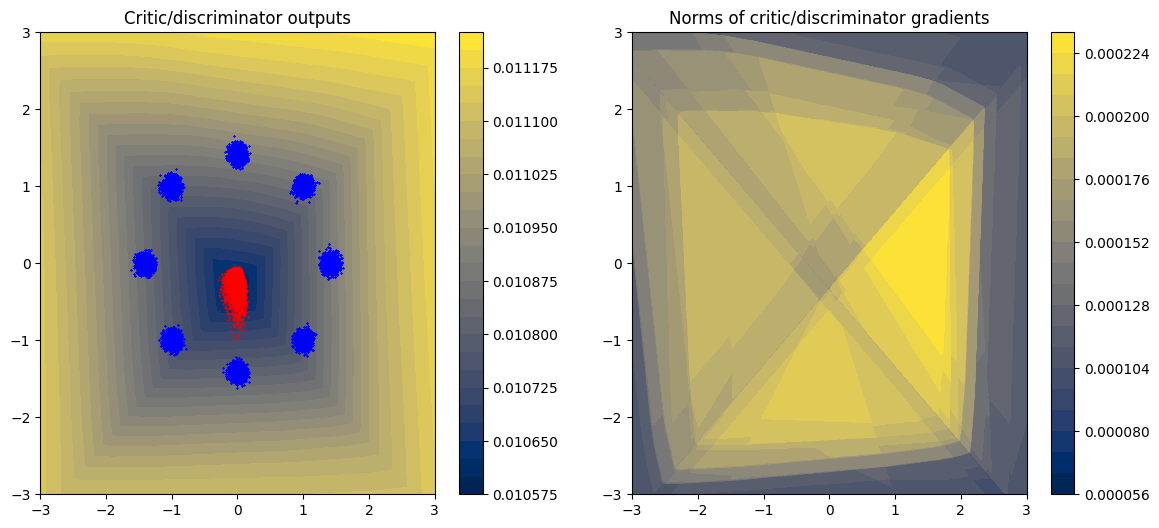

Epoch 20


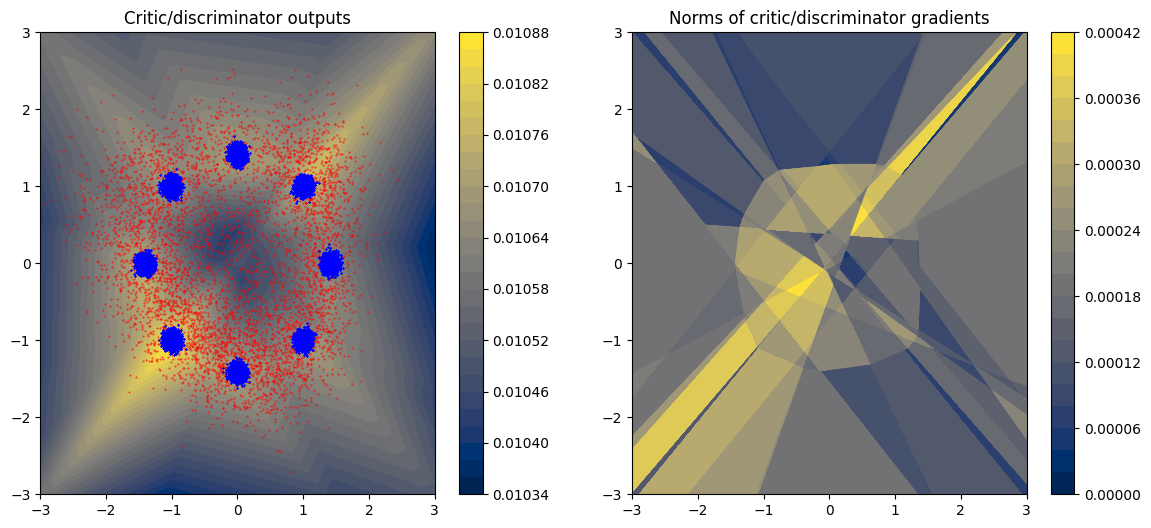

Epoch 40


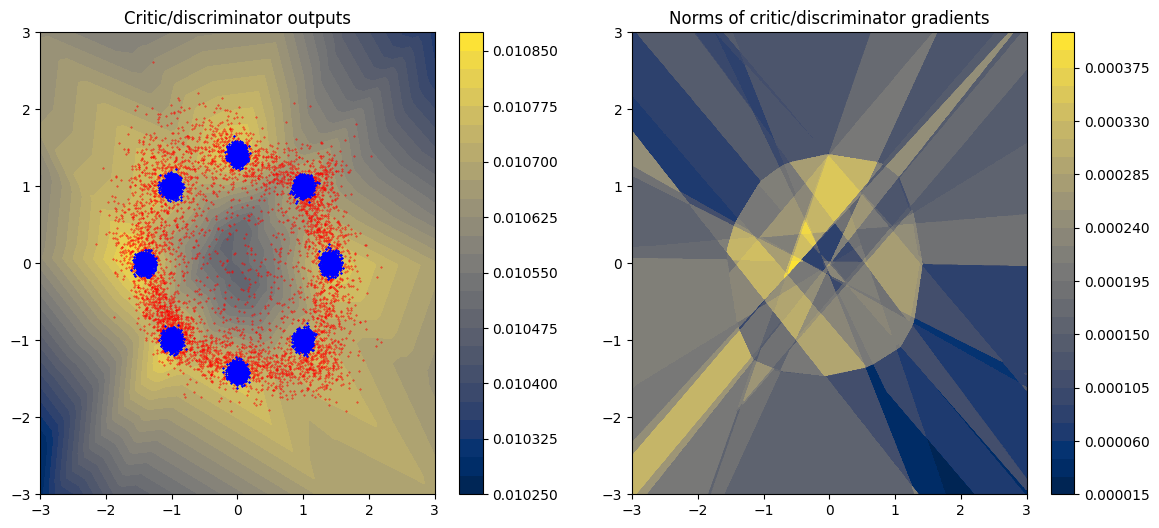

Epoch 60


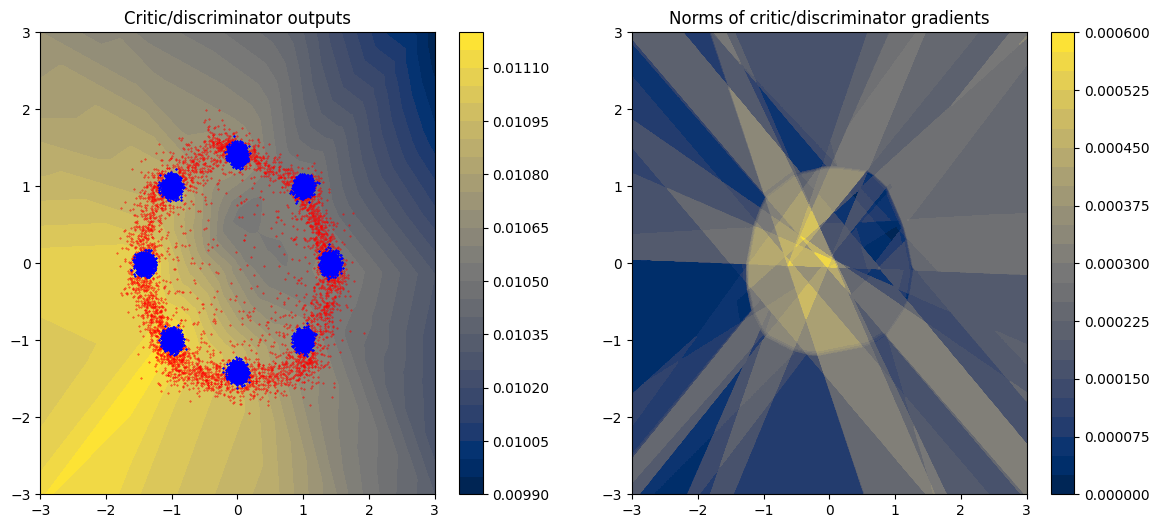

Epoch 80


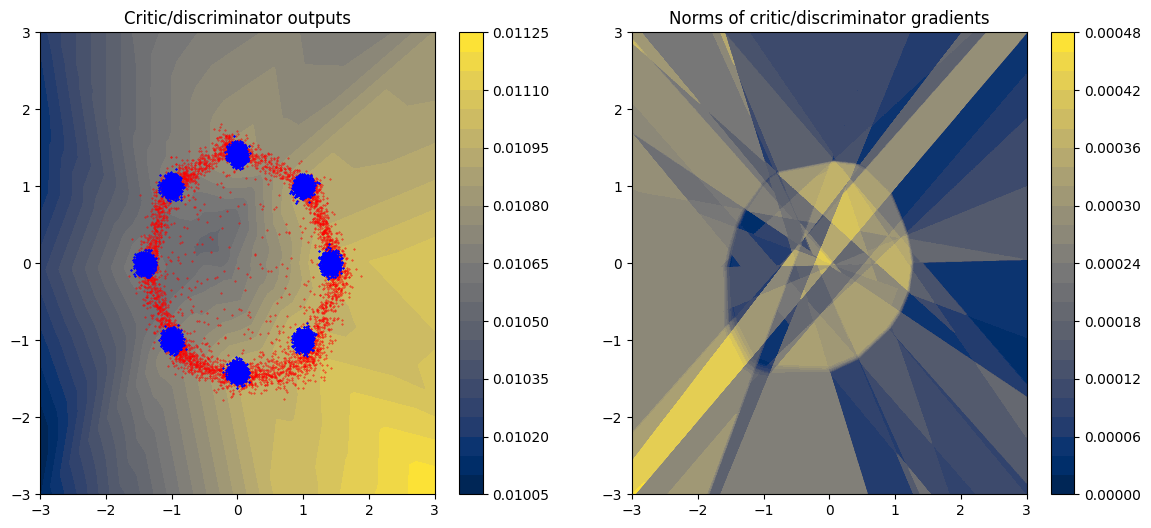

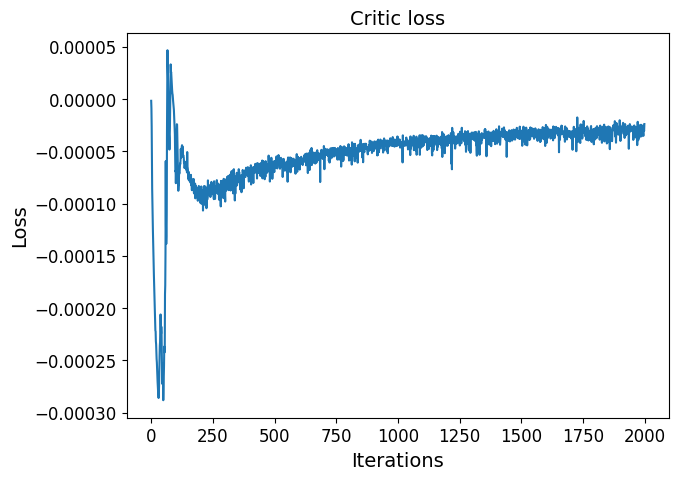

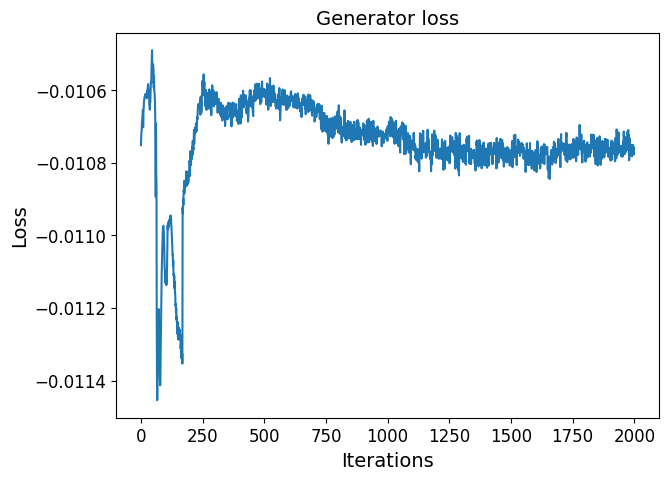

In [30]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING), NO LEARNING (NOT SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # take 1/2
LR = 2e-4 # < 1e-2

N_EPOCHS = 100 # change it if you want

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    train_data=train_data,
    visualize_GAN_output=visualize_GAN_output,
    make_inference=make_inference,
    lr=LR,
    visualize_steps=20,
    device=DEVICE,
    c=0.01
)

plot_losses(train_losses['critic_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

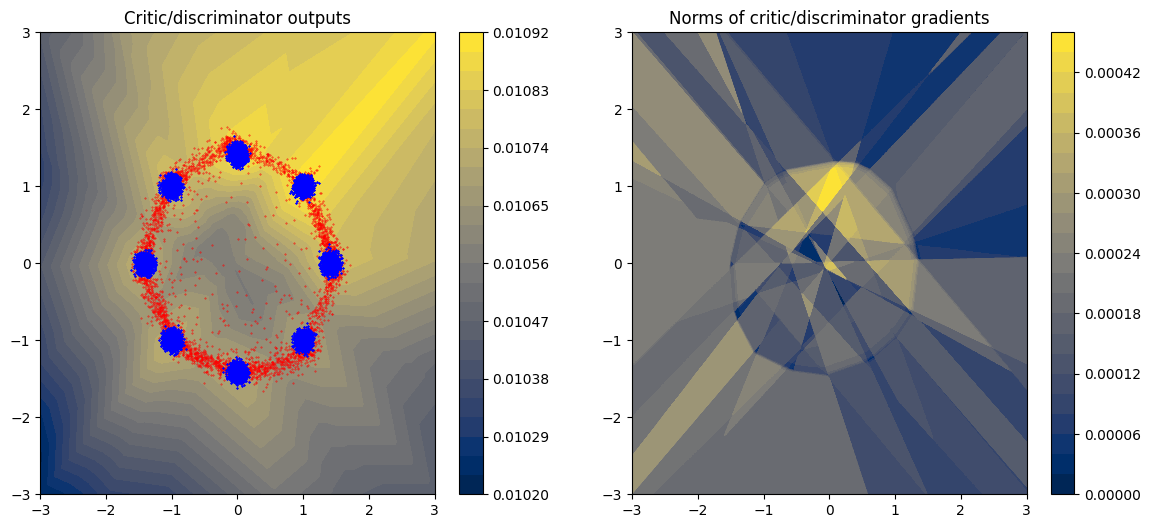

In [31]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

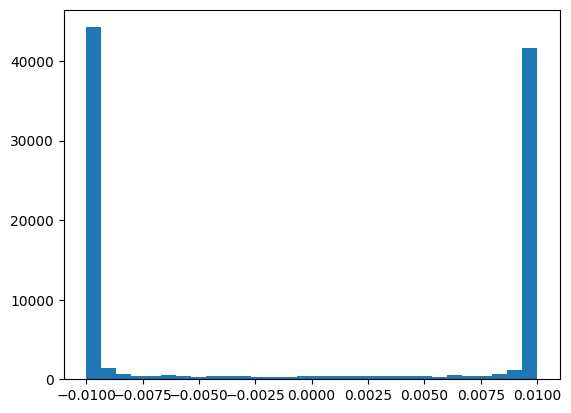

In [32]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=30)
plt.show()

The angular contour lines appear because weight clipping forces many critic weights to hit the clipping boundaries, making the critic function piecewise linear and non-smooth. As a result, the critic cannot capture the smooth geometry of the data distribution - its value surface becomes blocky and distorted.

## WGAN-GP

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

<center>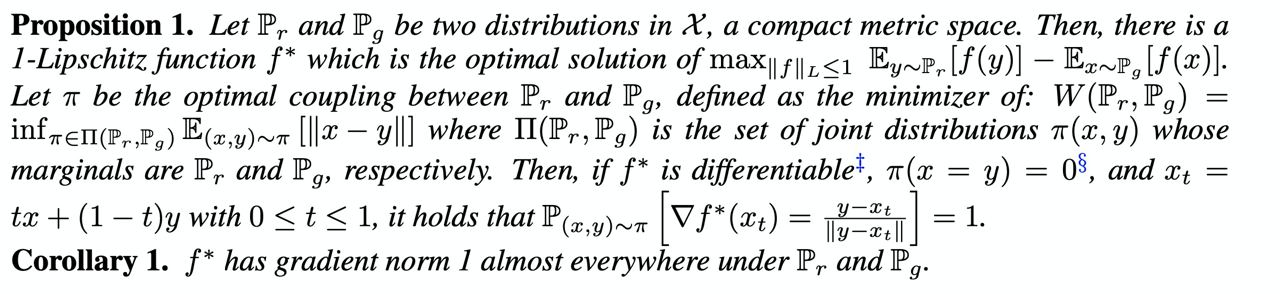<center>

In [33]:
class MLPGenerator(FullyConnectedMLP):
    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

class MLPCritic(FullyConnectedMLP):
    def __init__(self, input_dim, hiddens, output_dim):
        super().__init__(input_dim, hiddens, output_dim)
        # WGAN doesn't use BCELoss and sigmoid
        
    def forward(self, z):
        # Return value directly without sigmoid
        x = super().forward(z)
        return x
    
    # Method not required for WGAN, but can be kept for compatibility
    def wasserstein_loss(self, real_output, fake_output):
        # Wasserstein loss = E[critic(real)] - E[critic(fake)]
        return -torch.mean(real_output) + torch.mean(fake_output)

In [34]:
from wgan import train_wgan_gp

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


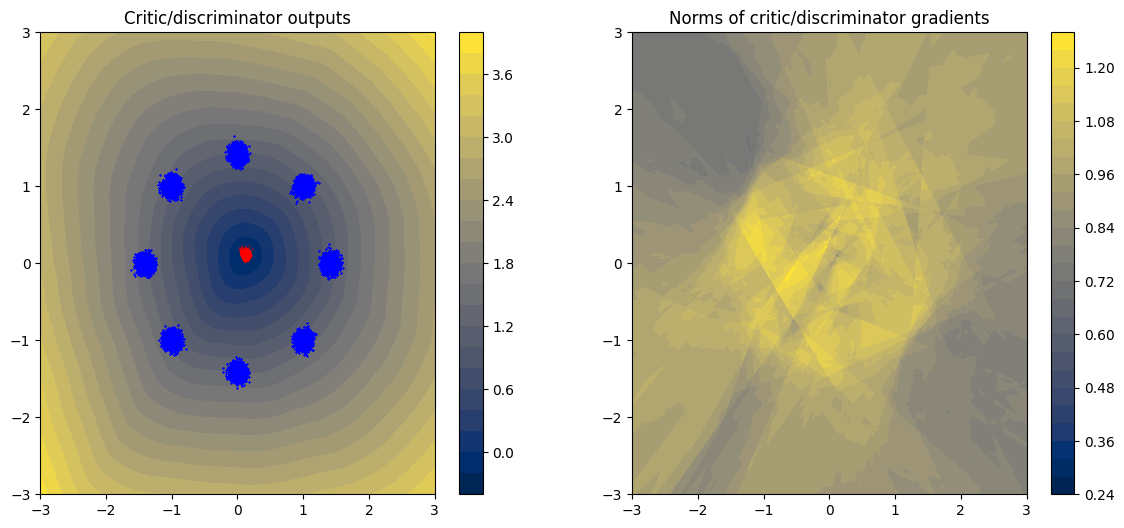

Epoch 20


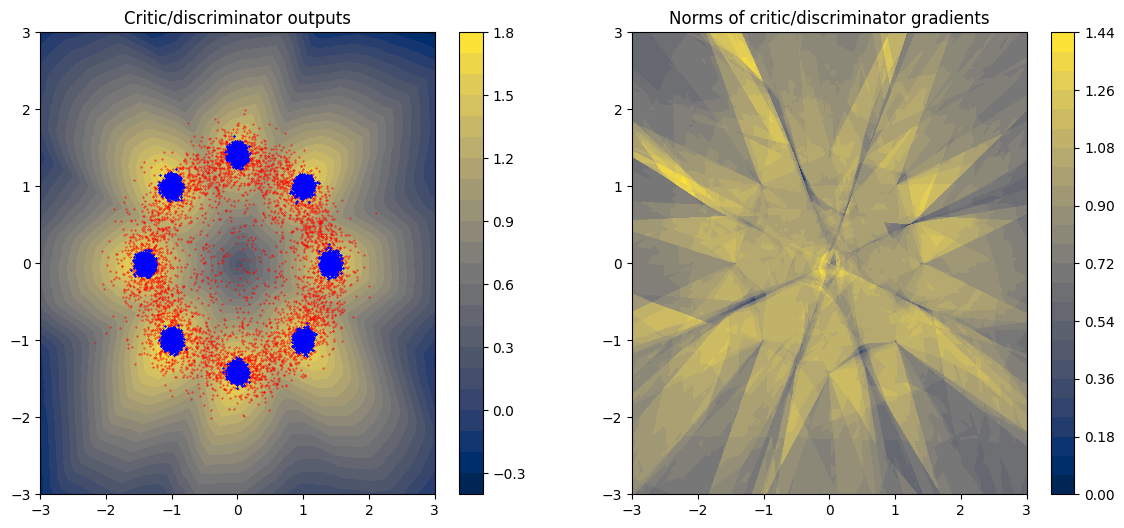

Epoch 40


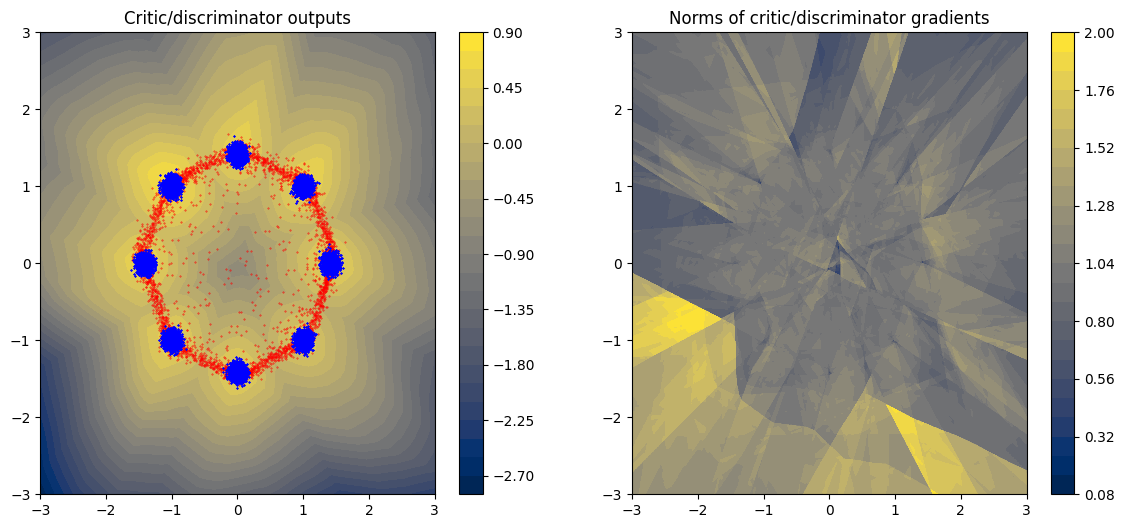

Epoch 60


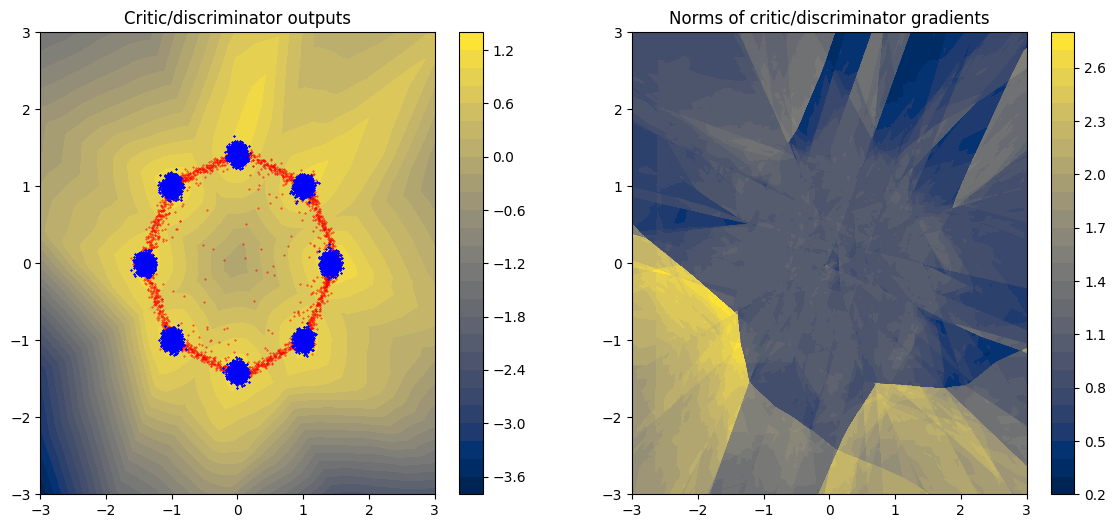

Epoch 80


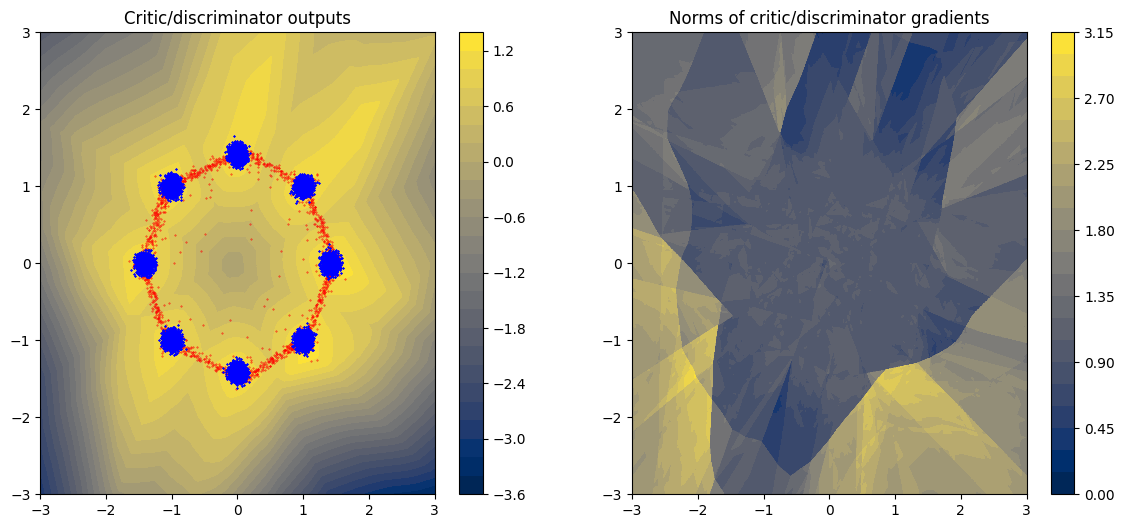

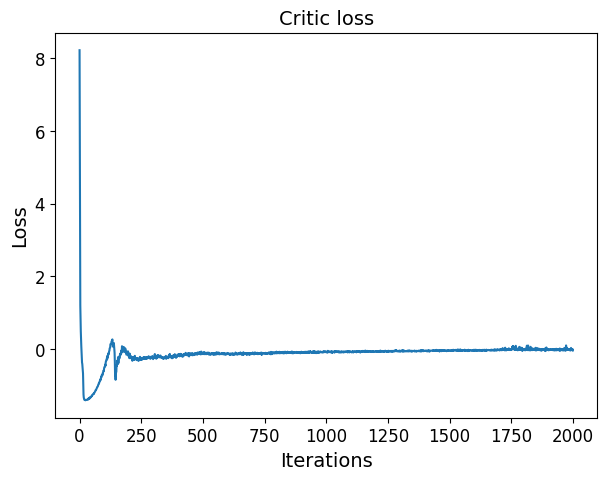

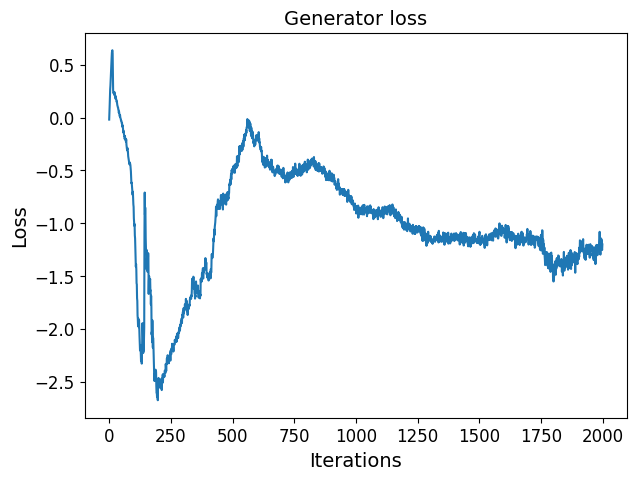

In [36]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING), NO LEARNING (NOT SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 10 # take 1/2
LR = 2e-4 # < 1e-2

N_EPOCHS = 100 # change it if you want

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    train_data=train_data,
    visualize_GAN_output=visualize_GAN_output,
    make_inference=make_inference,
    lr=LR,
    visualize_steps=20
)

plot_losses(train_losses['critic_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

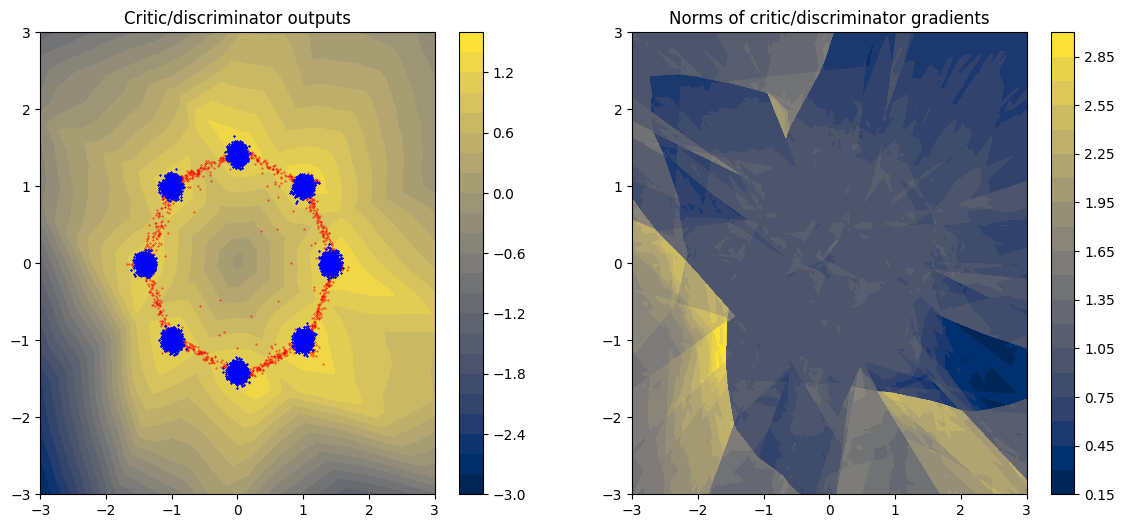

In [37]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

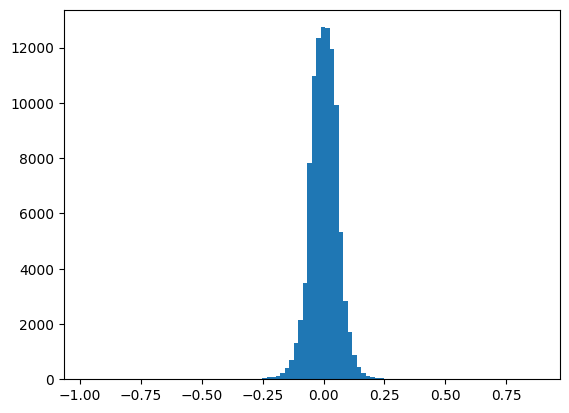

In [38]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=100)
plt.show()

#### WGAN vs WGAN-GP:

| Aspect | WGAN | WGAN-GP |
|--------|------|---------|
| **Theoretical Foundation** | Kantorovich-Rubinstein duality for Wasserstein Distance | Same, plus enhanced Lipschitz enforcement |
| **Lipschitz Enforcement** | Weight clipping (-c, c) | Gradient penalty on interpolated samples |
| **Key Advantage** | Meaningful loss that correlates with image quality | More stable training without gradient issues |
| **Critic Output** | No sigmoid (unbounded) | No sigmoid (unbounded) |
| **Loss Function** | $$\mathcal{L}_{\text{WGAN}} = \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] - \mathbb{E}_{z \sim p(z)}[D(G(z))]$$ | $$\mathcal{L}_{\text{WGAN-GP}} = \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] - \mathbb{E}_{z \sim p(z)}[D(G(z))] + \lambda \, \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}\!\left[(\|\nabla_{\hat{x}}D(\hat{x})\|_2 - 1)^2\right]$$ |
| **Gradient Behavior** | Can stick to clipping boundaries | Enforced to have norm ≈ 1 at interpolated points |
| **Optimization** | RMSProp recommended | Adam with β₁=0, β₂=0.9 works better |
| **Training Stability** | More stable than vanilla GAN | Even more stable than WGAN |
| **Generator Updates** | After n critic updates | After n critic updates |
| **Key Parameter** | Clipping bound c | Gradient penalty weight λ (typically 10) |
| **Training Oscillations** | Reduced compared to vanilla GAN | Further reduced with smoother convergence |
| **Failure Modes** | Exploding/vanishing gradients possible | Better handling of divergence problems |